# PCA analysis of VAE latent space

In [1396]:
import os
import numpy as np
from specvae.vae import BaseVAE
import specvae.dataset as dt
import specvae.utils as utils

In [1397]:
# Parameters
dataset = "MoNA"
model_name = "betavae_capacity_20-800-200-50-3-50-200-800-20_01 (24-12-2021_01-50-12)"
model_dir = "d:\\Workspace\\SpecVAE\\.model\\MoNA\\betavae_capacity_nextron\\betavae_capacity_20-800-200-50-3-50-200-800-20_01 (24-12-2021_01-50-12)"


## Load model

In [1398]:
device, cpu = utils.device(use_cuda=False)

Device in use:  cpu


In [1399]:
print("Load model: %s..." % model_name)
model_path = os.path.join(model_dir, 'model.pth')
model = BaseVAE.load(model_path, device)
model.eval()

Load model: betavae_capacity_20-800-200-50-3-50-200-800-20_01 (24-12-2021_01-50-12)...


SpecVEA(
  (encoder): Sequential(
    (en_lin_1): Linear(in_features=20, out_features=800, bias=True)
    (en_lin_batchnorm_1): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (en_act_1): ReLU()
    (en_lin_2): Linear(in_features=800, out_features=200, bias=True)
    (en_lin_batchnorm_2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (en_act_2): ReLU()
    (en_lin_3): Linear(in_features=200, out_features=50, bias=True)
    (en_lin_batchnorm_3): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (en_act_3): ReLU()
  )
  (fc_mean): Linear(in_features=50, out_features=3, bias=True)
  (mean_batchnorm): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_logvar): Linear(in_features=50, out_features=3, bias=True)
  (logvar_batchnorm): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sample): SampleZ()
  (decoder): Seque

In [1400]:
model.config

{'name': 'betavae_capacity',
 'layer_config': array([[ 20, 800, 200,  50,   3],
        [  3,  50, 200, 800,  20]], dtype=int64),
 'latent_dim': 3,
 'beta': 0.01,
 'limit': 1.0,
 'dropout': 0.0,
 'input_columns': ['spectrum'],
 'types': [torch.float32],
 'dataset': 'MoNA',
 'transform': Compose(
 ),
 'max_mz': 2500.0,
 'min_intensity': 0.001,
 'max_num_peaks': 10,
 'normalize_intensity': True,
 'normalize_mass': True,
 'rescale_intensity': False,
 'n_samples': -1,
 'n_epochs': 30,
 'batch_size': 128,
 'learning_rate': 0.001}

## Load and transform data

In [1401]:
if dataset == 'MoNA':
    labels = ['ionization_mode_id', 'collision_energy', 'total_exact_mass', 'precursor_mz', 
        'instrument_id', 'instrument_type_id', 'precursor_type_id', 'superclass_id', 'class_id']
    base_path = utils.get_project_path() / '.data' / 'MoNA'
    metadata_path = base_path / 'MoNA_meta.npy'
elif dataset == 'HMDB':
    labels = ['ionization_mode_id', 'collision_energy', 'superclass_id', 'class_id']
    base_path = utils.get_project_path() / '.data' / 'HMDB'
    metadata_path = base_path / 'HMDB_meta.npy'

metadata = None
if os.path.exists(metadata_path):
    metadata = np.load(metadata_path, allow_pickle=True).item()

In [1402]:
def load_vis_data(target_column):
    data_path = base_path / ('visualization_%s.csv' % target_column)
    df = dt.Spectra.open(data_path)
    return df

In [1403]:
def preload_data_as_tensor(df):
    columns = model.config['input_columns']
    types = model.config['types']
    data = dt.Spectra.preload_tensor(
        device=device, data_frame=df[columns + ['id']], transform=model.transform, limit=-1, types=types, do_print=False)
    return data

In [1404]:
def evaluate_model(df, data):
    print("Encode N=%d instances from %s dataset..." % (data['id'].shape[0], dataset))
    X, ids = data['spectrum'], data['id'] # TODO: handle the case for concatanated input
    Xrecon, z, latent_dist = model.forward_(X)
    print(z.shape)
    data_np = {}
    data_np['X'] = X.data.cpu().numpy()
    data_np['Xrecon'] = Xrecon.data.cpu().numpy()
    data_np['z'] = z.data.cpu().numpy()
    data_np['ids'] = ids
    data_np['ionization_mode_id'] = df['ionization_mode_id'].to_numpy()
    data_np['collision_energy'] = df['collision_energy'].to_numpy()
    # data_np['images'] = df['images'].to_numpy()
    return data_np


## Prepare data for vizualization

In [1405]:
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(24,20)})

import torchvision as tv
import specvae.vae as vae, specvae.utils as utils
import plotly.io as pio
pio.renderers.default='notebook'
import plotly.express as px
import pandas as pd

In [1406]:
def get_colors(df, data_np):
    colors = {}
    colors['ionization_mode_id'] = np.array(list(map(lambda x: 'negative' if x==0 else 'positive', data_np['ionization_mode_id'].tolist())))
    colors['collision_energy'] = data_np['collision_energy']
    colors['superclass_id'] = df['superclass'].to_numpy()
    df['class'] = df['class'].fillna('Undefined')
    colors['class_id'] = df['class'].to_numpy()
    if dataset == 'MoNA':
        df['precursor_type'] = df['precursor_type'].fillna('Undefined')
        colors['precursor_type_id'] = df['precursor_type'].to_numpy()
        df['instrument_type'] = df['instrument_type'].fillna('Undefined')
        colors['instrument_type_id'] = df['instrument_type'].to_numpy()
        df['instrument'] = df['instrument'].fillna('Undefined')
        colors['instrument_id'] = df['instrument'].to_numpy()
        colors['total_exact_mass'] = df['total_exact_mass'].to_numpy()
        colors['precursor_mz'] = df['precursor_mz'].to_numpy()
    return colors

In [1407]:
def compute_pca(data, n=2):
    print("Compute PCA for n_components=%d" % n)
    red = PCA(n)
    rdata = red.fit_transform(data)
    print("\t      explained_variance:", red.explained_variance_)
    print("\texplained_variance_ratio:", red.explained_variance_ratio_)
    return rdata

def compute_tsne(data, n=2):
    print("Compute tSNE for n_components=%d" % n)
    r = TSNE(n)
    rdata = r.fit_transform(data)
    print("TSNE:")
    print("\t      kl_divergence:", r.kl_divergence_)
    return rdata

def compute_umap(data, n_neighbors=15, min_dist=0.25, n=2, metric='euclidean'):
    print("Compute UMAP for n_components=%d" % n)
    fit = UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n,
        metric=metric)
    udata = fit.fit_transform(data)
    return udata

def plot_data(data, labels=None, label_name=None, plot_components=2, 
        hover_data=None, width=1000, height=1000, title='Visualization of dataset'):
    if plot_components == 2:
        fig = px.scatter(data, x=0, y=1, color=labels, 
            template='plotly_white', hover_data=hover_data,
            title=title, width=width, height=height)
        fig.show()
    elif plot_components == 3:
        fig = px.scatter_3d(data, x=0, y=1, z=2, color=labels, 
            template='plotly_white', hover_data=hover_data, 
            title=title, width=width, height=height)
        fig.update_traces(
            marker=dict(size=3),
            selector=dict(mode='markers'))
        fig.show()

In [1408]:
from specvae import visualize as vis
def vis_spectra(data, label, color='red', config=None):
    mode_pos = data.copy().sort_values(by=[label])
    print(mode_pos.shape)

    if mode_pos.shape[0] > 0:
        height, width = 1, mode_pos.shape[0]
        fig, axs = plt.subplots(1, width, figsize=(width * 7, 5))
        for i, ((inx, row), ax) in enumerate(zip(mode_pos.iterrows(), axs.flat)):
            vis.plot_spectrum(row['spectrum'], name='', meta={
                'ionization mode': row['ionization_mode_id'], 
                'collision energy': row['collision_energy']
            }, ax=ax, config=config, color=color)
        plt.show()

### Select compounds

In [1409]:
label = 'collision_energy'
df = load_vis_data(label)
dfgr = df.groupby(['SMILES']).size().reset_index(name='count')
df_selected = df[df['SMILES'].isin(dfgr[dfgr['count'] >= 3]['SMILES'])]
df_selected[['SMILES', label, 'ionization_mode_id']]

SMILES  collision_energy  \
1     O=C(OC)C1=COC(C)C2CN3CCC4(C(O)=NC=5C=CC=CC54)C...              30.0   
4                                C1=C(CCN)C=C(C(=C1)O)O              30.0   
5     C[C@@]12CCC(=O)C=C2CC[C@H]3[C@@H]4CC[C@H](C(=O...              30.0   
9     O=C(OC1OC(COC2OC(CO)C(OC3OC(C)C(O)C(O)C3O)C(O)...              30.0   
11    CC1=C(CC(=O)O)C2=C(C=CC(=C2)OC)N1C(=O)C3=CC=C(...              30.0   
...                                                 ...               ...   
4974                         O=C1OC=2C(O)=C(O)C=CC2C=C1              10.0   
4978                                     CCOP(=S)(O)OCC              10.0   
4983  O=C1C(OC2OC(COC3OC(C)C(O)C(O)C3O)C(O)C(O)C2O)=...              10.0   
4994  CCCC1=NC2=C(C=C(C=C2C)C3=NC4=C(C=CC=C4)N3C)N1C...              10.0   
4999                             C1CC(=N[C@@H]1C(=O)O)O              10.0   

      ionization_mode_id  
1                      0  
4                      0  
5                      1  
9                      0  
11                     0  
...                  ...  
4974                   1  
4978                   0  
4983                   0  
4994                   1  
4999                   1  

[1503 rows x 3 columns]

In [1410]:
# CCCCOC1=NC2=C(C=CC=C2)C(=C1)C(=NCCN(CC)CC)O
# CCCCCCCCCCCC(=NCCC[N+](C)(C)CC(=O)O)O
# CC1=C(C)OC(=N1)NS(=O)(=O)C2=CC=C(C=C2)N
# O=C(OC1OC(COC2OC(CO)C(OC3OC(C)C(O)C(O)C3O)C(O)C2O)C(O)C(O)C1O)C45CCC(C)C(C)C5C6=CCC7C8(C)CC(O)C(O)C(C)(CO)C8CCC7(C)C6(C)CC4
# C1=CC(=CC=C1C2=COC3=C(C(=CC(=C3)O)O)C2=O)O
# O=C(O)C1(C)CCC2(C)CCC3(C(=CC(=O)C4C5(C)CCC(O)C(C)(C)C5CCC43C)C2C1)C
# CN1[C@H]2CC[C@@H]1C[C@@H](C2)OC(=O)C(CO)C3=CC=CC=C3
uq_smiles = df_selected['SMILES'].unique()[:300]
# uq_smiles = [uq_smiles[np.random.randint(0, uq_smiles.shape[0])]]
uq_smiles

array(['O=C(OC)C1=COC(C)C2CN3CCC4(C(O)=NC=5C=CC=CC54)C3CC12',
       'C1=C(CCN)C=C(C(=C1)O)O',
       'C[C@@]12CCC(=O)C=C2CC[C@H]3[C@@H]4CC[C@H](C(=O)CO)[C@]4(C[C@@H]([C@@H]31)O)C=O',
       'O=C(OC1OC(COC2OC(CO)C(OC3OC(C)C(O)C(O)C3O)C(O)C2O)C(O)C(O)C1O)C45CCC(C)C(C)C5C6=CCC7C8(C)CC(O)C(O)C(C)(CO)C8CCC7(C)C6(C)CC4',
       'CC1=C(CC(=O)O)C2=C(C=CC(=C2)OC)N1C(=O)C3=CC=C(C=C3)Cl',
       'C(CC(=N[C@@H](CC1=CN=CN1)C(=O)O)O)CN',
       'OC=1C=C(O)C=2C=C(OC3OC(CO)C(O)C(O)C3O)C(=[O+]C2C1)C=4C=CC(O)=C(O)C4',
       'CCCCC(=O)N(CC1=CC=C(C=C1)C2=C(C=CC=C2)C3=NNN=N3)[C@@H](C(C)C)C(=O)O',
       'O=C1C=2C=CC=C(O)C2C(=O)C3=C(O)C=C(C=C13)CO',
       '[O-]C=1C=C(C=CC1O)C2=[O+]C3=CC(O)=CC(O)=C3C=C2',
       'C1CC(=N[C@@H]1C(=O)O)O',
       'O=C1C(OC2OC(CO)C(O)C(O)C2O)=C(OC=3C=C(O)C=C(O)C13)C=4C=C(O)C(O)=C(O)C4',
       'CCCCCCCCCCCCCCCCCCCCCC(=O)OCC(COP(=O)(O)OCCN)OC(=O)CC/C=C\\C/C=C\\CCCCCCCCCC',
       'C1=C(C=CC(=C1)S(=O)(=O)O)N', 'OC1=CC=C(C=C1)C=CC=2C=C(O)C=C(O)C2',
       'C1=CC2=C(C=C1)C=C(C=C

O=C(OC)C1=COC(C)C2CN3CCC4(C(O)=NC=5C=CC=CC54)C3CC12
(14, 32)


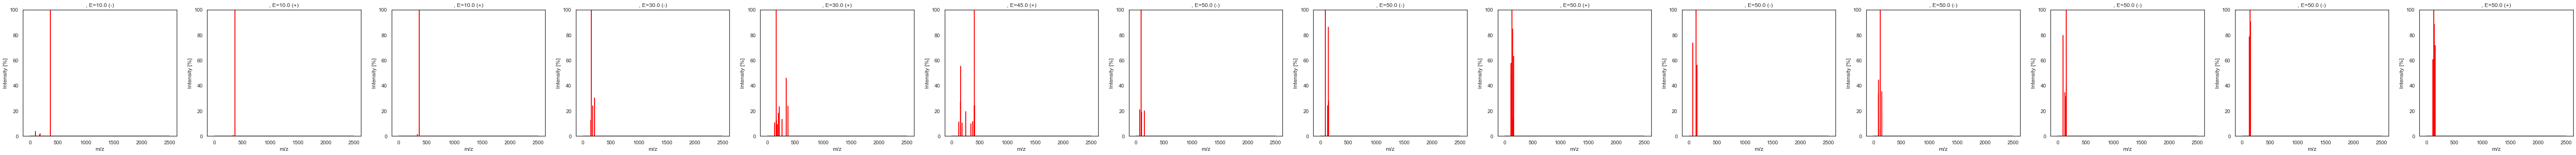

C1=C(CCN)C=C(C(=C1)O)O
(3, 32)


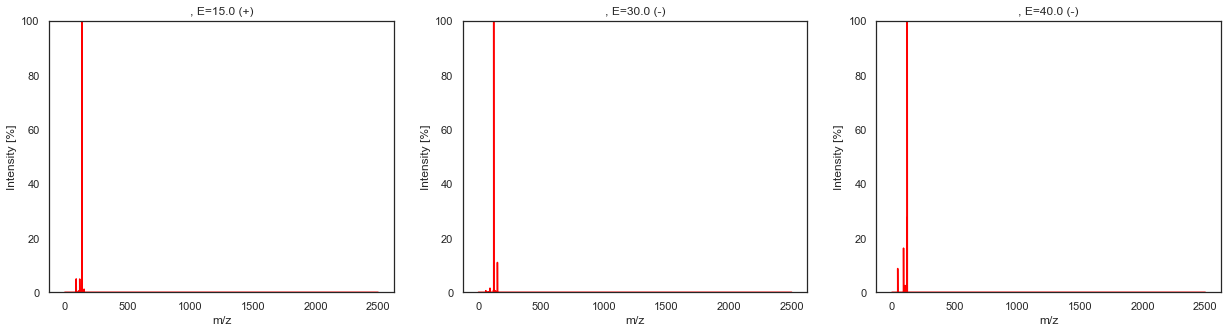

C[C@@]12CCC(=O)C=C2CC[C@H]3[C@@H]4CC[C@H](C(=O)CO)[C@]4(C[C@@H]([C@@H]31)O)C=O
(4, 32)


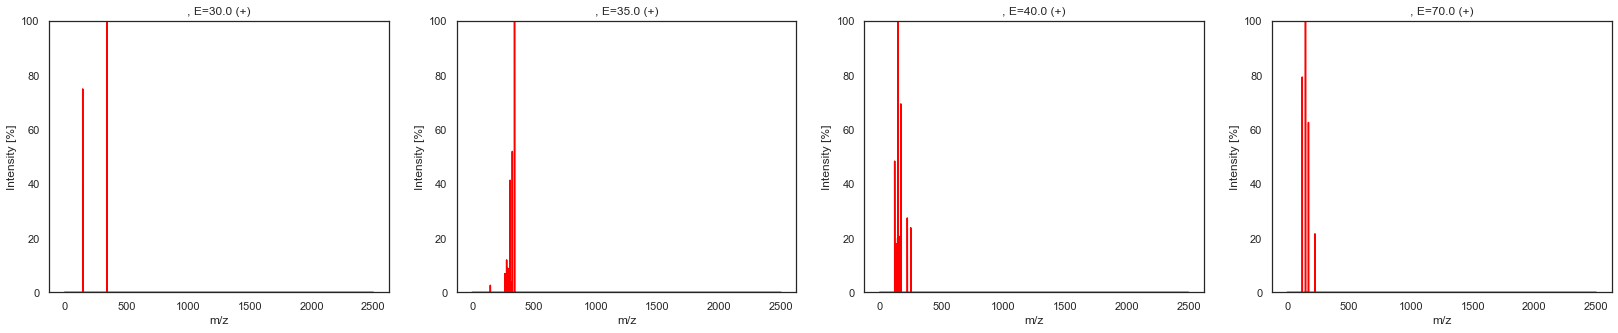

O=C(OC1OC(COC2OC(CO)C(OC3OC(C)C(O)C(O)C3O)C(O)C2O)C(O)C(O)C1O)C45CCC(C)C(C)C5C6=CCC7C8(C)CC(O)C(O)C(C)(CO)C8CCC7(C)C6(C)CC4
(6, 32)


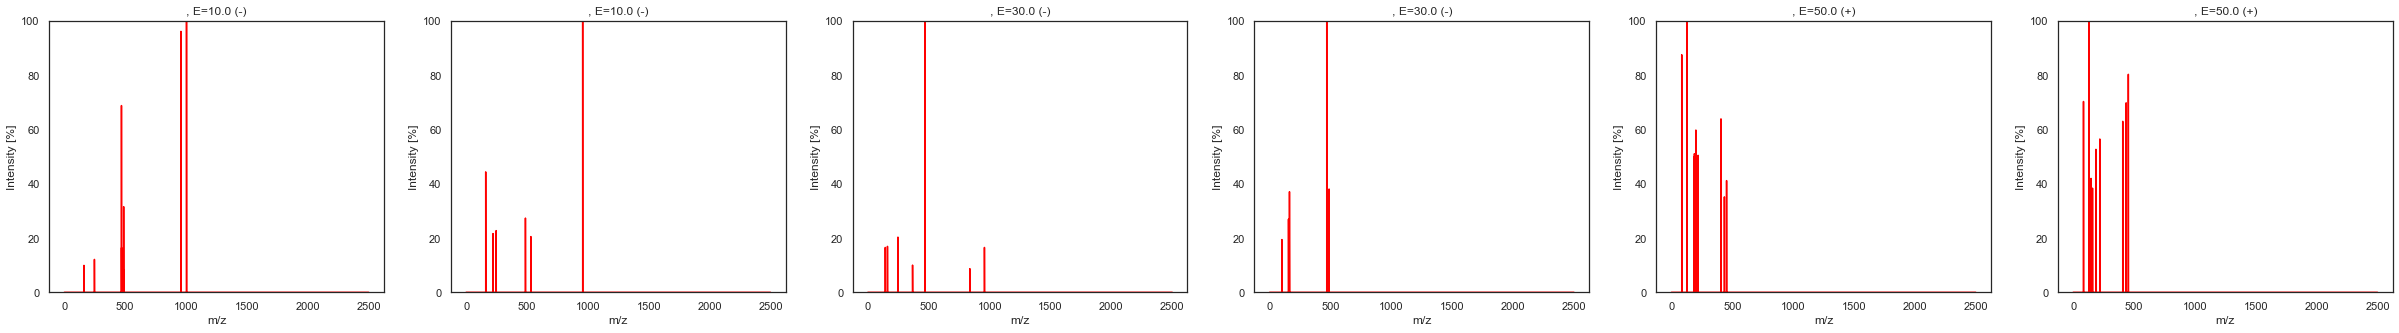

CC1=C(CC(=O)O)C2=C(C=CC(=C2)OC)N1C(=O)C3=CC=C(C=C3)Cl
(8, 32)


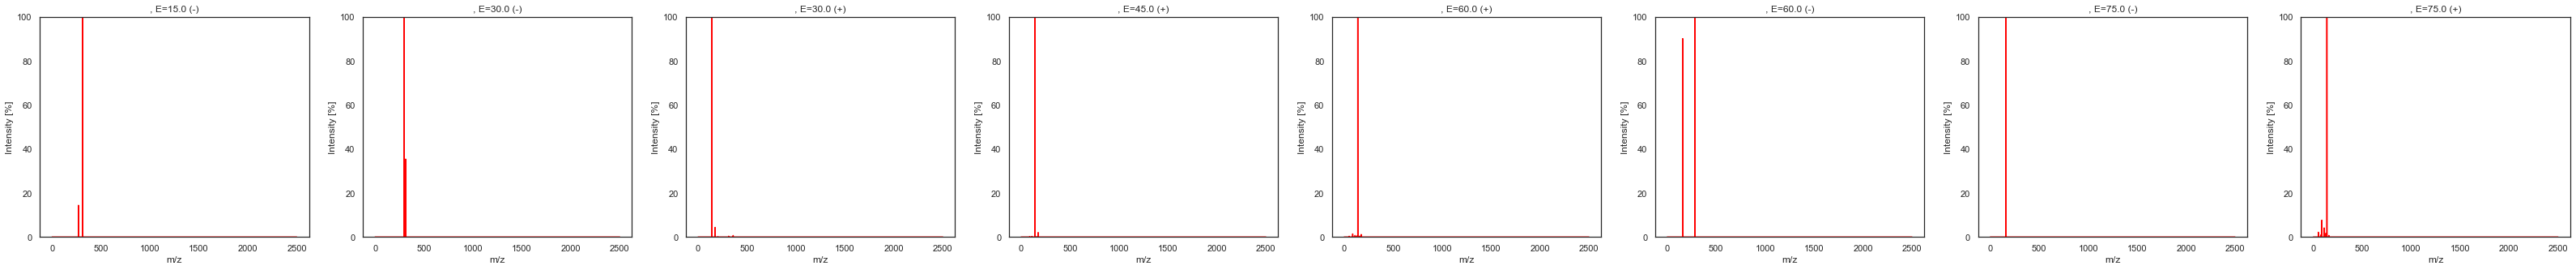

C(CC(=N[C@@H](CC1=CN=CN1)C(=O)O)O)CN
(4, 32)


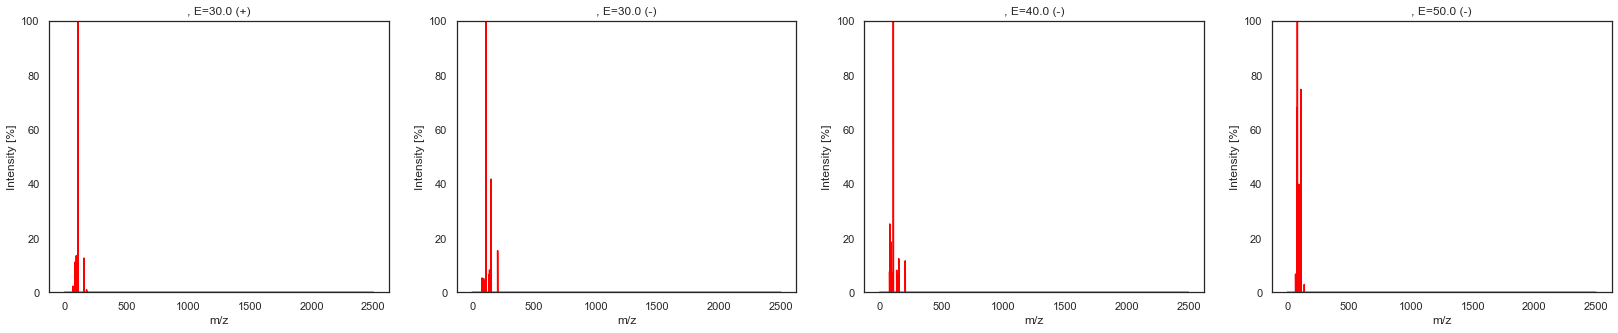

OC=1C=C(O)C=2C=C(OC3OC(CO)C(O)C(O)C3O)C(=[O+]C2C1)C=4C=CC(O)=C(O)C4
(6, 32)


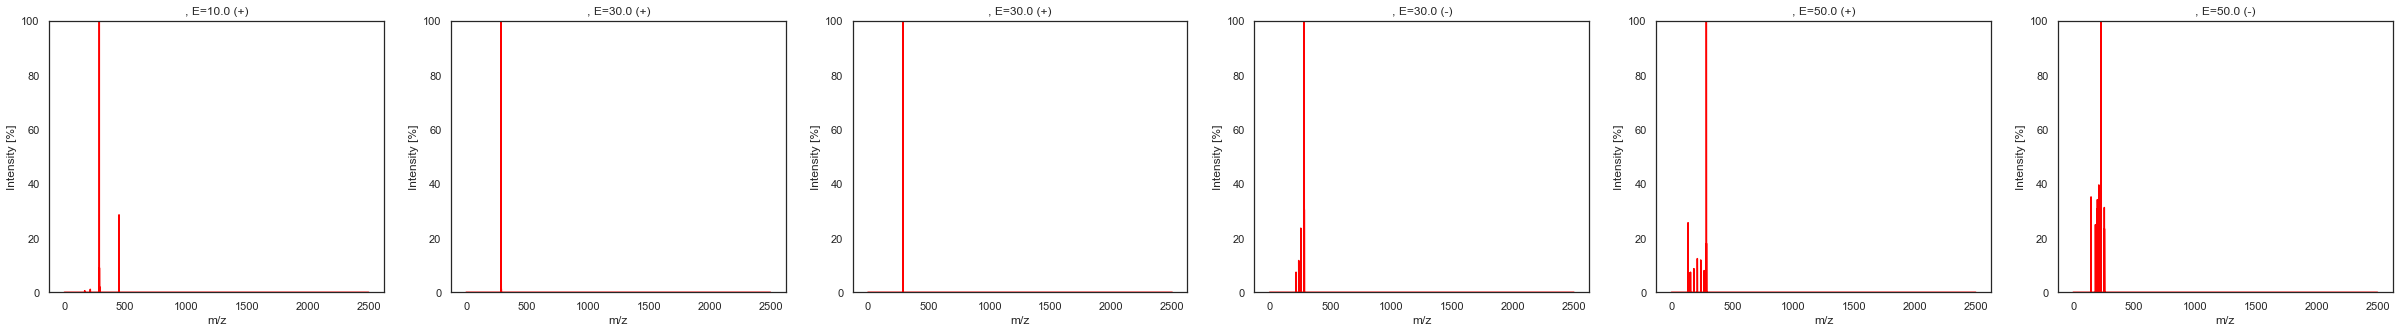

CCCCC(=O)N(CC1=CC=C(C=C1)C2=C(C=CC=C2)C3=NNN=N3)[C@@H](C(C)C)C(=O)O
(4, 32)


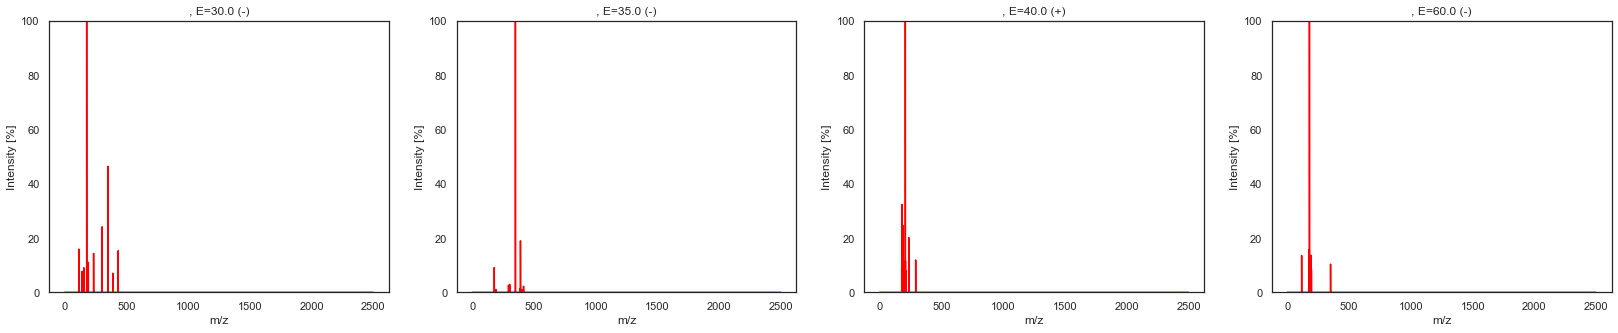

O=C1C=2C=CC=C(O)C2C(=O)C3=C(O)C=C(C=C13)CO
(3, 32)


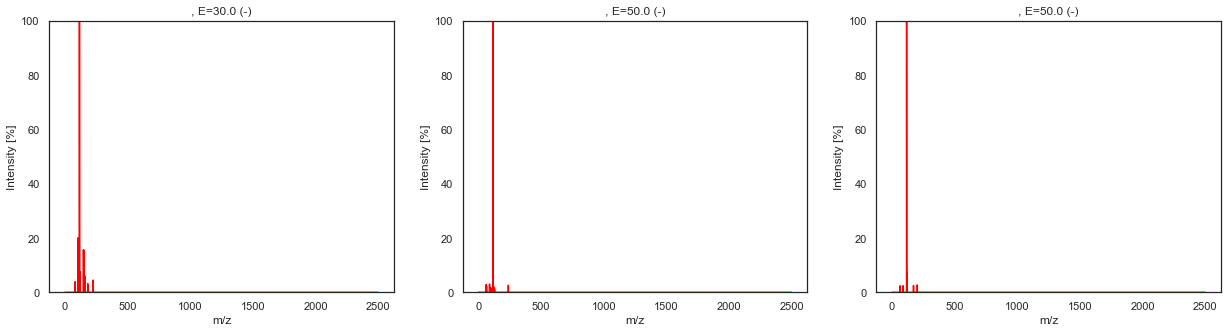

[O-]C=1C=C(C=CC1O)C2=[O+]C3=CC(O)=CC(O)=C3C=C2
(3, 32)


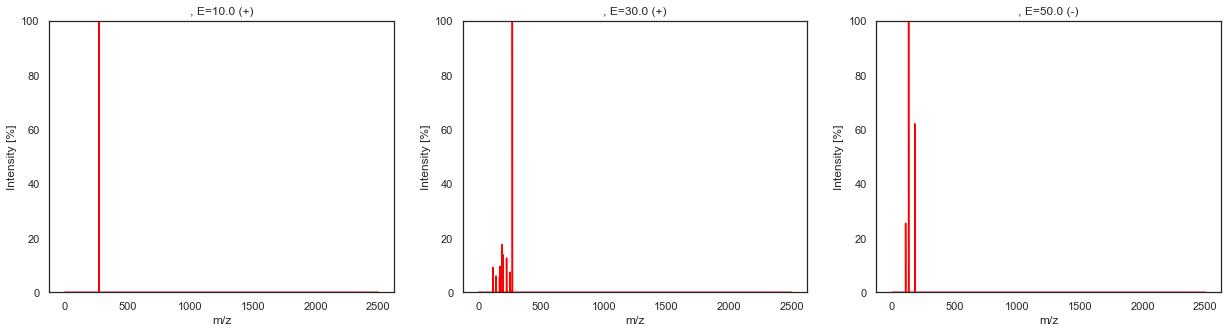

C1CC(=N[C@@H]1C(=O)O)O
(4, 32)


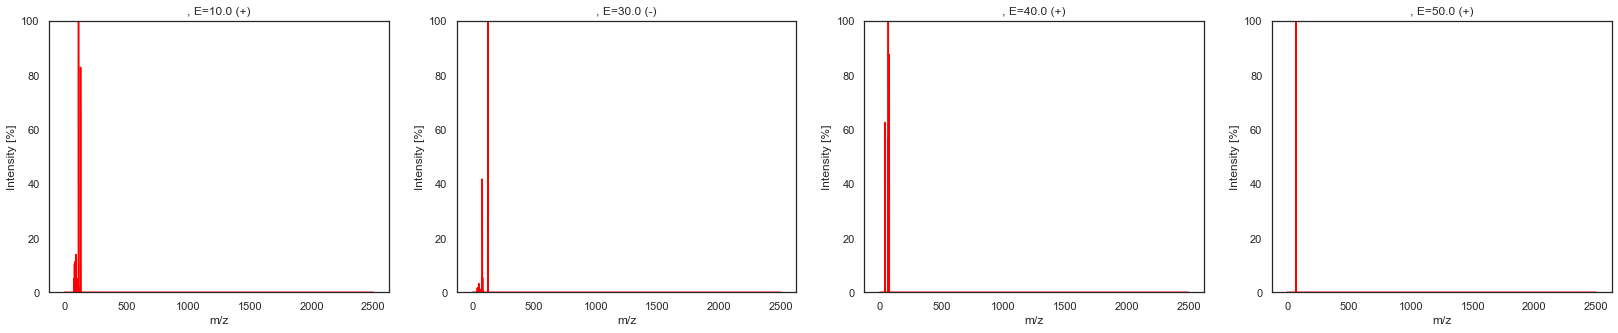

O=C1C(OC2OC(CO)C(O)C(O)C2O)=C(OC=3C=C(O)C=C(O)C13)C=4C=C(O)C(O)=C(O)C4
(3, 32)


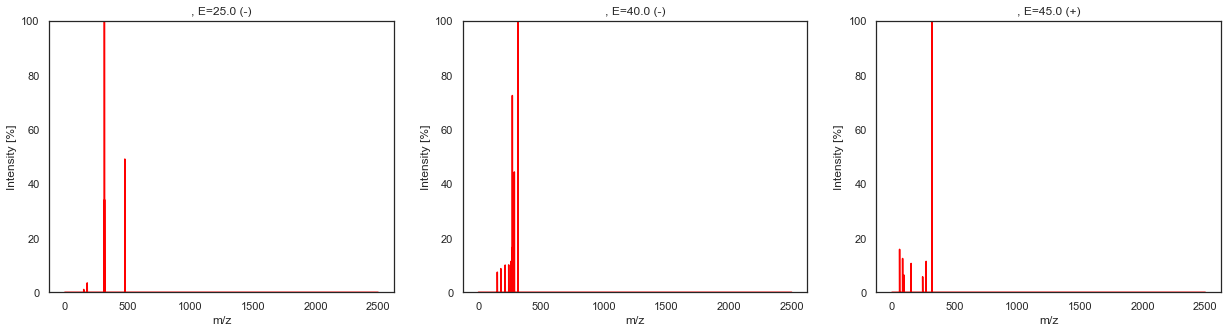

CCCCCCCCCCCCCCCCCCCCCC(=O)OCC(COP(=O)(O)OCCN)OC(=O)CC/C=C\C/C=C\CCCCCCCCCC
(3, 32)


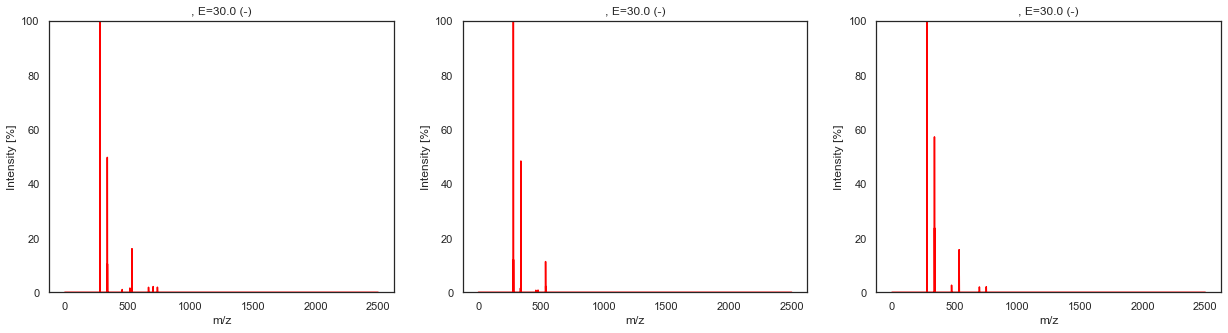

C1=C(C=CC(=C1)S(=O)(=O)O)N
(5, 32)


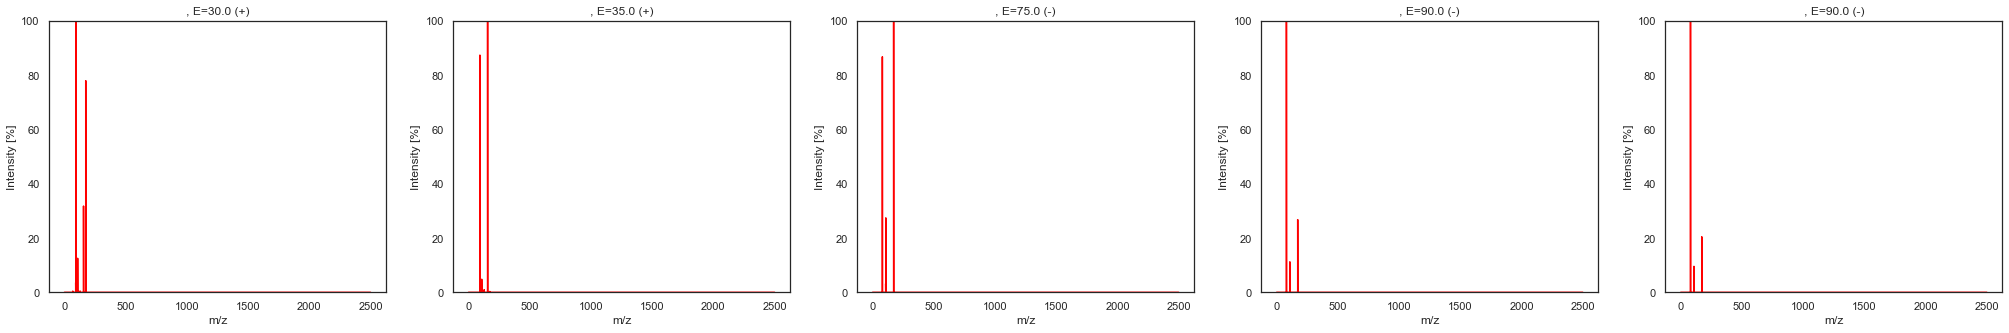

OC1=CC=C(C=C1)C=CC=2C=C(O)C=C(O)C2
(4, 32)


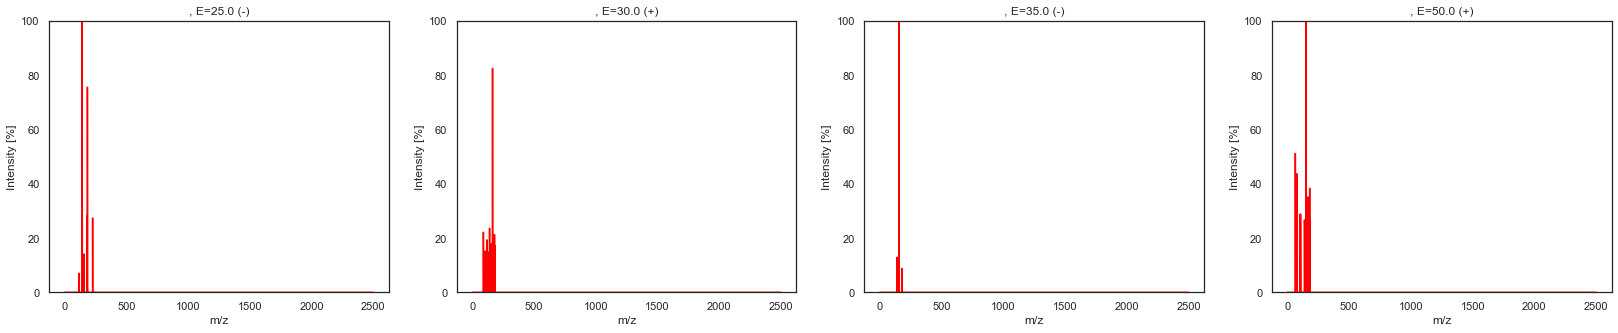

C1=CC2=C(C=C1)C=C(C=C2)S(=O)(=O)O
(3, 32)


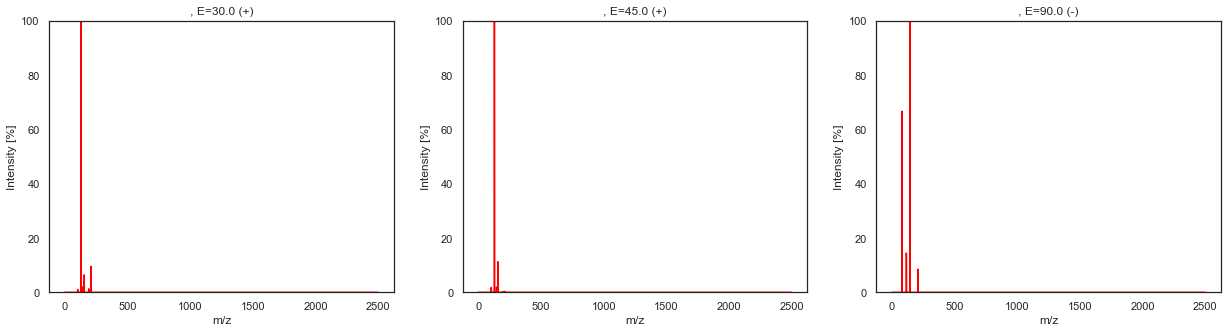

COC(=NC1=NC2=C(C=C(C=C2)C(=O)C3=CC=C(C=C3)F)N1)O
(3, 32)


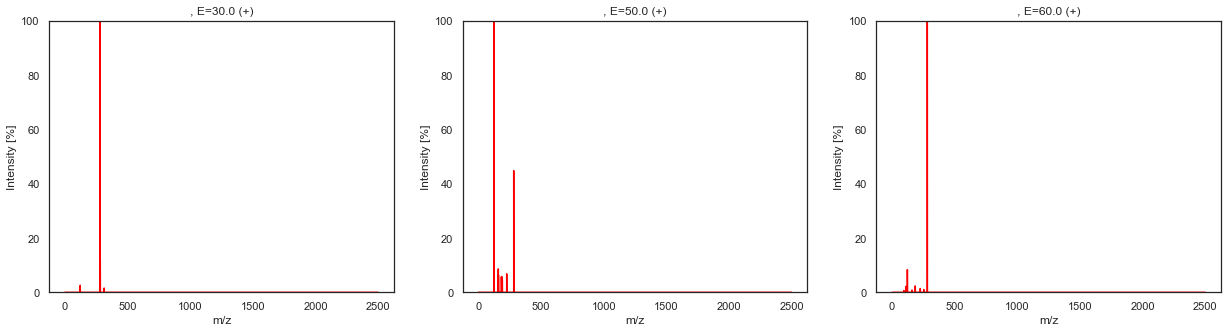

O=C1OCC(=C1)C2C(O)CC3(O)C4CCC5CC(OC6OC(C)C(OC7OC(C)C(OC8OC(C)C(O)C(O)C8)C(O)C7)C(O)C6)CCC5(C)C4CCC23C
(4, 32)


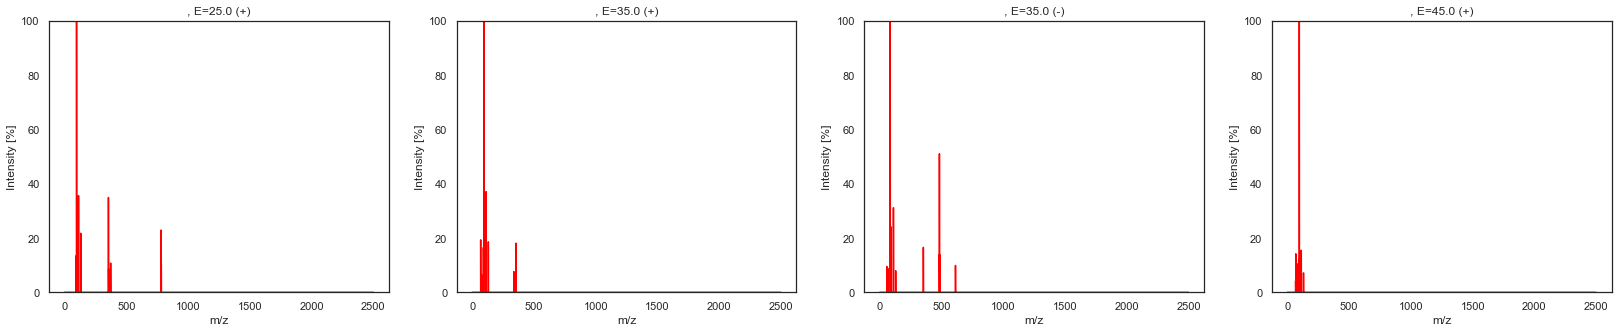

CNC1=C(C2=CC(=CC=C2)C(F)(F)F)C(=O)C(C3=CC=CC=C3)O1
(4, 32)


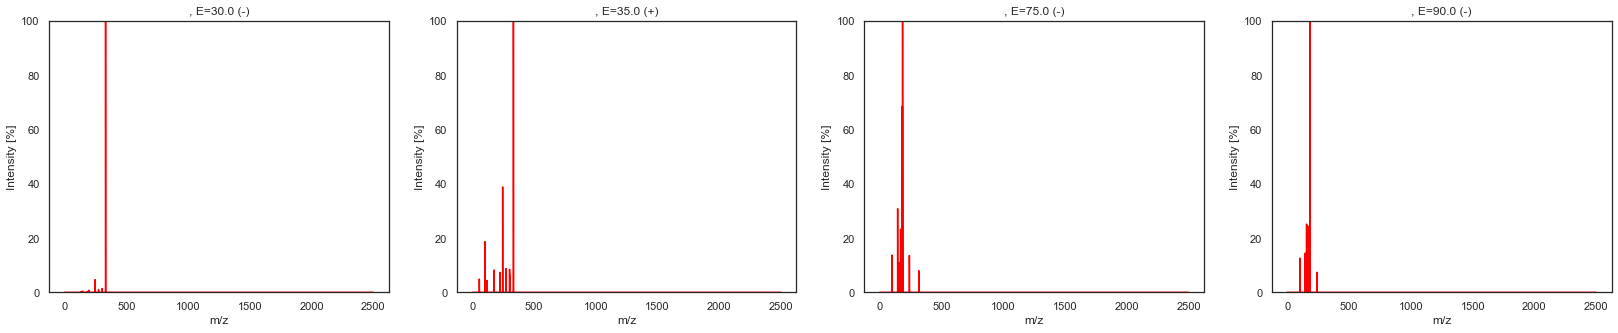

O=C1C(OC2OC(CO)C(O)C(OC3OC(C)C(O)C(O)C3O)C2O)=C(OC=4C=C(O)C=C(O)C14)C=5C=CC(O)=CC5
(4, 32)


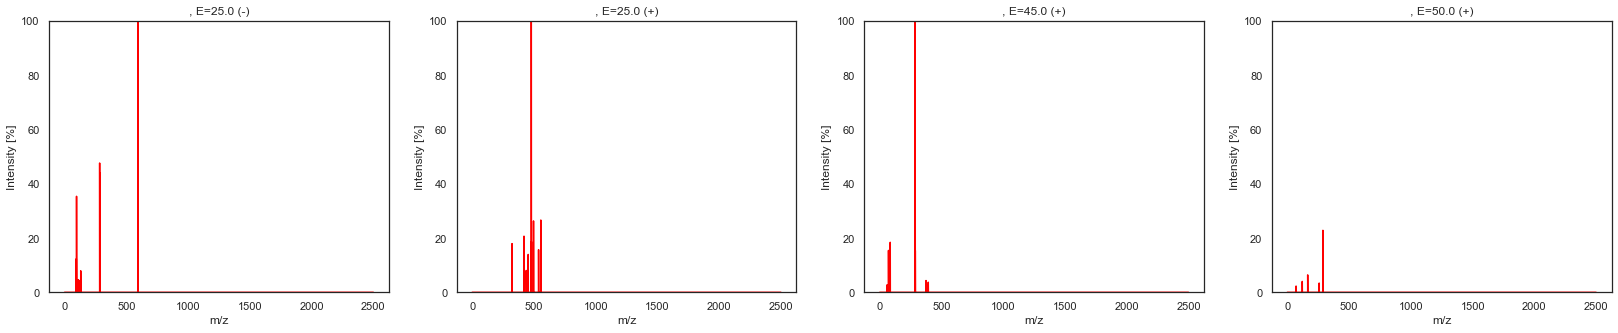

O=S(=O)(O)ON=C(SC1OC(CO)C(O)C(O)C1O)CC=C
(3, 32)


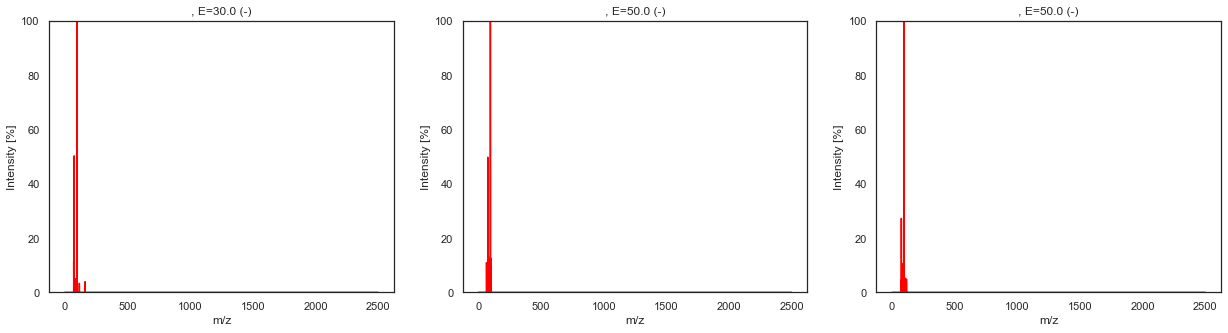

O=C(O)C=CC1=CC=C(OC)C(OC)=C1
(3, 32)


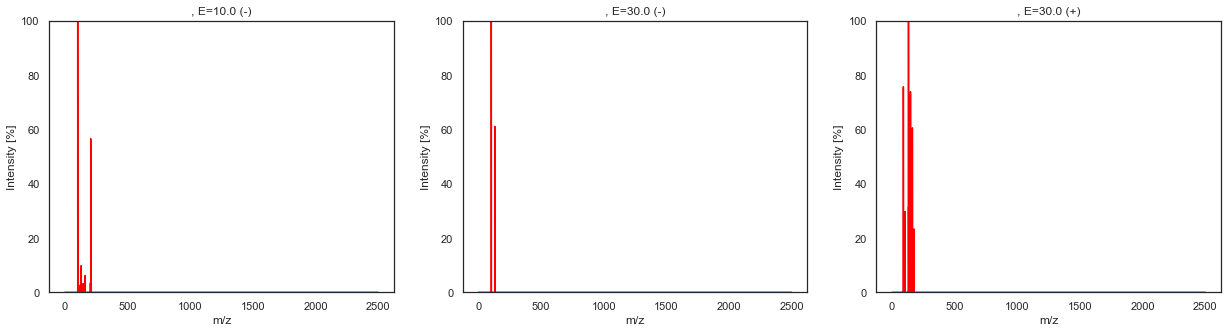

CCNCC(C1=CC=CC(=C1)O)O
(5, 32)


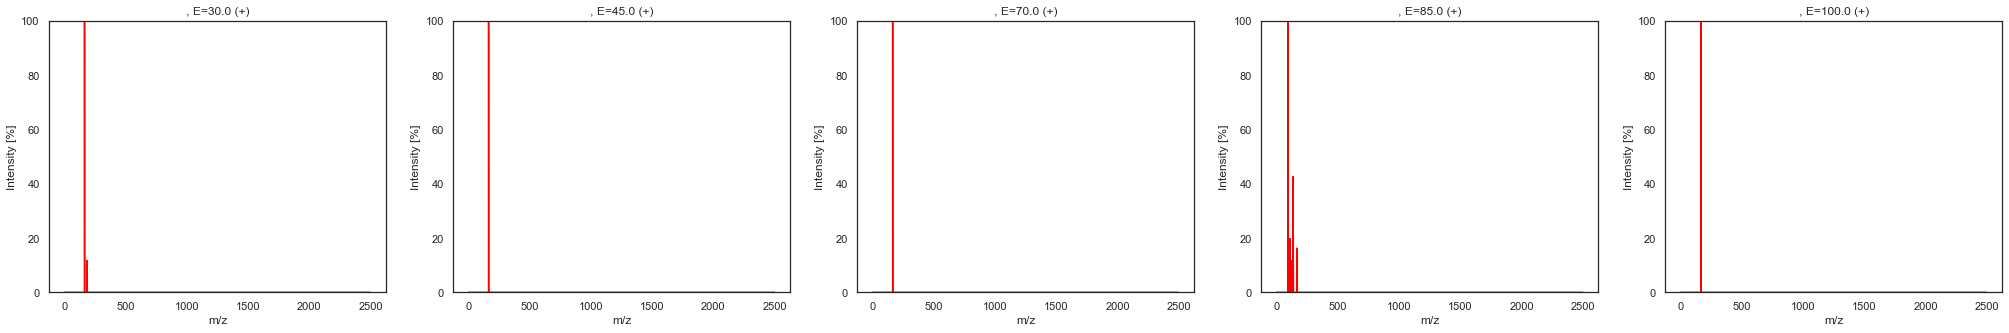

CC[C@@H](CO)NCCN[C@@H](CC)CO
(5, 32)


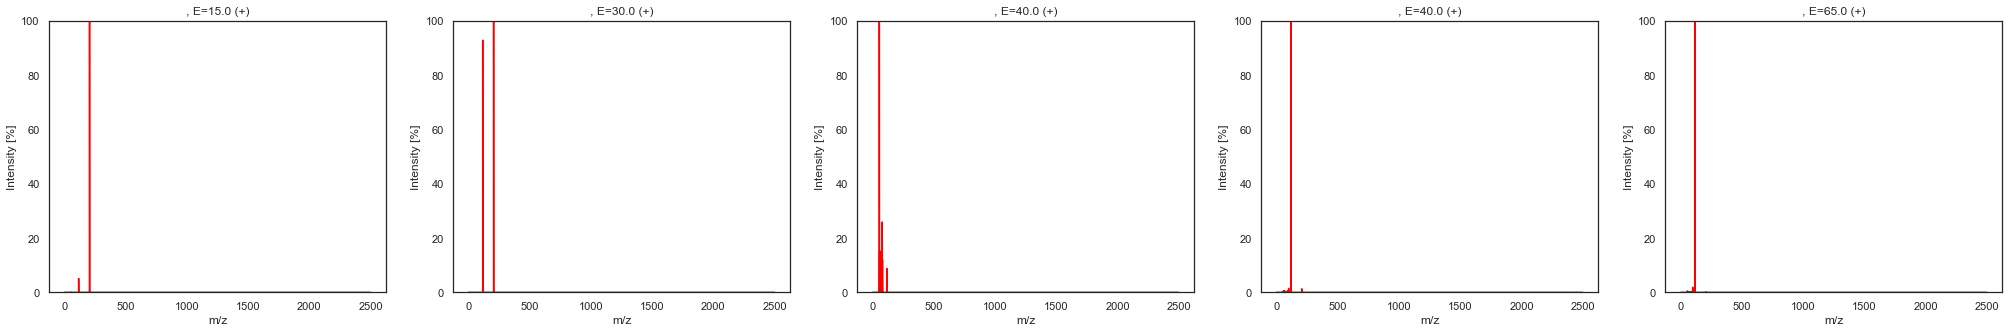

O=C1C(O)=C(OC=2C=C(O)C=C(O)C12)C=3C=CC(O)=C(O)C3
(5, 32)


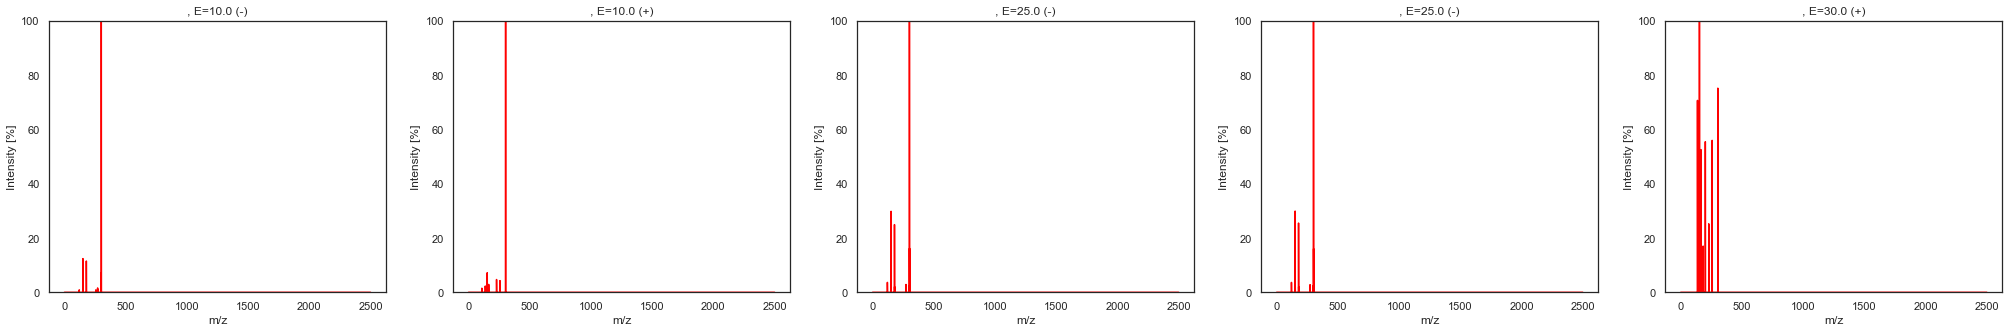

CCCCOC1=NC2=C(C=CC=C2)C(=C1)C(=NCCN(CC)CC)O
(11, 32)


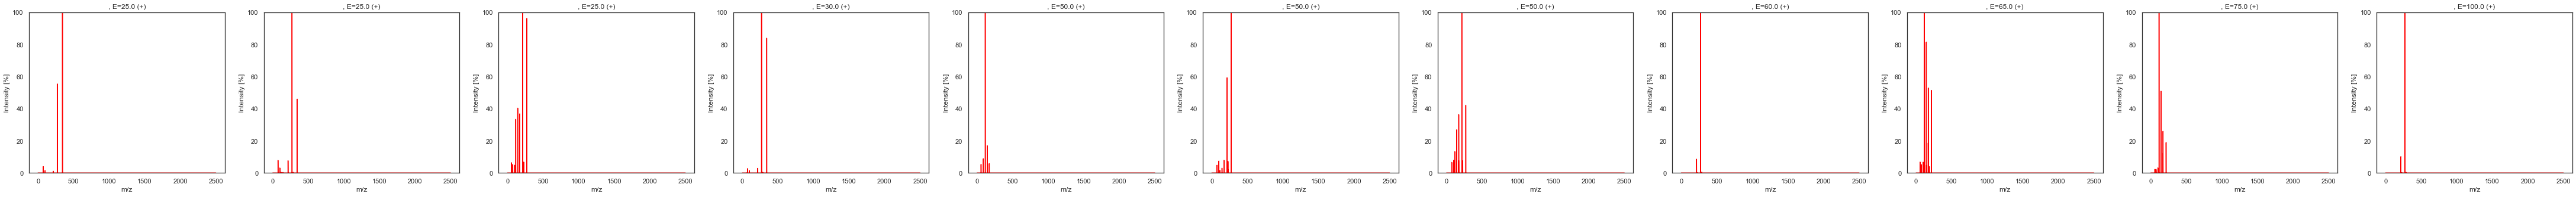

CC[C@@H]1[C@](C)([C@@H]([C@@H](C)C(=O)[C@H](C)C[C@](C)([C@@H]([C@@H](C)[C@@H]([C@@H](C)C(=O)O1)O[C@H]2C[C@](C)([C@H]([C@H](C)O2)O)OC)O[C@H]3[C@@H]([C@H](C[C@@H](C)O3)N(C)C)O)O)O)O
(4, 32)


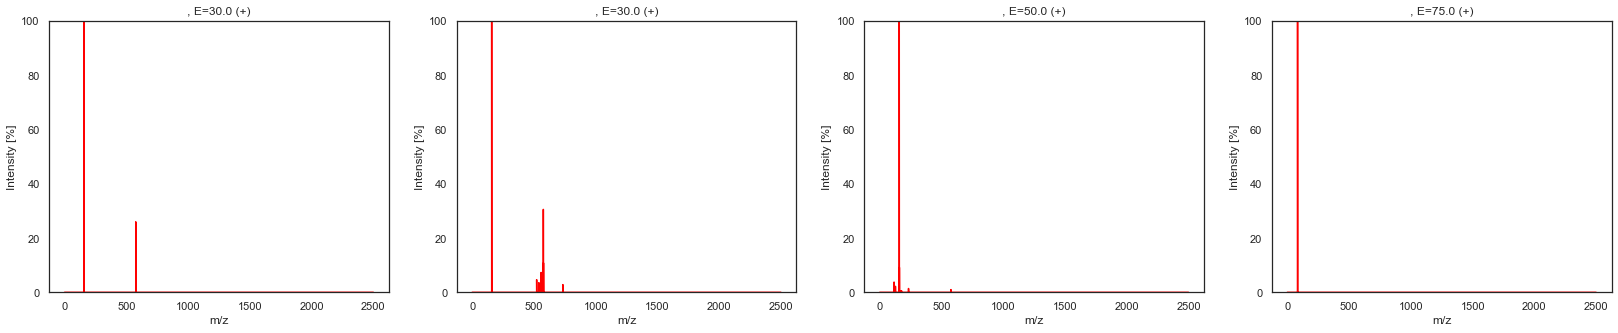

O=C(O)C(N)CCCNC(=N)O
(3, 32)


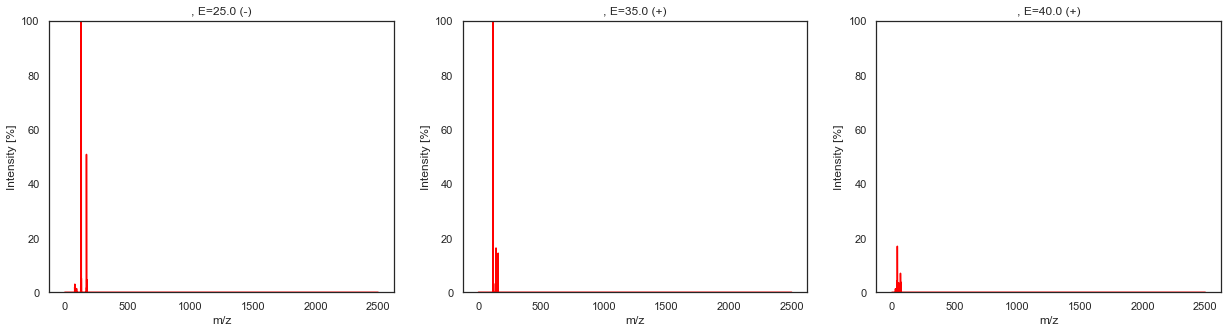

O=C1C(O)=C(OC=2C=C(O)C=C(O)C12)C=3C=CC(O)=CC3
(4, 32)


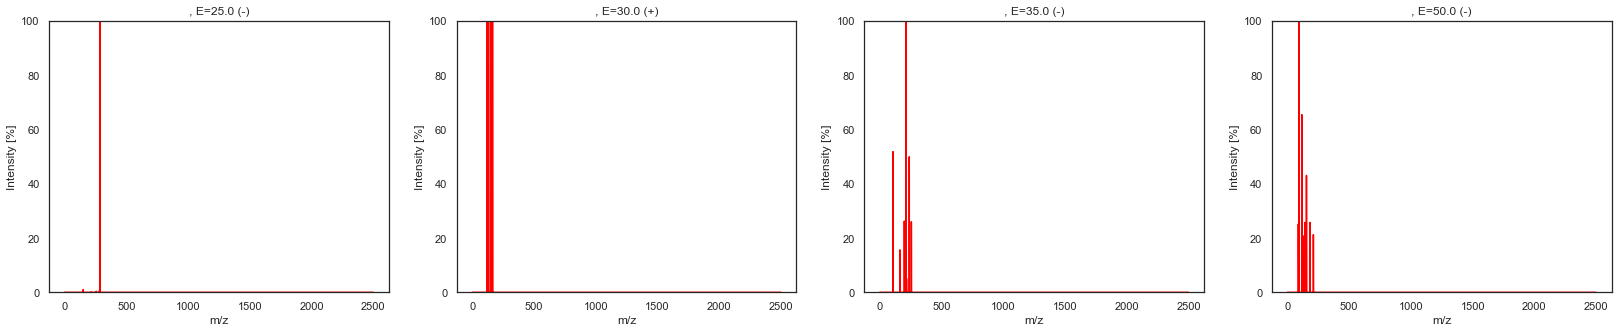

CN(C)CCC1=CC=C(C=C1)O
(3, 32)


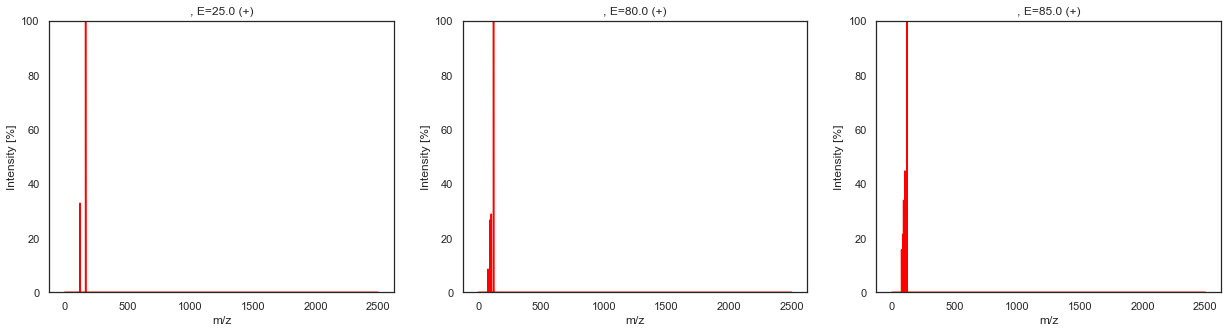

C1=CC(=CC=C1C2=COC3=C(C(=CC(=C3)O)O)C2=O)O
(7, 32)


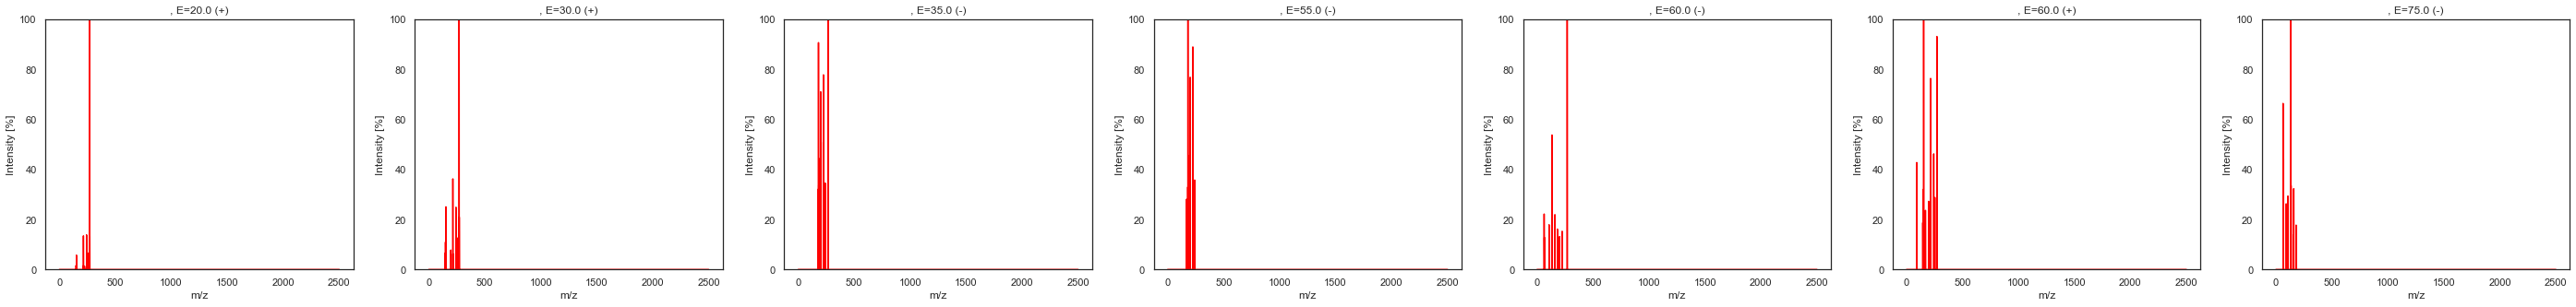

O=C(O)C(N=C(O)CC1=CNC=2C=CC=CC21)CC3=CNC=4C=CC=CC43
(4, 32)


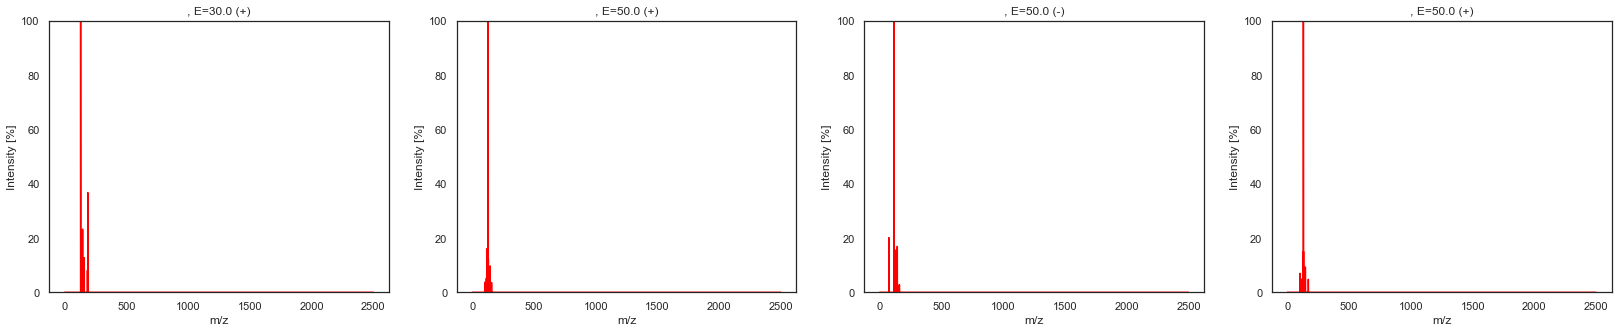

C=C(C(=O)O)OP(=O)(O)O
(3, 32)


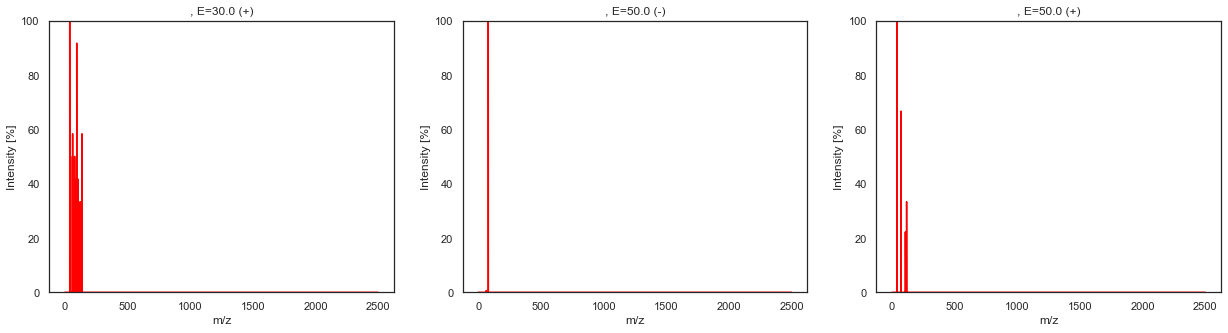

CC(C)N(C1=CC=C(C=C1)F)C(=O)CS(=O)(=O)O
(5, 32)


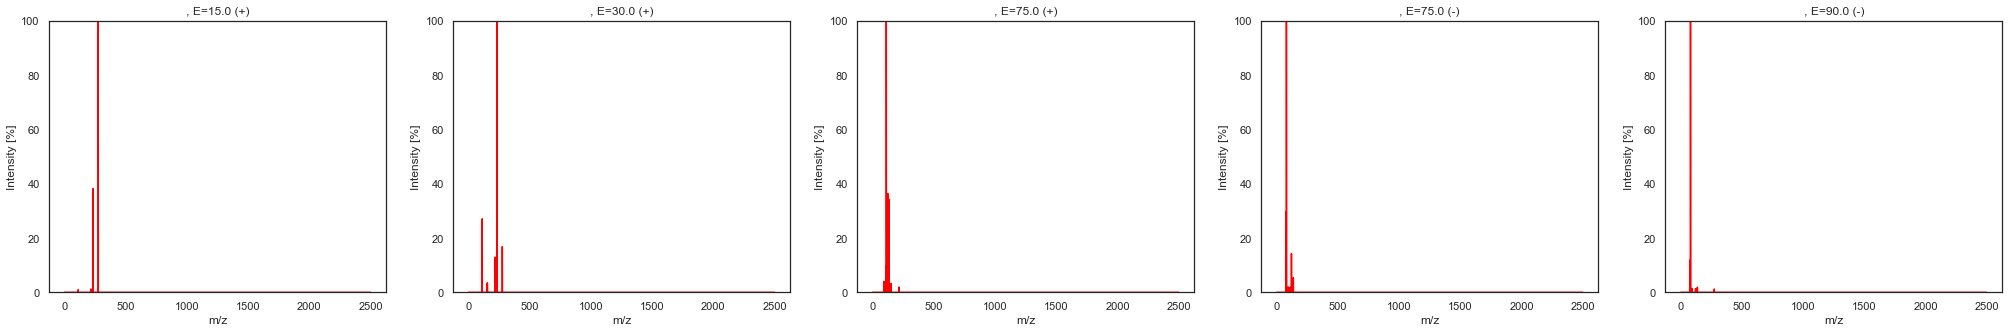

C1=C(C=CC(=C1)N2C=C(C(=O)C3=C2C=C(C(=C3)F)N4CCNCC4)C(=O)O)F
(3, 32)


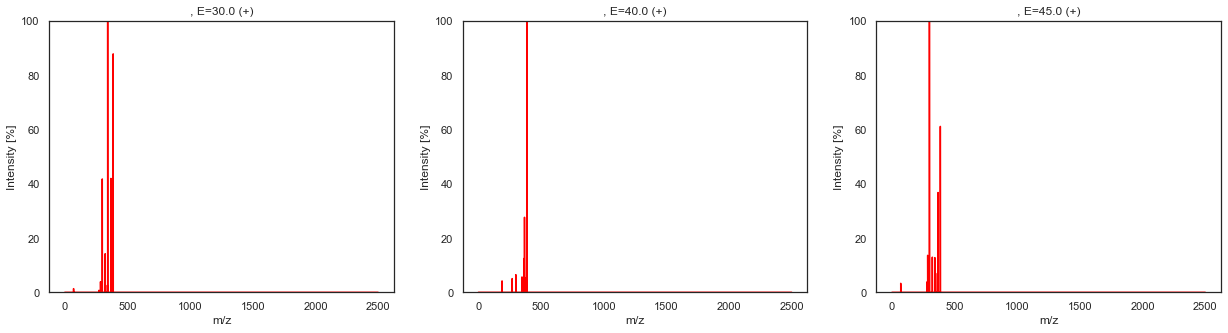

O=C1C(O)=C(OC=2C=C(O)C=C(O)C12)C=3C=CC(OC)=CC3
(4, 32)


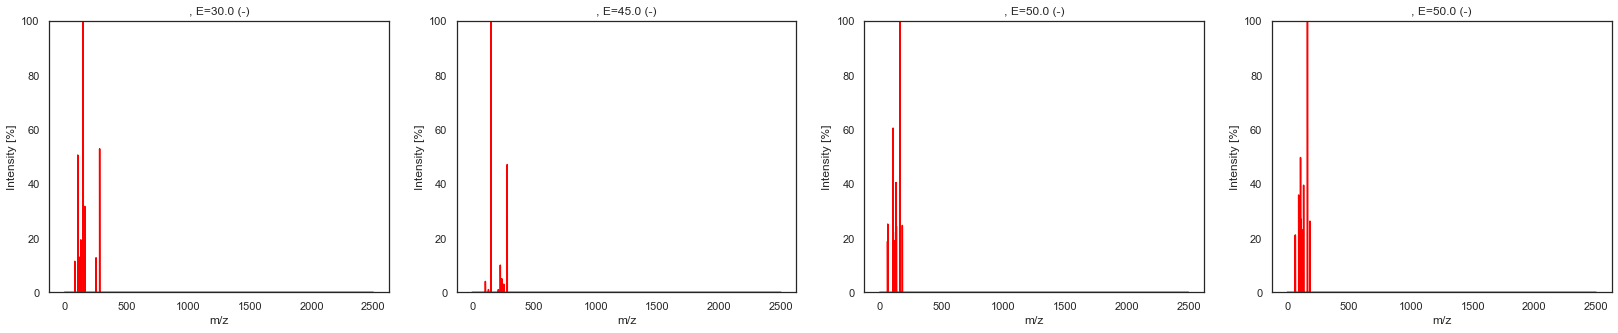

CCN(CC)CC(=NC1=C(C)C=CC=C1C)O
(4, 32)


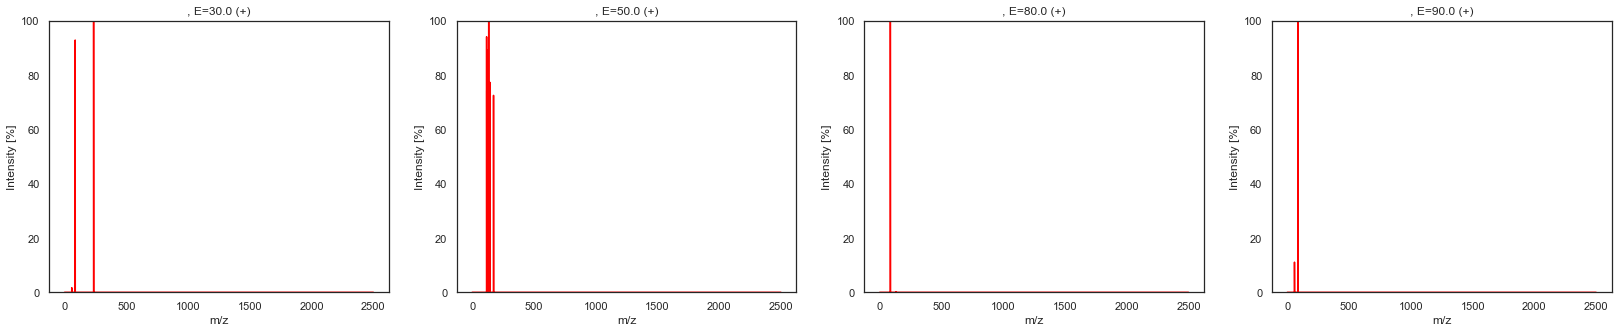

O=C1C(O)=C(OC2=CC(OC3OC(CO)C(O)C(O)C3OC4OC(C)C(O)C(O)C4O)=CC(O)=C12)C=5C=CC(O)=CC5
(5, 32)


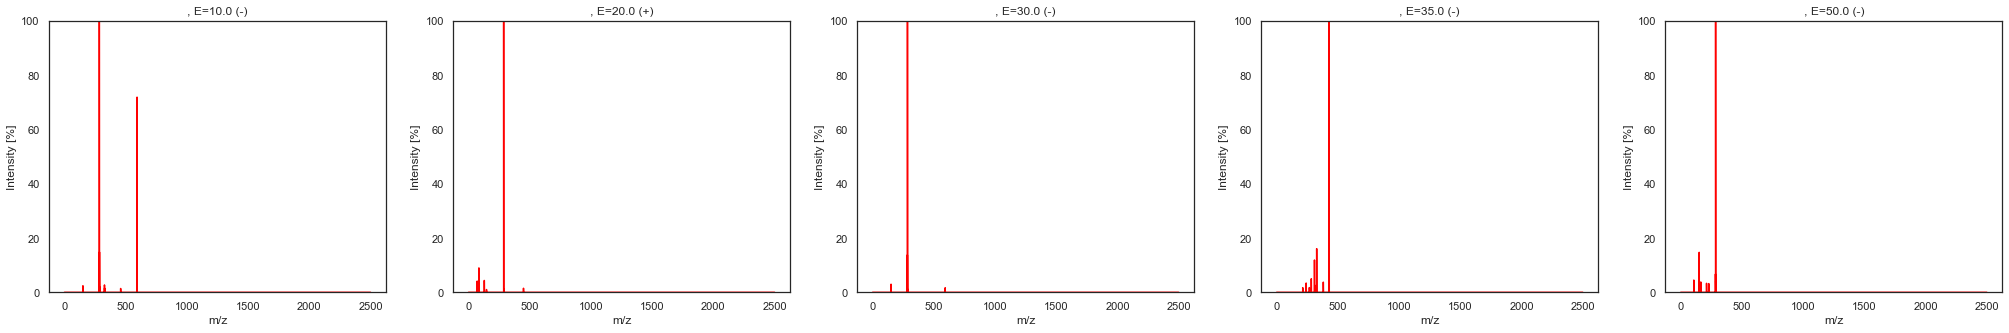

O=C(O)C1OC(OC=2C(=O)C=3C(O)=CC(O)=CC3OC2C=4C=CC(O)=CC4)C(O)C(O)C1O
(6, 32)


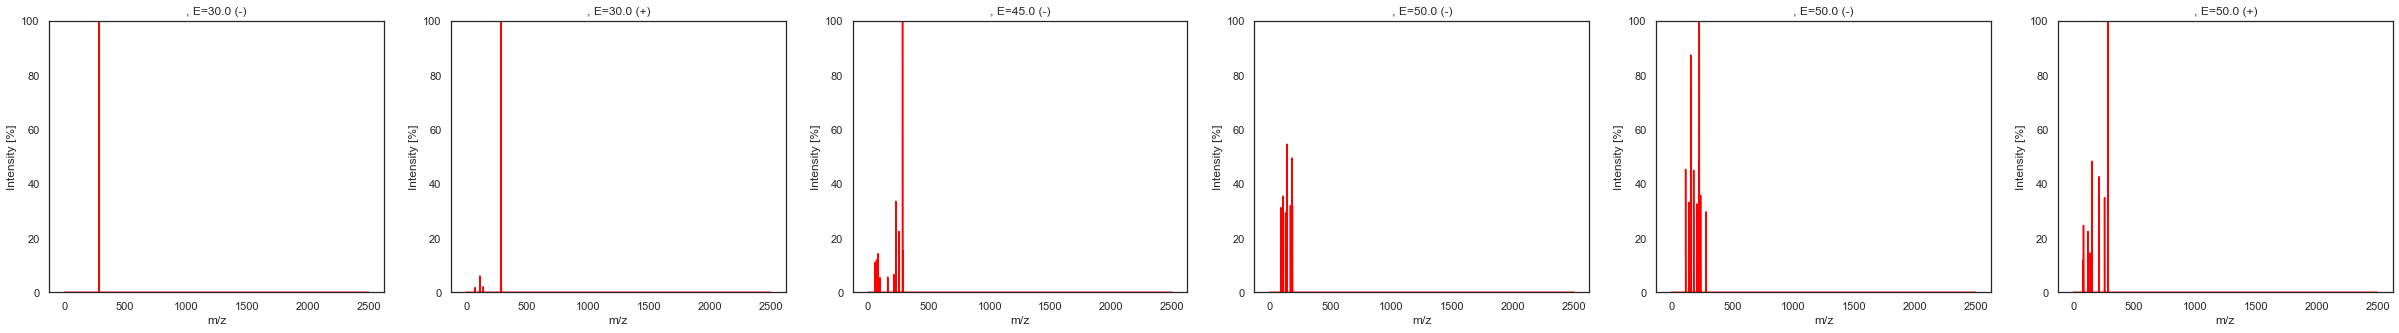

CN(C)CCN(CC1=CC=C(C=C1)OC)C2=NC=CC=C2
(4, 32)


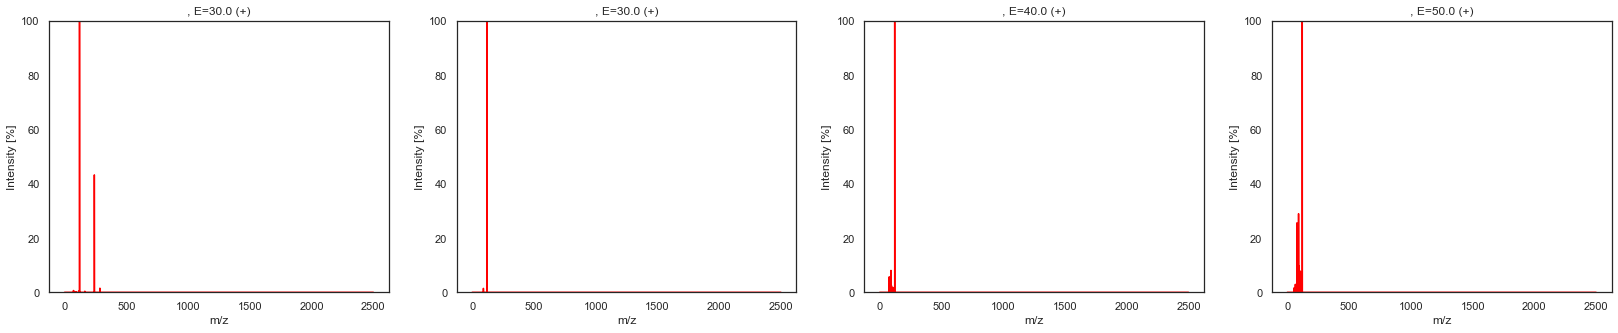

OCC1OC(OC2CCC3(C)C(CCC4(C)C3CC(O)C5C(CCC54C)C(OC6OC(CO)C(O)C(O)C6O)(C)CCC=C(C)C)C2(C)C)C(O)C(O)C1O
(3, 32)


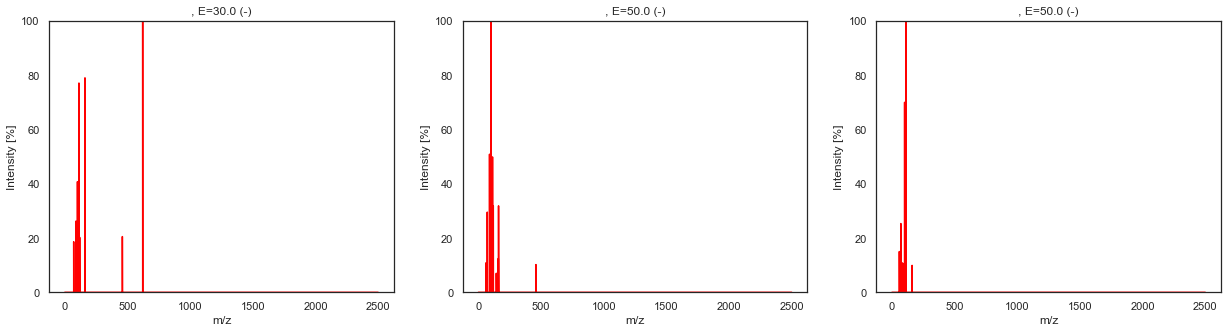

O=C1C(=COC=2C=C(O)C=C(O)C12)C=3C=CC(OC)=CC3
(6, 32)


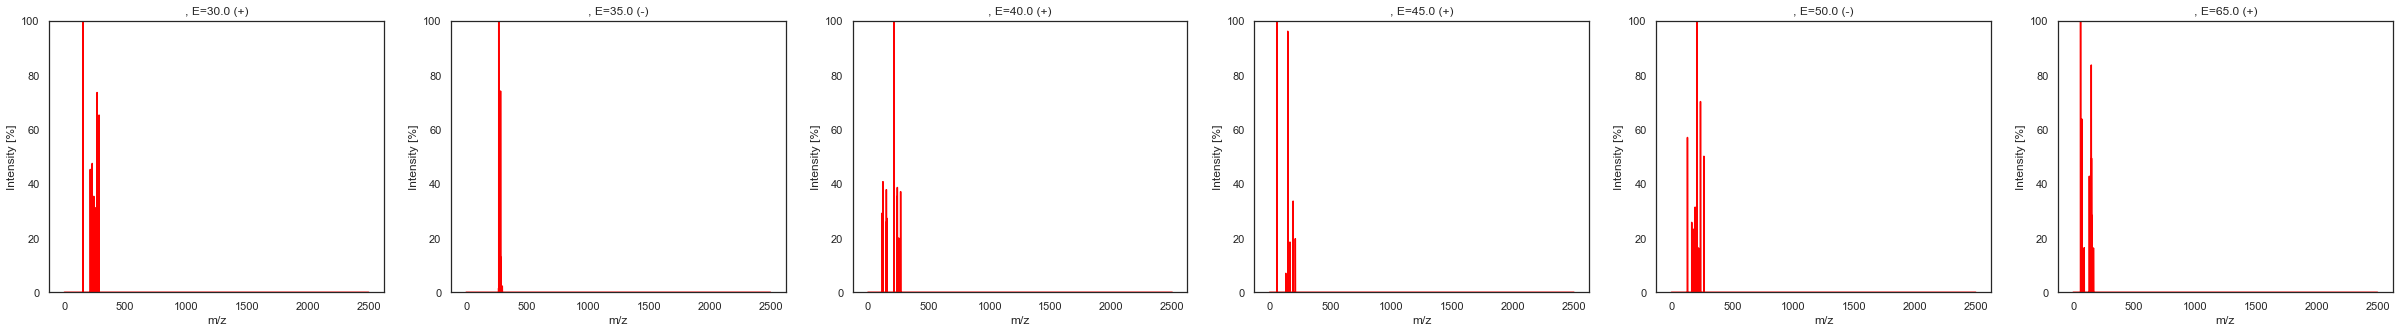

OCC1OC(OC2C(O)C(OC(C)C2O)OC3CCC4(C)C5C=CC67OCC8(CCC(C)(C)CC68)C(O)CC7(C)C5(C)CCC4C3(C)CO)C(O)C(O)C1O
(6, 32)


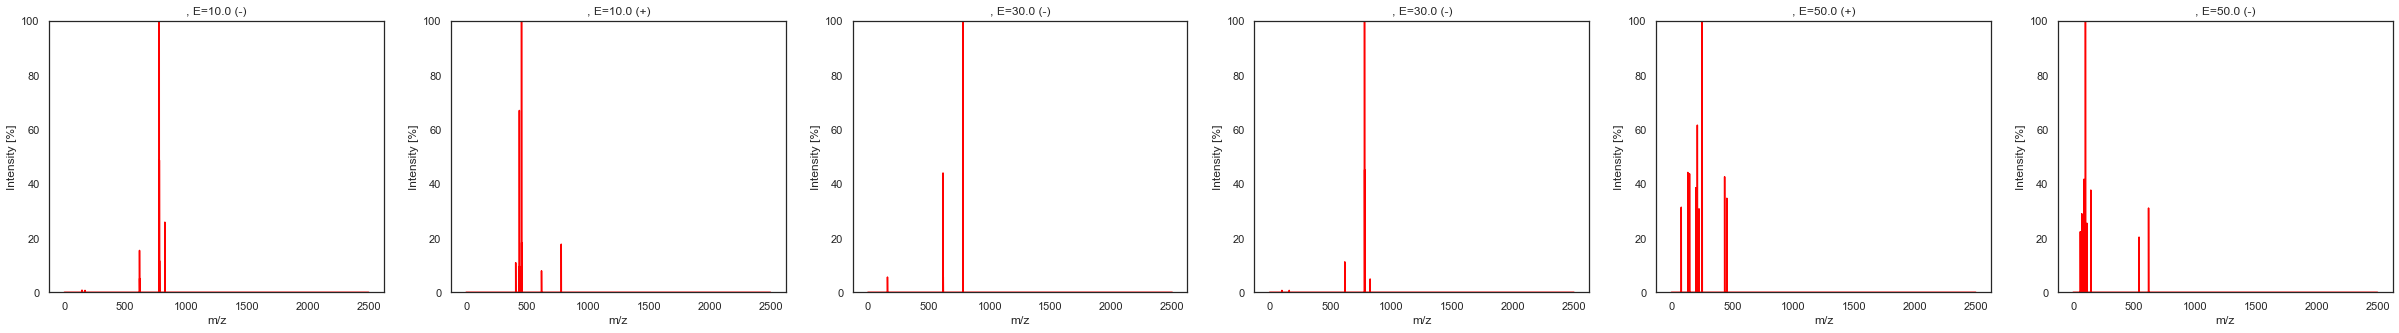

O=C(O)C1N(C(=O)C(C)CS)CCC1
(3, 32)


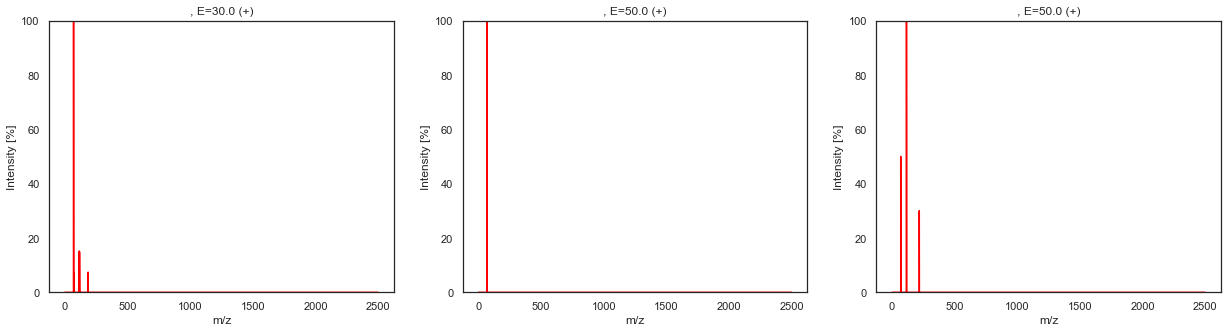

O=C1C(OC2OCC(O)C(O)C2O)=C(OC=3C=C(O)C=C(O)C13)C=4C=CC(O)=CC4
(4, 32)


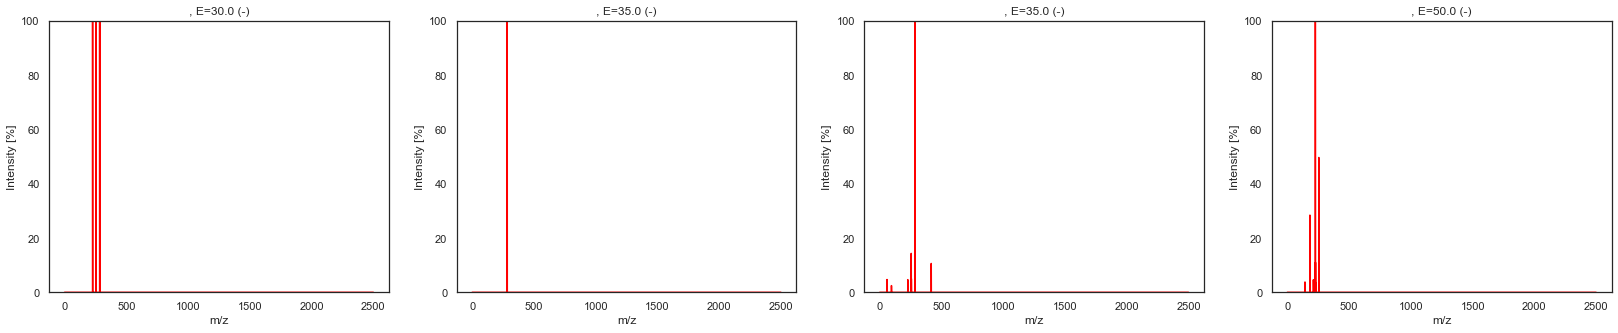

CC(C1CC1)C(CN2C=NC=N2)(C3=CC=C(C=C3)Cl)O
(3, 32)


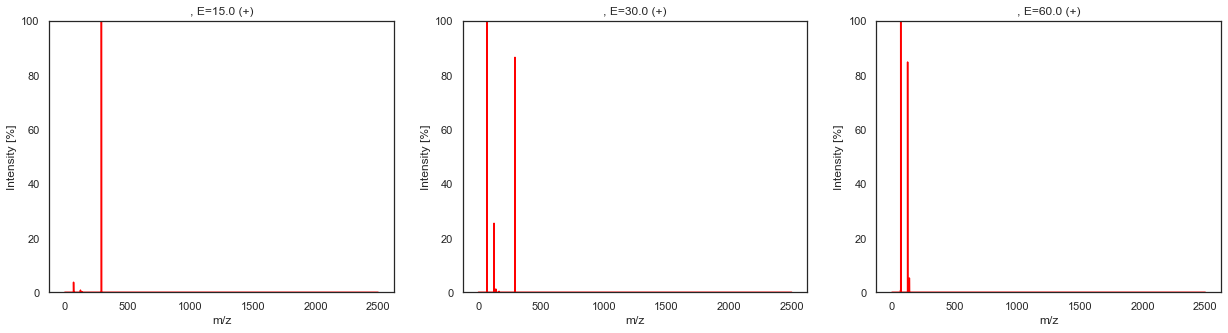

C1=CC(=CC=C1C2=C(C(=O)C3=C(C=C(C=C3O)O)O2)O)O
(5, 32)


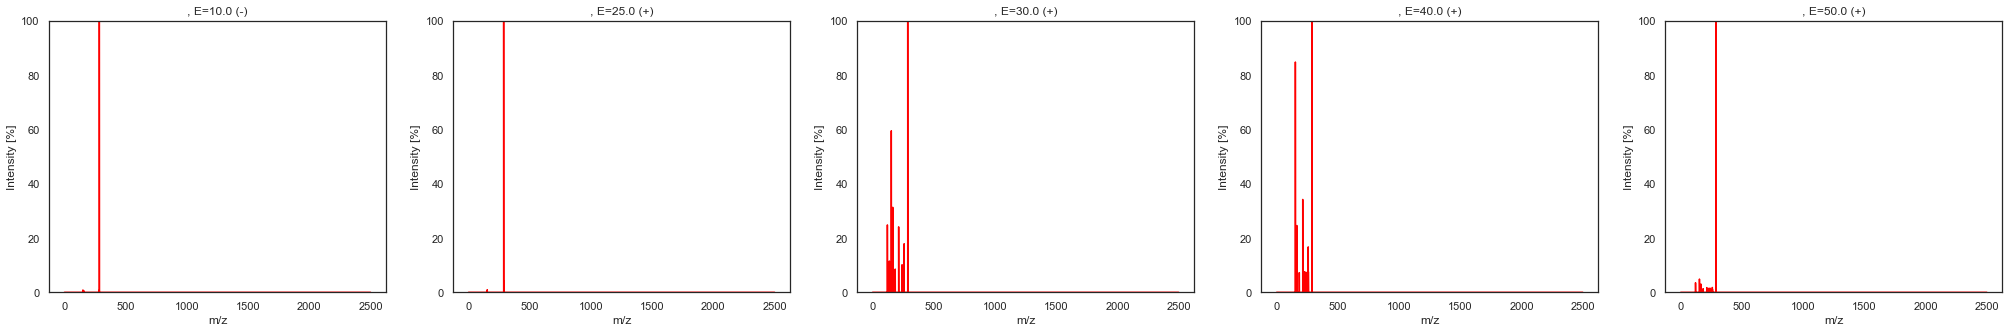

O=C1C=C2C(=CC1=NNC(=N)O)CC(N2C)S(=O)(=O)O
(3, 32)


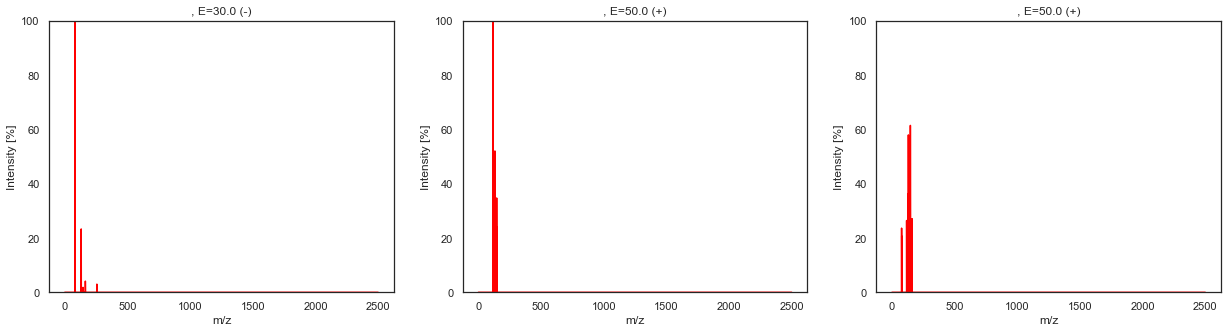

CCC1=C(C(=CC=C1)C)N(COCC)C(=O)C(=O)O
(4, 32)


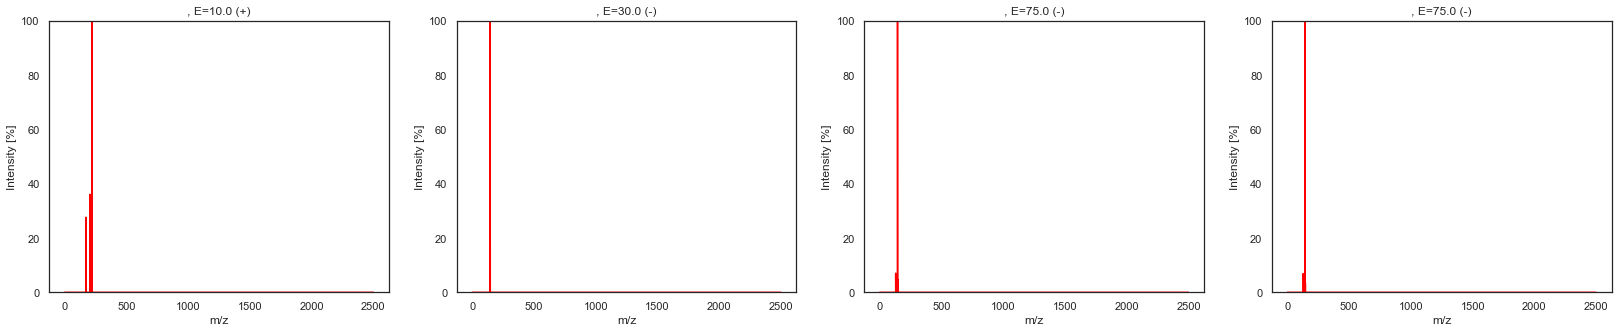

CN(S(=O)(=O)C)S(=O)(=O)NC(=NC1=NC(=CC(=N1)OC)OC)O
(3, 32)


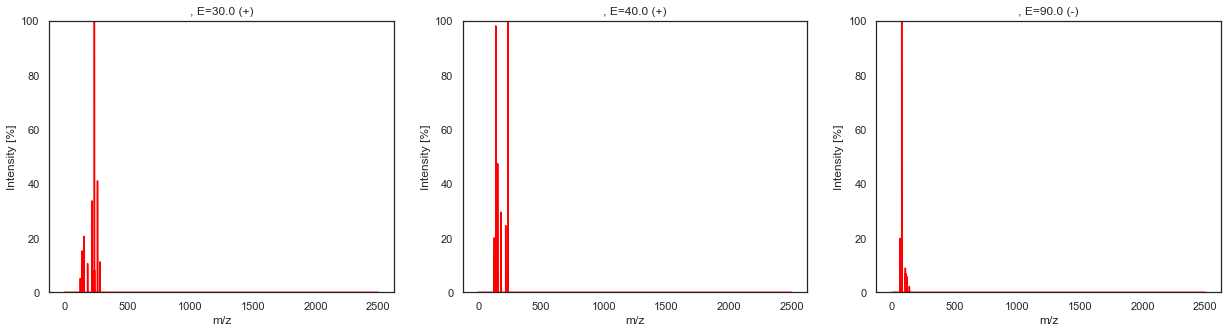

C/C=C\1/C[C@]2(CO)[C@](C)(C(=O)OCC3=CCN4(=O)CC[C@H]([C@@H]34)OC1=O)O2
(4, 32)


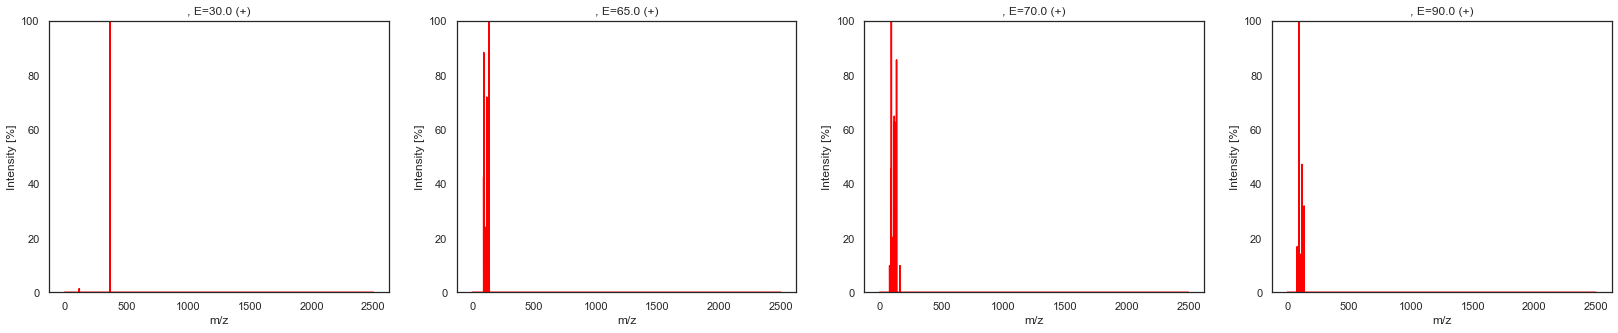

CC1=CSC(=C1N(C(C)COC)C(=O)C(=O)O)C
(5, 32)


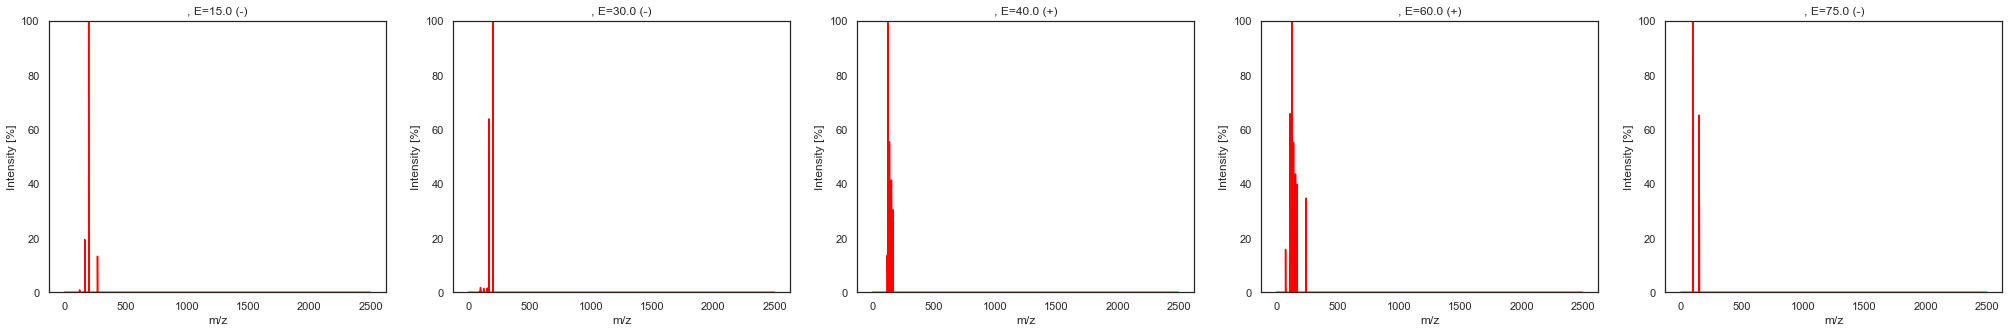

C1=CC2=C(C=C1)NC=C2C[C@@H](C(=O)O)N
(4, 32)


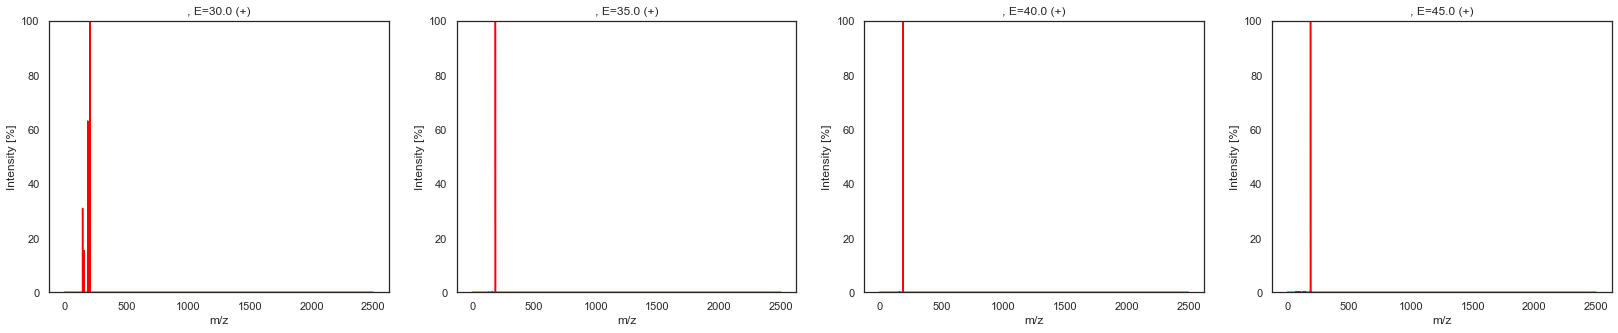

C[C@@]12CCC(=O)C=C2CC[C@H]3[C@@H]4CC[C@](C(=O)CO)([C@@]4(C)CC(=O)[C@@H]31)O
(4, 32)


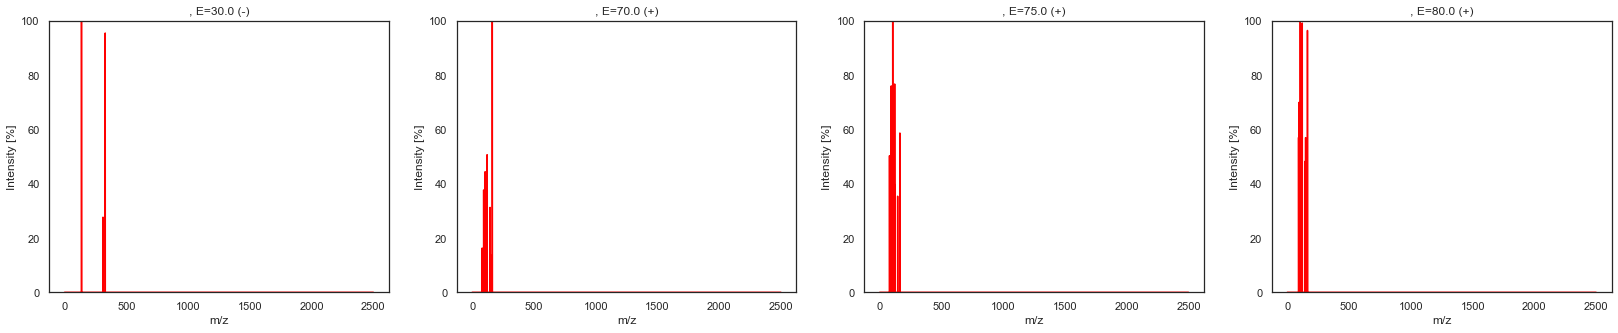

O=C(OC1OCC(O)C(O)C1O)C23CCC(C)(C)CC3C4=CCC5C6(C)CCC(OC7OC(COC8OC(C)C(O)C(OC9OCC(O)C(OC%10OC(C)C(O)C(OC%11OC(C)C(O)C(O)C%11O)C%10O)C9O)C8O)C(O)C(O)C7N=C(O)C)C(C)(C)C6CCC5(C)C4(C)CC2
(4, 32)


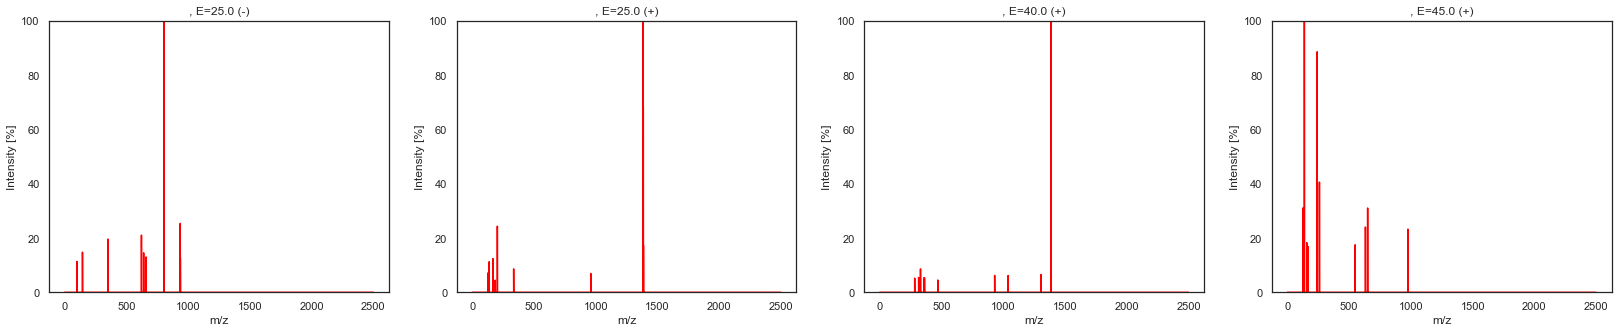

C[C@H]1CC=C[C@H]2[C@H]3[C@@](C)([C@@H](C)[C@H]4[C@H](CC5=CNC6=C5C=CC=C6)N=C([C@@]24C(=O)C=CC(=O)[C@@H](C(=C1)C)O)O)O3
(3, 32)


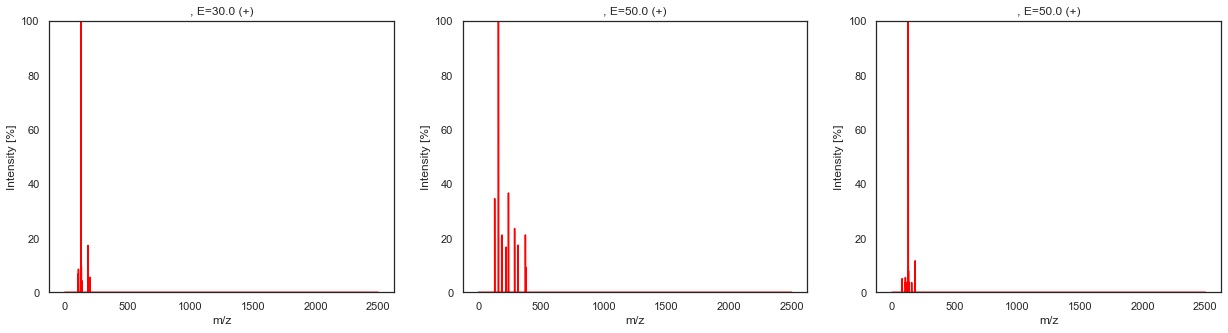

O=C(OC1OC(COC2OC(CO)C(OC3OC(C)C(O)C(O)C3O)C(O)C2O)C(O)C(O)C1O)C45CCC(C)C(C)C5C6=CCC7C8(C)CC(O)C(O)C(C)(CO)C8C(O)CC7(C)C6(C)CC4
(3, 32)


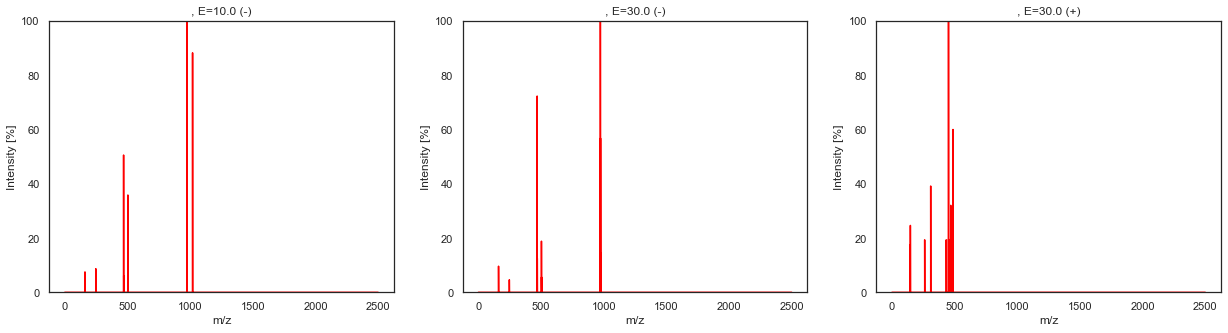

O=C(OC1C2C3(OC(=O)C)COC3CC(O)C2(C(=O)C(OC(=O)C)C4=C(C)C(O)CC1(O)C4(C)C)C)C=5C=CC=CC5
(3, 32)


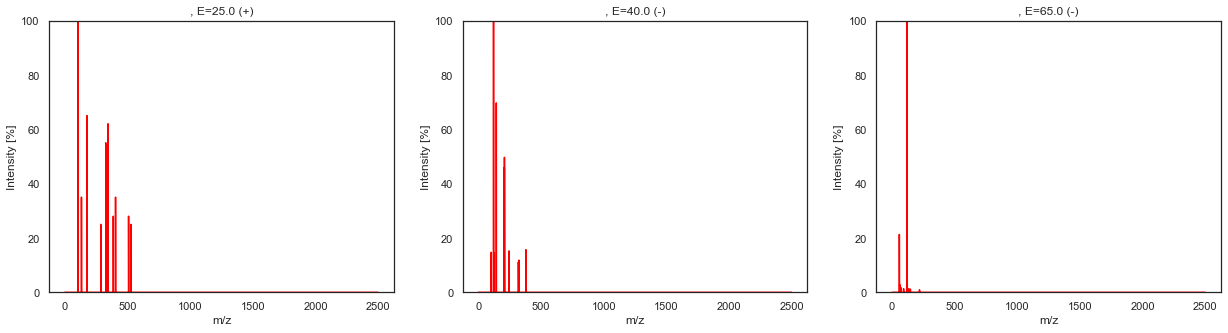

CN(C)CC/C=C\1/C2=C(C=CC=C2)COC3=CC=C(C=C13)CC(=O)O
(3, 32)


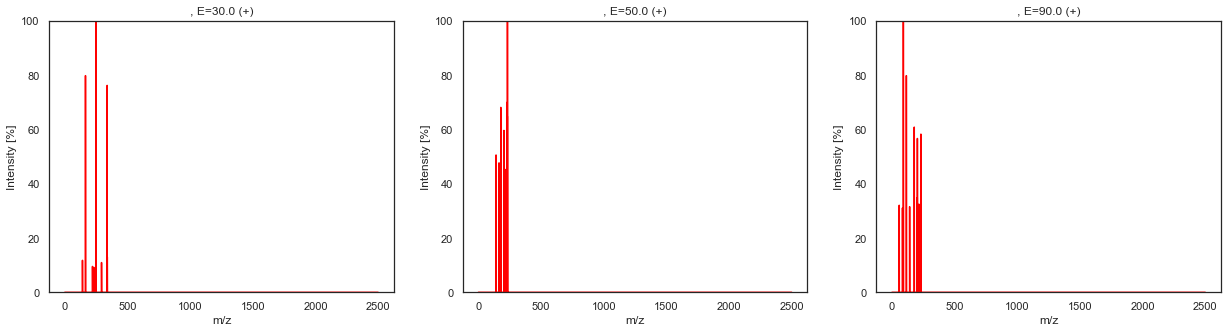

CC1(C2=CC=CC(=C2C(=C3C1C(C4C(C(=O)C(=C(C4(C3=O)O)O)C(=N)O)N(C)C)O)O)O)O
(3, 32)


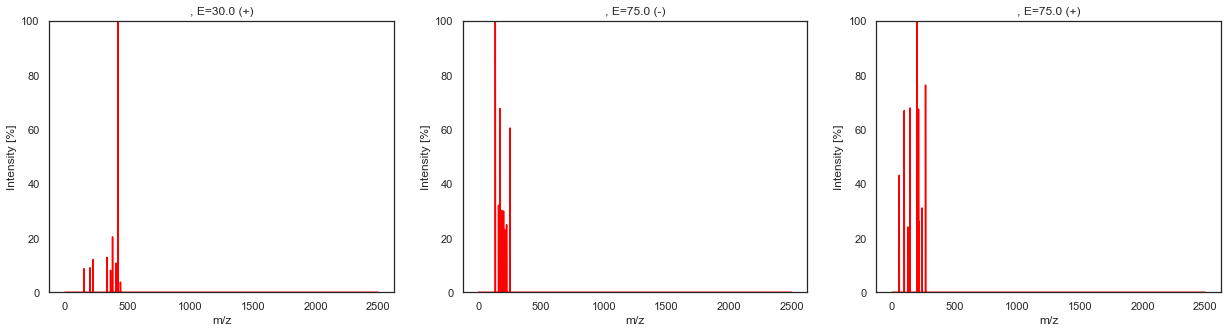

C1=C(C=CC(=C1)Cl)C(=O)NCCN2CCOCC2
(4, 32)


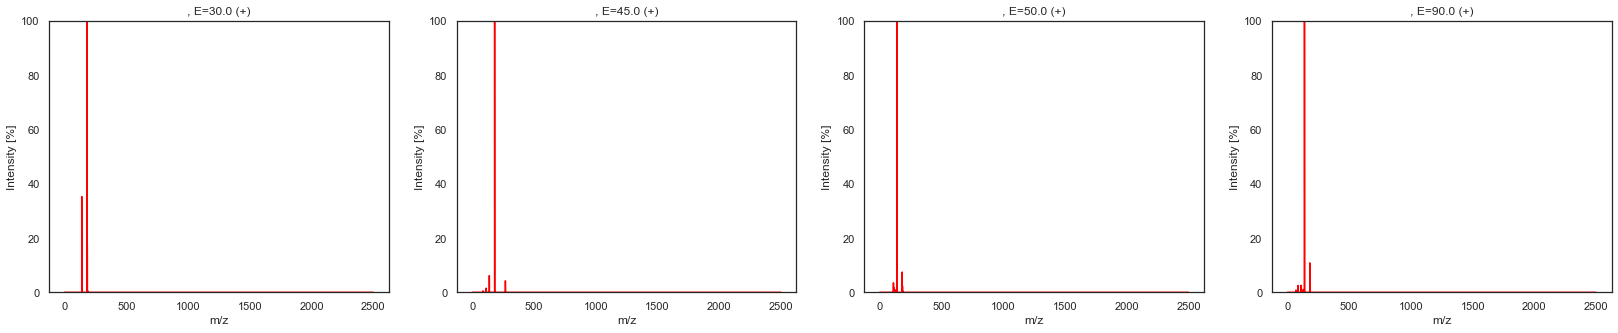

OCC1OC(OCC2OC(O)C(O)C(O)C2O)C(O)C(O)C1O
(3, 32)


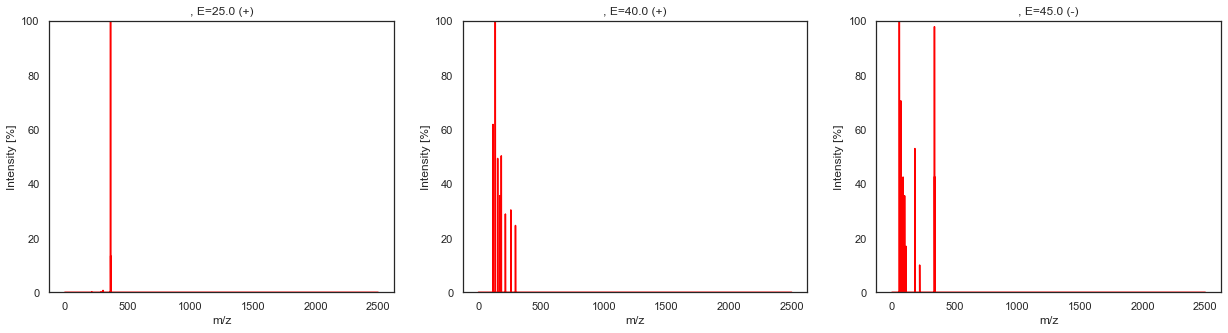

COC1=CC2=C(C=C1)C3=C([C@H]4C[C@H]5[C@H](C[C@H]([C@@H]([C@H]5C(=O)OC)OC)OC(=O)C6=CC(=C(C(=C6)OC)OC)OC)CN4CC3)N2
(4, 32)


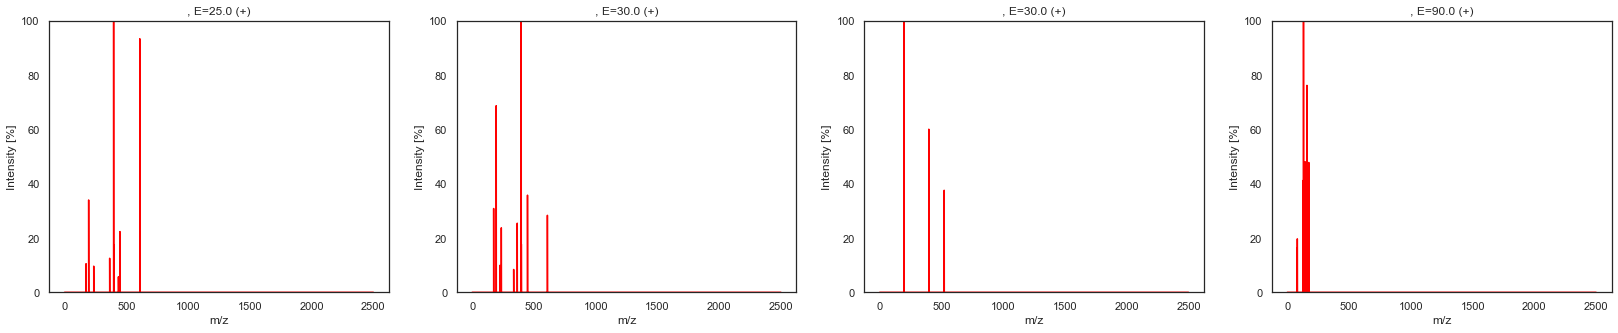

CN1C=NC2=C1C(=O)N(C)C(=O)N2C
(5, 32)


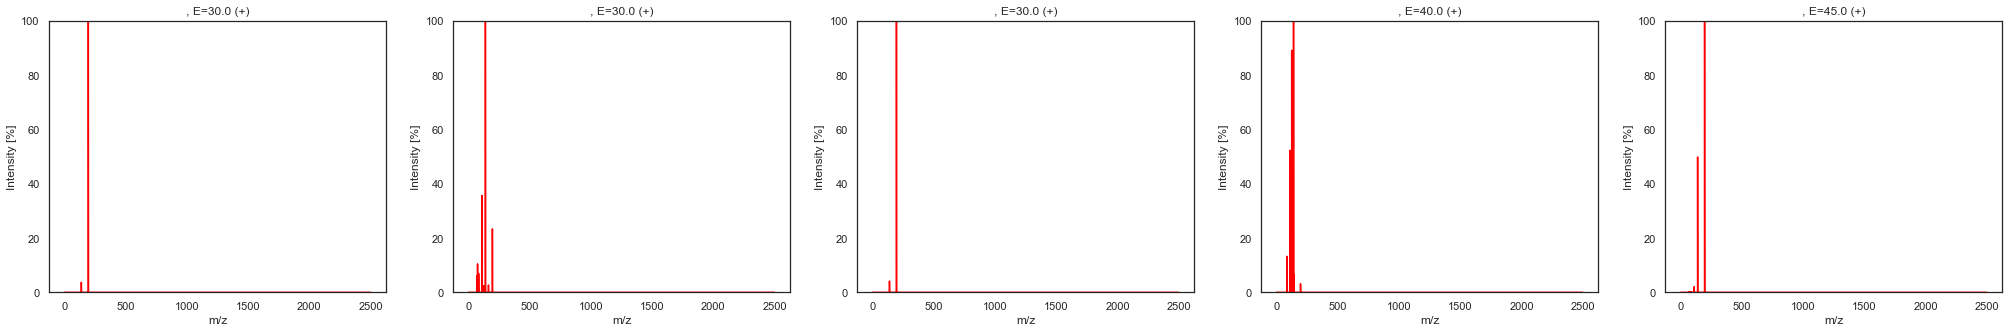

O=C(O)C1OC(OC2CCC3(C)C(CCC4(C)C3CC=C5C6CC(C)(C)CC(O)C6(C)CCC54C)C2(C)CO)C(OC7OC(CO)C(O)C(O)C7OC8OC(C)C(O)C(O)C8O)C(O)C1O
(4, 32)


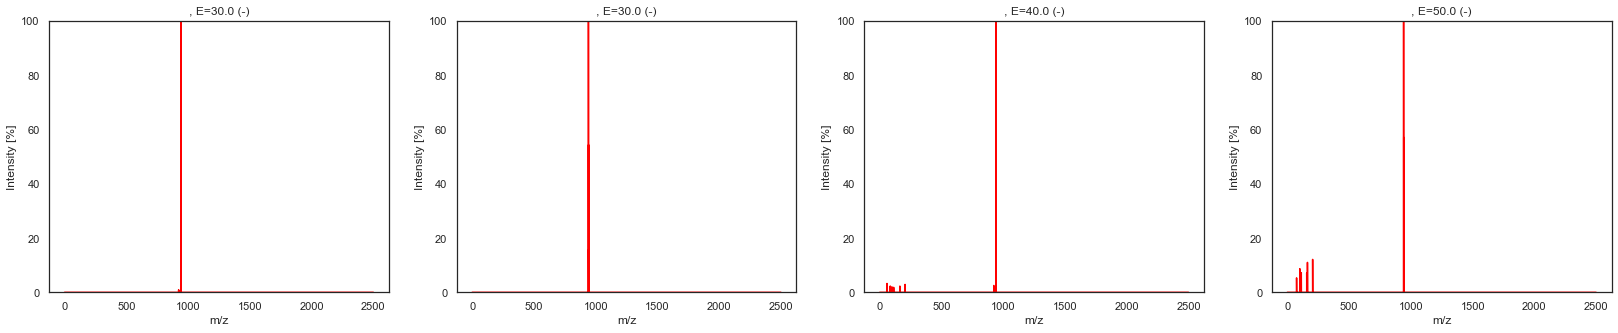

COP(=S)(OC)SCN1C(=O)C2=C(C=CC=C2)N=N1
(3, 32)


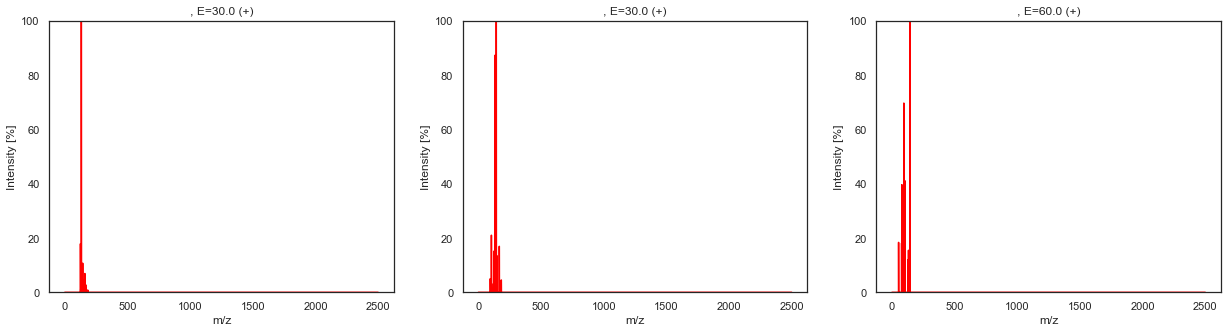

CCCCCCCCN1C(=O)C=CS1
(3, 32)


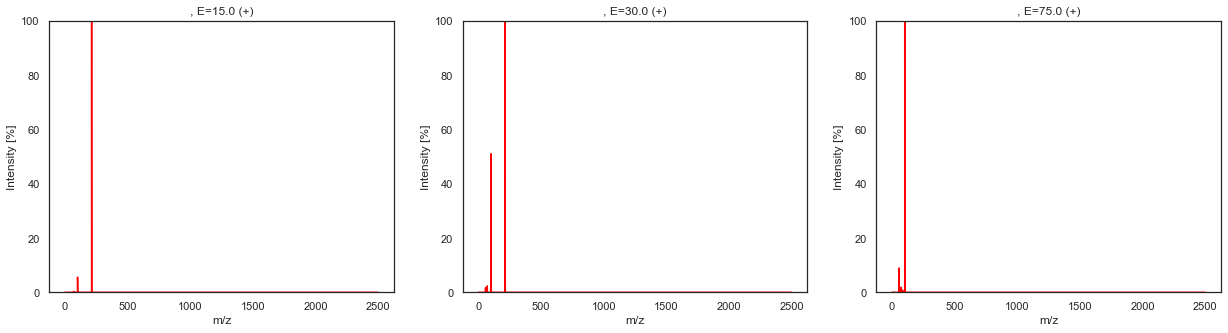

O=C1C=C(OC2=CC(OC3OC(COC4OC(C)C(O)C(O)C4O)C(O)C(O)C3O)=CC(O)=C12)C=5C=CC(OC)=CC5
(4, 32)


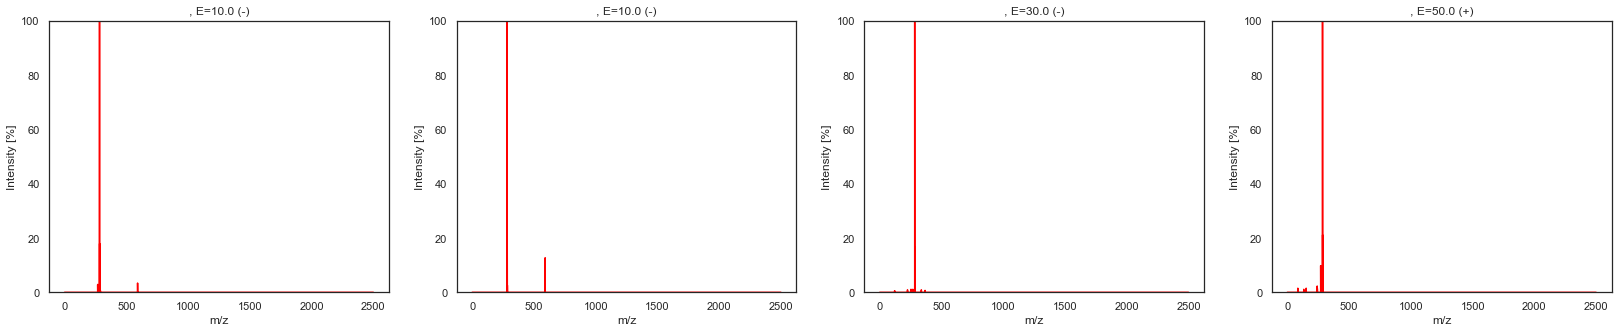

OCC1OC(OCC2OC(OC3CCC4(C)C5C=CC6=C7CC(C)(C)CCC7(CO)C(O)CC6(C)C5(C)CCC4C3(C)C)C(O)C(O)C2OC8OC(C)C(O)C(O)C8O)C(O)C(O)C1O
(3, 32)


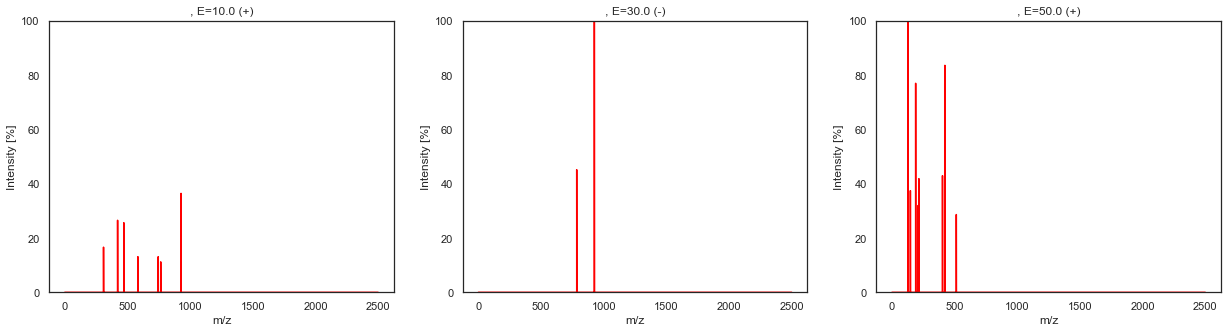

CCCCC/C=C\C=C\C(CCCCCCCC(=O)O)O
(3, 32)


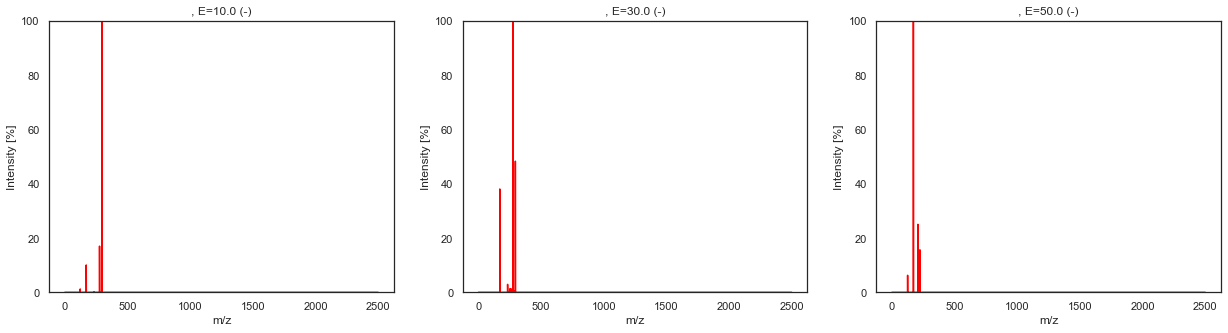

O=C(OC1=CC=C(C=C1)C=CC=2C=C(OC(=O)C)C=C(OC(=O)C)C2)C
(3, 32)


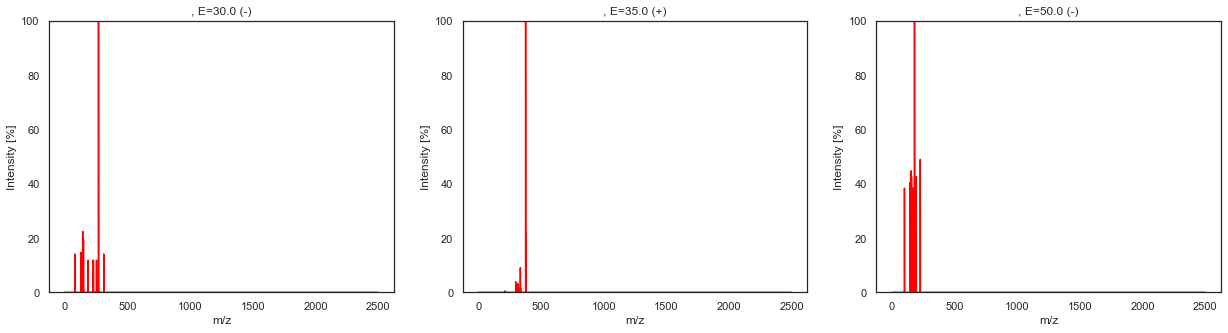

CN=C1CN(C(=C2C=C(C=CC2=N1)Cl)C3=CC=CC=C3)O
(3, 32)


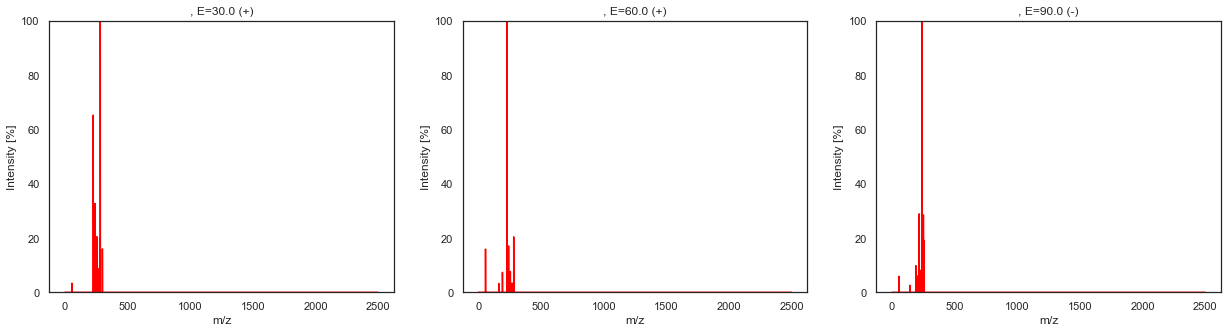

OC=1C=C(O)C=2C=C(OC3OC(COC4OC(C)C(O)C(O)C4O)C(O)C(O)C3OC5OC(CO)C(O)C(O)C5O)C(=[O+]C2C1)C=6C=CC(O)=C(O)C6
(4, 32)


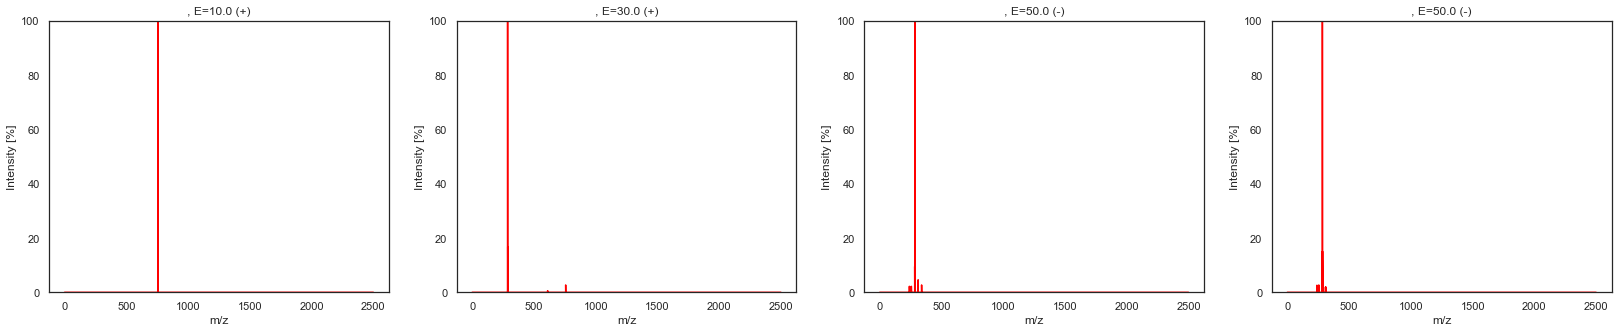

O=C1C(OC2OC(COC3OC(C)C(O)C(O)C3O)C(O)C(O)C2O)=C(OC=4C=C(O)C=C(O)C14)C=5C=CC(O)=C(OC)C5
(3, 32)


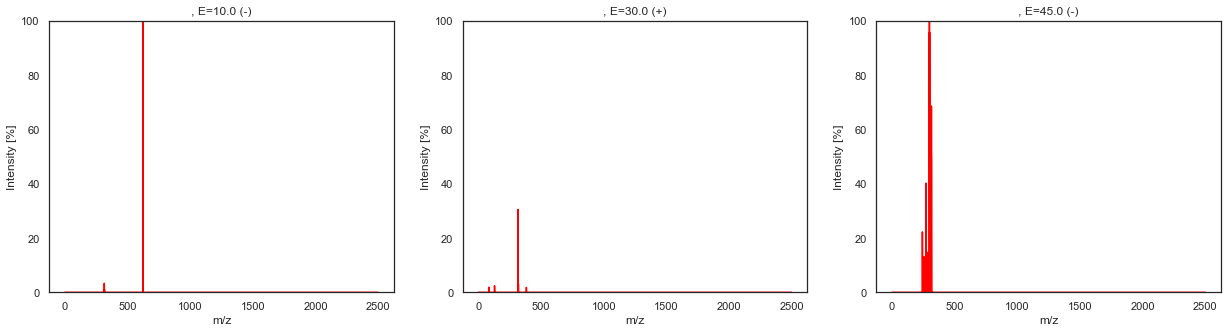

C/C=C(/C)\C(=O)O[C@@H]1CCN2CC=C(COC(=O)[C@@]([C@H](C)O)(C(C)(C)O)O)[C@H]12
(3, 32)


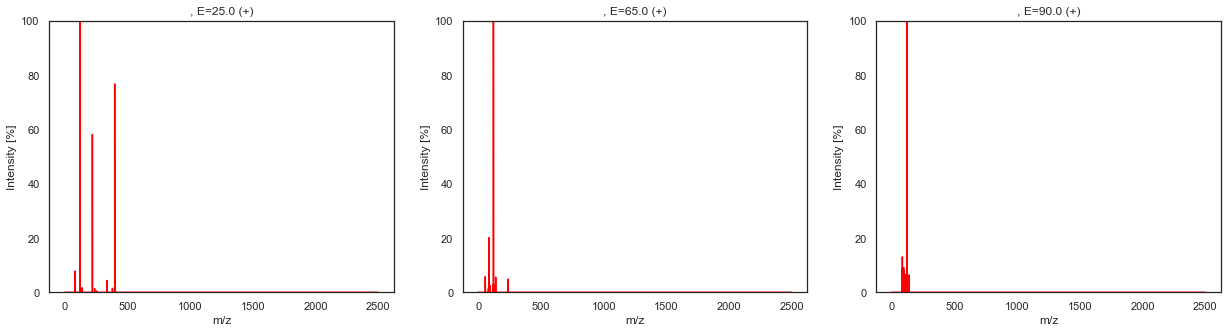

CC(=NCCCS(=O)(=O)O)O
(3, 32)


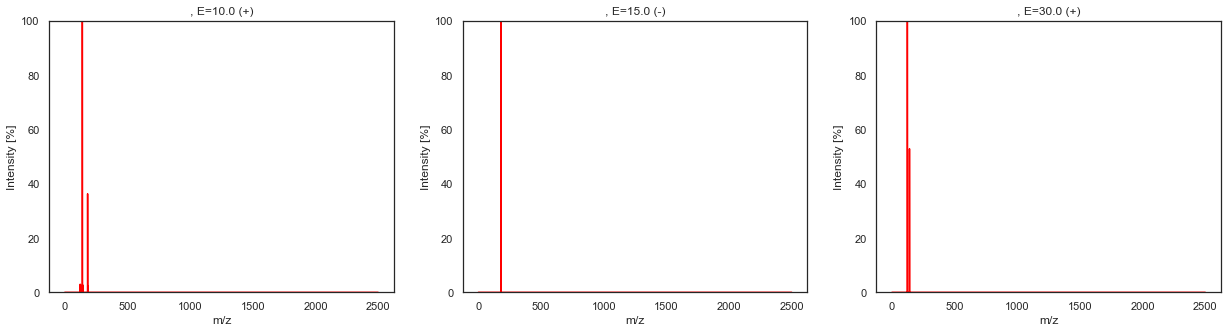

CN(C)C(=NC1=CC=C(C(=C1)Cl)Cl)O
(9, 32)


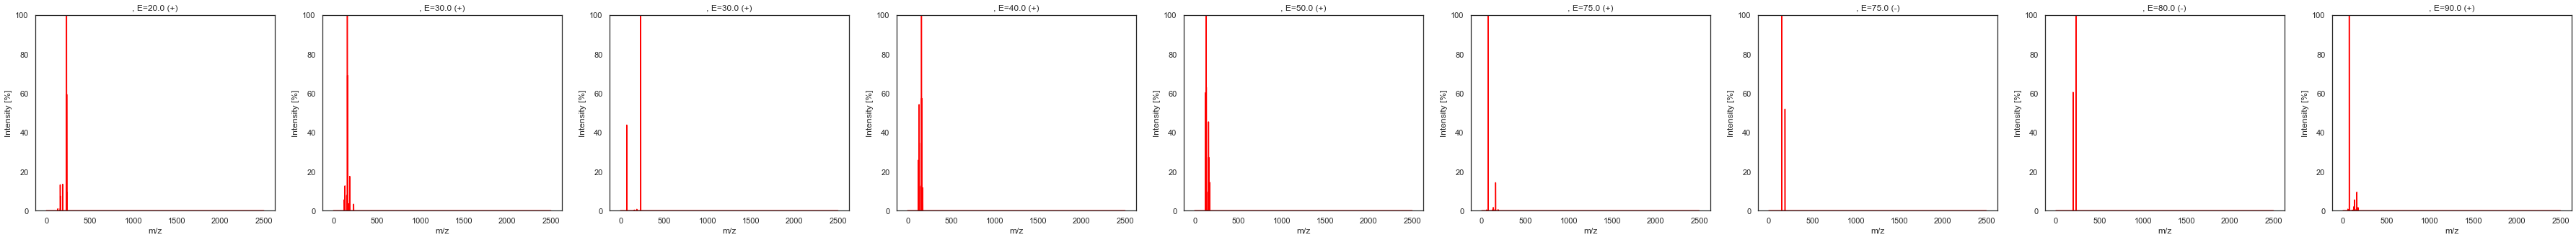

C1=NC(=NC(=C1F)O)O
(3, 32)


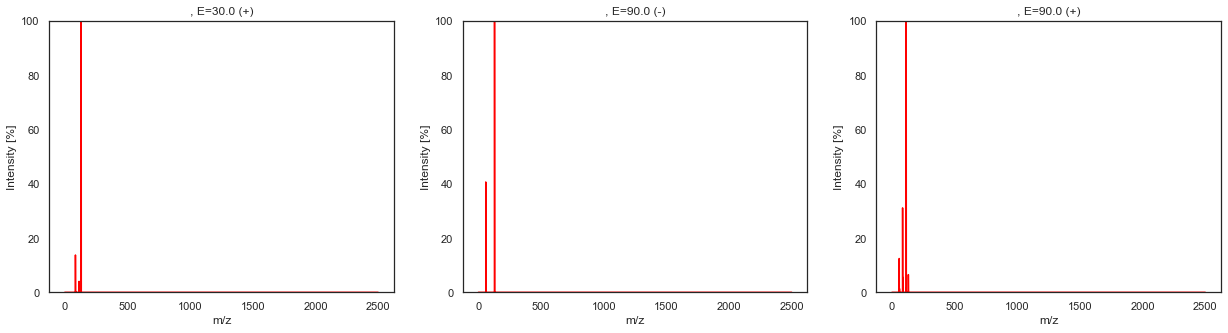

OC=1C=C(O)C2=C(OC(C3=CC=C(O)C(O)=C3)C(O)C2)C1
(9, 32)


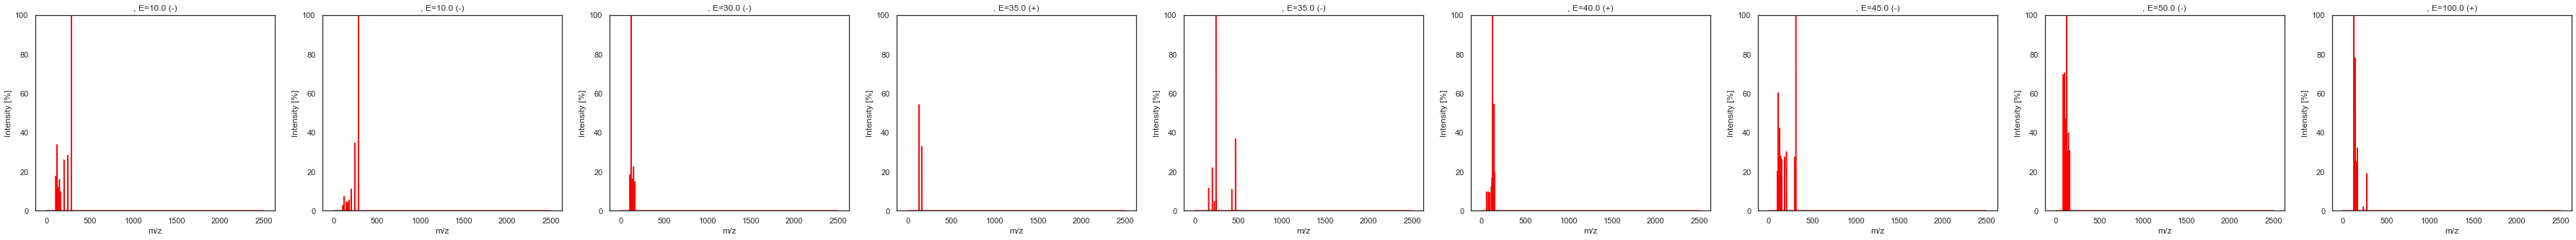

CC1=C(CCO)C(=C2C(=C1)C[C@@](C)(CO)C2=O)C
(5, 32)


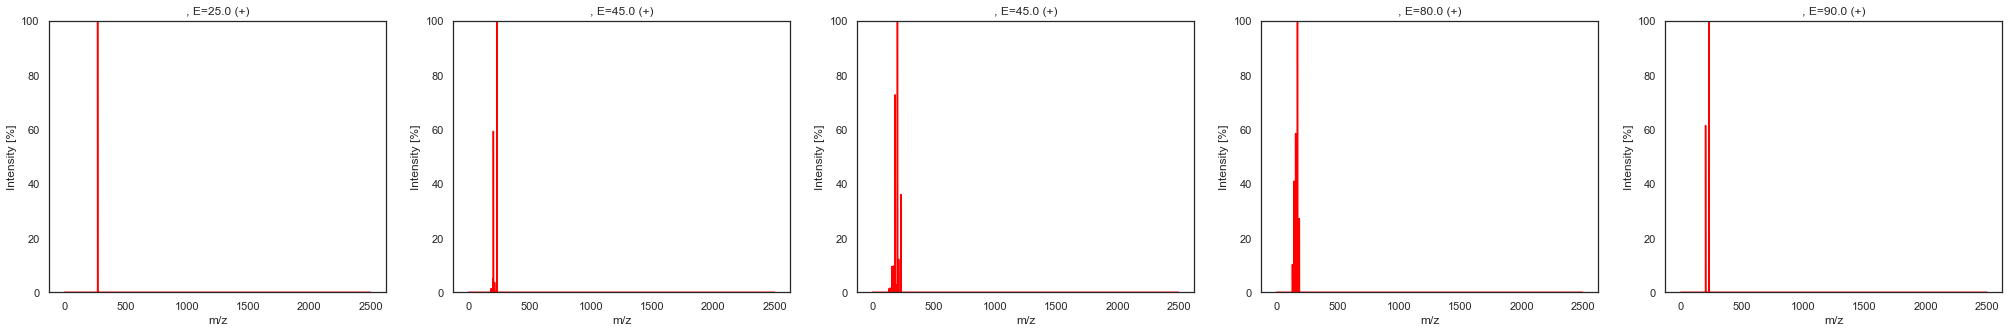

C1CN2C(=NN=C2C(F)(F)F)CN1C(=O)C[C@@H](CC3=C(C=C(C(=C3)F)F)F)N
(3, 32)


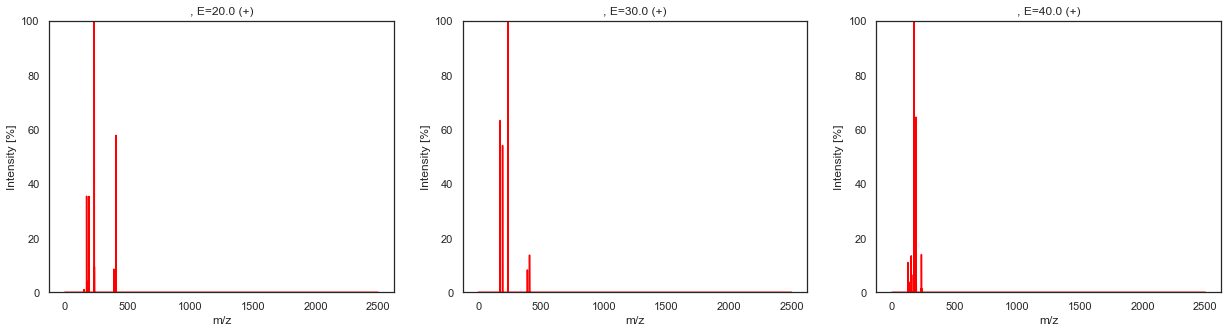

C1=CC(=CC2=C1C=CC(=O)O2)O
(3, 32)


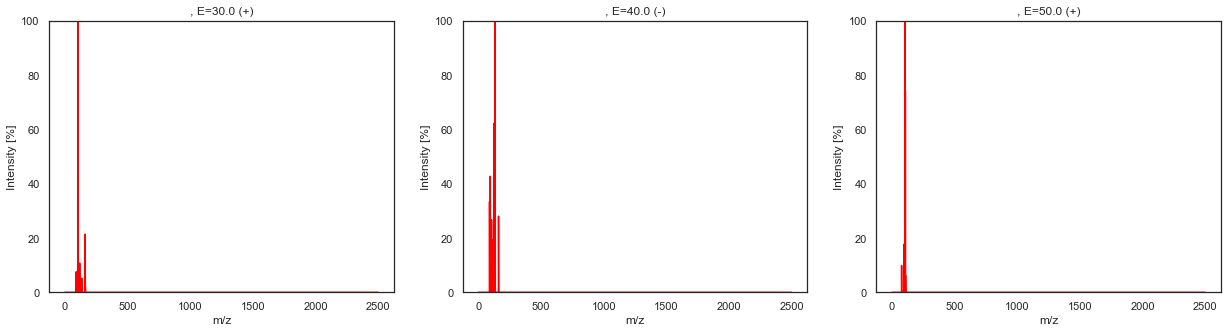

CC(C)(C(=O)O)OC1=CC=C(C=C1)Cl
(4, 32)


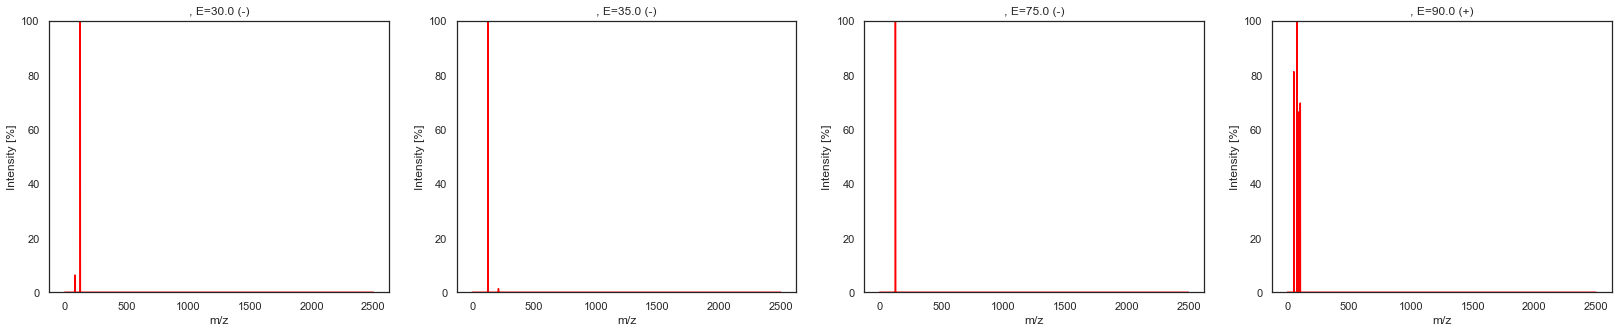

OCC1OC(OC2C(O)C(O)C(OC2OC3CCC4(C)C(CCC5(C)C4CC(O)C6C(CCC65C)C(O)(C)CCC=C(C)C)C3(C)C)CO)C(O)C(O)C1O
(6, 32)


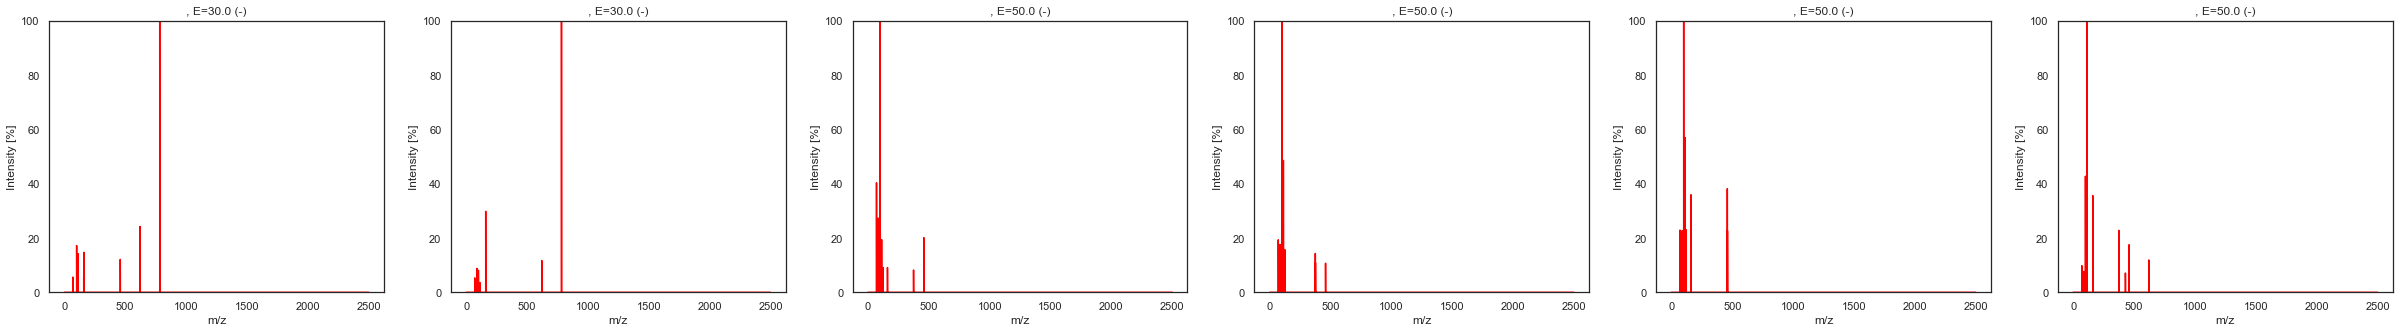

OC=1C=C(O)C2=C(OC(C3=CC=C(O)C(O)=C3)C(O)C2C=4C(O)=CC(O)=C5C4OC(C6=CC=C(O)C(O)=C6)C(O)C5)C1
(4, 32)


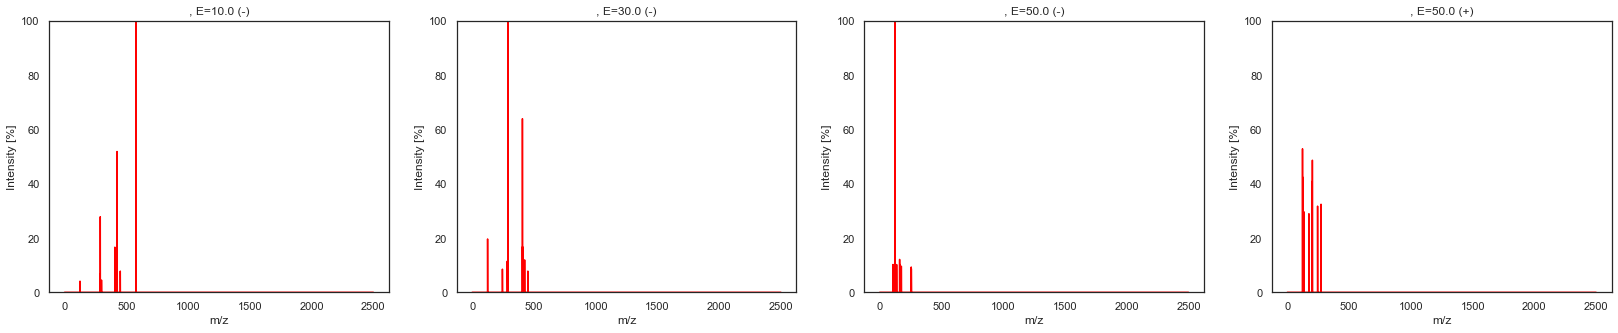

CCC1(C2=CC=CC=C2)C(=NCN=C1O)O
(4, 32)


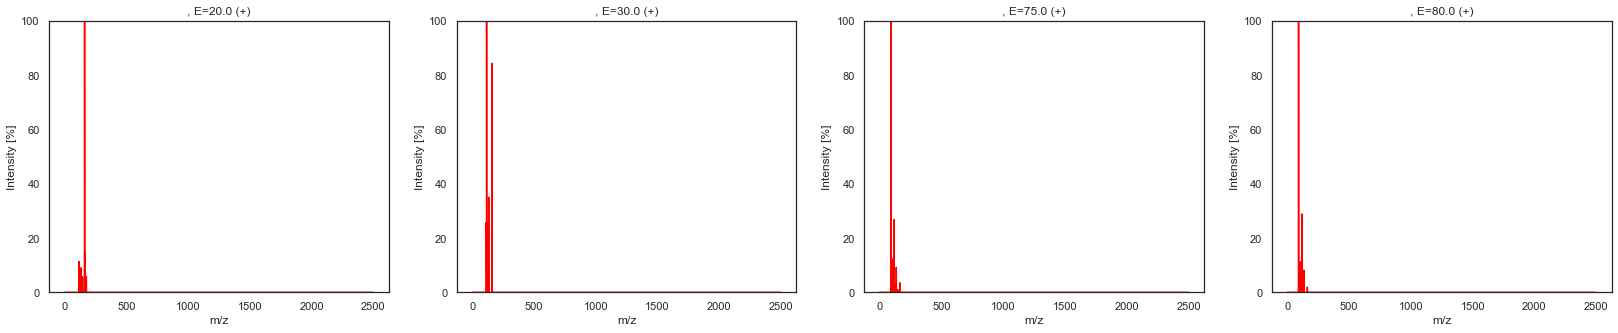

C1CCN[C@@H](C1)C(=O)O
(3, 32)


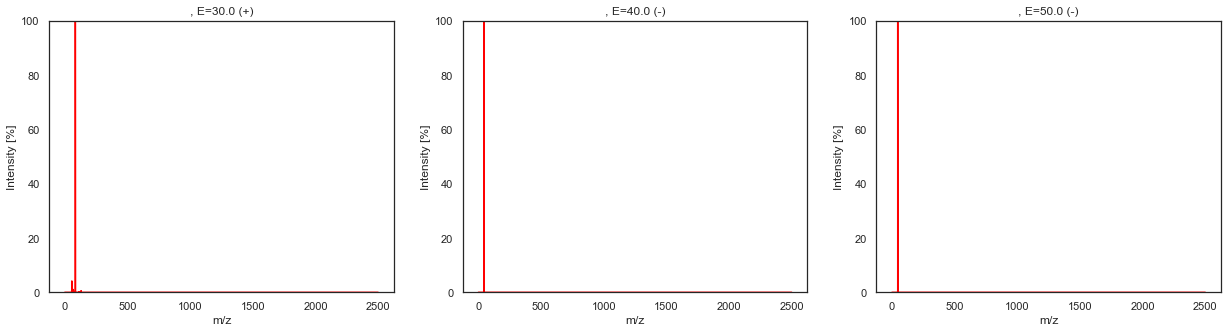

CC1=CC(=NO1)NS(=O)(=O)C2=CC=C(C=C2)N=C(C)O
(4, 32)


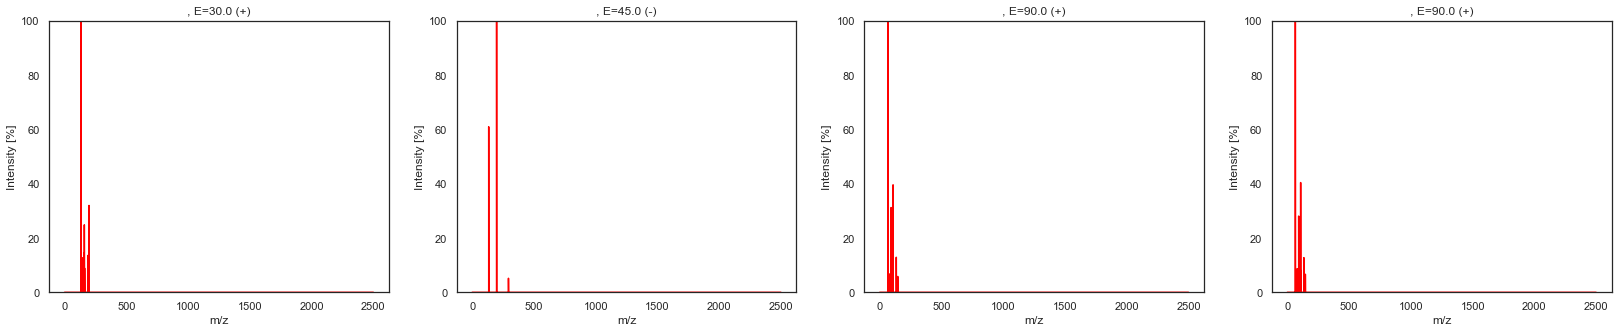

O=C(O)C1OC(OC2CCC3(C)C4CC=C5C6CC(C)(C)CCC6(C(=O)OC7OC(CO)C(O)C(O)C7O)CCC5(C)C4(C)CCC3C2(C)C)C(OC8OC(CO)C(O)C(O)C8O)C(O)C1O
(3, 32)


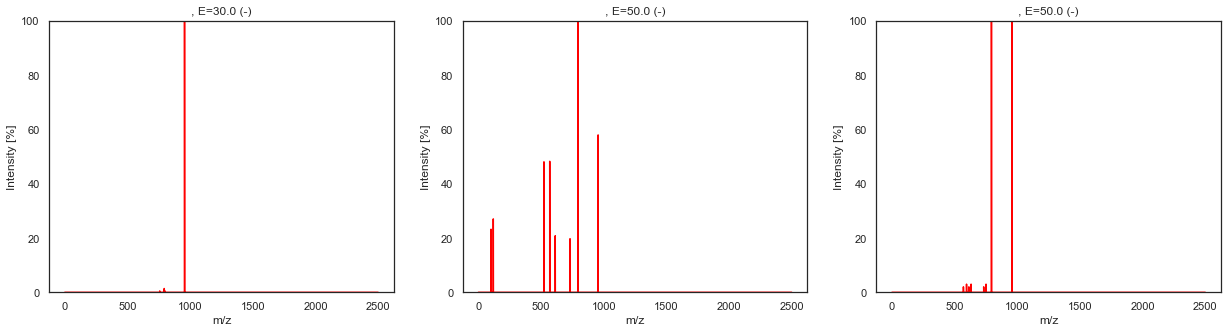

C1(=NC(=C(N)N=C1N)Cl)C(=NC(=N)N)O
(5, 32)


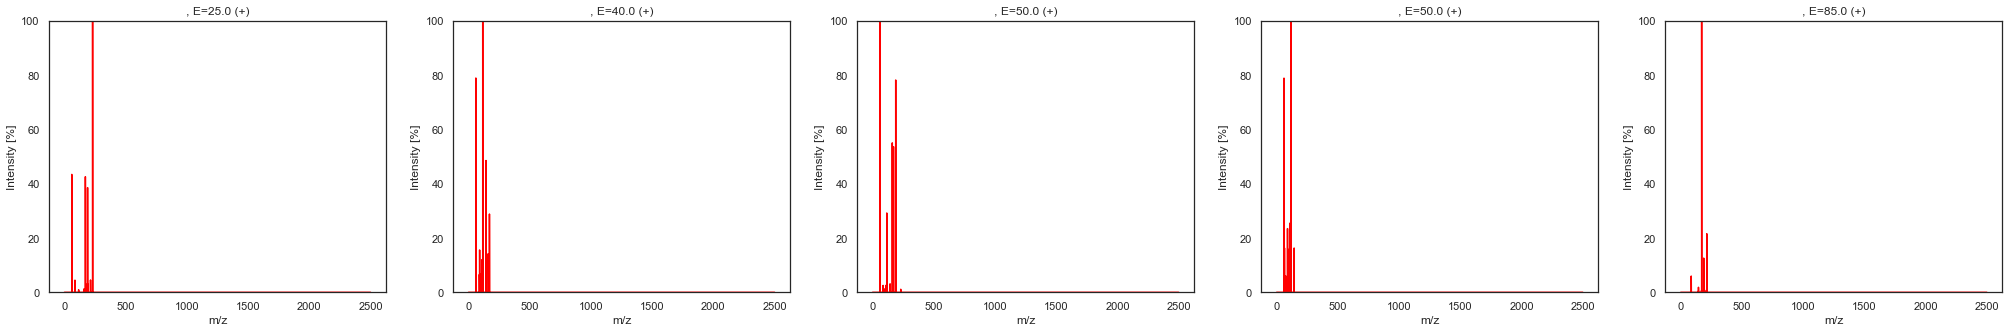

O=C(OC)C1C(O)CCC2CN3CCC=4C=5C=CC=CC5NC4C3CC12
(4, 32)


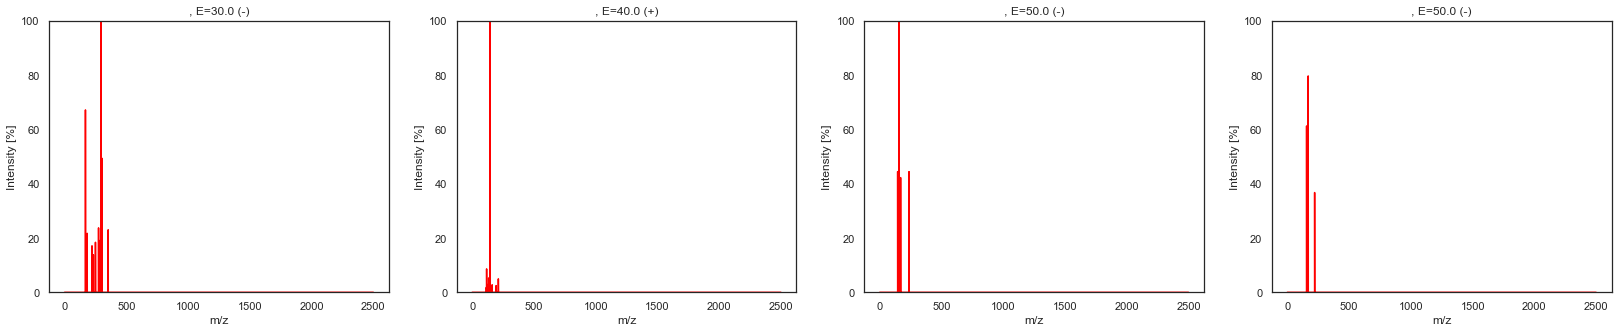

CC1CC2=C(C=CC=C2)N1N=C(C3=CC=C(C(=C3)S(=O)(=O)N)Cl)O
(3, 32)


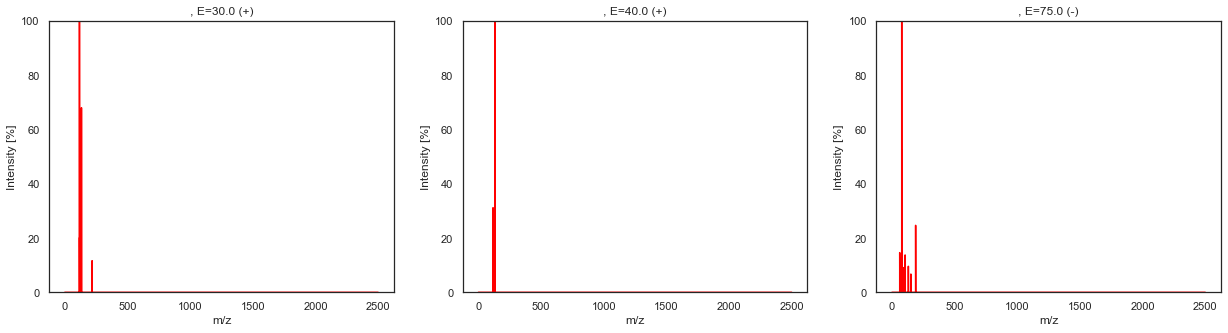

C1=C(C(=C(C=C1C(F)(F)F)Cl)N2C(=C(C(=N2)C#N)S(=O)C(F)(F)F)N)Cl
(5, 32)


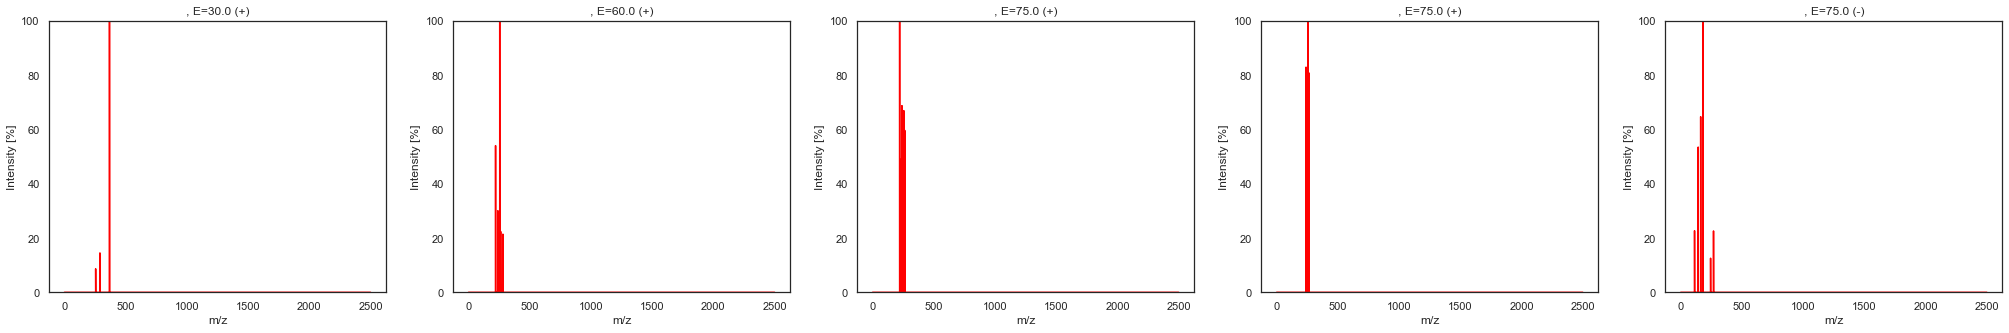

O=C(O)C1OC(OC2CCC3(C)C4CC=C5C6CC(C)(C)C(OC(=O)C(=CC)C)C(OC(=O)C)C6(CO)C(O)CC5(C)C4(C)CCC3C2(C)CO)C(OC7OC(CO)C(O)C(O)C7O)C(O)C1OC8OC(CO)C(O)C(O)C8O
(3, 32)


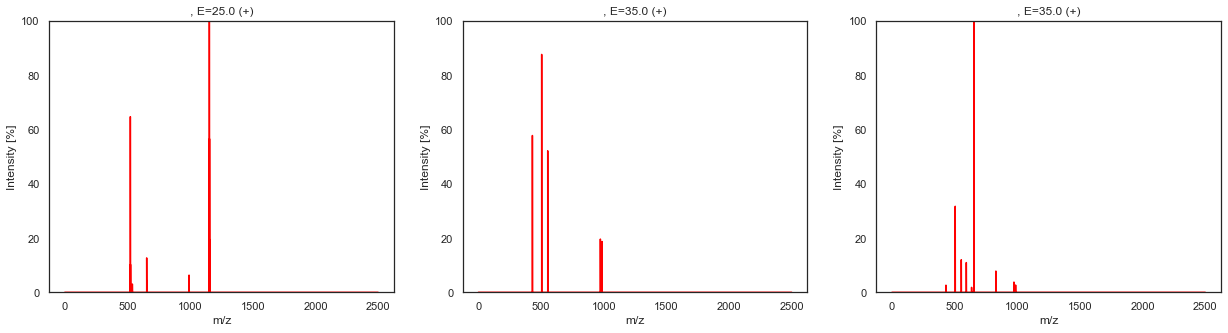

CC1=CC(=CC(=C1)C)C(=O)N(C(C)(C)C)N=C(C2=CC=CC(=C2C)OC)O
(3, 32)


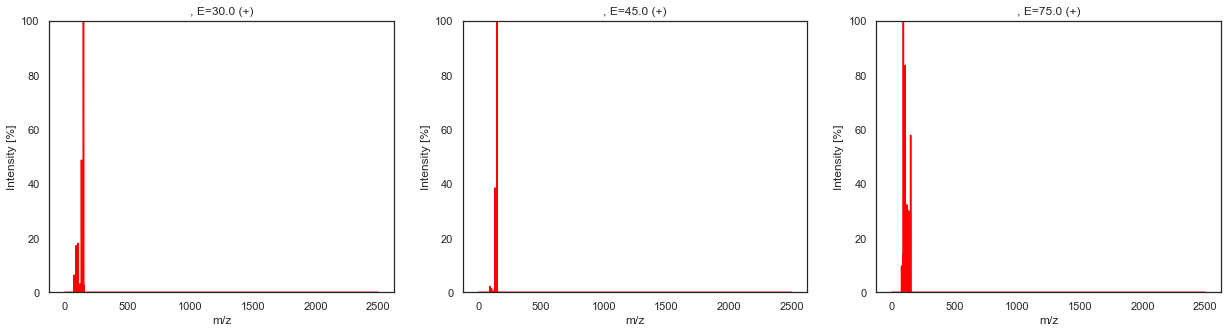

CN1CC[C@@]23[C@H]4C=C[C@@H]([C@@H]2OC5=C3C(=CC=C5O)C[C@H]41)O
(4, 32)


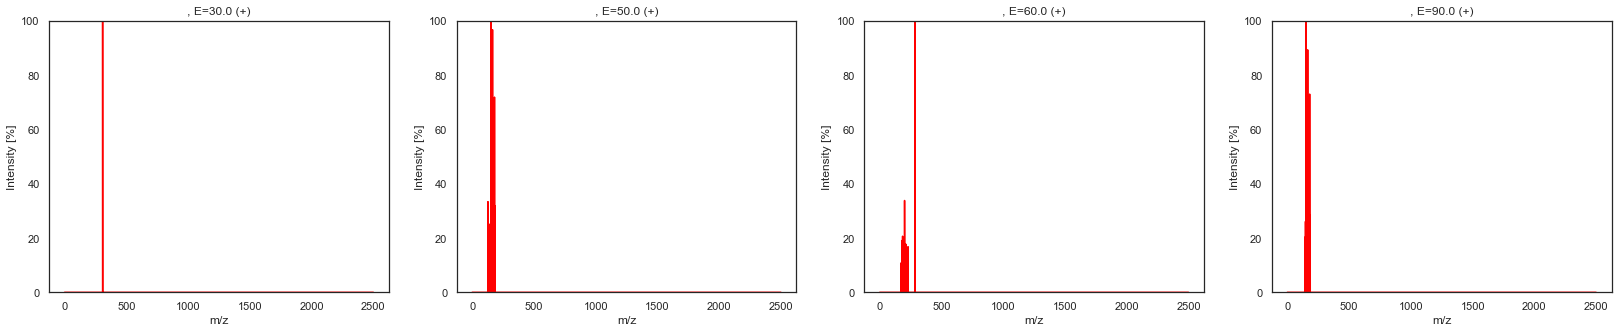

OC1=CC=C(C=C1OC)CC2COC(C3=CC=C(O)C(OC)=C3)C2CO
(3, 32)


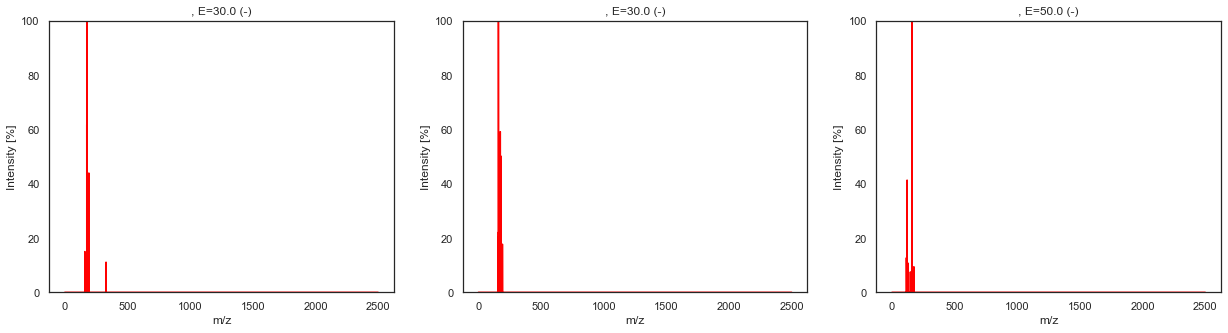

C[C@@H]([C@@H](C1=CC=CC=C1)O)NC
(3, 32)


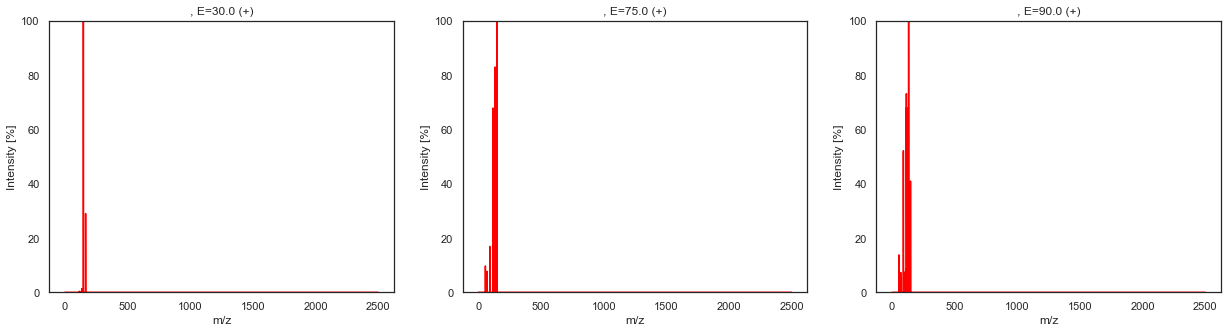

O=C1C2=C(O)C=C(OC3OC(CO)C(O)C(O)C3OC4OC(C)C(O)C(O)C4O)C=C2OC(C5=CC=C(OC)C=C5)C1
(3, 32)


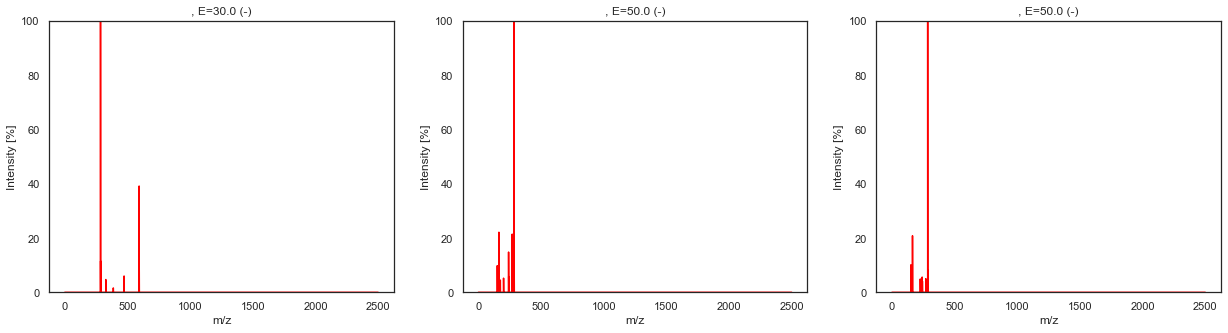

OC1=NC=2C=CC=CC2C13C4OCC5C6N(C)CC(C=C)(C5C4)C63
(3, 32)


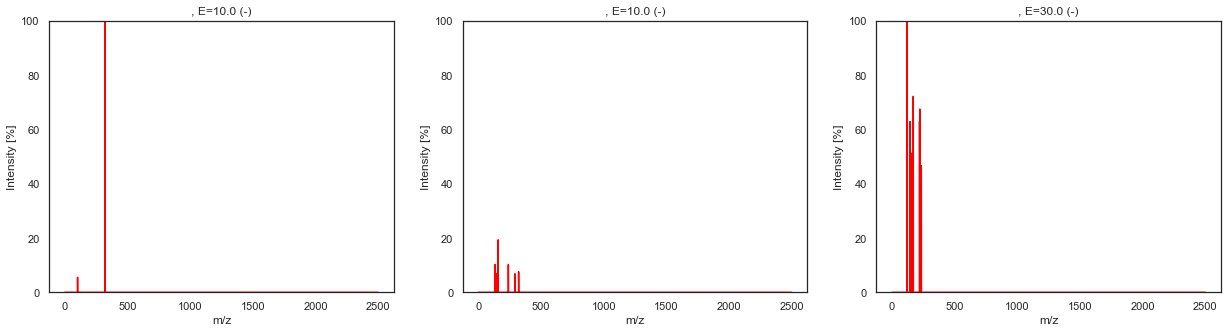

CCN(CC)CC#CCOC(=O)C(C1=CC=CC=C1)(C2CCCCC2)O
(5, 32)


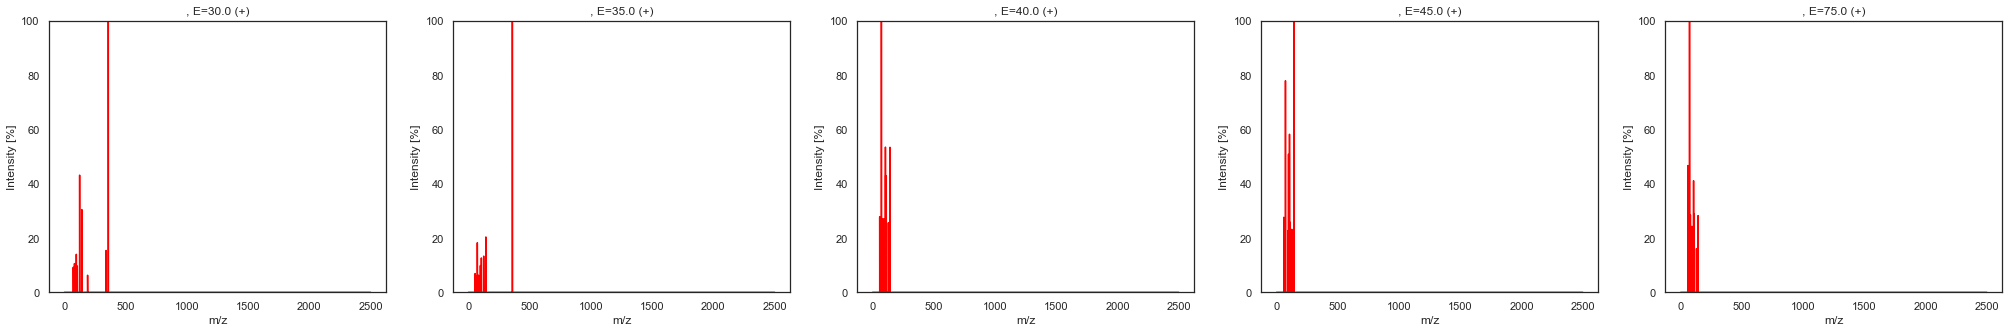

O=C1C=C(OC2=CC(OC3OC(CO)C(O)C(O)C3OC4OC(C)C(O)C(O)C4O)=CC(O)=C12)C=5C=CC(OC)=CC5
(3, 32)


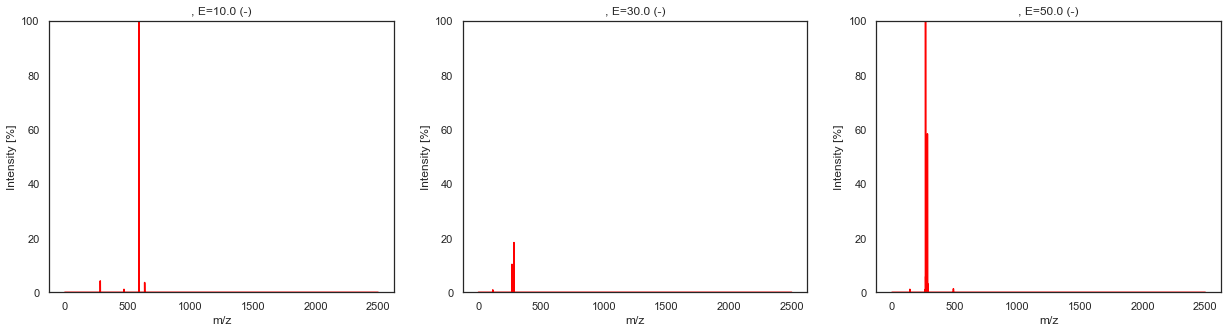

CC(C)(C(=O)O)OC1=CC=C(C=C1)C(=O)C2=CC=C(C=C2)Cl
(6, 32)


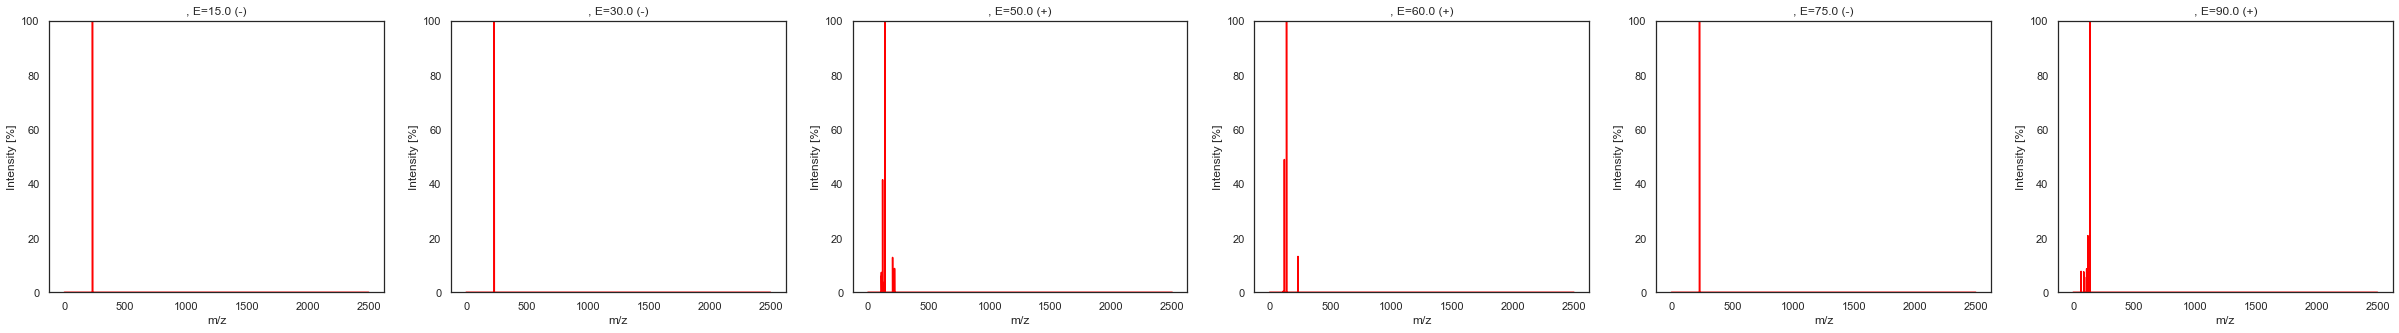

C[C@H]1CC[C@]2([C@@H](C)[C@H]3[C@H](C[C@H]4[C@@H]5CC[C@H]6C[C@H](CC[C@]6(C)[C@H]5CC[C@@]43C)O)O2)NC1
(3, 32)


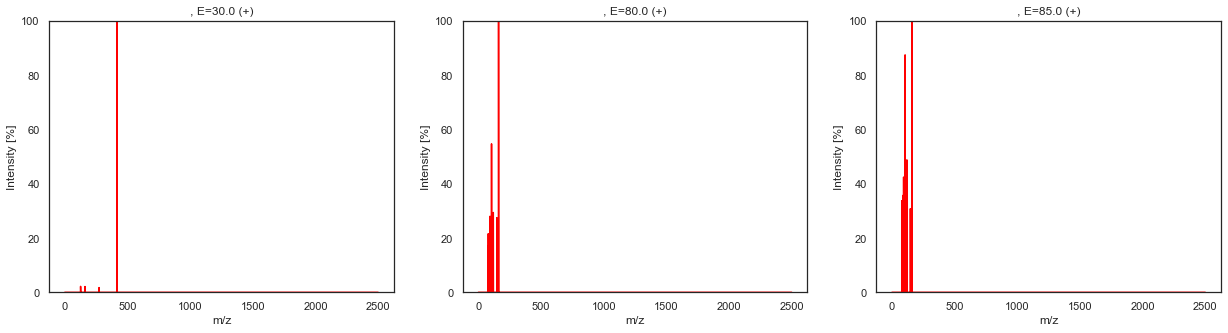

CCC[C@H]1CCCCN1
(5, 32)


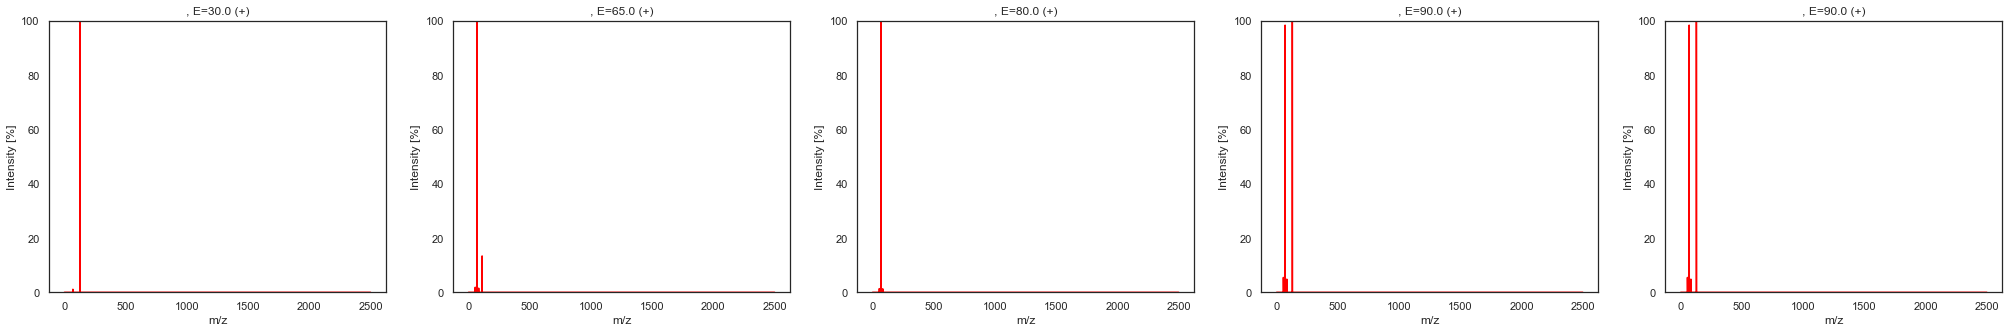

C1=CC=C(C=C1)C2=CC(=O)OC3=C2C(=CC(=C3)O)O
(4, 32)


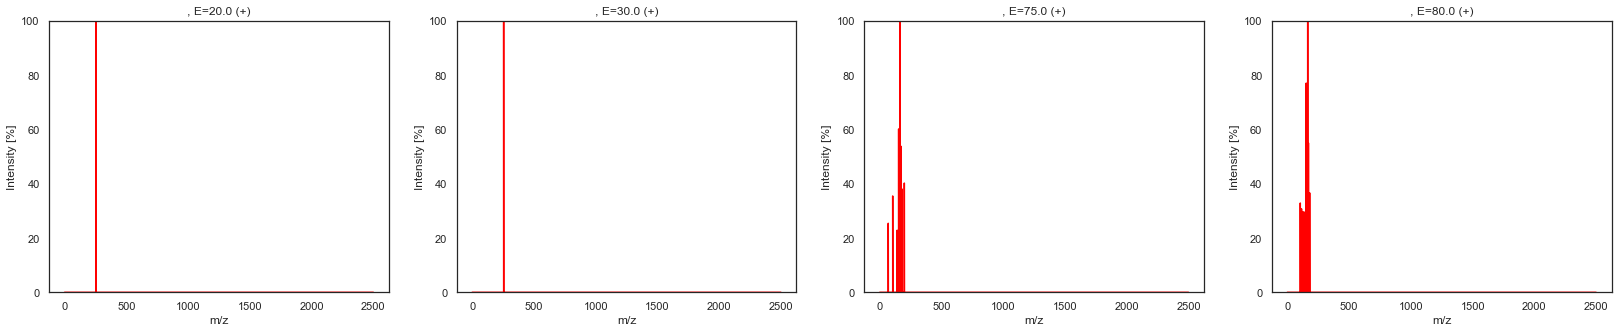

COC1=CC(=CC=C1O)C[C@H]2COC(=O)[C@@H]2CC3=CC=C(C(=C3)OC)O
(5, 32)


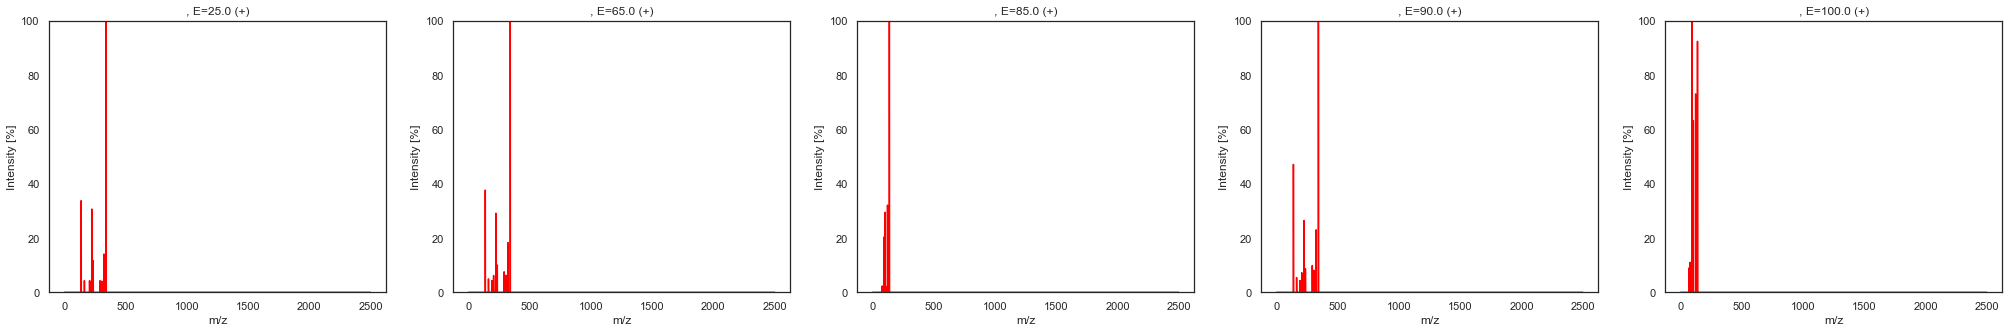

CCCCC1C(=O)N(C2=CC=CC=C2)N(C3=CC=CC=C3)C1=O
(3, 32)


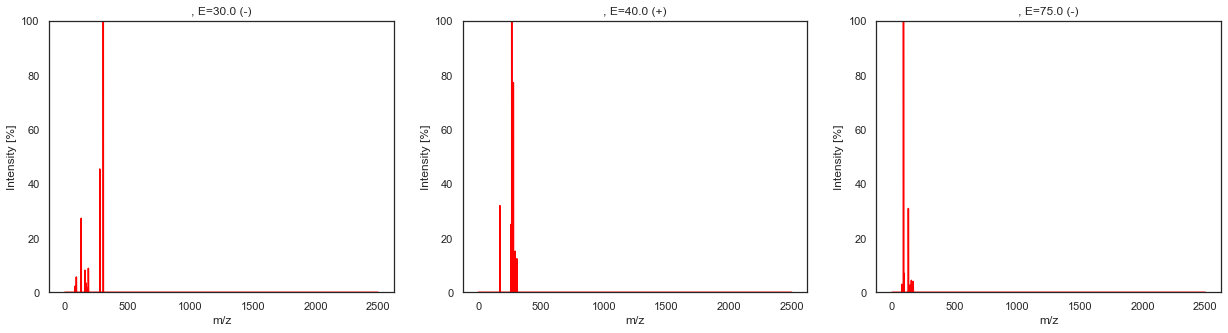

C[C@H]1C(=O)O[C@@H]2CCN3CC=C(COC(=O)[C@@](C)([C@]1(C)O)O)[C@H]23
(4, 32)


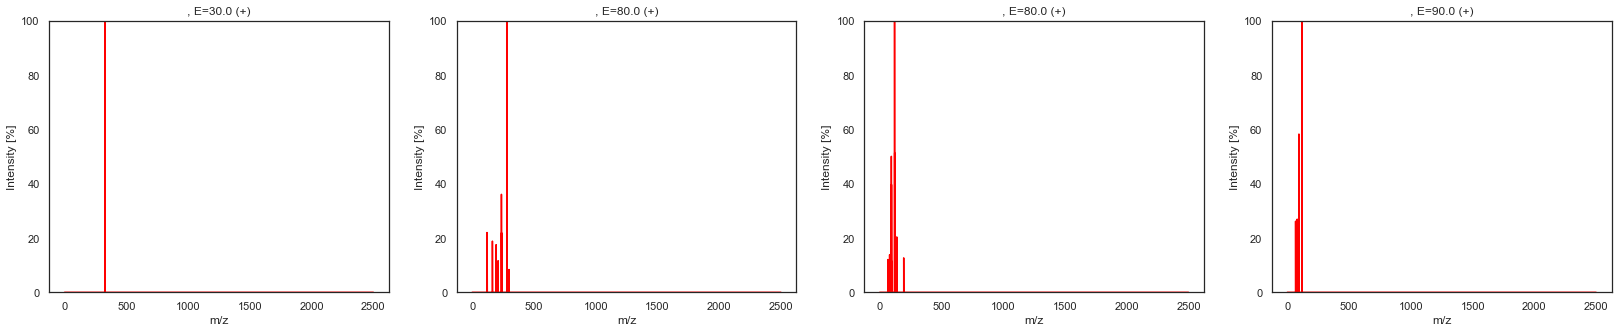

OC(C=1C=CN=C2C=CC(OC)=CC21)C3N4CCC(C3)C(C=C)C4
(5, 32)


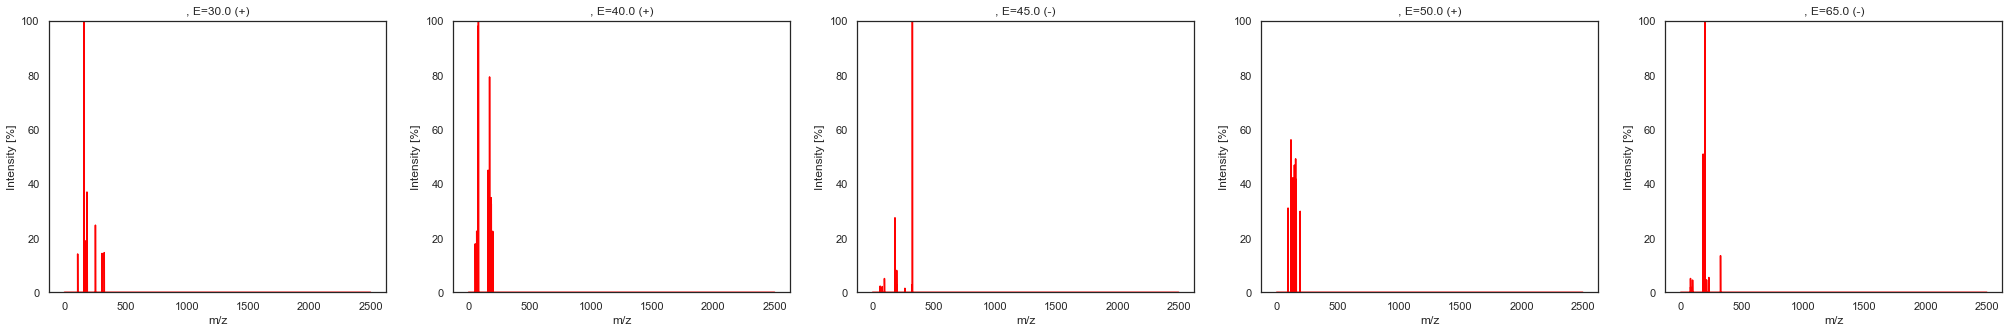

CN(C)CC1=CNC2=C1C=CC=C2
(6, 32)


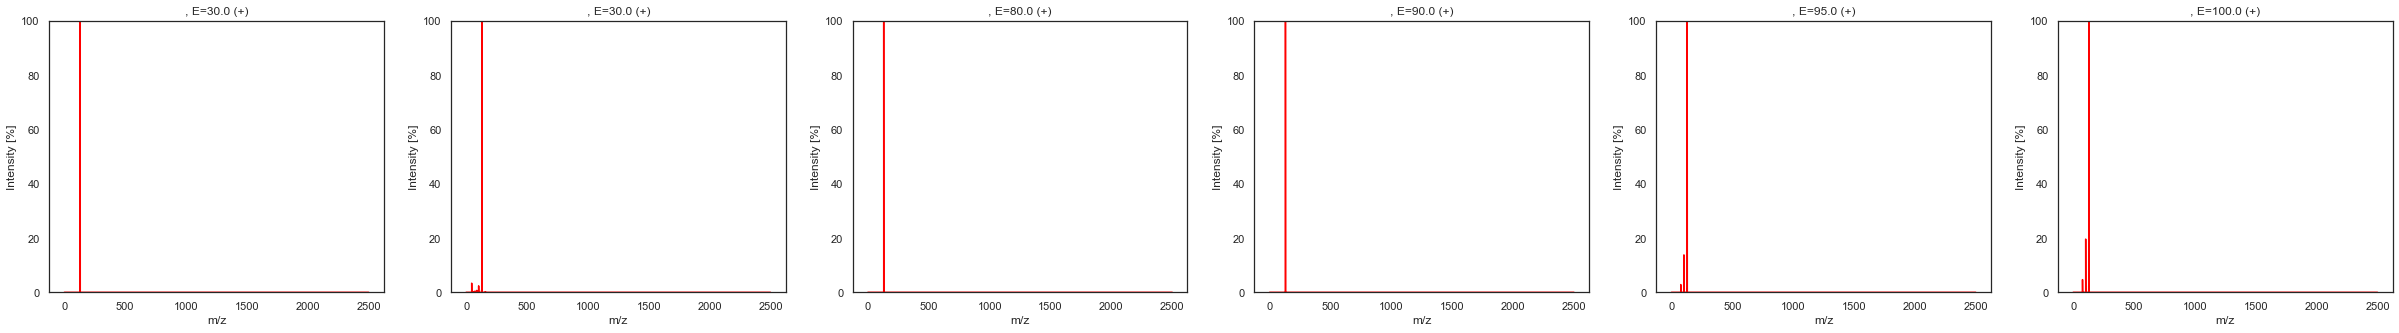

O=C(O)C(N=C(O)CC1=CNC=2C=CC=CC21)CC=3C=CC=CC3
(3, 32)


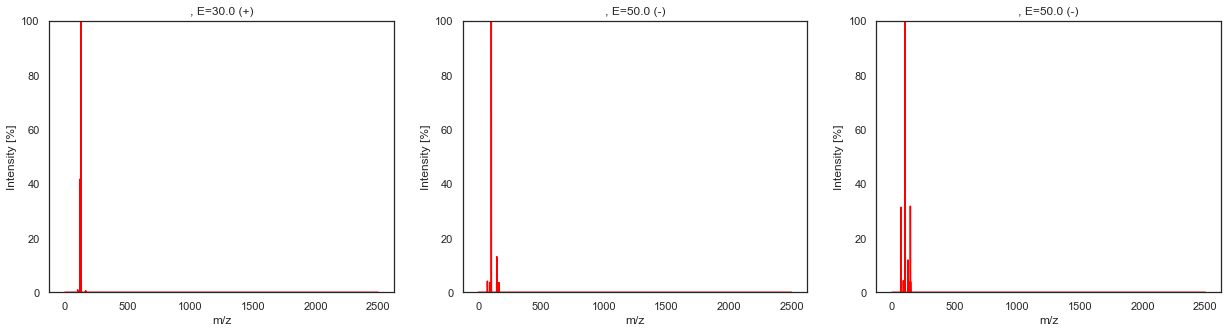

C1=CN=CC(=C1)C(=O)O
(3, 32)


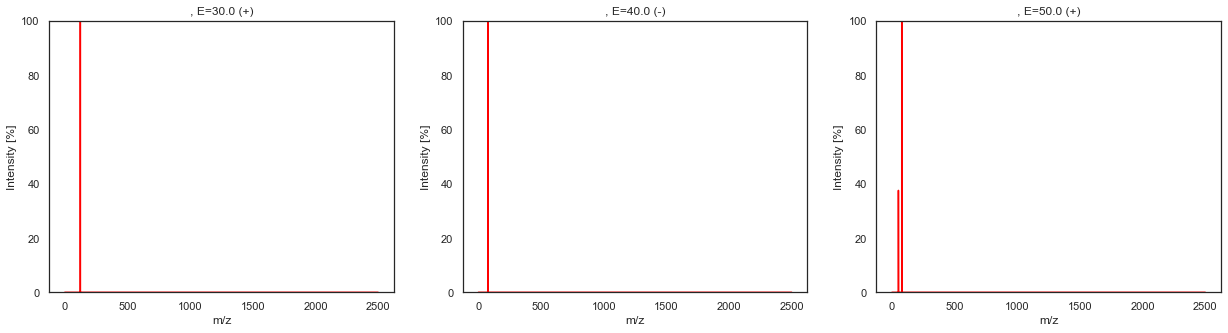

OC1=NC=NC=2NC=NC12
(3, 32)


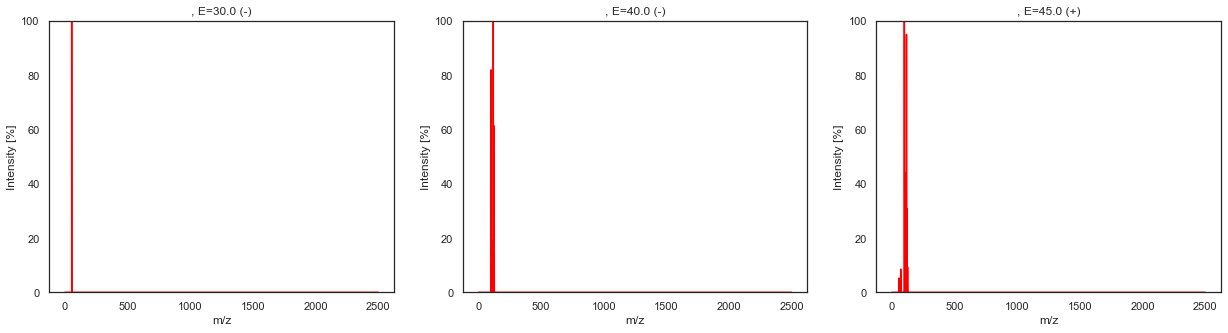

O=C1C=2C(O)=CC(OC)=CC2OC(C3=CC=C(O)C=C3)C1
(3, 32)


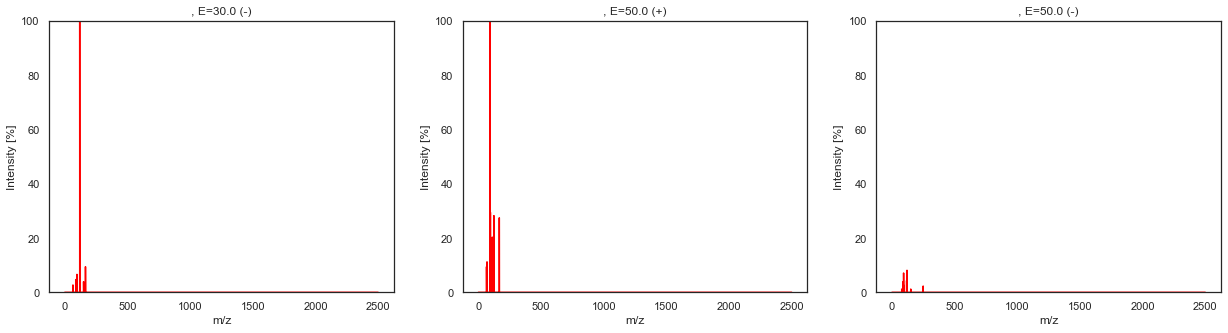

CC(C)C(=NC1=CC=C(C(=C1)C(F)(F)F)N(=O)=O)O
(3, 32)


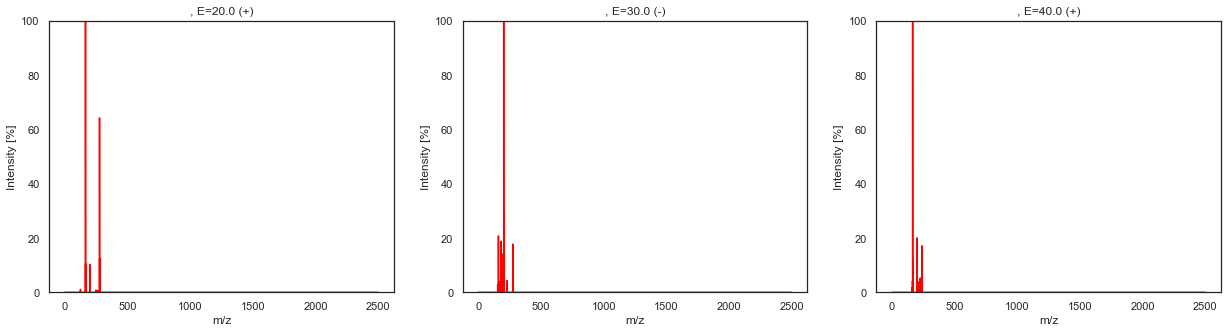

CC1(C)[C@@H]2CC[C@]3(C)[C@H](C(=O)C=C4[C@@H]5C[C@](C)(CC[C@]5(C)CC[C@]43C)C(=O)O)[C@@]2(C)CC[C@@H]1O
(5, 32)


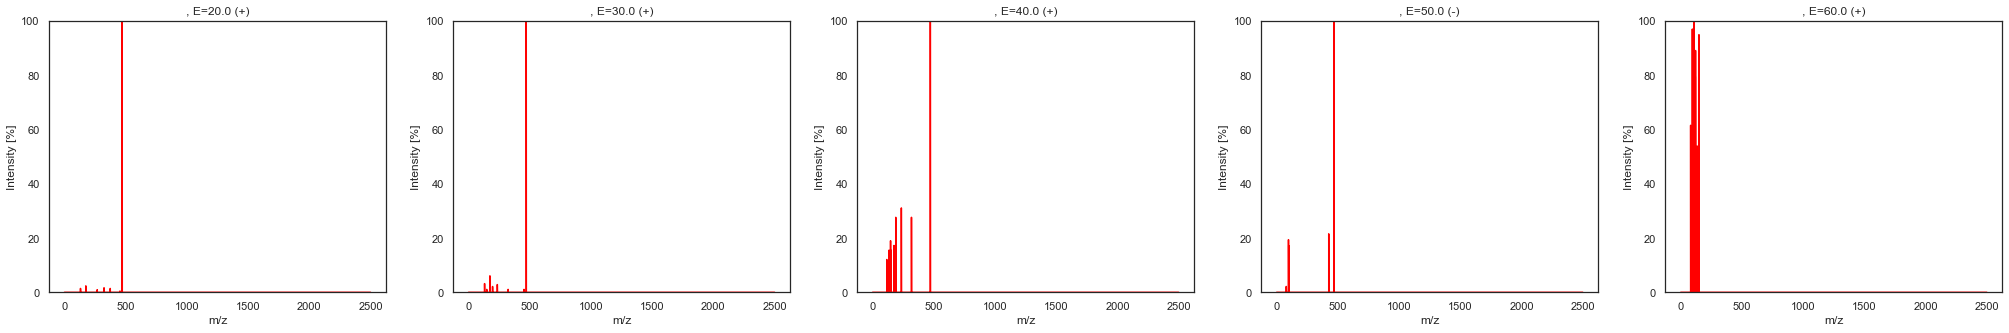

CN/C(=C\N(=O)=O)/NCCS(=O)CC1=CC=C(CN(C)C)O1
(4, 32)


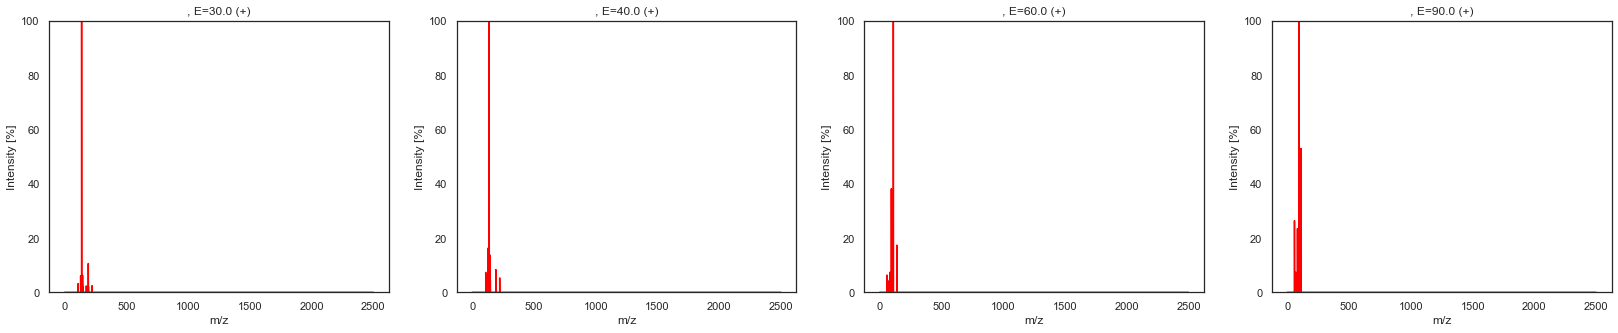

O=C1OCC(CC2=CC=C(OC)C(OC)=C2)C1CC3=CC=C(O)C(OC)=C3
(3, 32)


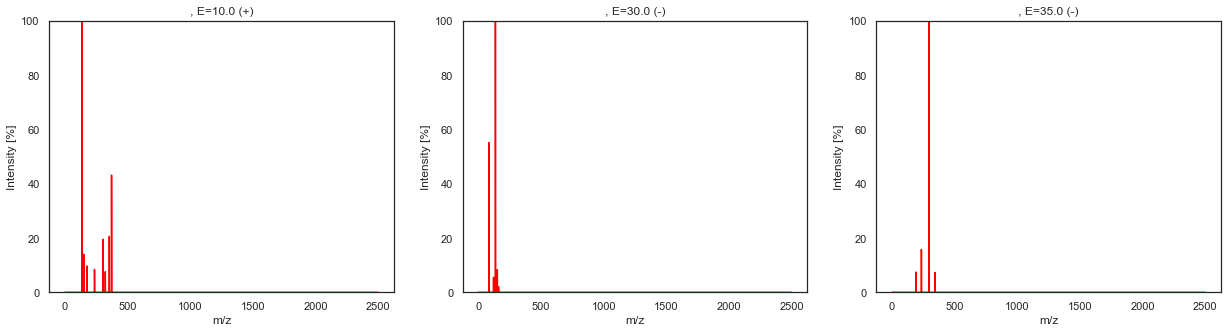

CN=C(NCC1=CN=C(Cl)S1)NN(=O)=O
(4, 32)


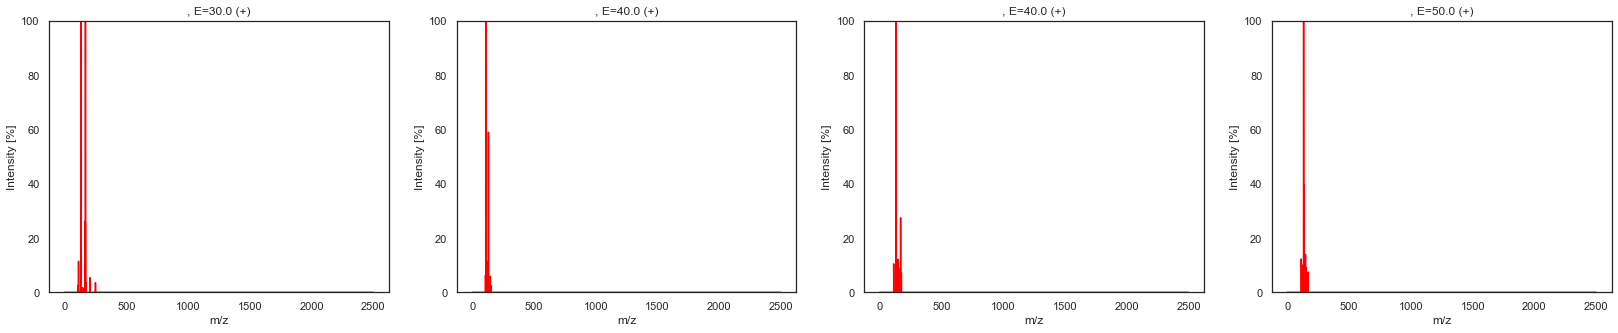

C([C@@H](C(=O)O)NC1=NC=NC2=C1N=CN2[C@H]3[C@@H]([C@@H]([C@@H](COP(=O)(O)O)O3)O)O)C(=O)O
(3, 32)


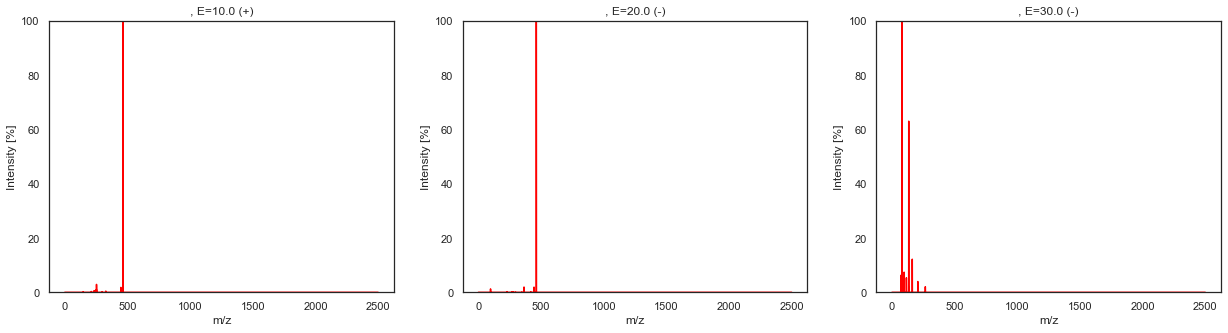

OCC1OC(OCC2OC(OC(C)(CCC=C(C)C)C3CCC4(C)C3C(O)CC5C6(C)CCC(OC7OC(CO)C(O)C(O)C7OC8OC(CO)C(O)C(O)C8O)C(C)(C)C6CCC54C)C(O)C(O)C2O)C(O)C(O)C1O
(3, 32)


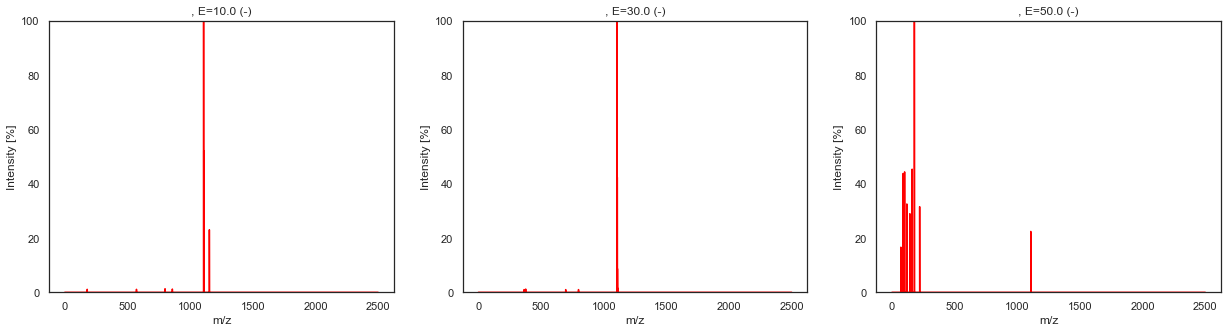

CCC(C)C1=CC(=CC(=C1O)N(=O)=O)N(=O)=O
(3, 32)


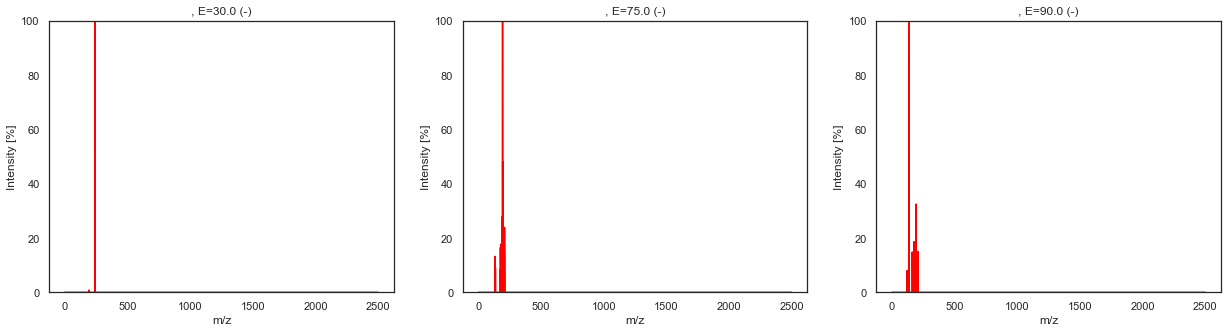

O=C1OCCC2(O)C1=COC(OC3OC(CO)C(O)C(O)C3O)C2C=C
(4, 32)


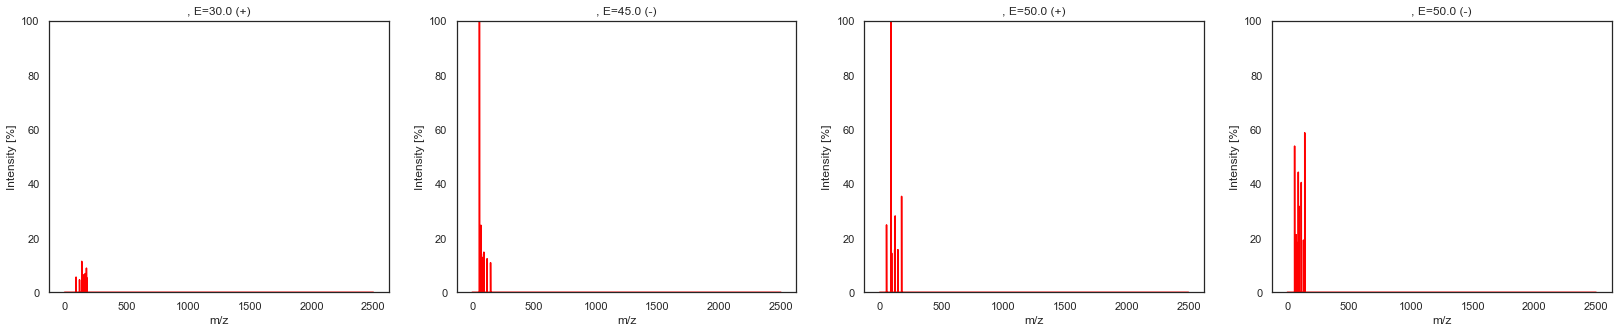

CC1=C(N=C(N=C1C)N(C)C)OC(=O)N(C)C
(3, 32)


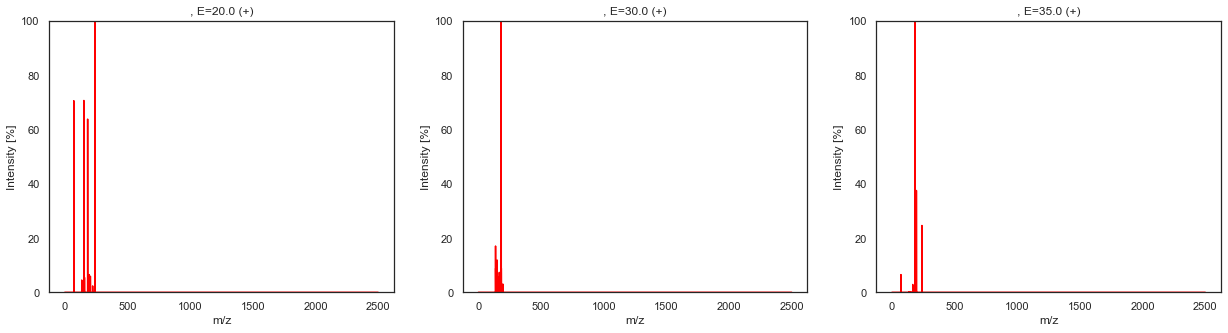

CC(=NC(COC)C(=NCC1=CC=CC=C1)O)O
(3, 32)


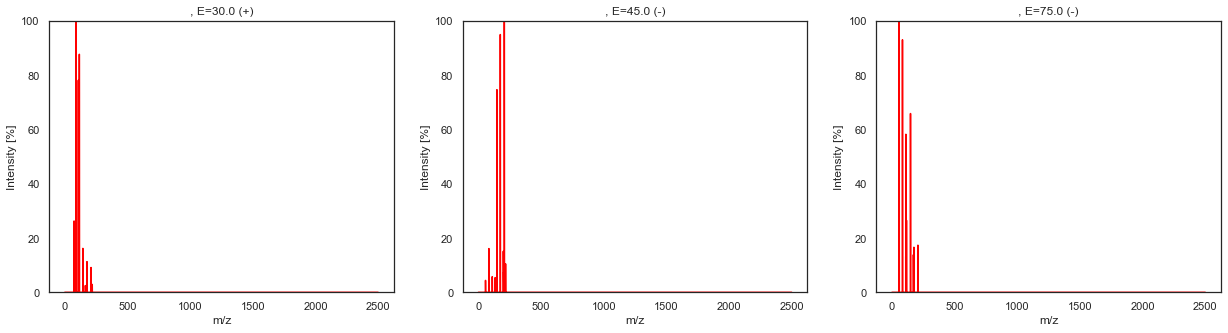

CN1CCN(CC1)C(C2=CC=CC=C2)C3=CC=CC=C3
(4, 32)


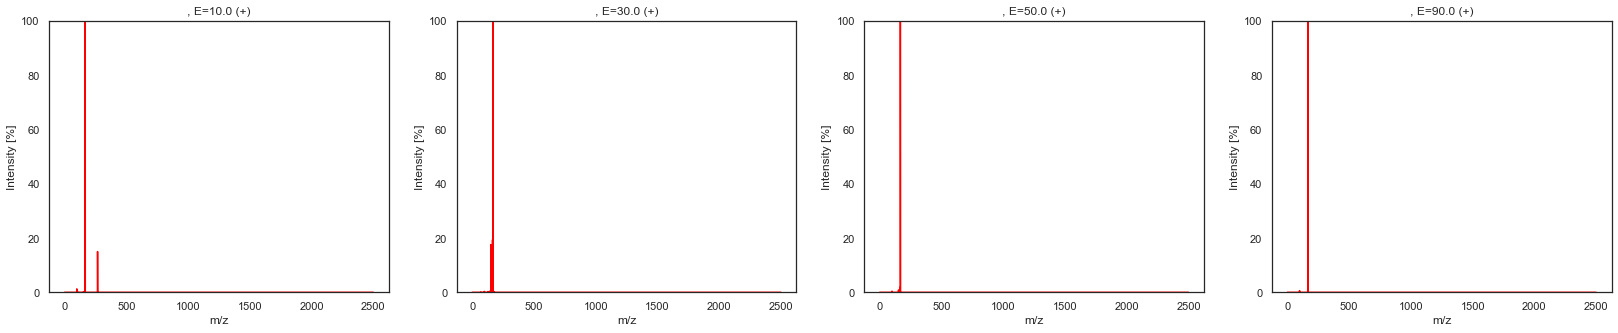

O=C(O)C1OC(OC=2C(=O)C=3C(O)=CC(O)=CC3OC2C=4C=CC(O)=C(O)C4)C(O)C(O)C1O
(3, 32)


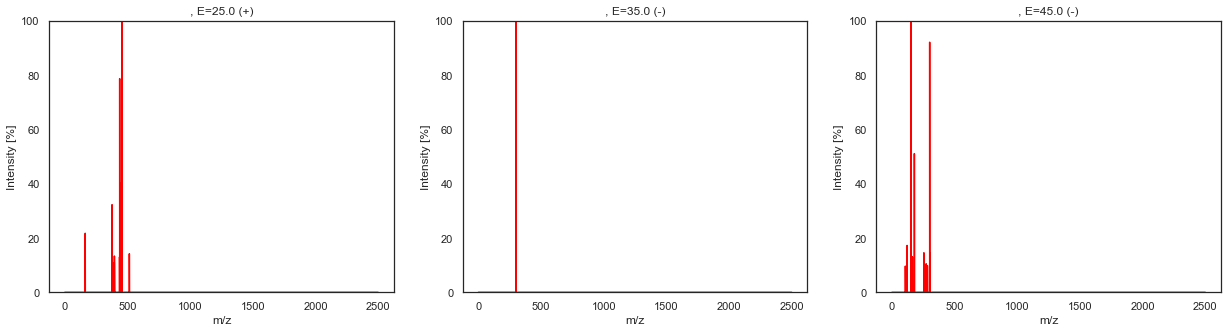

O=C(O)C1(C)CCC2(C)CCC3(C(=CC(=O)C4C5(C)CCC(O)C(C)(C)C5CCC43C)C2C1)C
(6, 32)


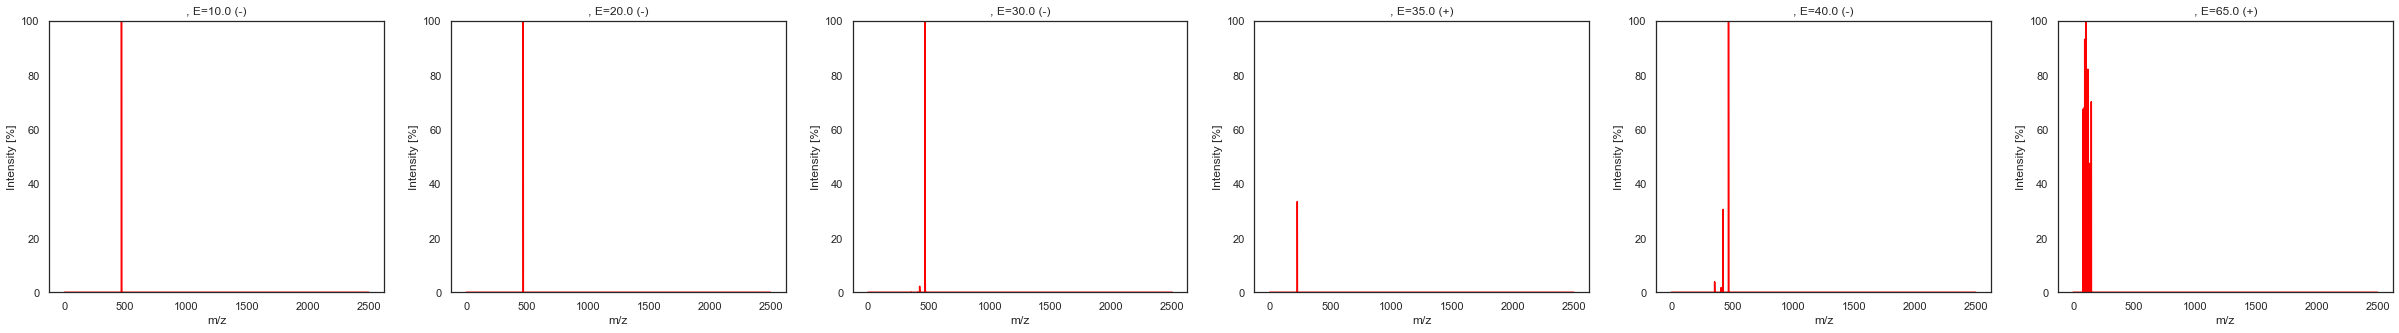

CCCCC1=C(C2=C(C=CC(=C2)NS(=O)(=O)C)O1)C(=O)C3=CC=C(C=C3)OCCCN(CCCC)CCCC
(3, 32)


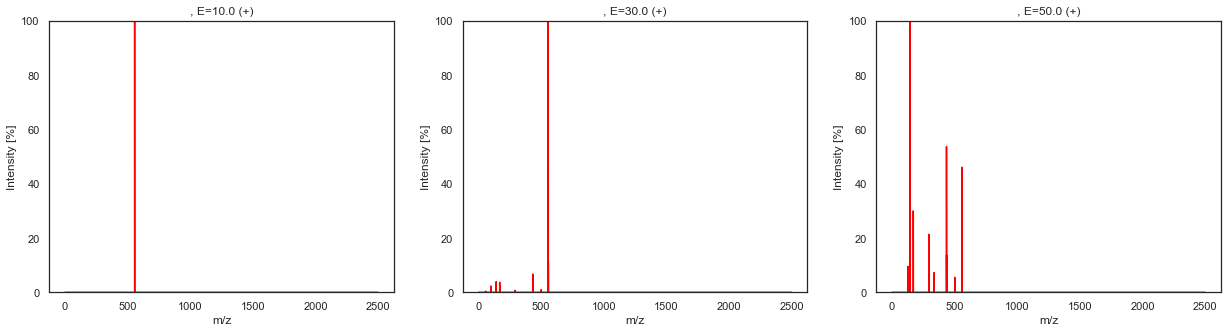

CN1CCC2=C([C@@H]1[C@@H]3C4=CC=C(C(=C4C(=O)O3)OC)OC)C(=C5C(=C2)OCO5)OC
(3, 32)


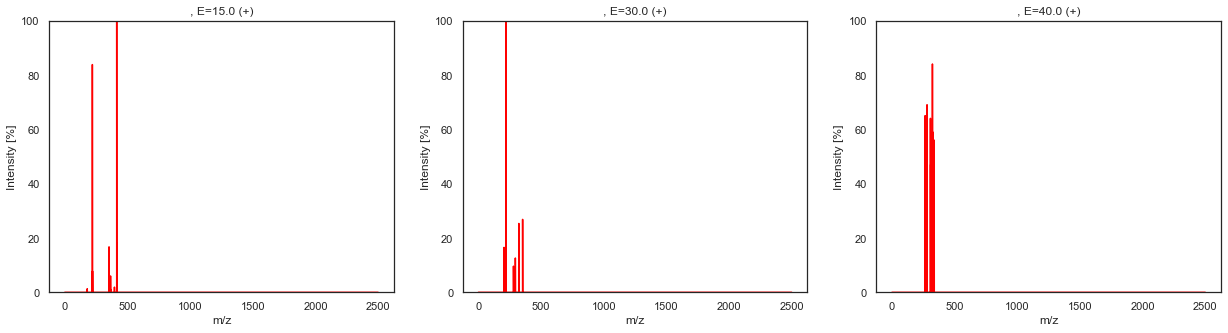

C1=CC2=C(C=C1)NC3=C(C=CC=C3)C=C2
(3, 32)


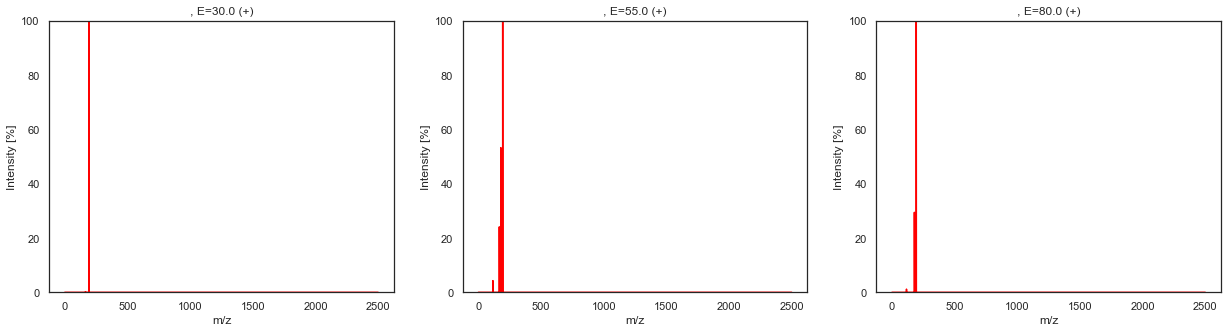

O=C1C=C(OC=2C1=C(O)C=C(O)C2C3OC(CO)C(O)C(O)C3OC4OC(C)C(O)C(O)C4O)C=5C=CC(O)=CC5
(4, 32)


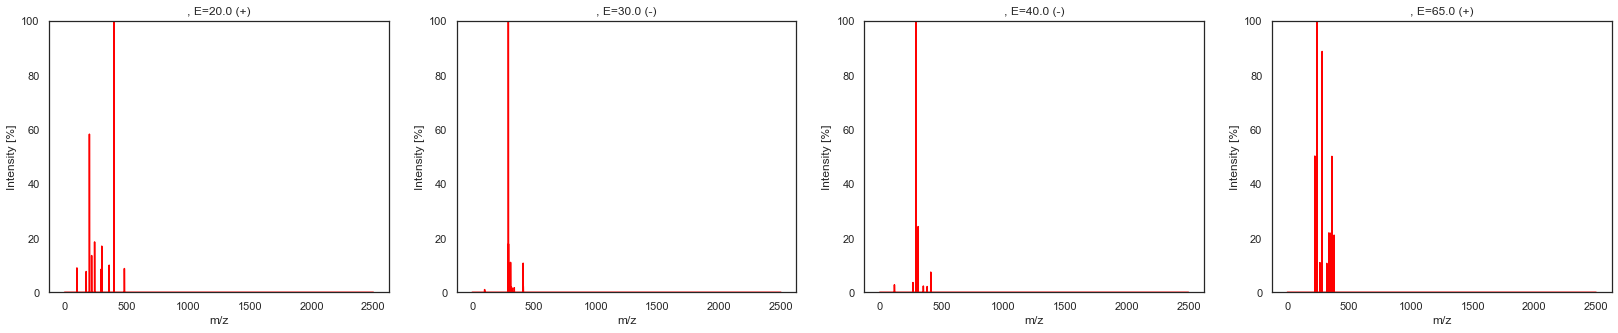

C1=NC2=C(C=C3C4CC(CNC4)C3=C2)N=C1
(3, 32)


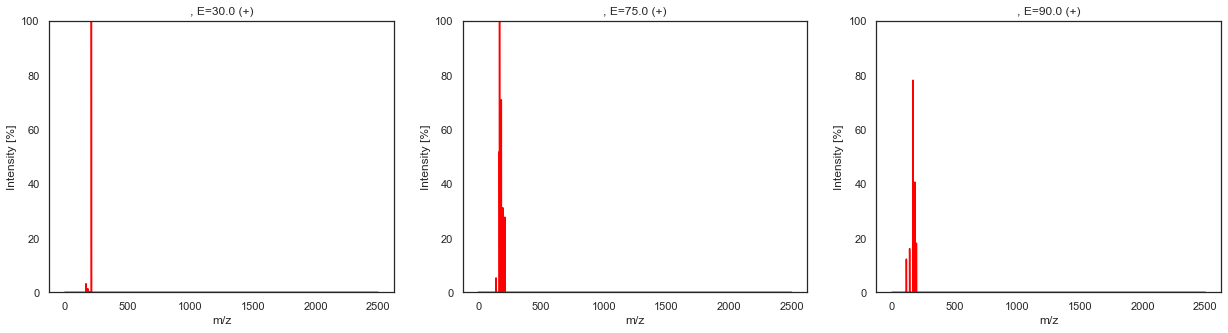

OCC1C2C(=CC)CN3C(C=4NC=5C=CC=CC5C4CC31)C2
(3, 32)


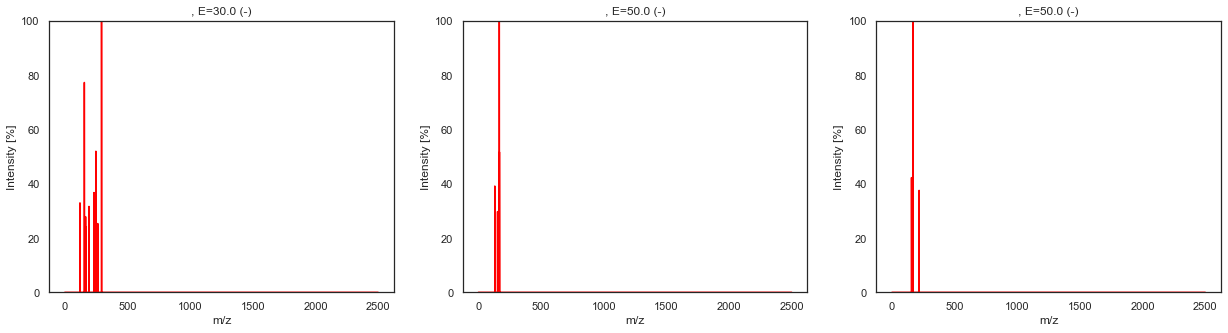

CN(C)C(=N)NC(=N)N
(3, 32)


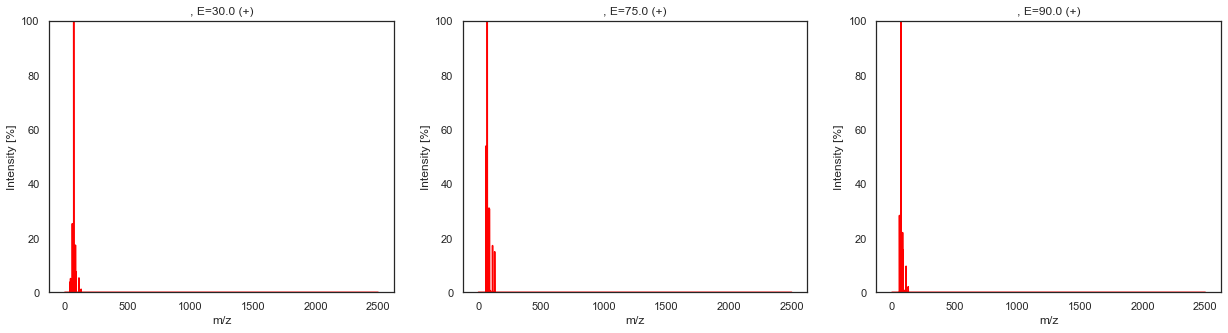

OCC1OC(OC2=C(OC)C=C(C=C2OC)C3OCC4C(OCC34)C5=CC(OC)=C(OC6OC(CO)C(O)C(O)C6O)C(OC)=C5)C(O)C(O)C1O
(3, 32)


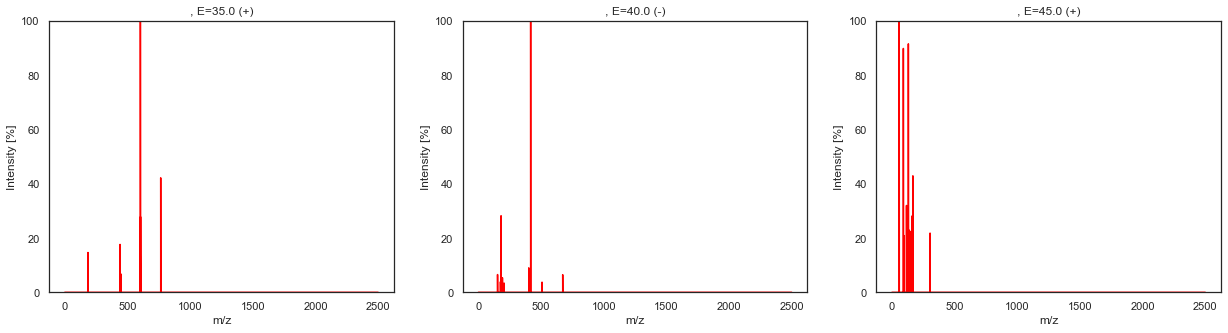

O=C(C1=CC=C(O)C(OC)=C1)C(=C(C(=O)C2=CC=C(O)C(OC)=C2)C)C
(4, 32)


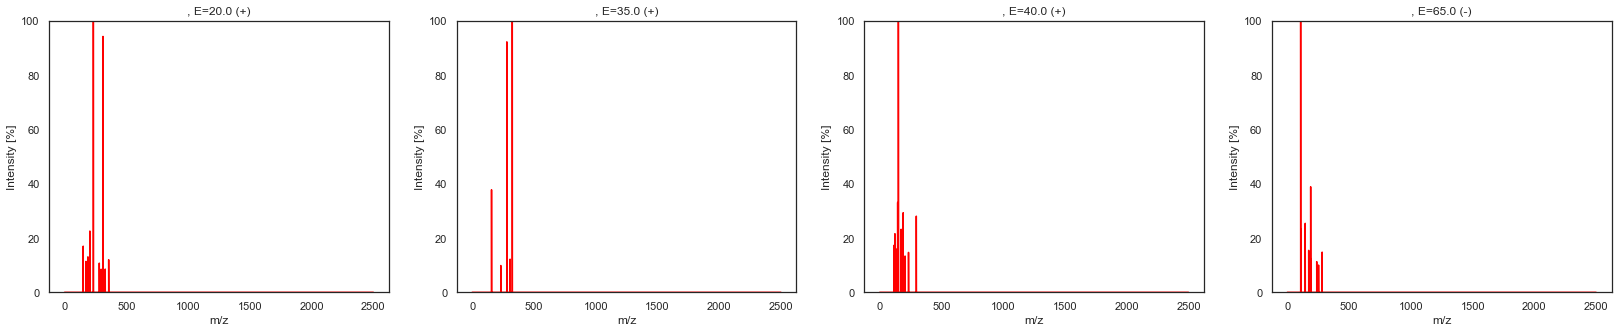

O=C1OC2OC34C(=O)OC5CC(C(C)(C)C)C2(C1O)C54CC6OC(=O)C(C)C63O
(5, 32)


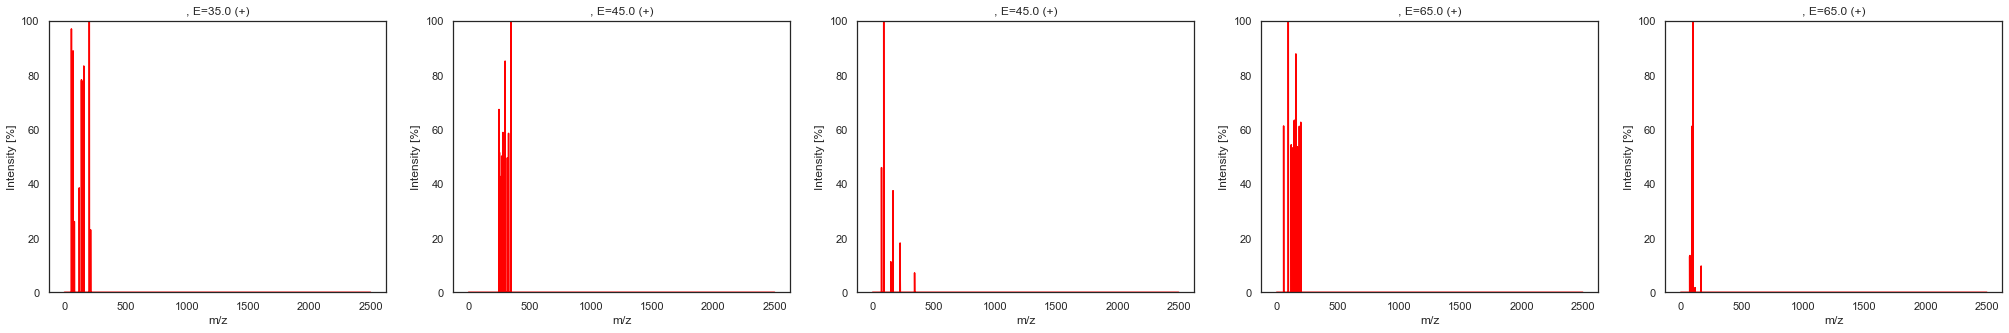

O=C(OC)C(N=C(O)C=1C=CC=CC1)CC=2C=CC=CC2
(3, 32)


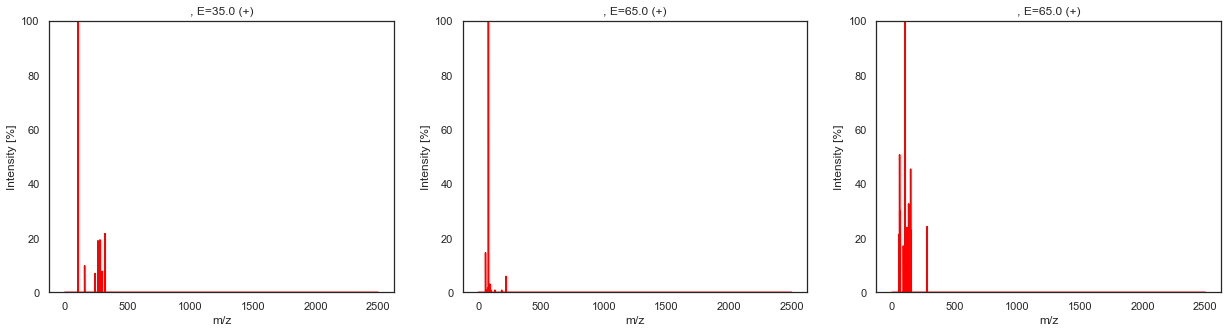

CS(=O)(=O)C1=CC=C(C(=C1)Cl)C(=O)C2C(=O)CCCC2=O
(4, 32)


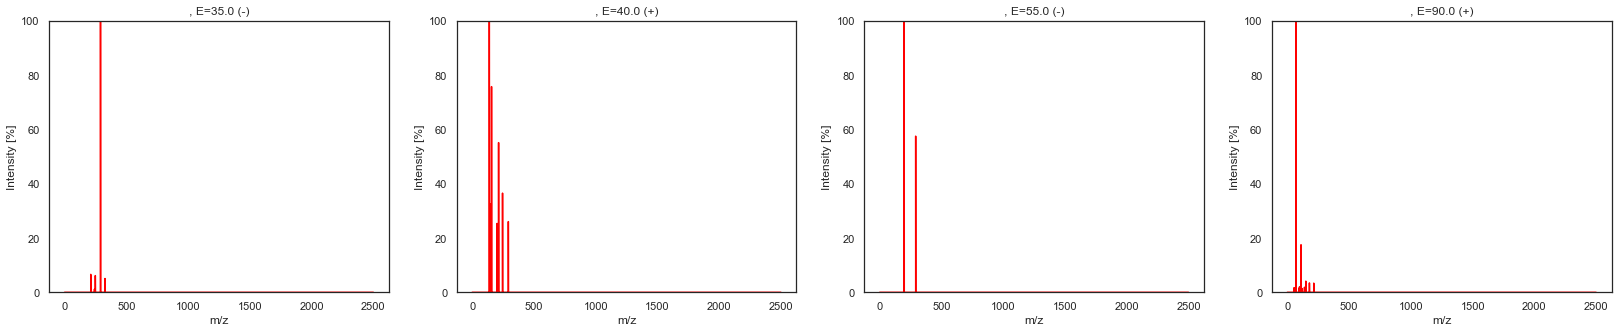

O=C(OC1CC(=CCCC(=CC2OC(=O)C(=C)C21)CO)C)C(=CCOC(=O)C)CO
(3, 32)


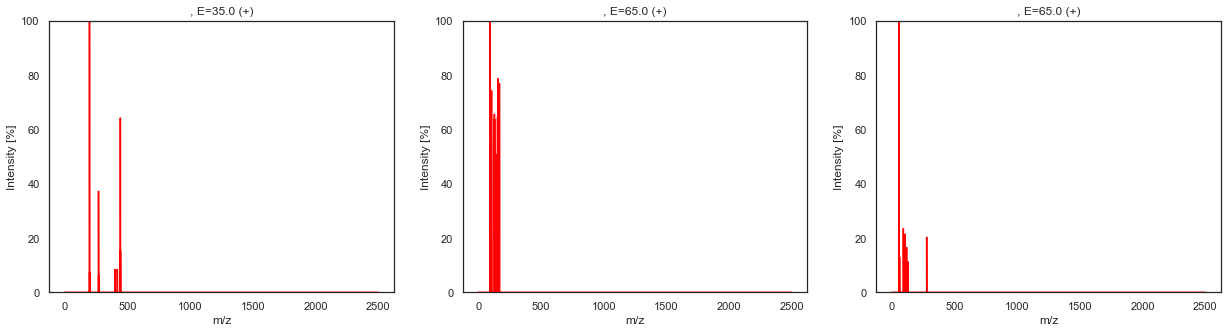

O=C1OC(=O)C(C1)C2C(=O)CCC3C(C(=C)CC2)CC3(C)C
(3, 32)


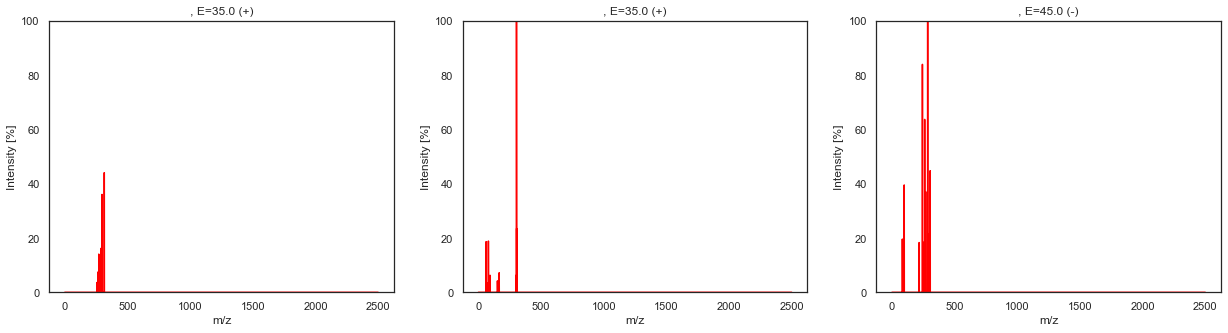

O=C1OC=2C(O)=C(OC3OC(CO)C(O)C(O)C3O)C(OC)=CC2C=C1
(3, 32)


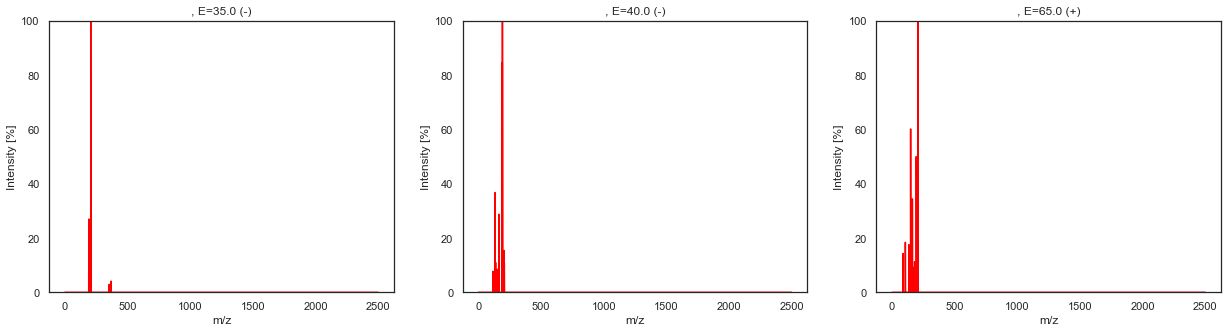

O=C(OC)C1=COC(OC2OC(CO)C(O)C(O)C2O)C(C=C)C1CC3OC(CC(=O)C3)CCC4=CC=C(O)C=C4
(3, 32)


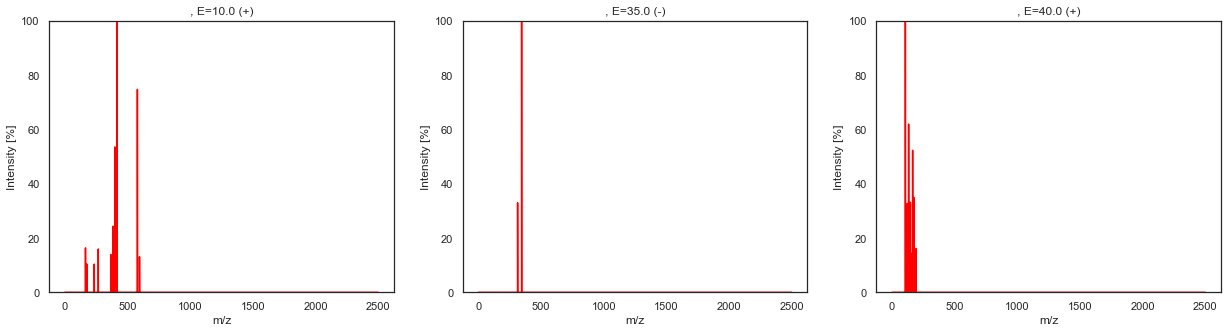

O=C(O)C1C(C=C(C)C)C1(C)C
(3, 32)


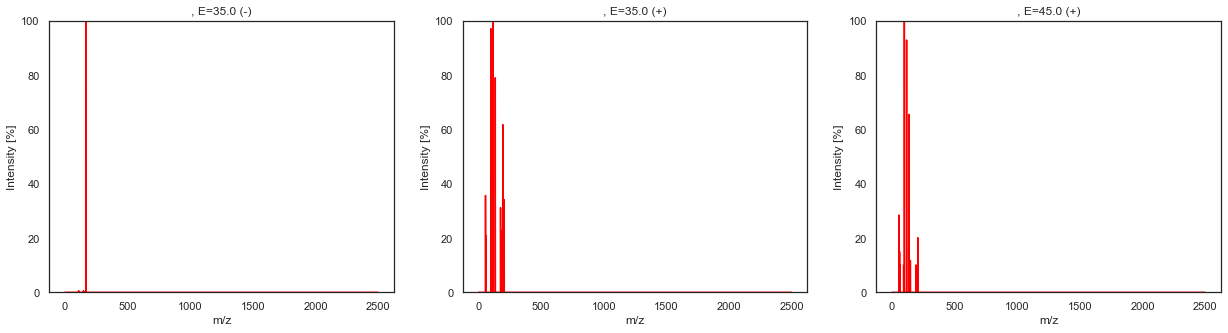

OC=1N=C2C(=CC1)C3(N)C(=CC)C(C=C(C)C3)C2
(4, 32)


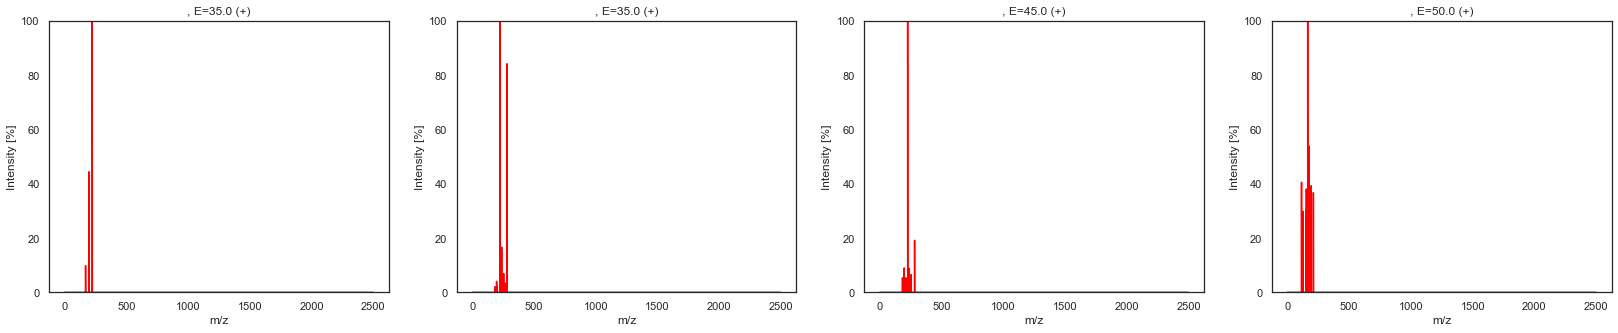

OCC1OC(OCC23CCC(C)(C)CC3C4=CCC5C6(C)CCC(OC7OC(COC8OC(COC9OCC(O)C(O)C9O)C(O)C(O)C8O)C(O)C(O)C7O)C(C)(C)C6CCC5(C)C4(C)CC2O)C(O)C(O)C1O
(4, 32)


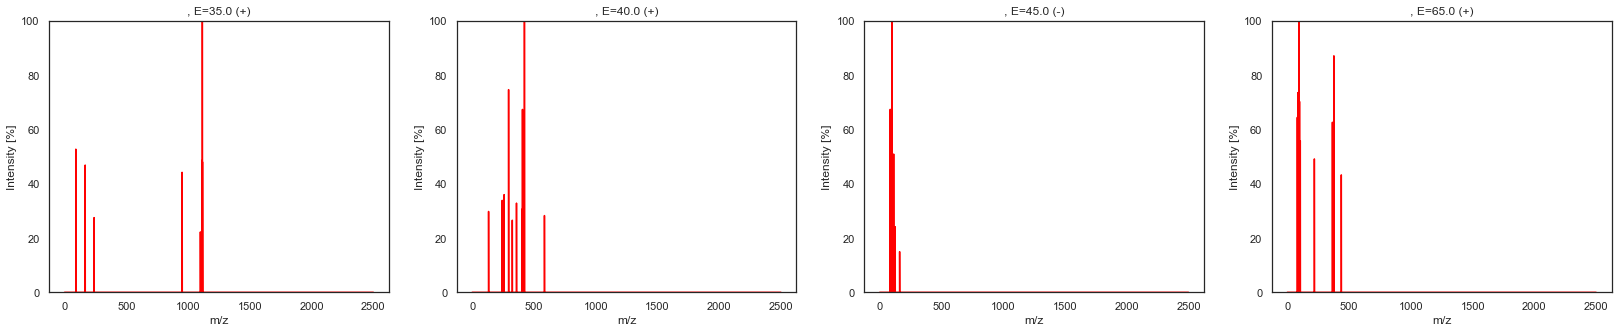

C1=C(C=CC(=C1)O)C[C@@H](C(=O)O)N
(3, 32)


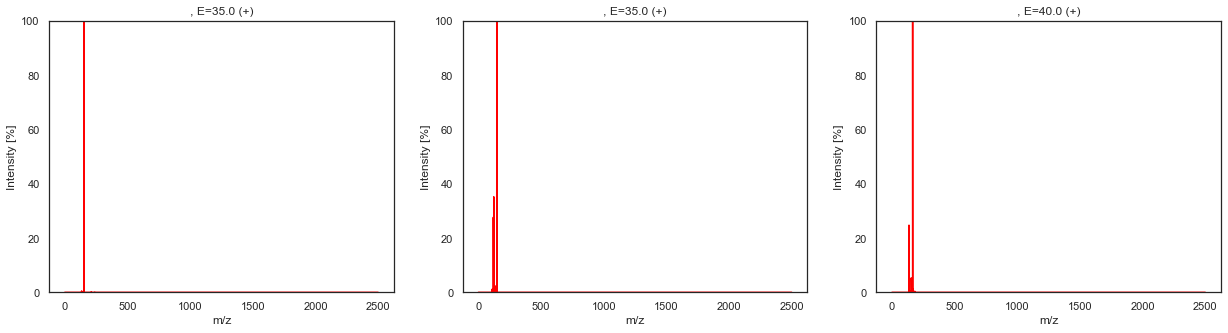

O=C1OC2OC34C(=O)OC5CC(C(C)(C)C)C2(C1O)C54C(O)C6OC(=O)C(C)C63O
(5, 32)


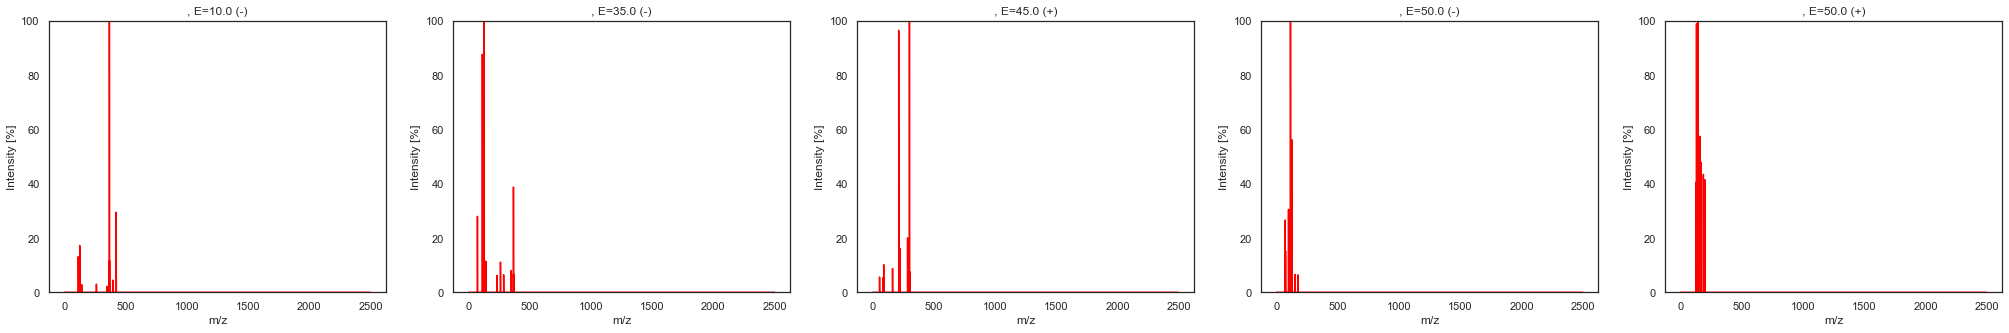

O=C1OC2C(C1=C)CCC3(C)C(O)CCC(=C)C23
(3, 32)


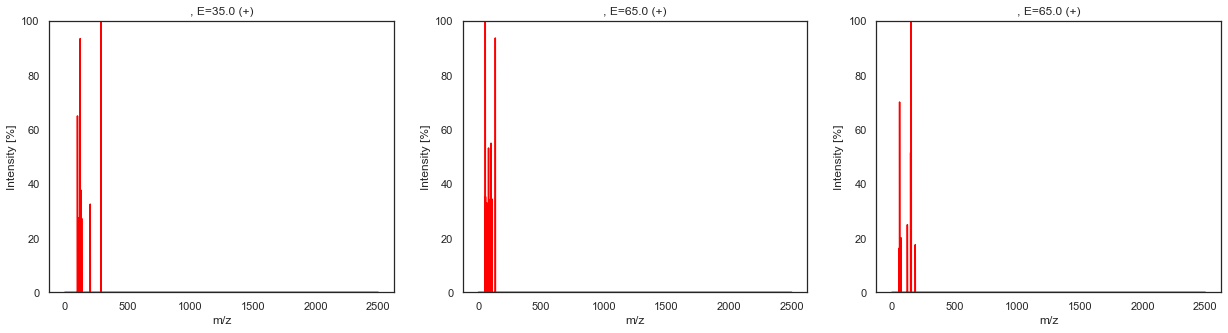

O=C(C=CC=CC1=CC=C2OCOC2=C1)N3CCCCC3
(4, 32)


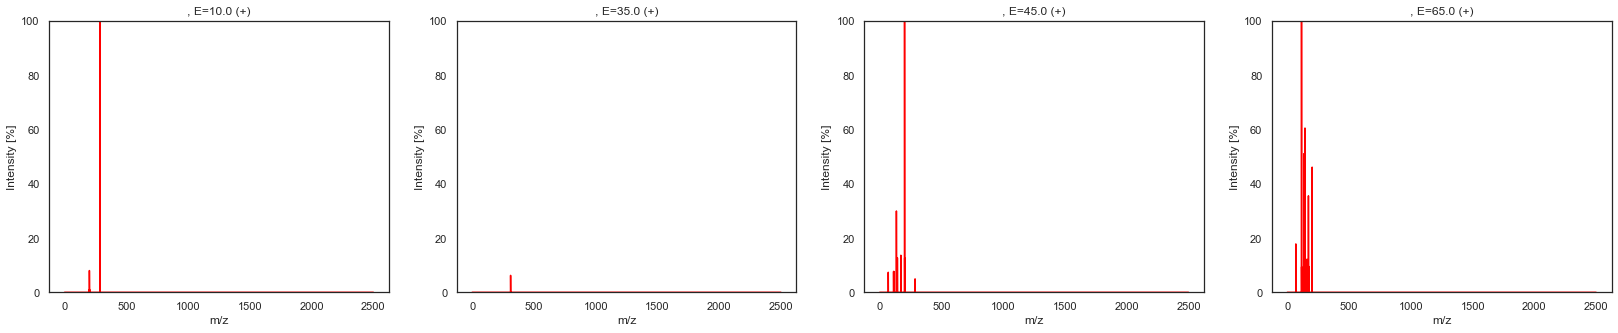

O=C(O)C1(C)C(O)C(O)CC2(C)C1CCC3(C)C2CC=C4C5C(O)(C)C(C)CCC5(C(=O)OC6OC(CO)C(O)C(O)C6O)CCC43C
(3, 32)


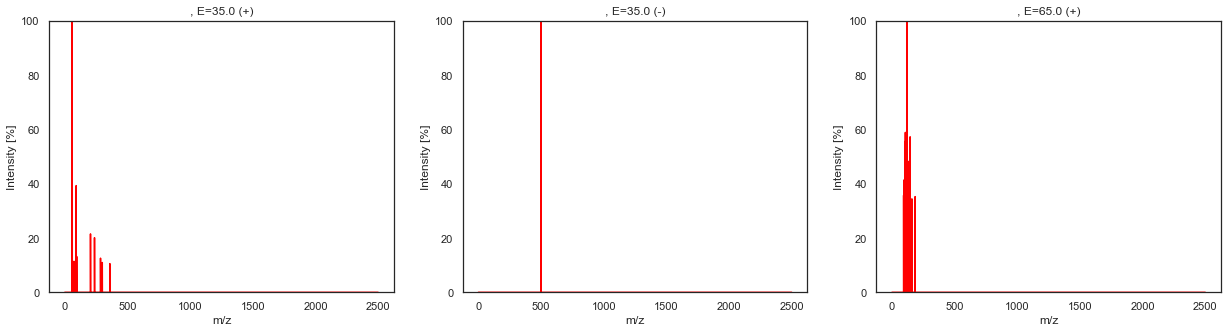

O=C1C=2C(O)=CC(O)=CC2OC(C3=CC=C4OC(CO)C(OC4=C3)C5=CC=C(O)C(OC)=C5)C1O
(3, 32)


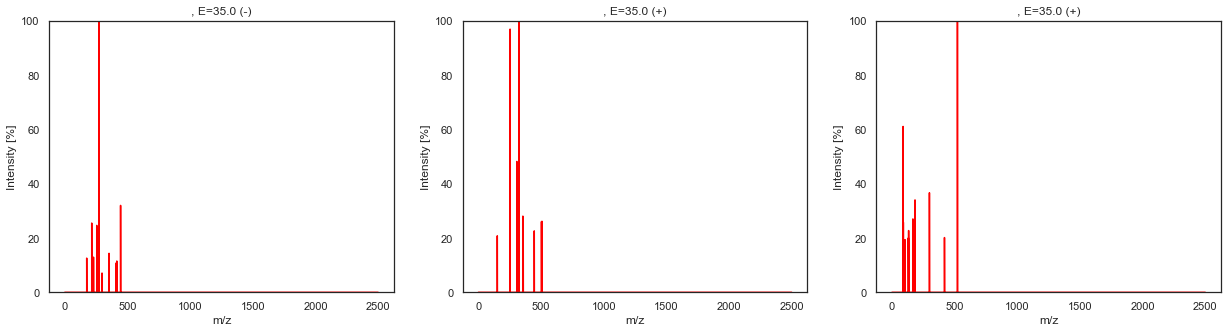

OC1=CC=C(C=C1)CCOC2OC(COC3OCC(O)(CO)C3O)C(O)C(O)C2O
(3, 32)


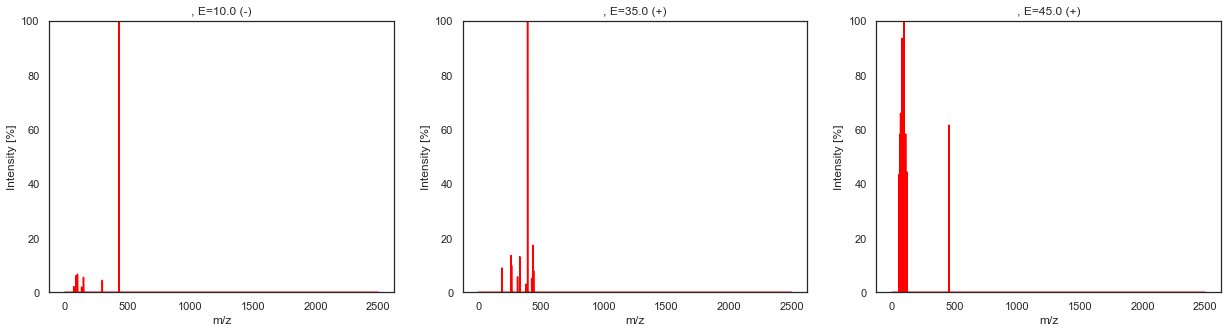

CCN(CC)CCN=C(C1=C(C=C(C(=C1)Cl)N)OC)O
(7, 32)


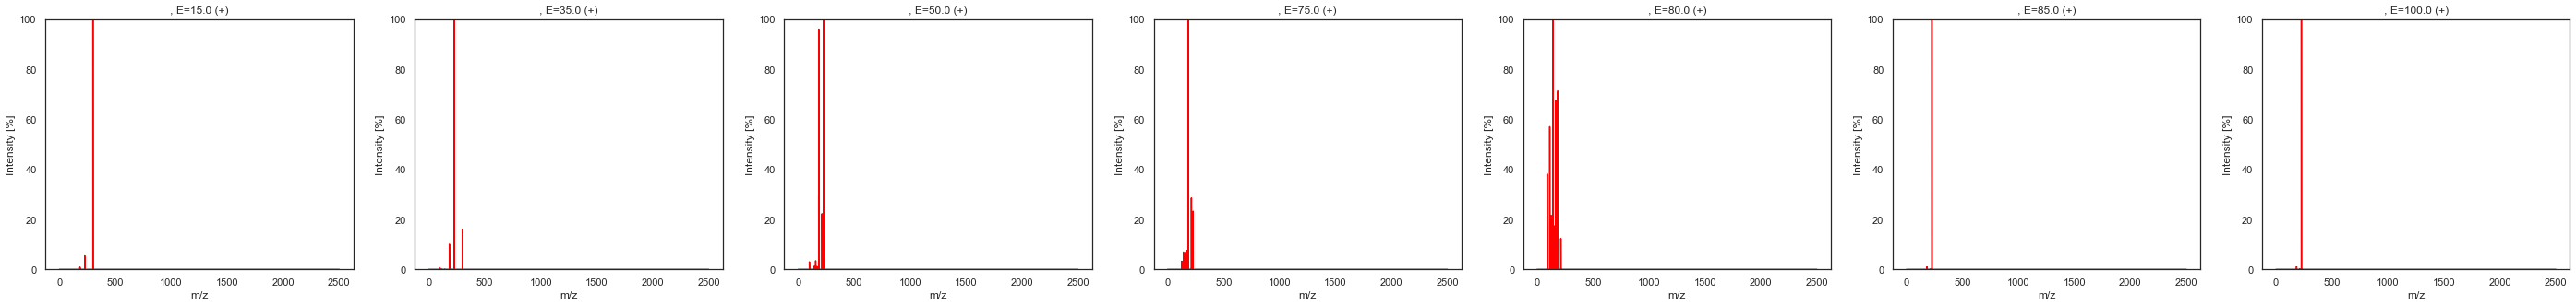

O=C1C=C(OC2=CC(OC3OC(CO)C(O)C(O)C3OC4OC(C)C(O)C(O)C4O)=CC(O)=C12)C=5C=CC(O)=C(OC)C5
(3, 32)


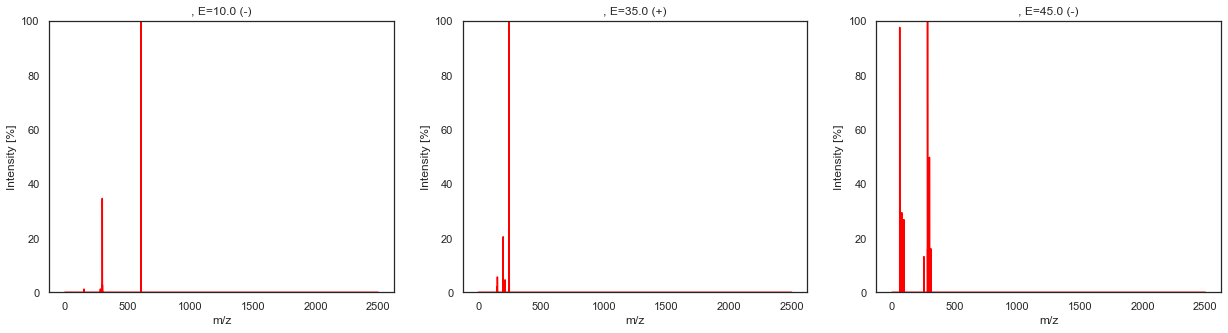

O=C(OCC1OC(OCC(C)C2(O)COC(=O)C2)C(O)C(O)C1O)C=CC3=CC=C(O)C(O)=C3
(3, 32)


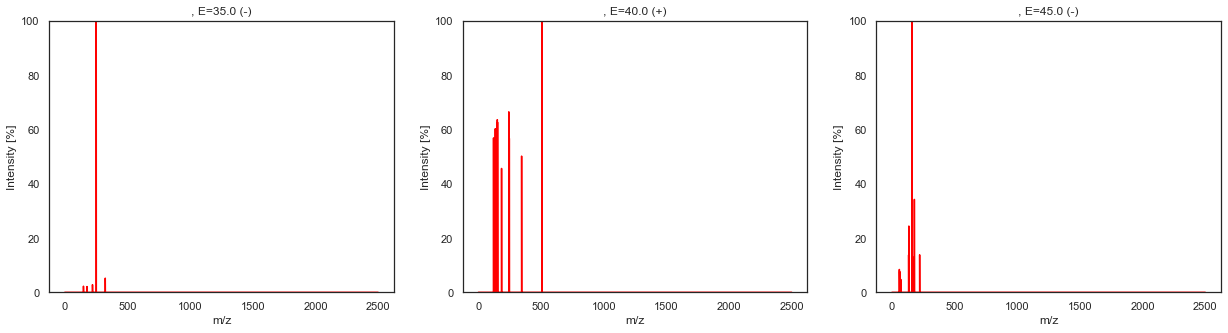

O=C(O)C=CC1=CC=C(OC)C=C1OC2OC(CO)C(O)C(O)C2O
(6, 32)


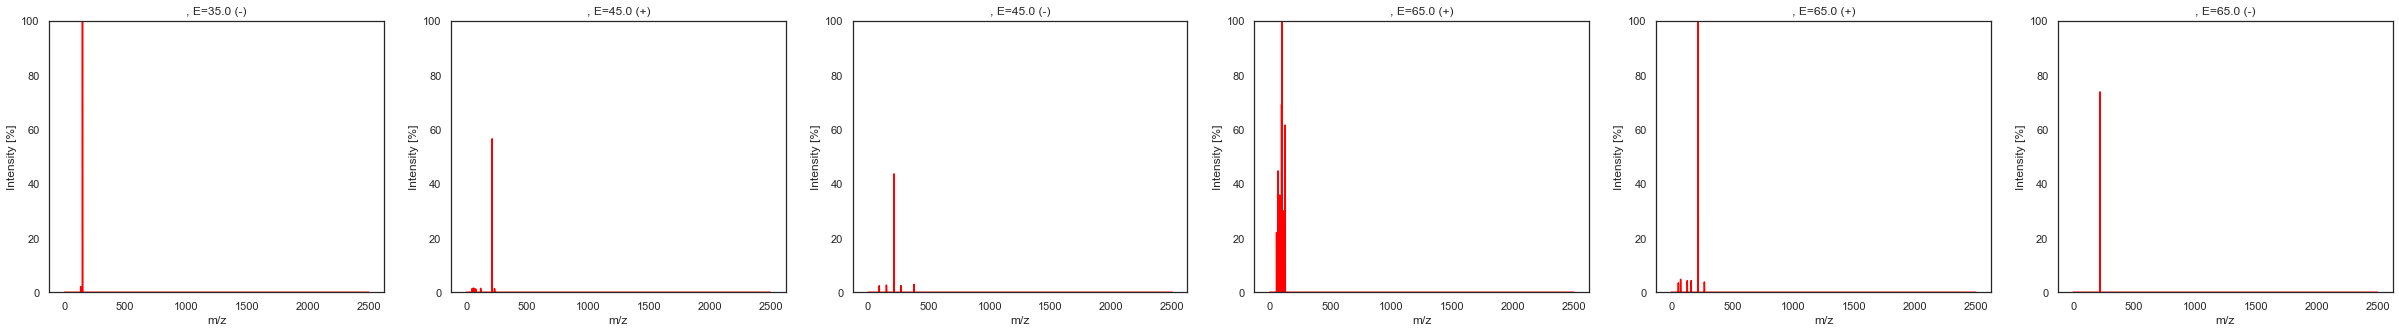

O=CC12CCC(OC3OC(C)C(O)C(OC)C3)CC2(O)CCC4C1CCC5(C)C(C6=CC(=O)OC6)CCC45O
(3, 32)


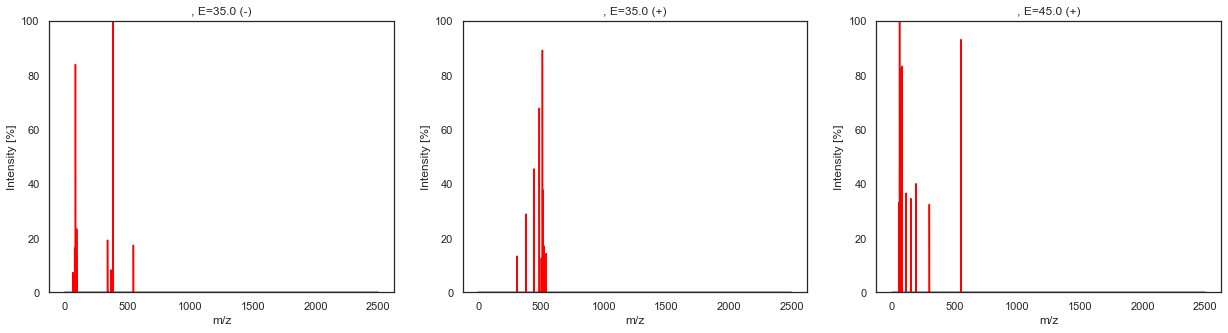

CCCCC1=NC=C(/C=C(\CC2=CC=CS2)/C(=O)O)N1CC3=CC=C(C=C3)C(=O)O
(3, 32)


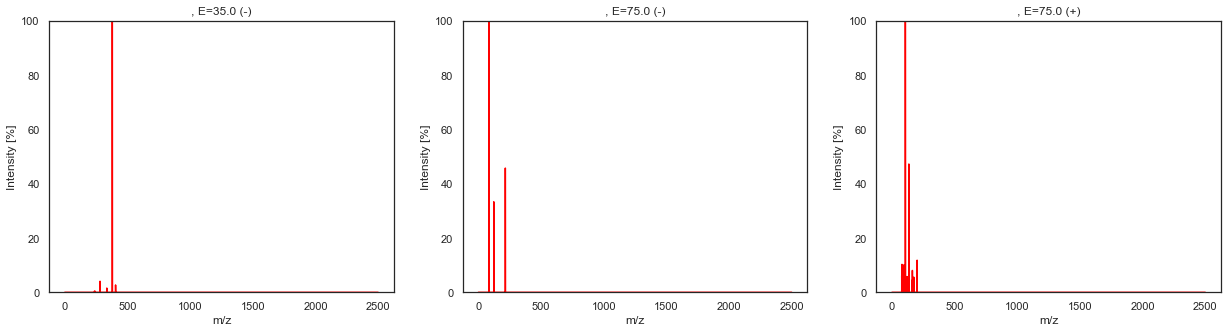

OC(C=C)(C)CCC1C(O)(C)CCC2C(C)(C)CCCC12C
(3, 32)


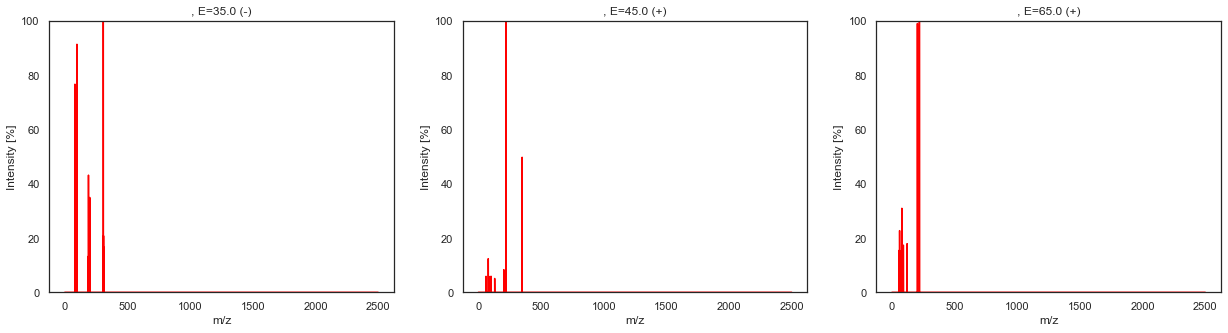

O=C1CCC2C3CCC4=CC(O)=CC=C4C3CCC12C
(3, 32)


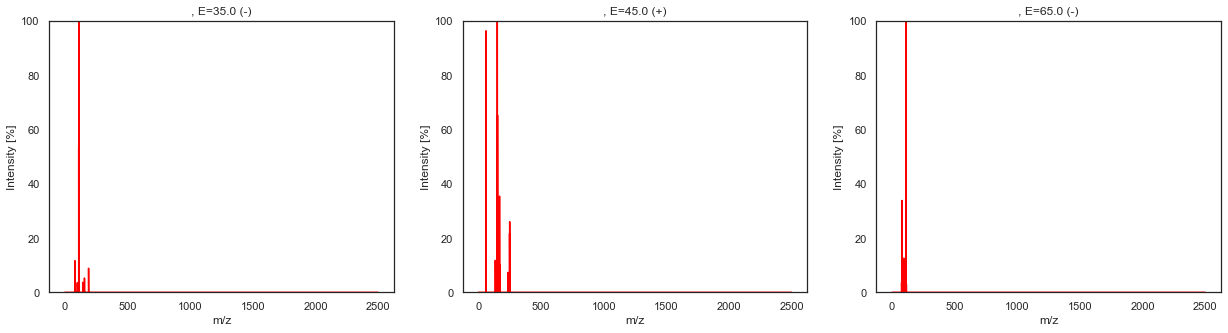

O=C(O)C1(C)CCCC2(C3=CC=C(C=C3C(O)CC12)C(O)(C)C)C
(3, 32)


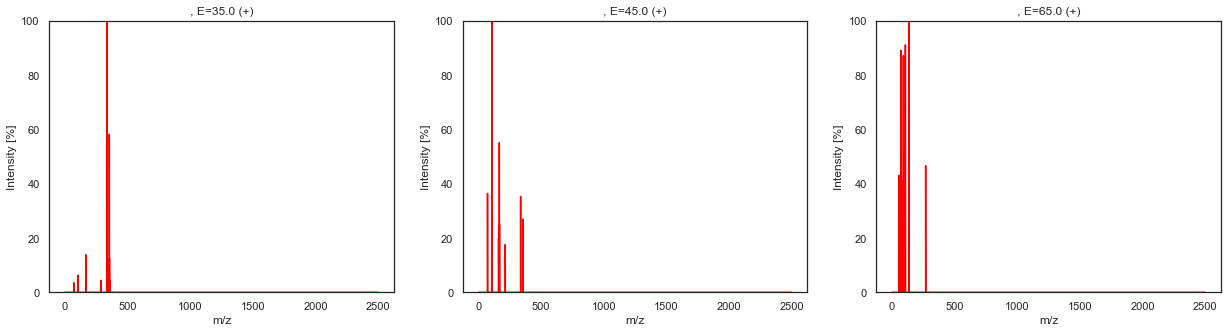

O=C1C2=C(O)C=C(OC3OC(CO)C(O)C(O)C3OC4OC(C)C(O)C(O)C4O)C=C2OC(C5=CC=C(O)C=C5)C1
(6, 32)


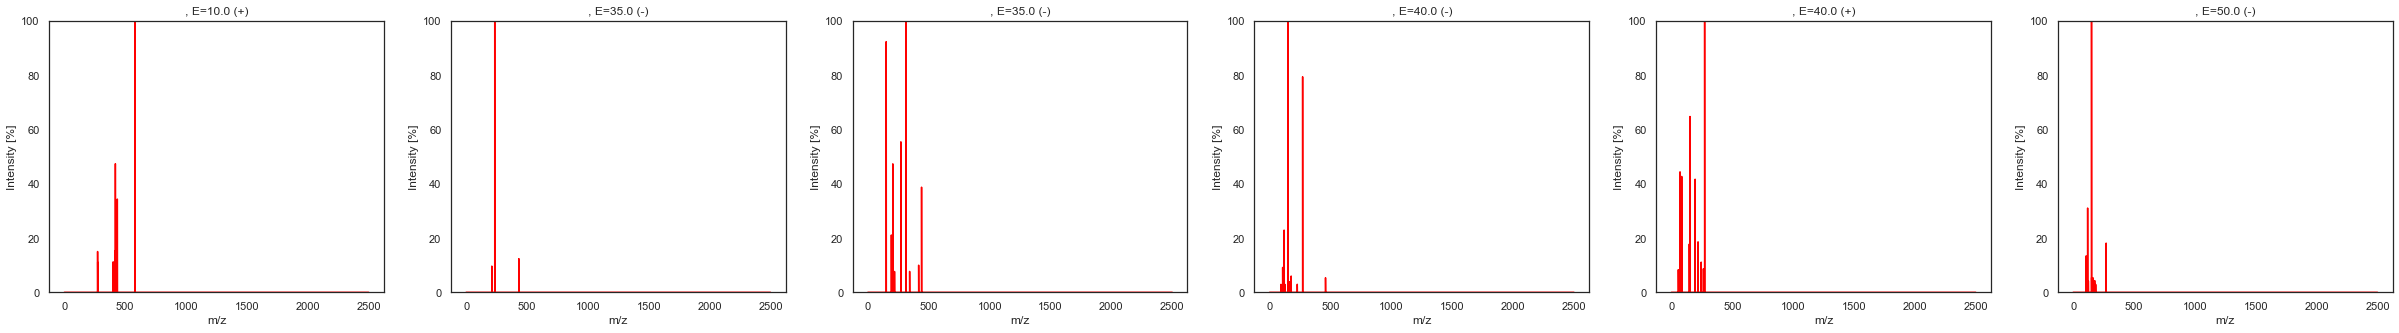

OC1=CC=C(C=C1OC)CC(CO)C(CO)CC2=CC=C(O)C(OC)=C2
(3, 32)


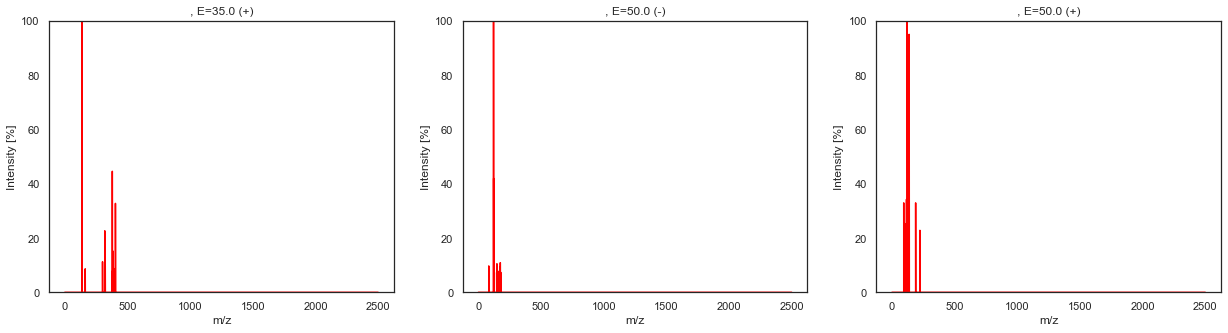

O=C(OC)C1=COC(OC2OC(CO)C(O)C(O)C2O)C3C(=CCC13)CO
(3, 32)


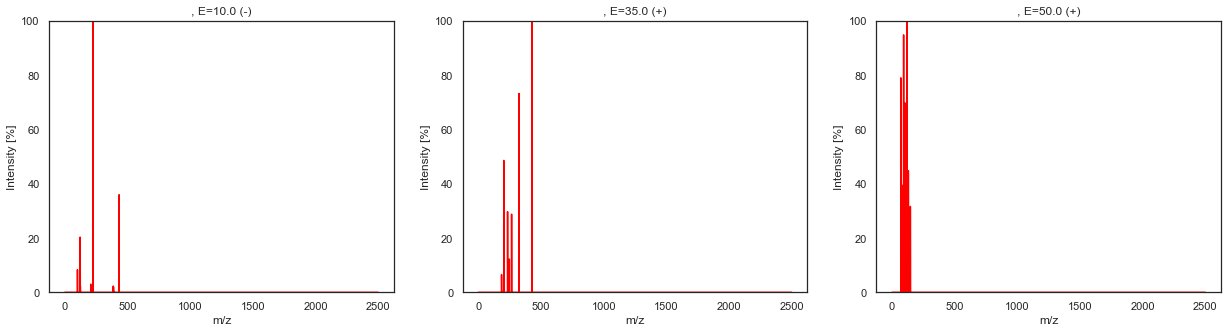

O=C(OC1C(OC)C2=C(C(=O)N(C2)C(C(=O)O)CCC(=O)O)C3(C)CCCC(C)(C)C13)C=CC=CC=CC
(3, 32)


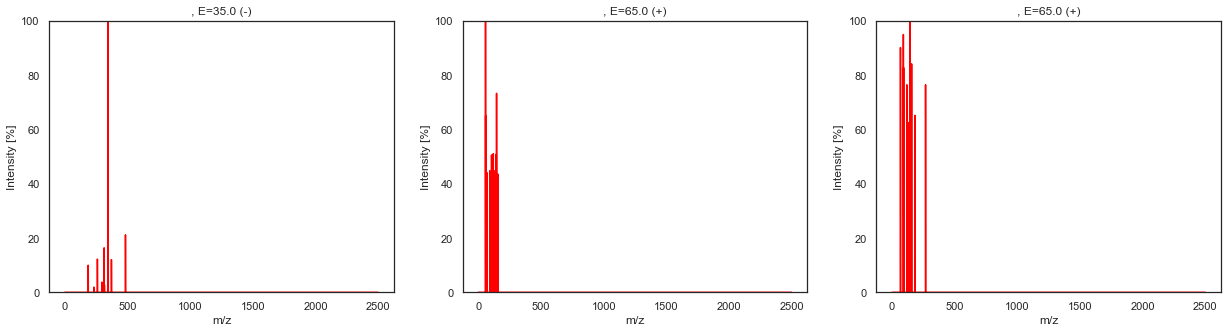

O=C(OC1C(O)C(O)(C)C(C=CC(=O)C)C2(C)CCCC(C)(C)C12)C
(3, 32)


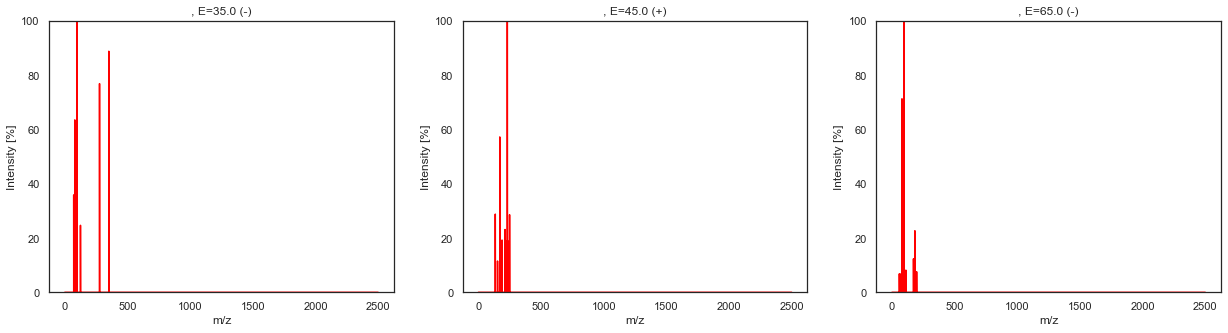

C[C@@H]1C[C@]2([C@H](C)O2)C(=O)O[C@@H]3CCN4CC=C(COC(=O)[C@]1(C)O)[C@H]34
(8, 32)


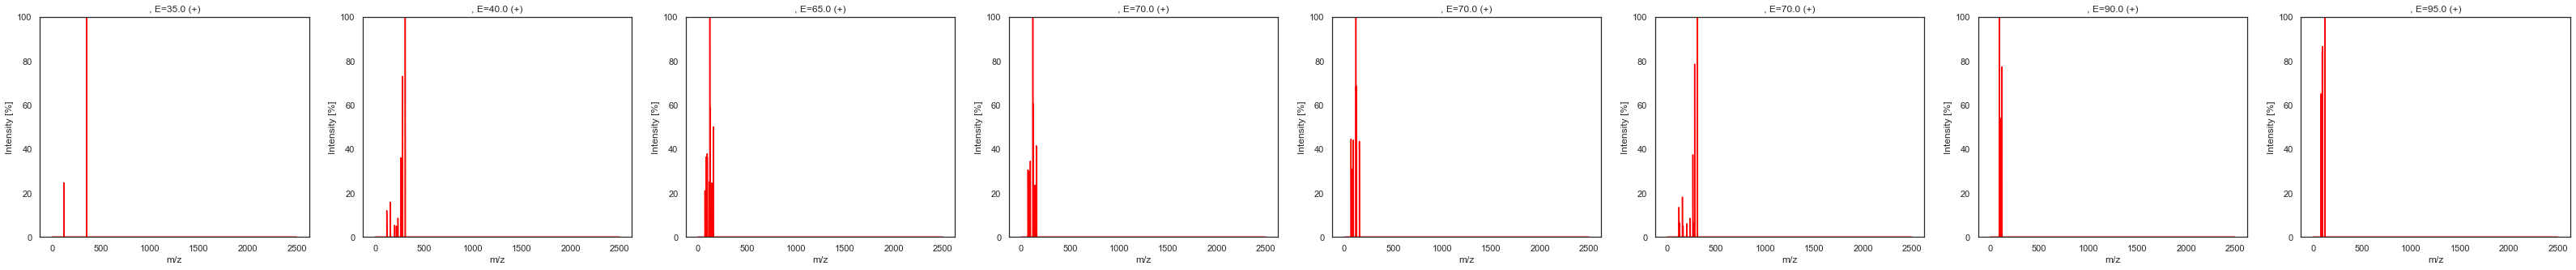

CC1=CC=C(C(=C1)C)N=CN(C)C=NC2=CC=C(C)C=C2C
(4, 32)


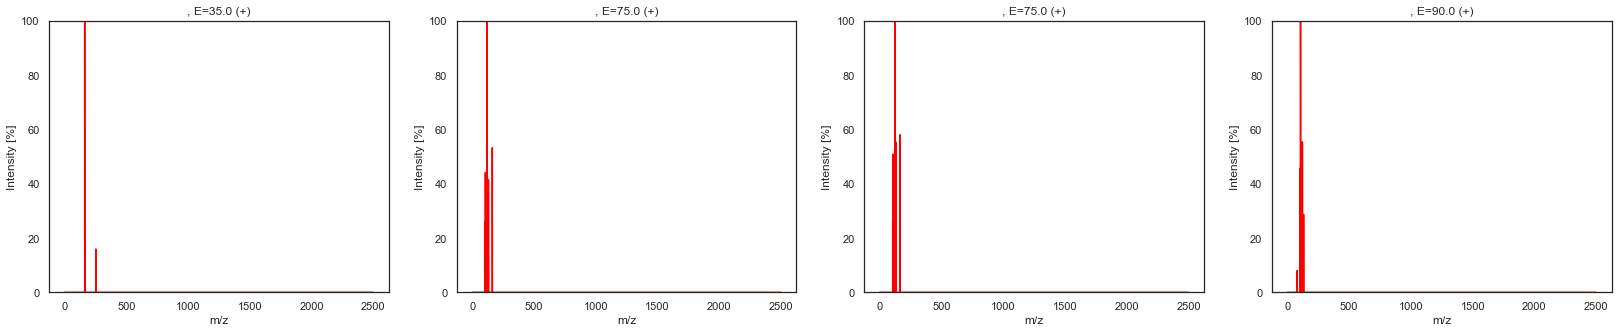

O=C(C=1C(O)=C(C(O)=C(C1OC)C)C)CCC=2C=CC=CC2
(4, 32)


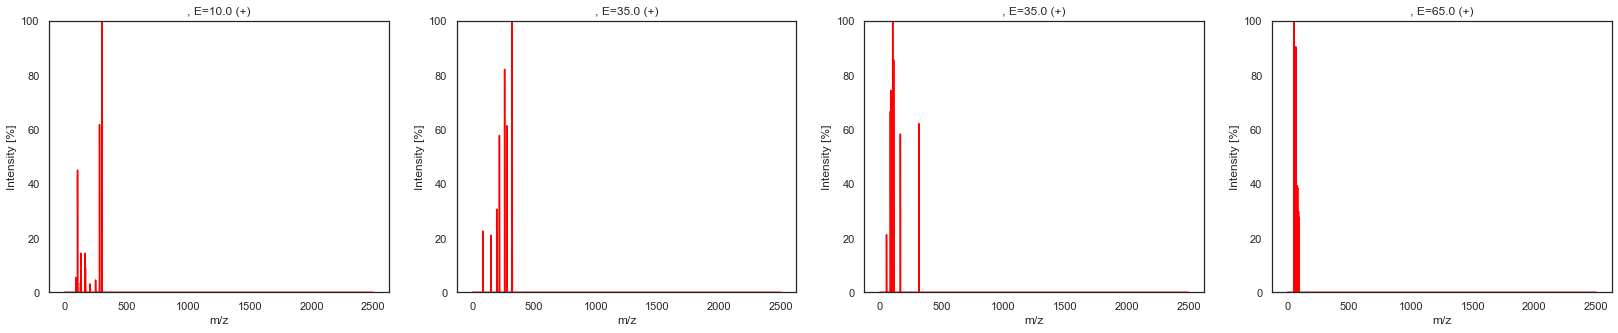

O=C(O)C=1C=NC=CC1
(3, 32)


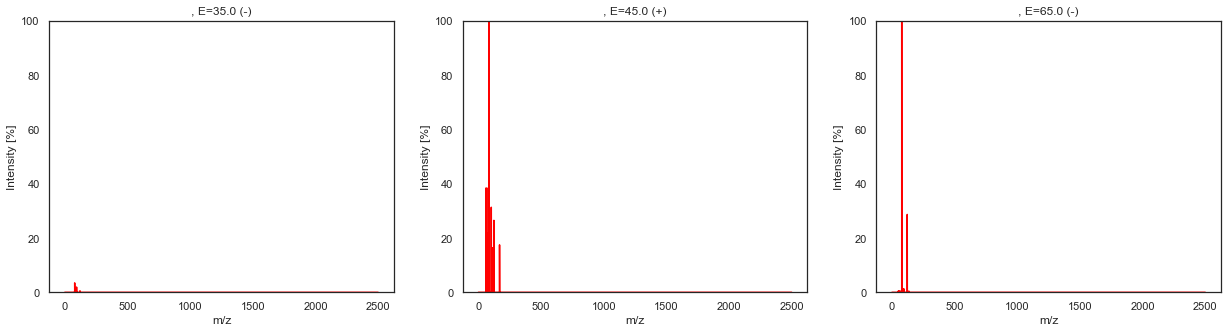

O=C(O)C=CC1=CC(OC)=C(OC)C(OC)=C1
(3, 32)


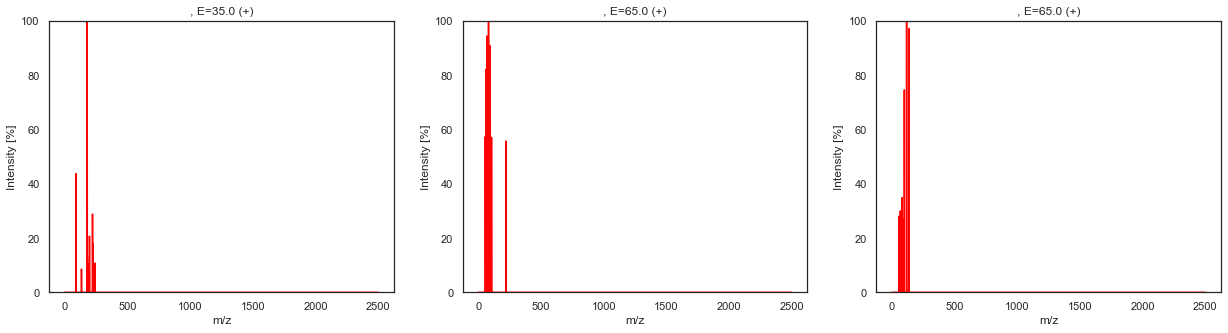

O=C(O)C1OC(OC2C(OC(C(=O)O)C(O)C2O)OC3CCC4(C)C5C(=O)C=C6C7CC(C(=O)O)(C)CCC7(C)CCC6(C)C5(C)CCC4C3(C)C)C(O)C(O)C1O
(5, 32)


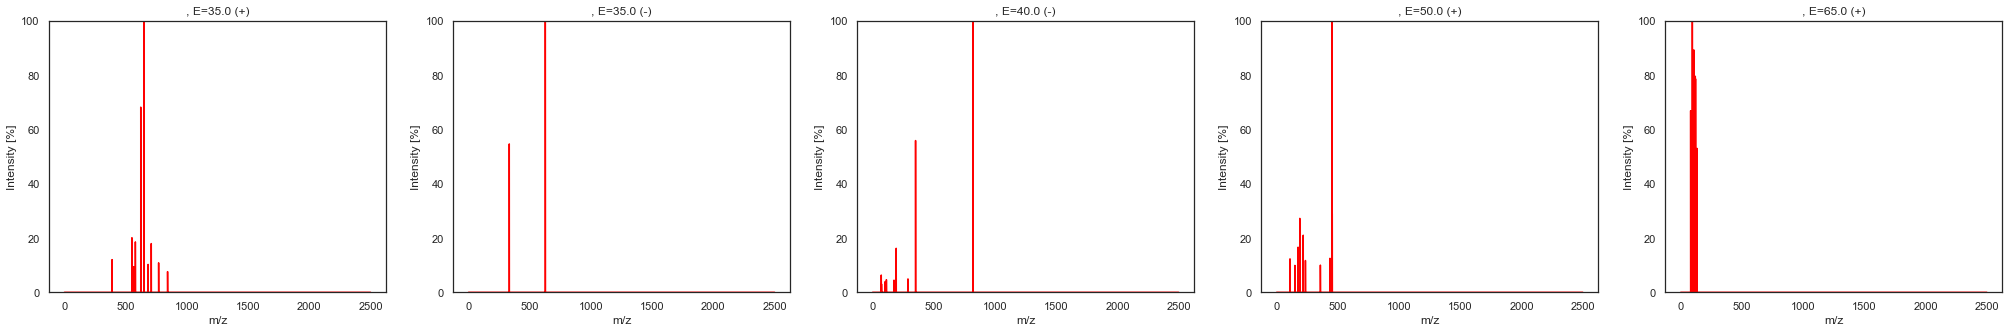

O=C(C=CC1=CC=C(OCC=C(C)C)C=C1)C2=CC=C(O)C=C2O
(3, 32)


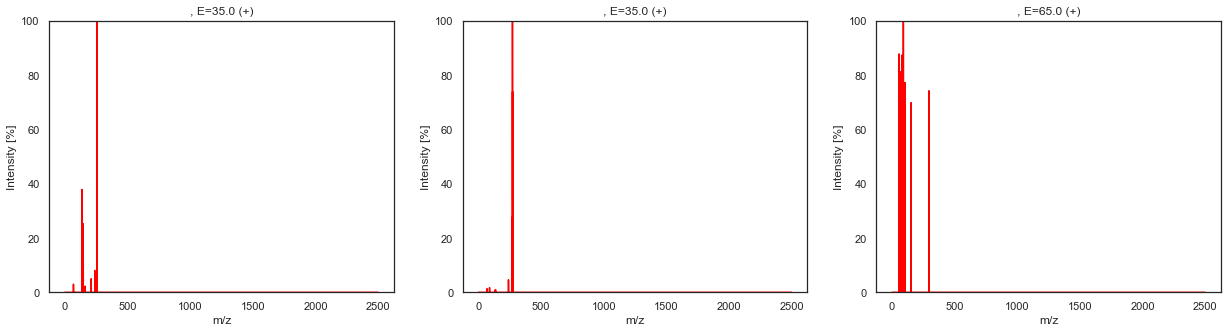

O=C1C2=C(O)C=C(OC3OC(COC4OC(C)C(O)C(O)C4O)C(O)C(O)C3O)C=C2OC(C5=CC=C(OC)C(O)=C5)C1
(5, 32)


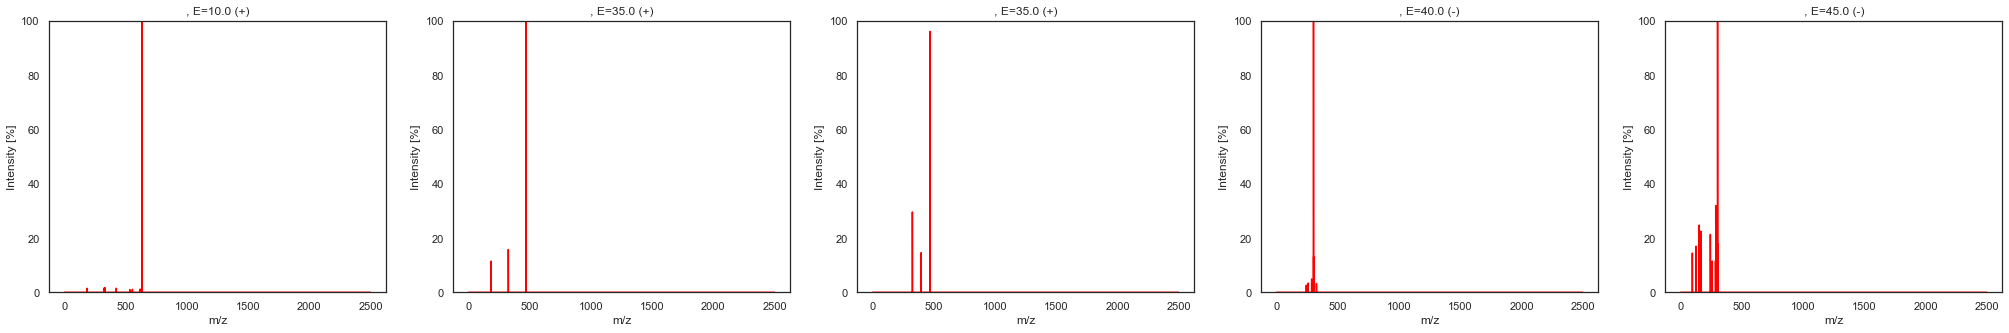

CCC1=C(C(=CC=C1)C)N(C(C)COC)C(=O)CS(=O)(=O)O
(3, 32)


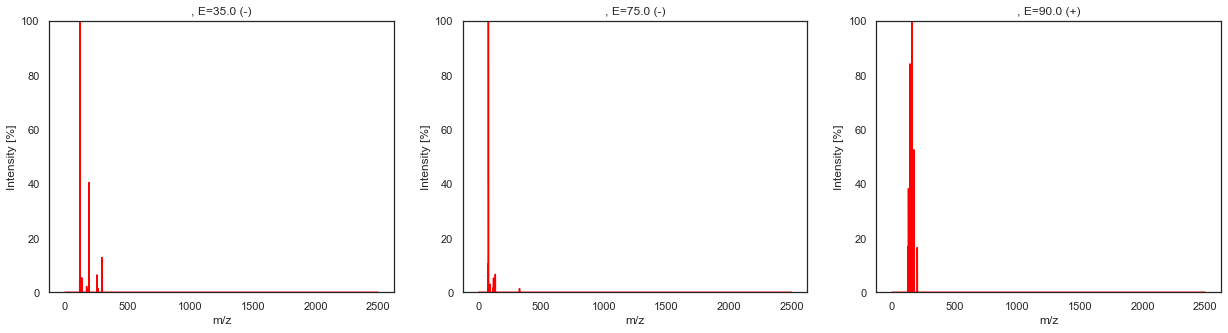

OC1CC(=CCC2(C)CCC(O)(C(C)C)C12)C
(3, 32)


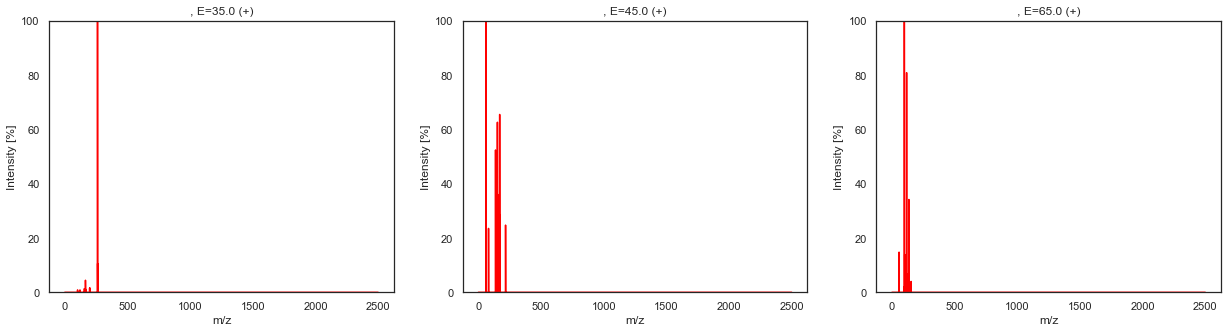

O=C(C=CC1=CC=C(O)C=C1)C2=CC=C(O)C=C2O
(5, 32)


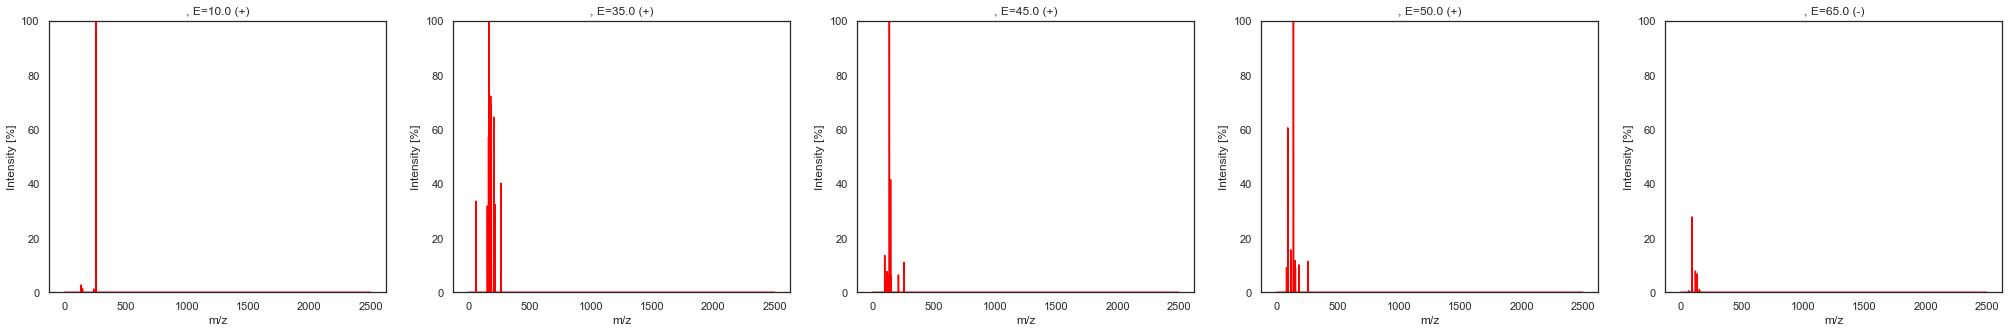

CC1=CC=CC(=C1C)NC2=C(C=CC=C2)C(=O)O
(3, 32)


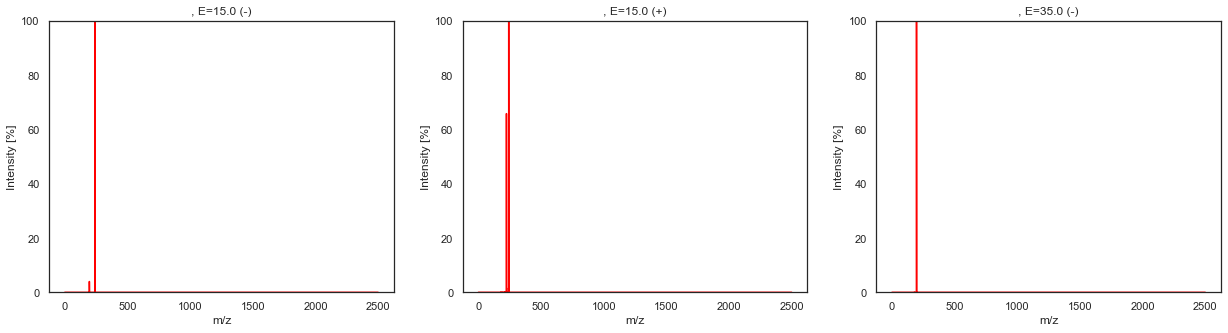

O=C1N(C)C(C(O)=NC(C(=O)N(C)C(C(O)=NC(C(O)=NC(C(=O)N(C)C(C(=O)N(C)C(C(=O)N(C)C(C(=O)N(C)C(C(O)=NC(C(=O)N(C)C1)CC)C(O)C(C)CC=CC)C(C)C)CC(C)C)CC(C)C)C)C)CC(C)C)C(C)C)CC(C)C
(3, 32)


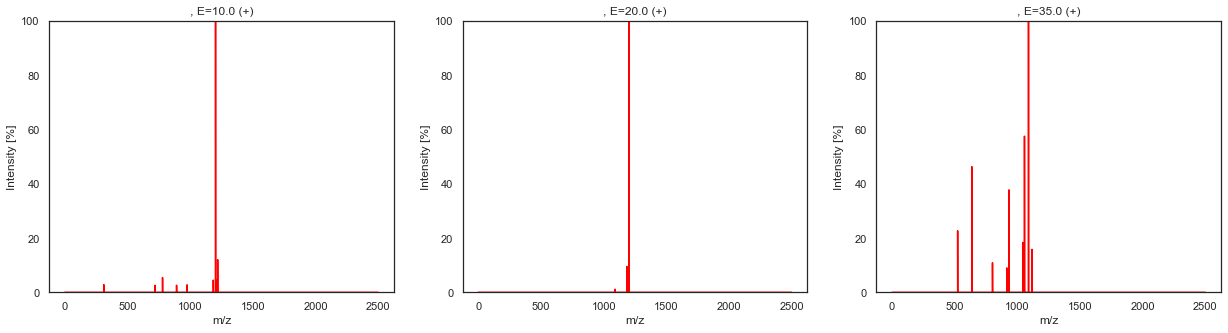

CCC(CC)O[C@@H]1C=C(C[C@@H]([C@H]1N=C(C)O)N)C(=O)OCC
(3, 32)


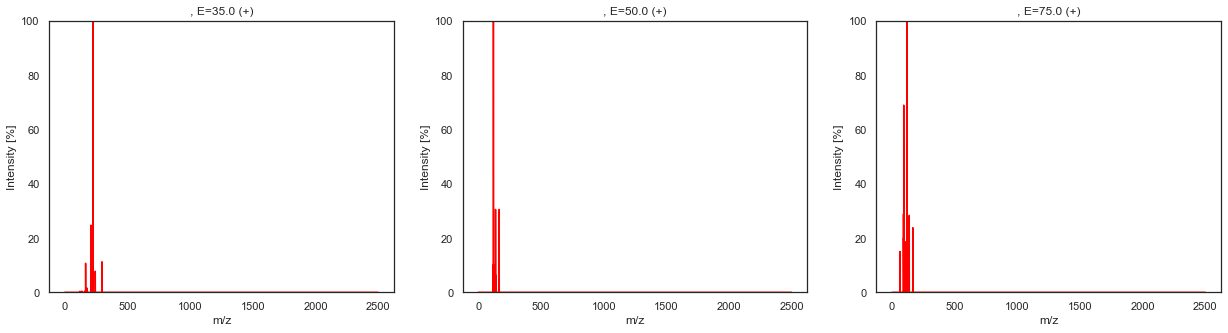

O=C1C(OC=2C=C(O)C=C(O)C12)=CC3=CC=C(OC)C(O)=C3
(3, 32)


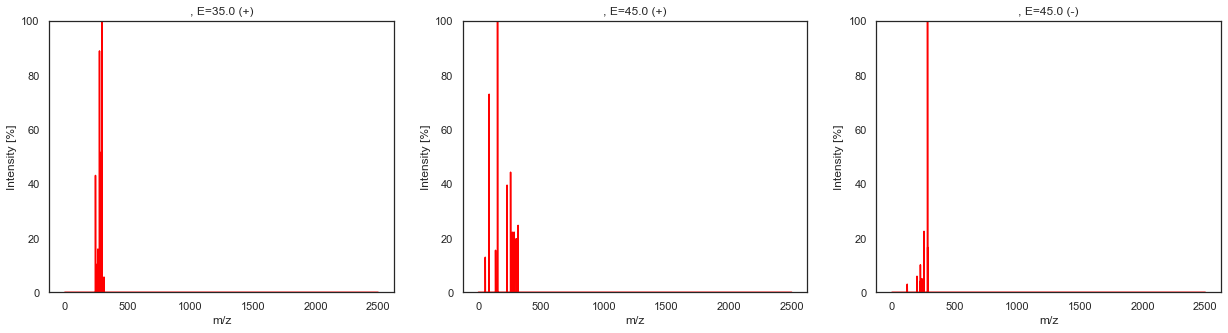

O=C1C(OC2OC(COC3OC(C)C(O)C(OC4OC(C)C(O)C(O)C4O)C3O)C(O)C(O)C2O)=C(OC=5C=C(O)C=C(O)C15)C=6C=CC(O)=CC6
(4, 32)


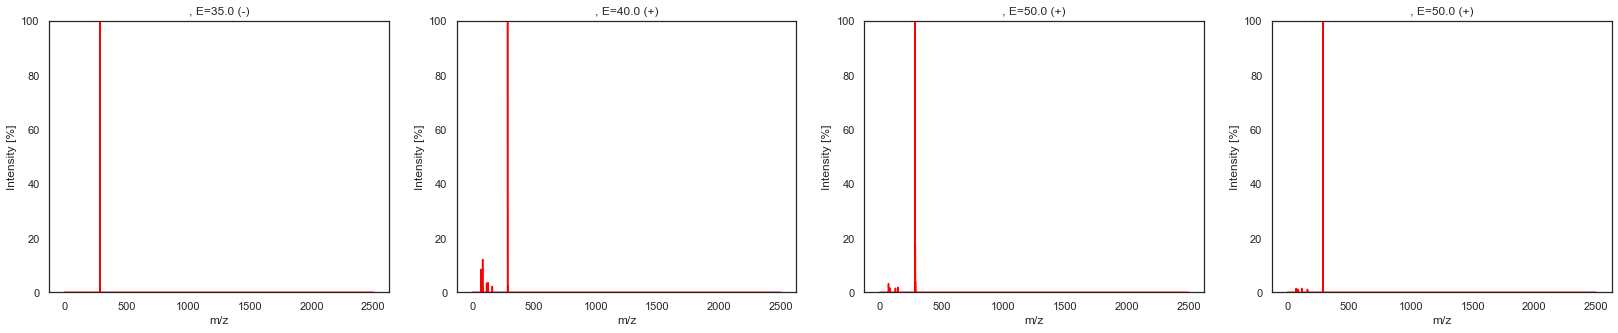

O=C1C(OC2OC(COC3OC(C)C(O)C(O)C3O)C(O)C(O)C2O)=C(OC=4C=C(O)C=C(O)C14)C=5C=CC(O)=C(O)C5
(4, 32)


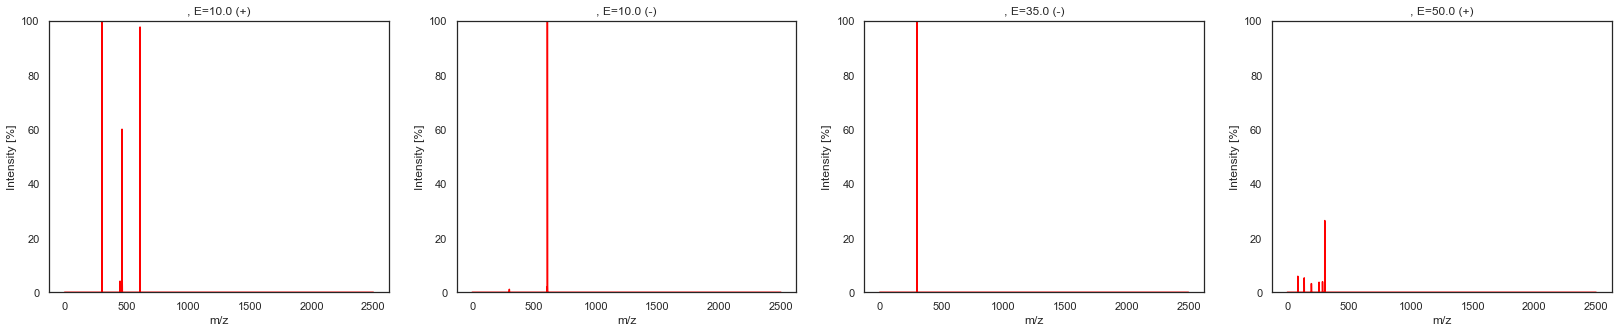

O=C1C(=COC=2C=C(O)C=C(O)C12)C(C(=O)C=3C(O)=CC(O)=CC3O)C(C4=CC=C(O)C=C4)C5=CC=C(O)C=C5
(3, 32)


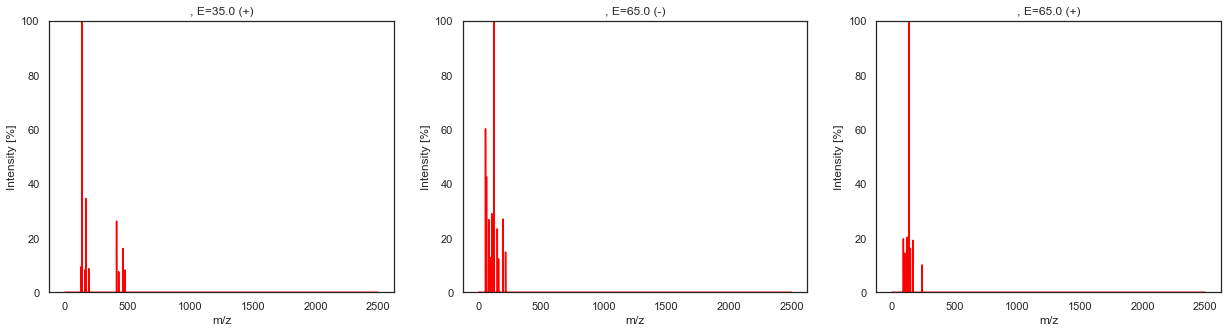

C1=CC2=C(C=C1)N=NN2
(5, 32)


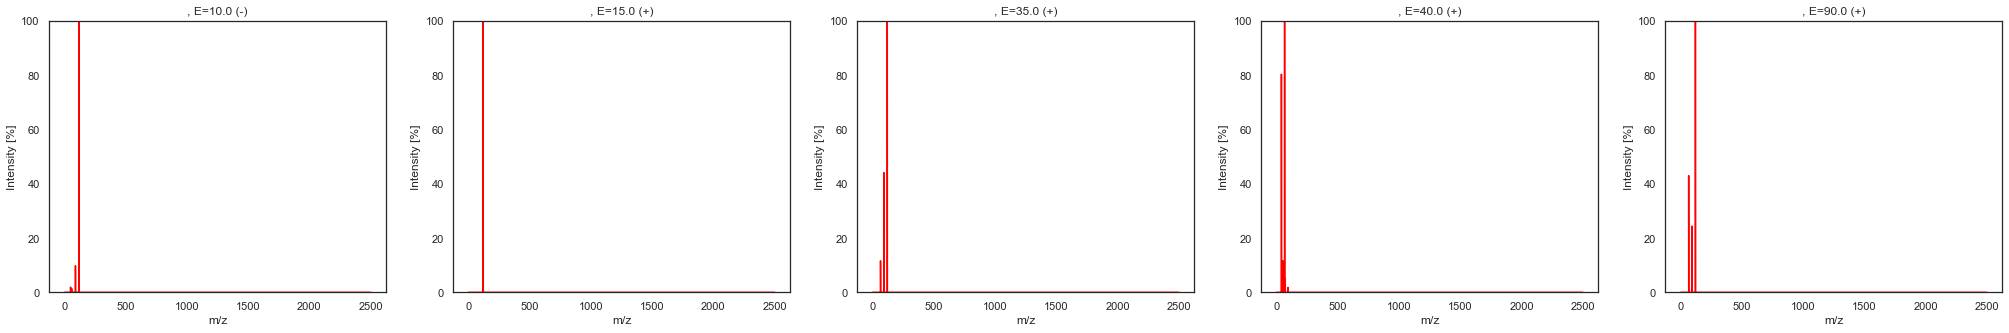

O=C1C2=CC=C(O)C=C2OC(C3=CC=C(O)C(O)=C3)C1O
(4, 32)


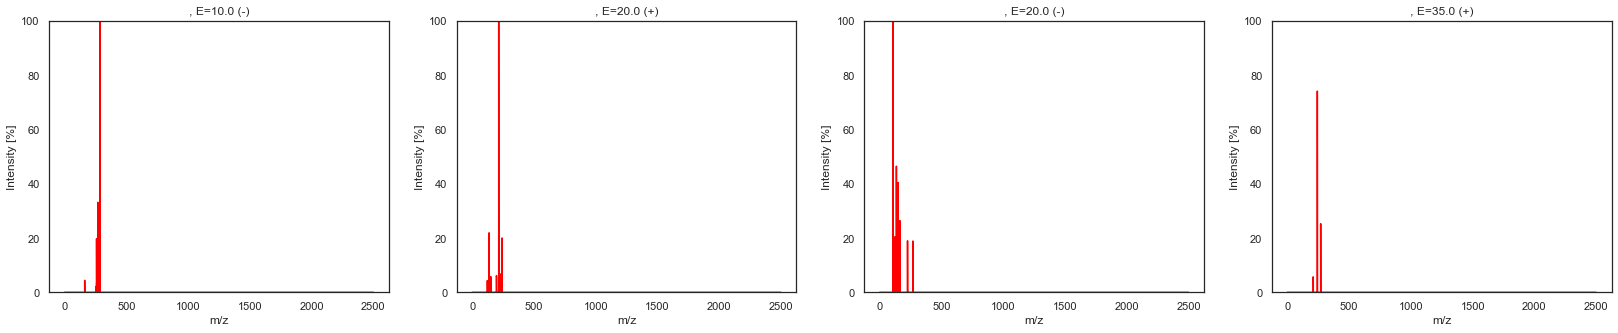

O=CC1=C(O)C=C(C(C(=O)OCC)=C1O)C
(3, 32)


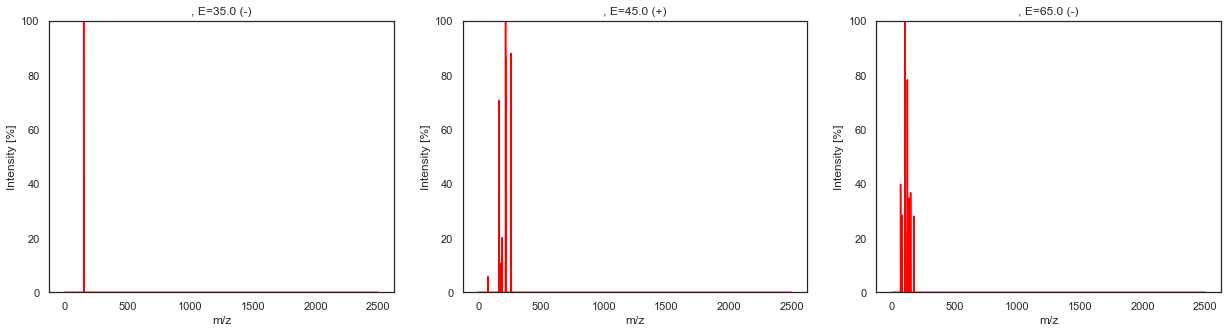

O=C(OC1CC(O)(C(=O)OC)CC(O)C1O)C=CC2=CC=C(O)C(O)=C2
(4, 32)


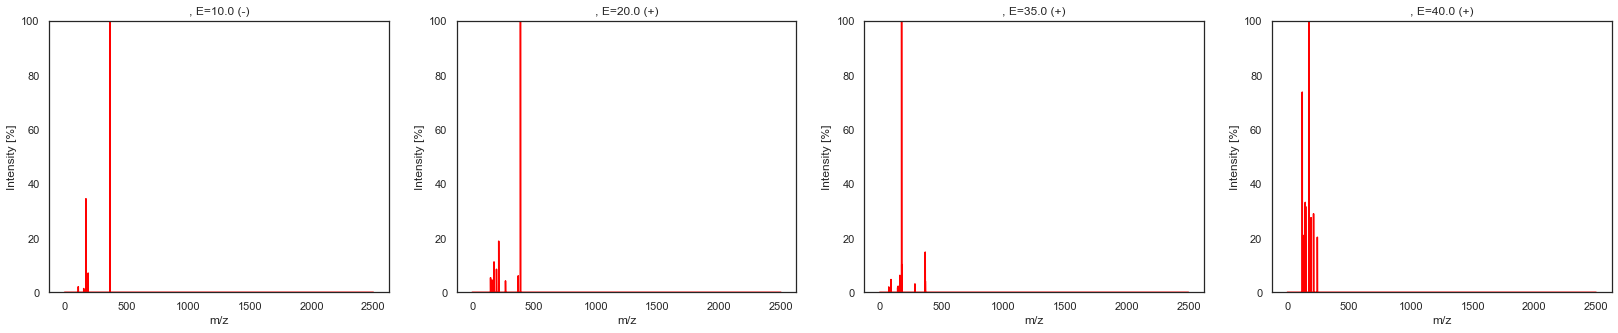

OC=1C=CC=CC1N=C(O)C
(3, 32)


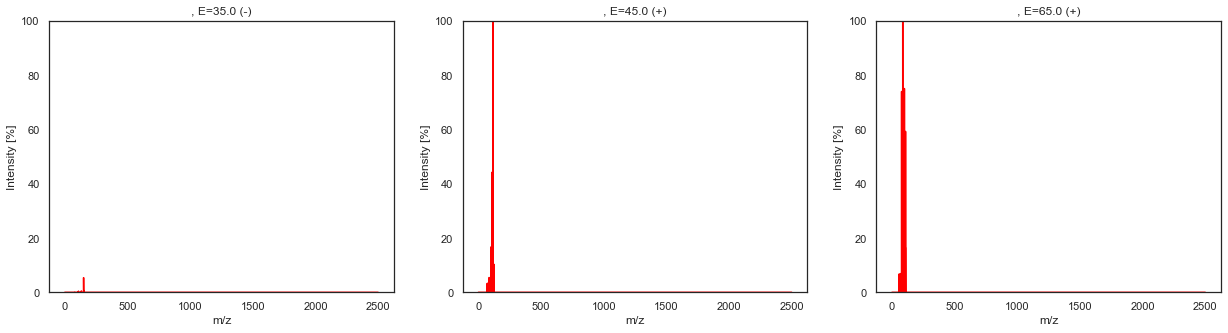

O=C1C=C(OC2=CC(O)=C(O)C(O)=C12)C=3C=CC=CC3
(5, 32)


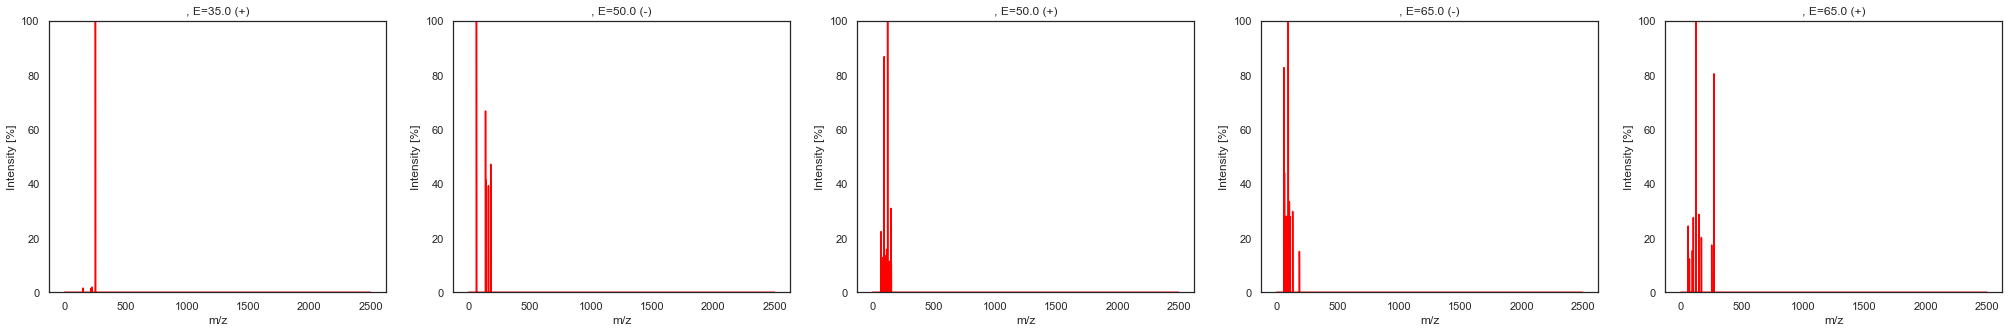

O=C1OC(C2=COC=C2)C3(C)CCC4C5(OC5C6(O)C(=O)C4(C)C(C(O)C(=O)OC)C(C)(C)C6OC(=O)C(C)C)C3C1
(3, 32)


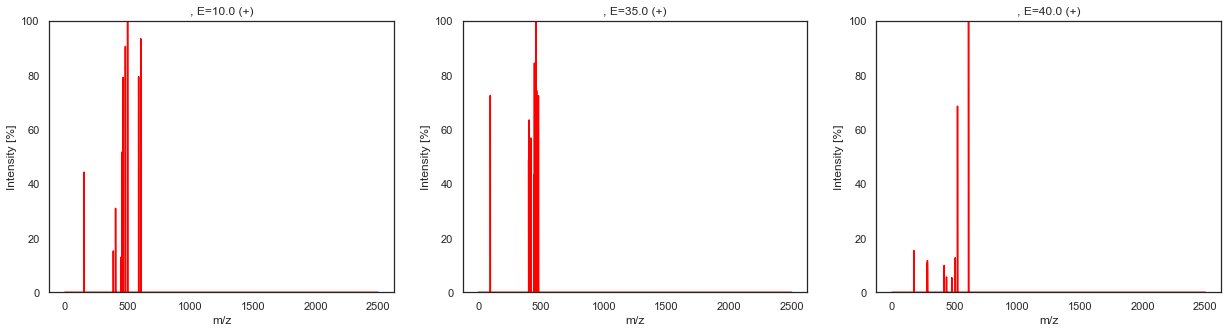

CCCC1=NC2=C(C=C(C=C2C)C3=NC4=C(C=CC=C4)N3C)N1CC5=CC=C(C=C5)C6=C(C=CC=C6)C(=O)O
(3, 32)


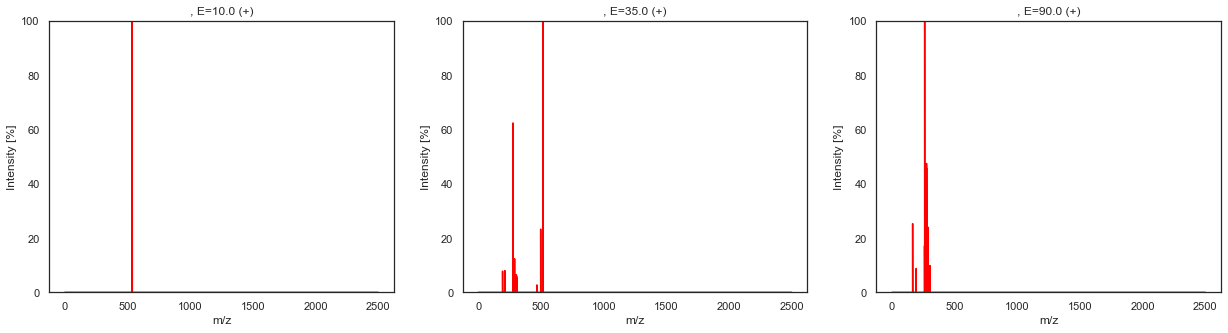

O=C1OC=2C=C(O)C=CC2C=C1
(3, 32)


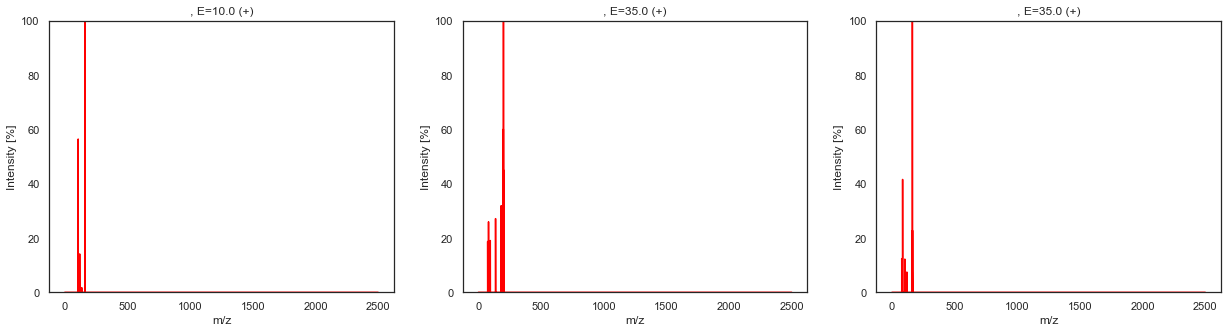

OC=1C(=NC=C(C1CO)CO)C
(3, 32)


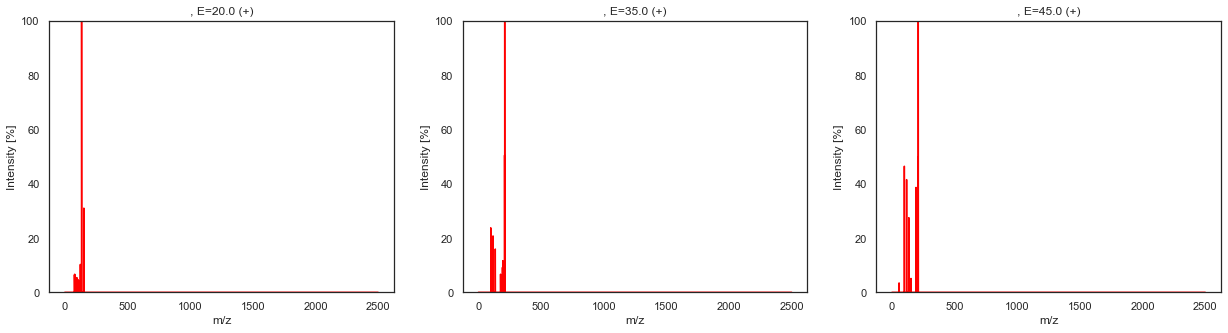

O=C1OC2C=C(C)CCC=C(CO)CC(O)C2C1=C
(4, 32)


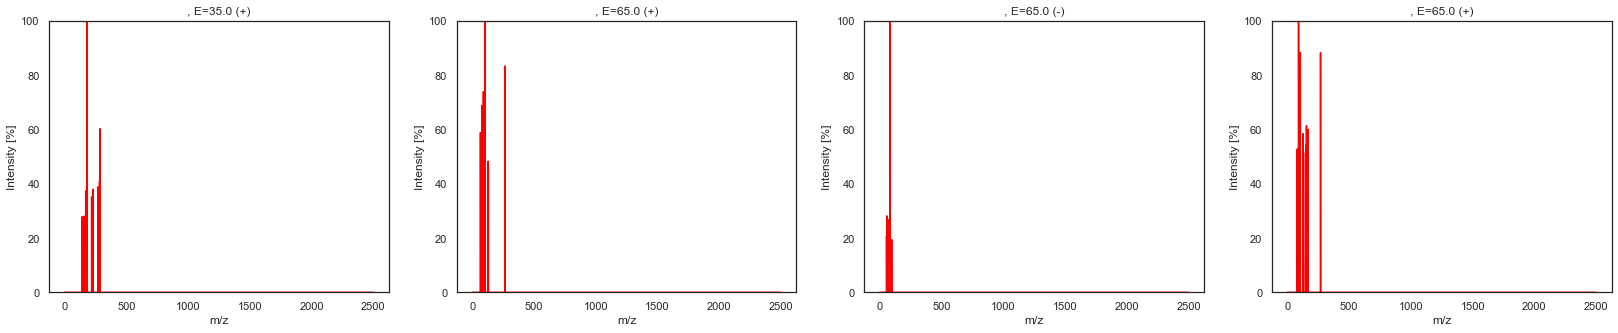

O=C1OC(O)(C)C(C)C1CC(=O)C(C(=O)OC)(C)CC
(3, 32)


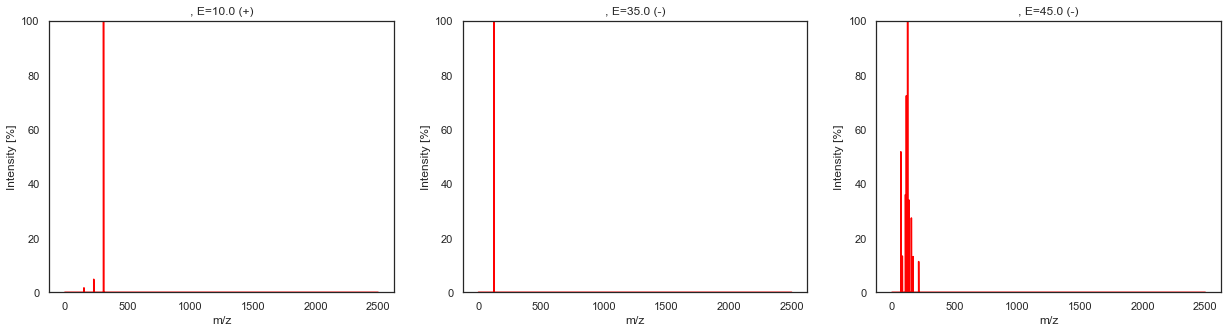

O=C1C=C2C(CCC3(C)C(CCC23O)C(O)(C)C(O)CCC(O)(C)C)C4(C)CC(O)C(O)CC14
(3, 32)


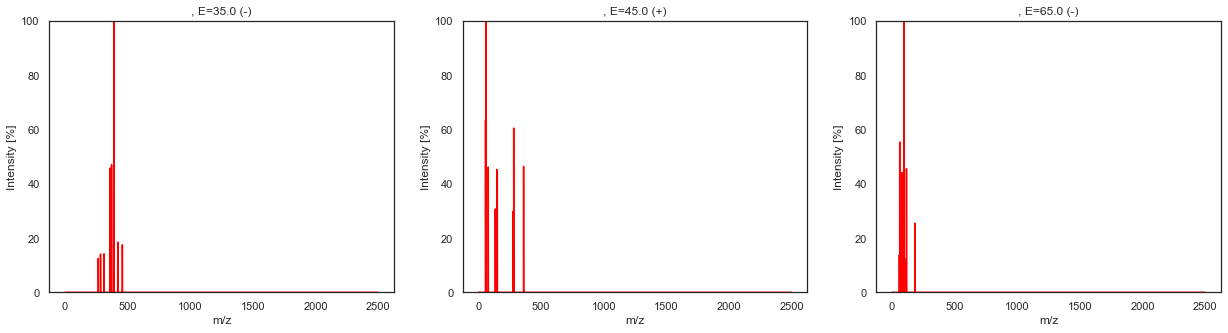

O=C(OC1C(OC(=O)C)C(O)(C(=O)C2OC2C(C)CC3OC(=O)C(=C)C31)C)C(=C)C
(4, 32)


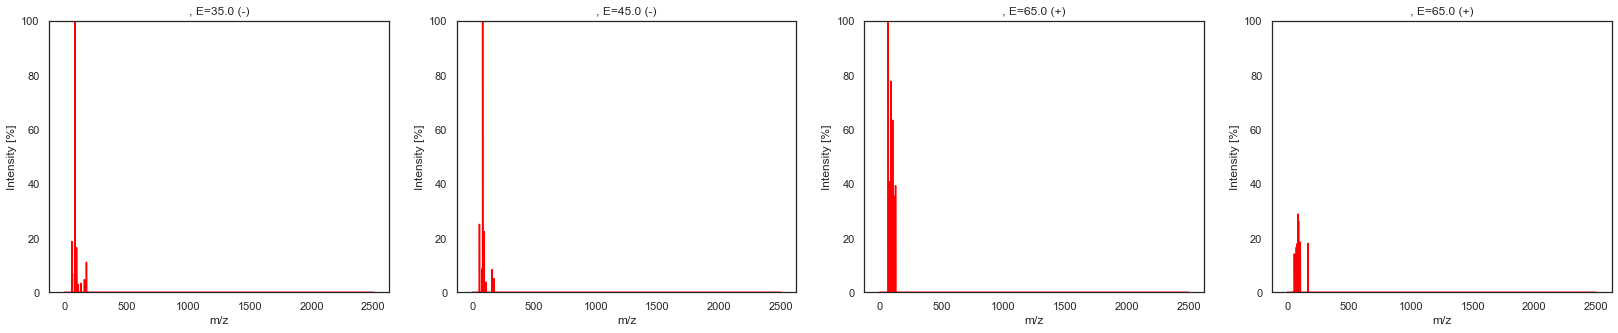

C[C@@H]1C[C@]2(C=C(C)C3(CC3)[C@](C)([C@H]2C1=O)O)O[C@H]4[C@@H]([C@H]([C@@H]([C@@H](CO)O4)O)O)O
(4, 32)


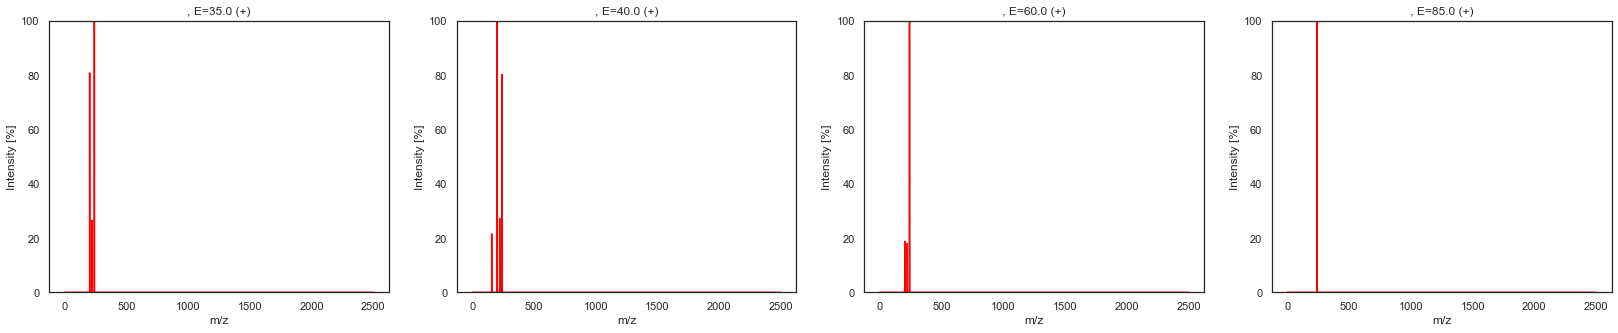

O=C1C=2C(O)=CC(O)=CC2OC(C=3C=C(C(OC)=C(C3)CC=C(C)C)CC=C(C)C)C1
(3, 32)


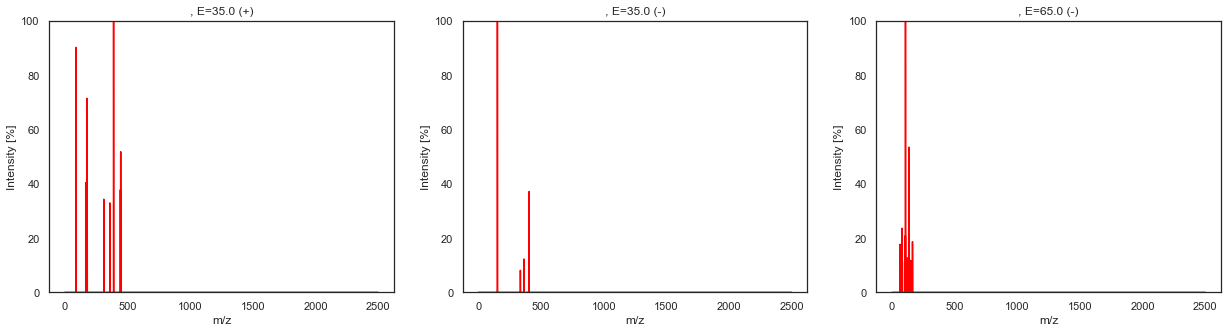

O=C(O)C(CO)C(C=CC=CCCC)CCC(=O)OC
(3, 32)


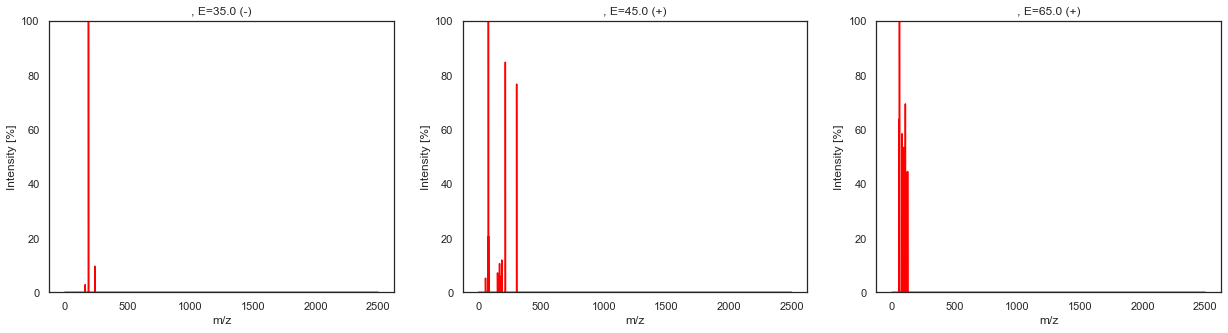

O=C(O)C1=CC(=O)CC2C1(C)CCC(C)C2(C)CCC(C)CC(=O)O
(3, 32)


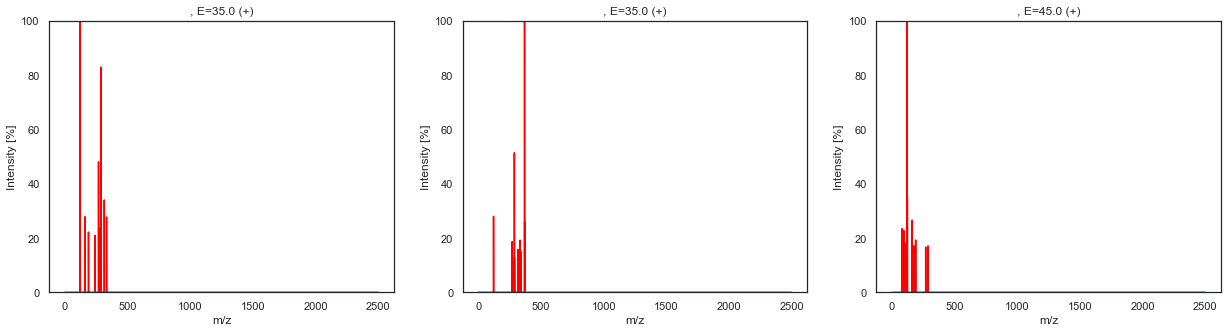

O=C(OC)C(O)C=1C=CC=CC1
(3, 32)


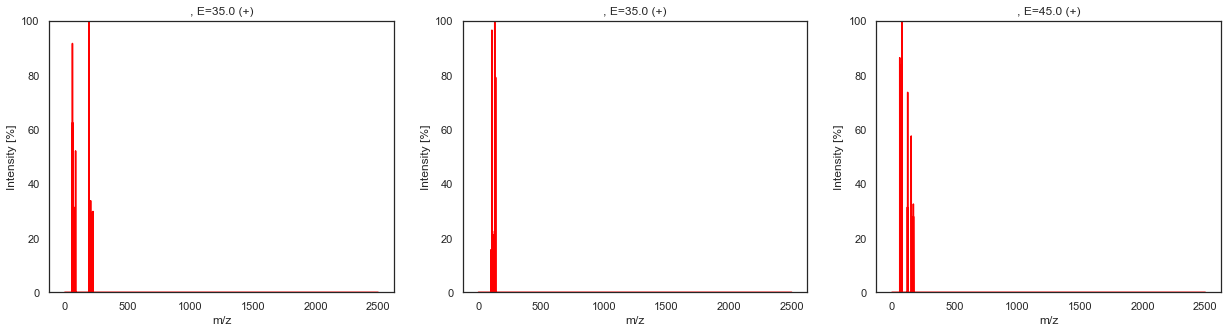

O=C1OC2(OC)C(=C1)C(C)C3C(O)C(OC(=O)C)C4C(C)(COC(=O)C)CCCC4(C)C3C2
(4, 32)


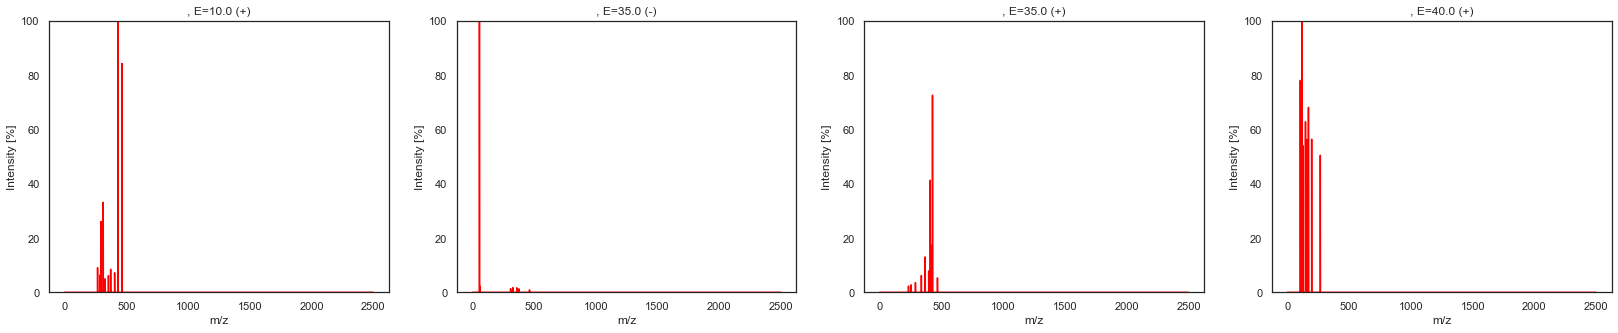

OC=1C=C(OC2OC(CO)C(O)C(O)C2O)C=C(C=CC3=CC=C(O)C(OC)=C3)C1
(3, 32)


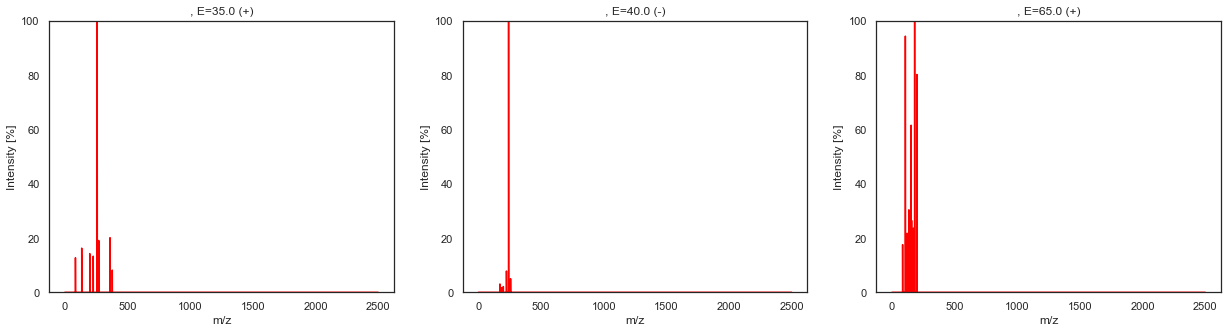

O=C1C(OC2OC(CO)C(O)C(O)C2OC3OC(CO)C(O)C(O)C3O)=C(OC=4C=C(O)C=C(O)C14)C=5C=CC(O)=CC5
(5, 32)


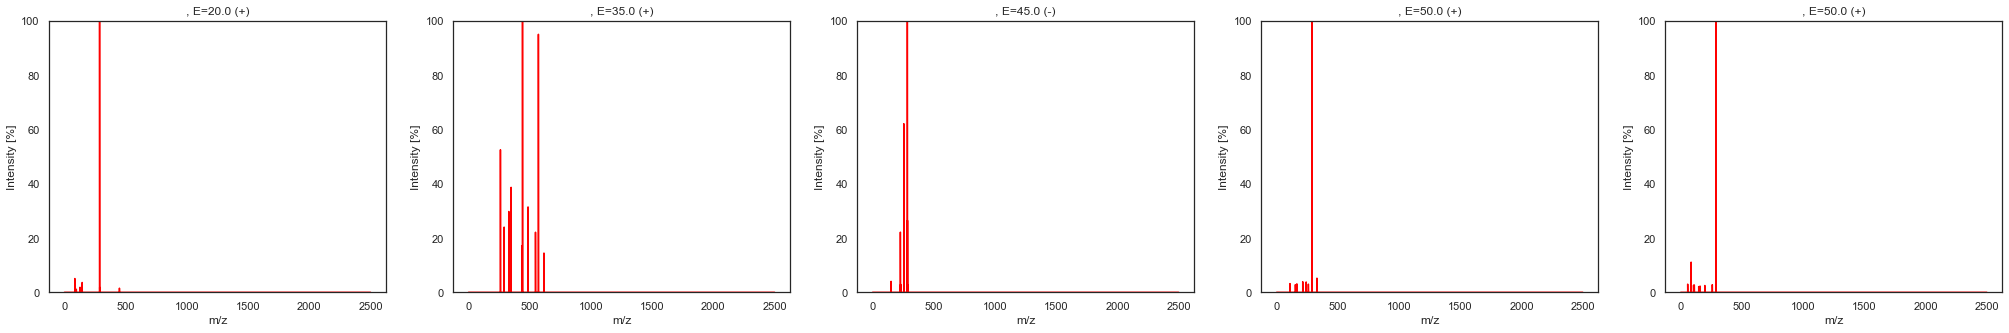

O=C(OC1C(=O)C(=C(CCC(C)CC(=O)O)C2(C)CCCC(C)(C)C12)C)C
(3, 32)


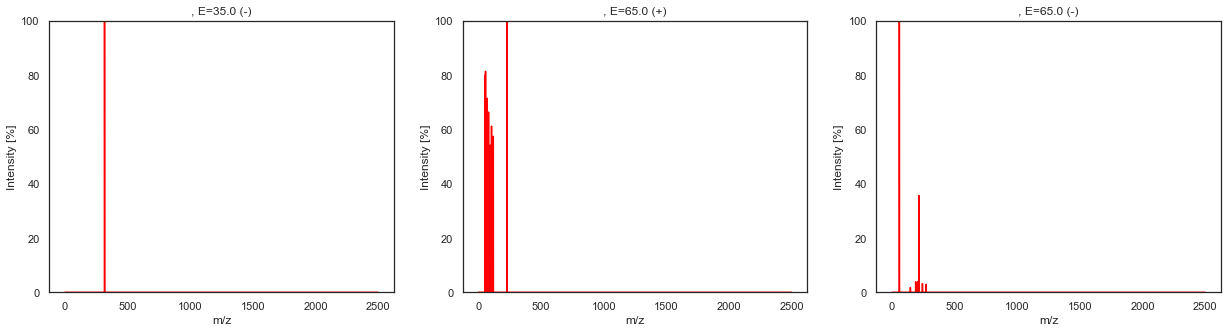

CC1(C)C2=CC(=CC=C2OC1=O)OS(=O)(=O)C
(3, 32)


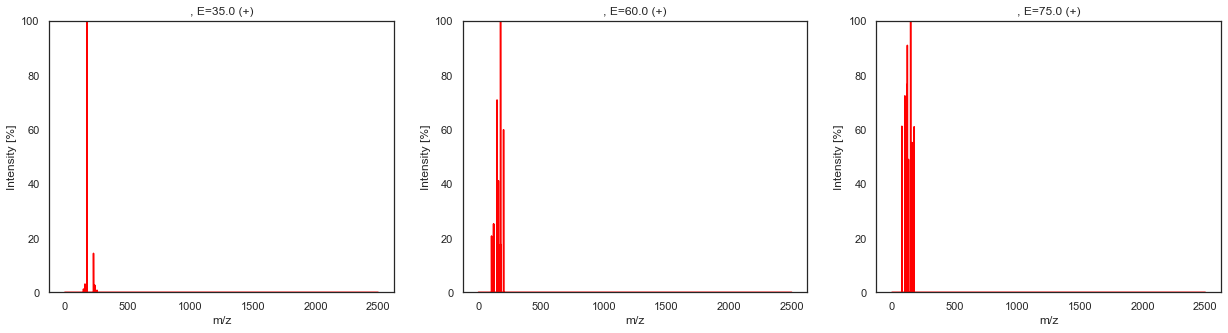

O=C1OC(C2=COC=C2)CC13C(C)CCC4(C)C53OC(=O)C4(C)CC5
(3, 32)


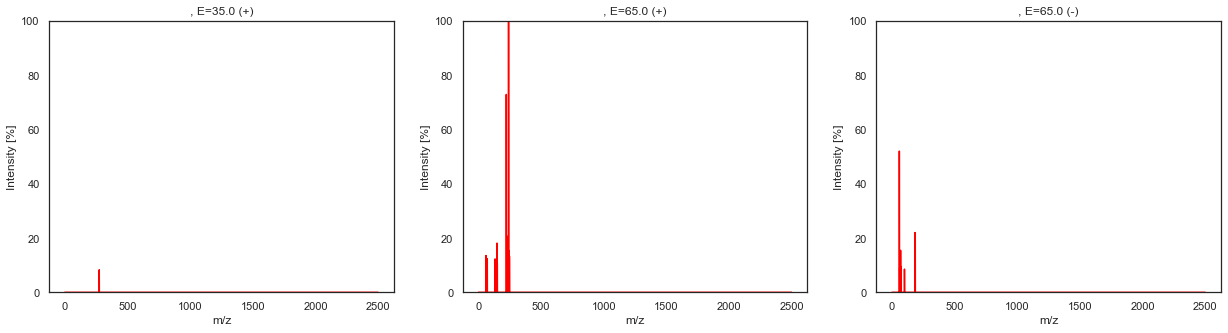

O=C1C(=COC2=CC(O)=CC=C12)C=3C=CC(O)=CC3
(3, 32)


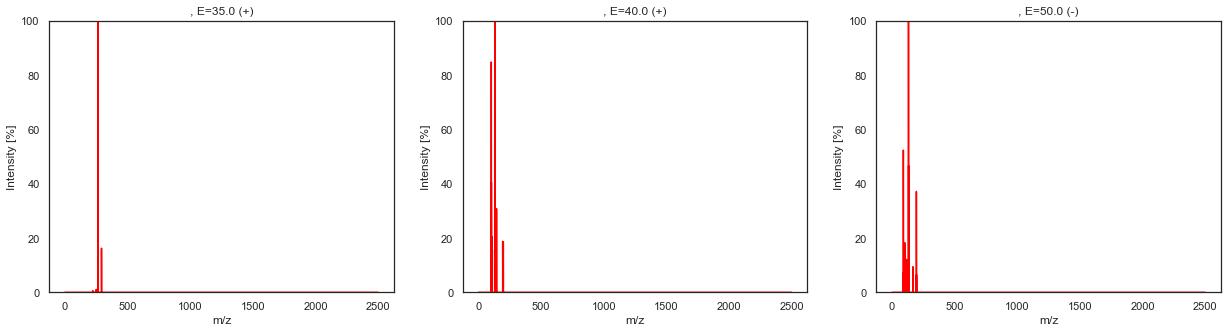

C1=C(C=C(C(=C1)Cl)Cl)NC(=N)O
(3, 32)


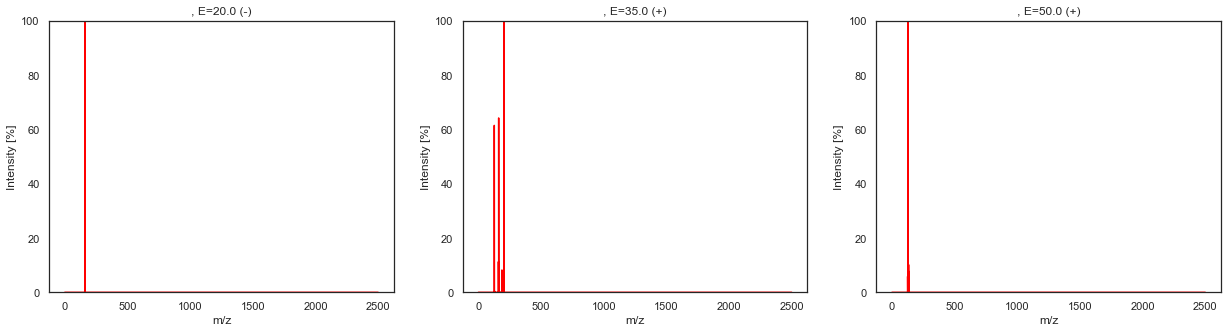

O=C1C(OC2OCC(O)C(O)C2O)=C(OC=3C=C(O)C=C(O)C13)C=4C=CC(O)=C(O)C4
(4, 32)


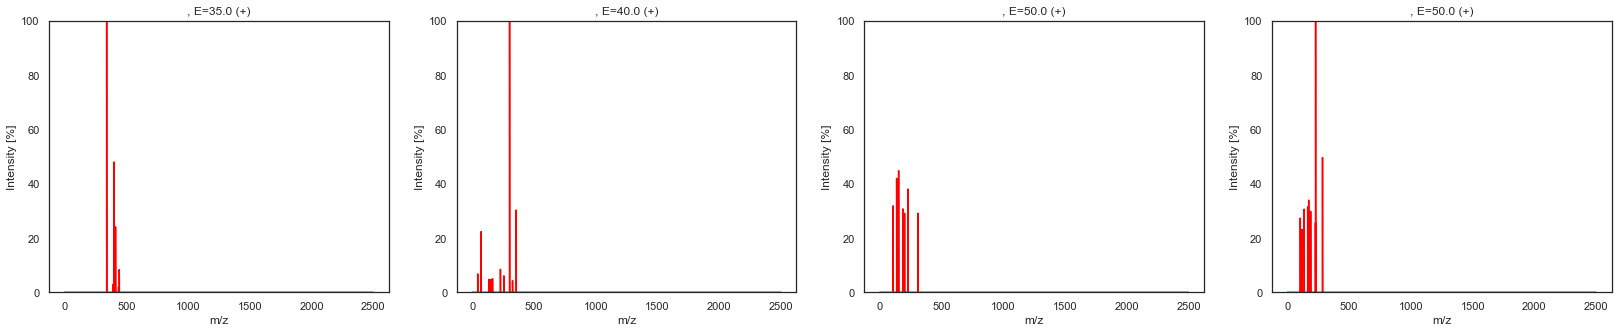

C1=C(C=C(C(=C1)C(CN2C=NC=N2)(CN3C=NC=N3)O)F)F
(4, 32)


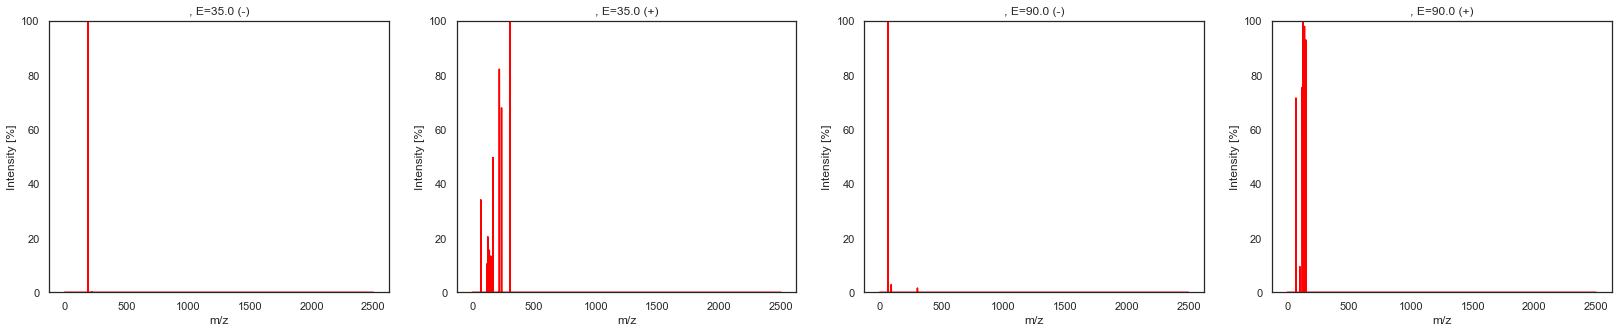

CCC1=C(C(=CC=C1)C)N(C(C)COC)C(=O)CCl
(4, 32)


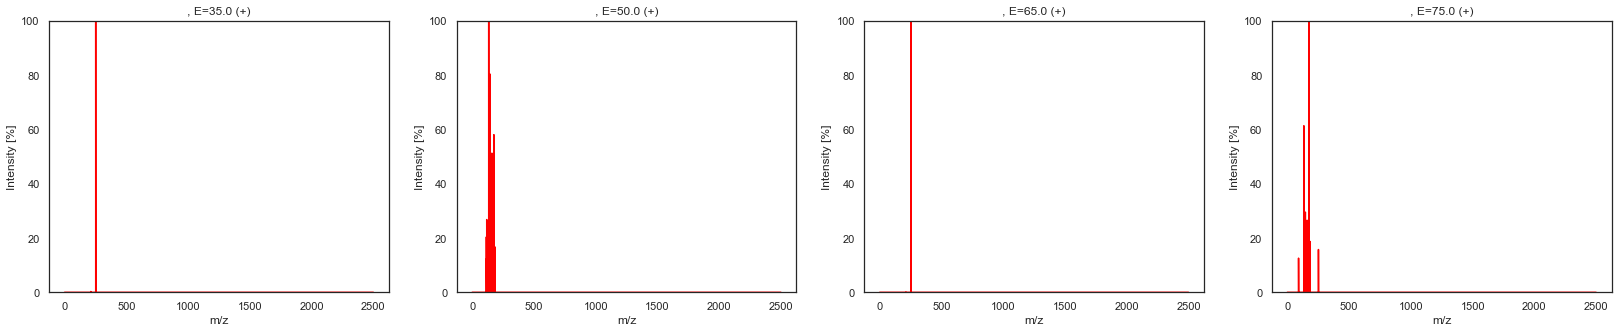

O=C(OC1OCC(O)C(O)C1OC2OC(C)C(OC3OCC(O)C(OC4OC(C)C(O)C(O)C4O)C3O)C(OC5OCC(O)(CO)C5O)C2O)C67CCC(C)(C)CC7C8=CCC9C%10(C)CC(O)C(OC%11OC(CO)C(O)C(O)C%11O)C(C)(CO)C%10C(O)CC9(C)C8(C)CC6
(3, 32)


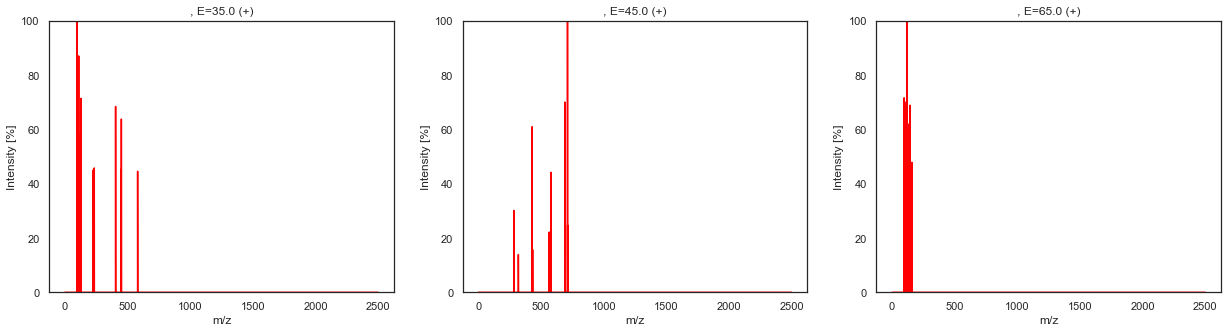

CC(C)C1=CC=C(C=C1)N
(4, 32)


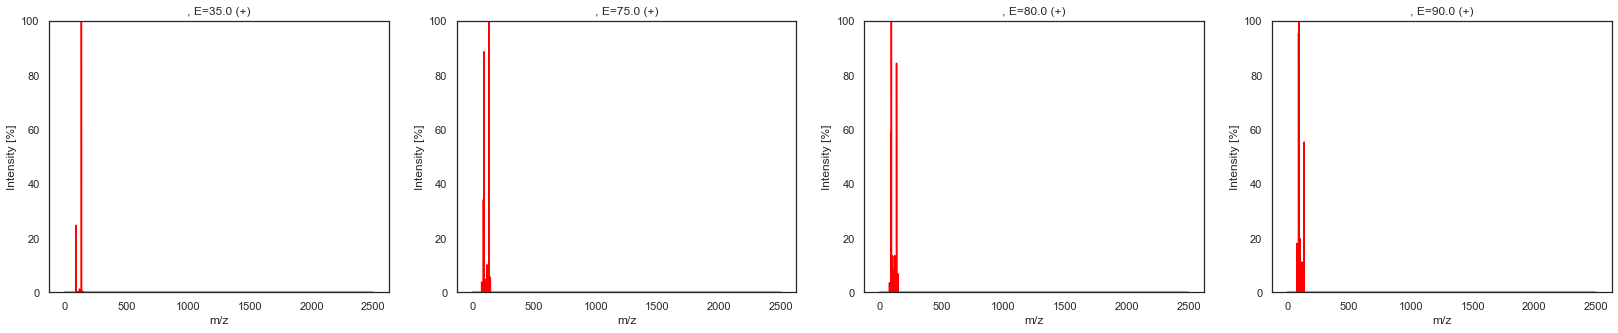

OC1=C(OC)C=C(C=C1OC)C2C3=C(OC)C(O)=C(OC)C=C3CC(CO)C2COC4OCC(O)C(O)C4O
(4, 32)


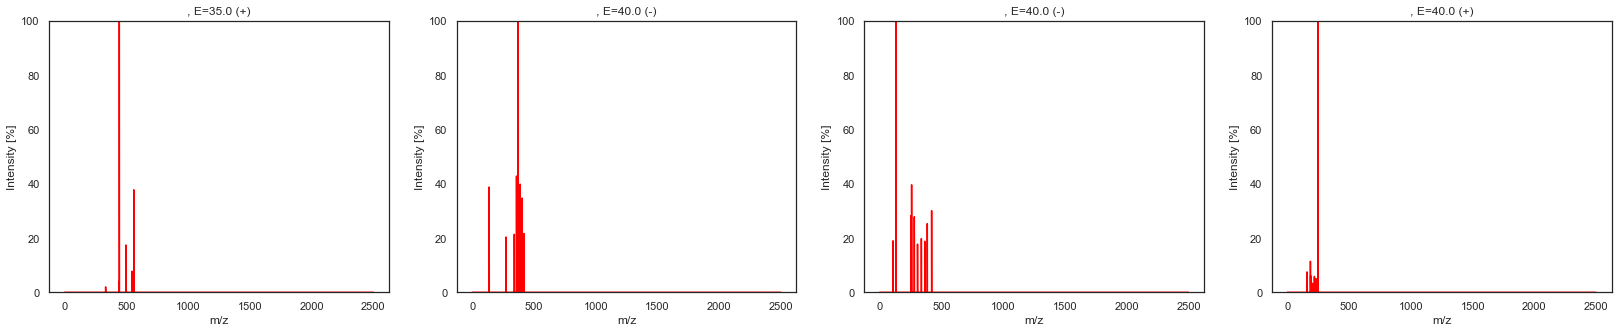

C1=C(C=CC(=C1)O)CCN
(3, 32)


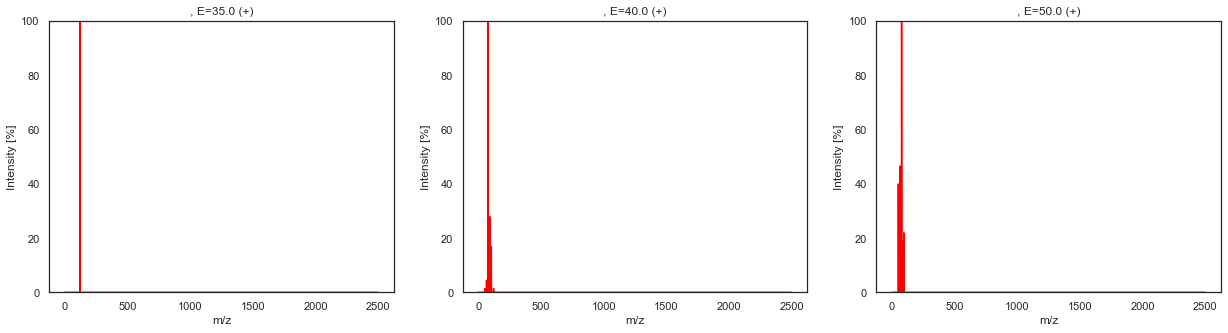

CCN=C1NC(=NC(C)C)NC(=N1)O
(3, 32)


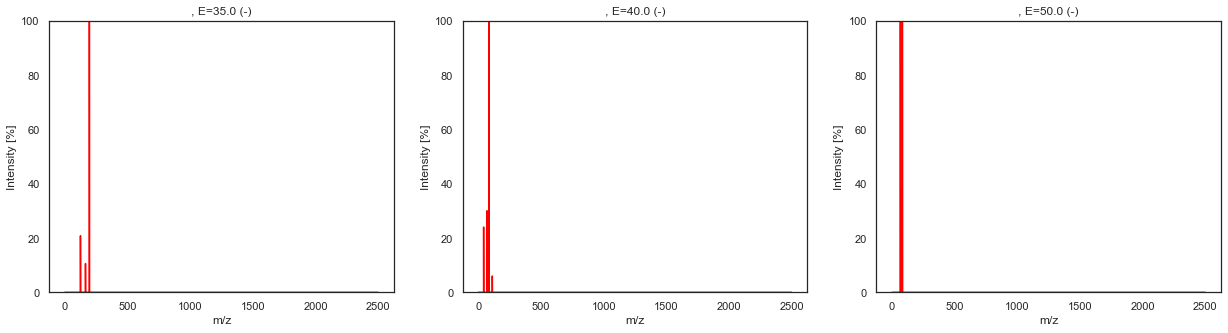

O=C(C=CC=1C=CC=CC1)C2=CC=C(OC)C=C2
(4, 32)


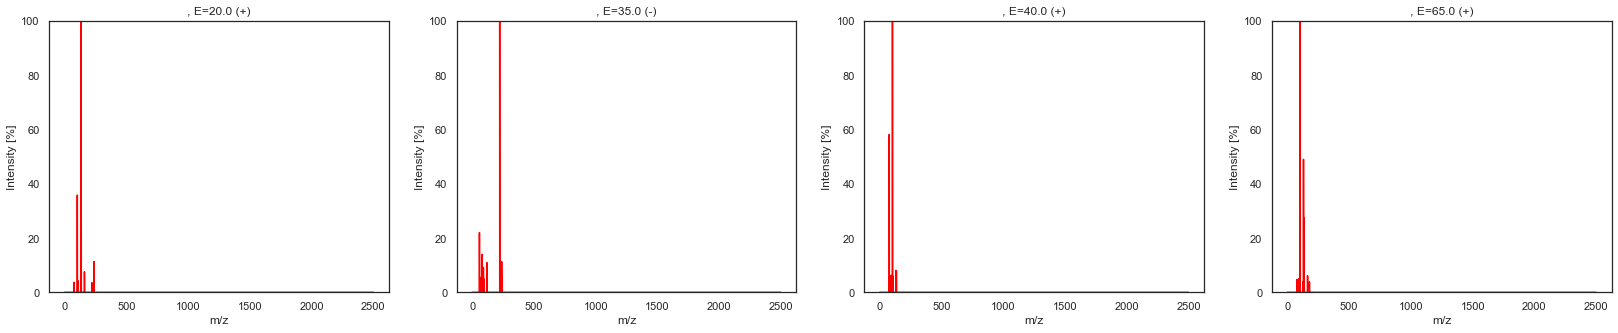

O=C(O)C1OC(OC2CCC3(C)C4CC=C5C6CC(C)(C)CCC6(C(=O)O)CCC5(C)C4(C)CCC3C2(C)CO)C(O)C(O)C1O
(3, 32)


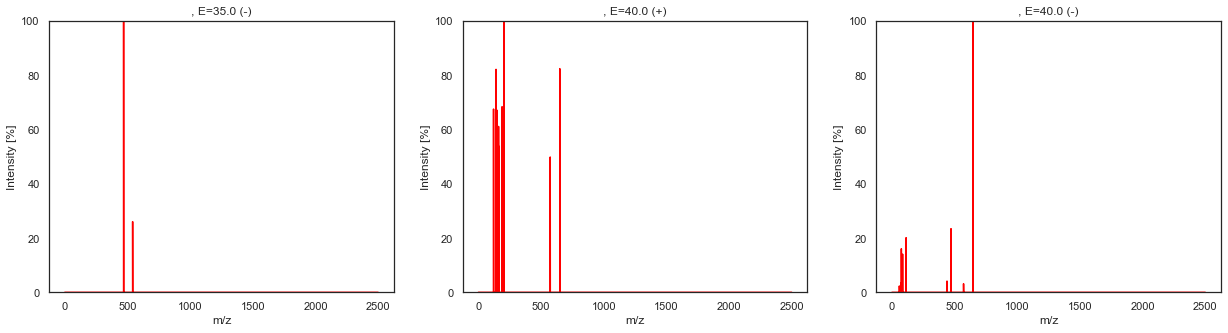

CC1=C(C(=O)N(C2=CC=CC=C2)N1C)N
(3, 32)


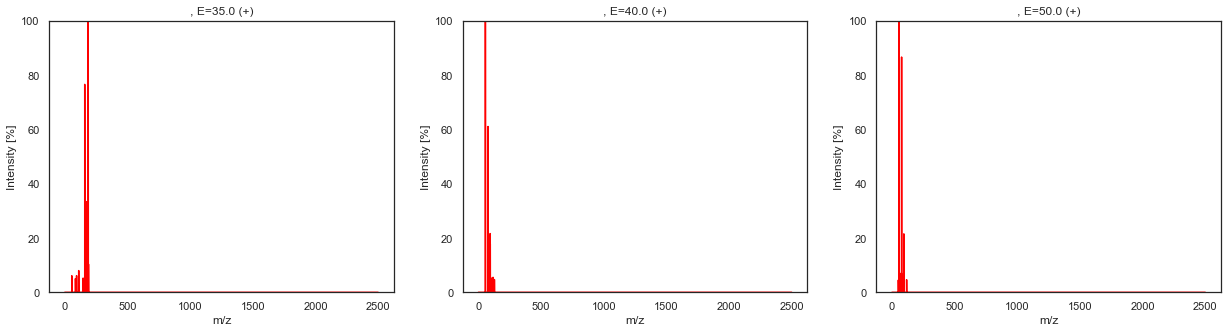

O=C1C(N)=C(C(O)=NC2C(O)=NC(C(=O)N3CCCC3C(=O)N(C)CC(=O)N(C)C(C(=O)OC2C)C(C)C)C(C)C)C4=NC5=C(OC4=C1C)C(=CC=C5C(O)=NC6C(O)=NC(C(=O)N7CCCC7C(=O)N(C)CC(=O)N(C)C(C(=O)OC6C)C(C)C)C(C)C)C
(4, 32)


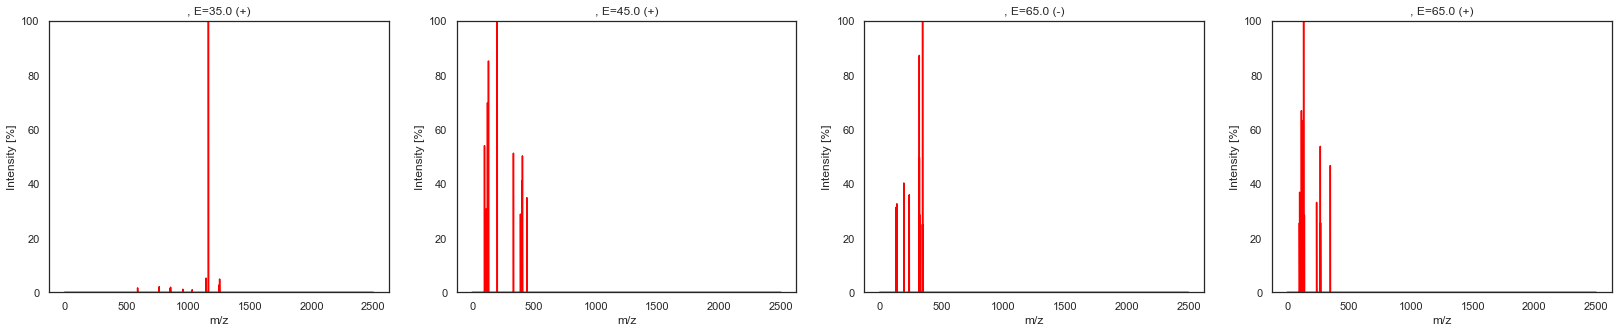

O=C(OCC1OC(OC2C(O)C(O)C(OC2C)OC3CC(C)C(C)(CCC(OC4OC(C)C(OC5OC(C)C(O)C(O)C5O)C(O)C4O)(C=C)C)C6CCC=C(C)C36C)C(O)C(O)C1O)C
(4, 32)


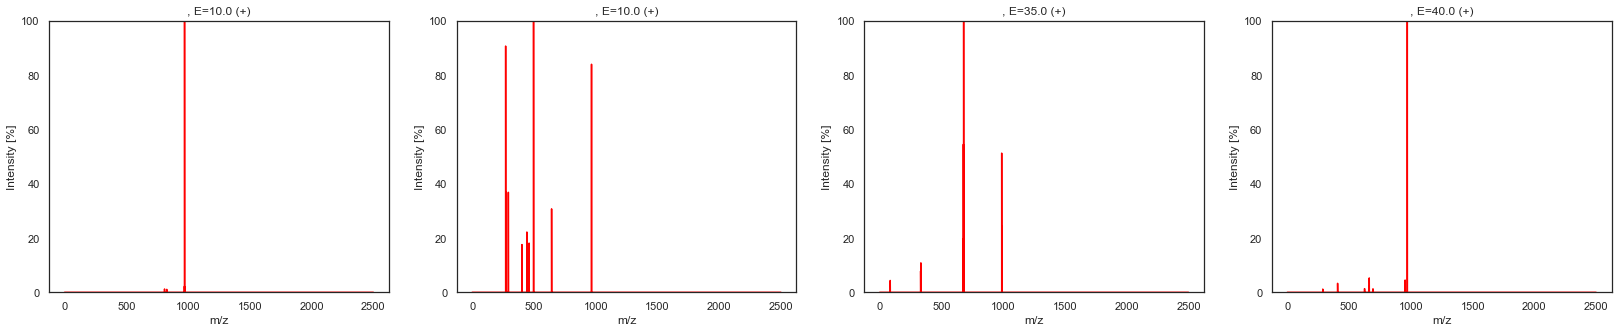

O=C(OC)C1=COC(OC2OC(CO)C(O)C(O)C2O)C(=CCO)C1CC(=O)OCCC3=CC=C(O)C=C3
(4, 32)


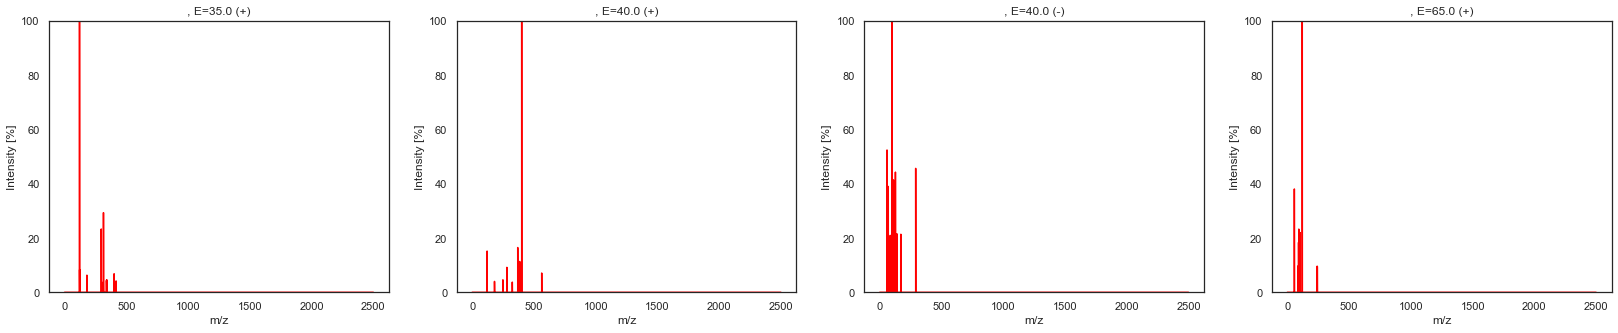

OCC=C(C)CCC1C(O)(C)CCC2C(C)(C)CC(O)CC12C
(3, 32)


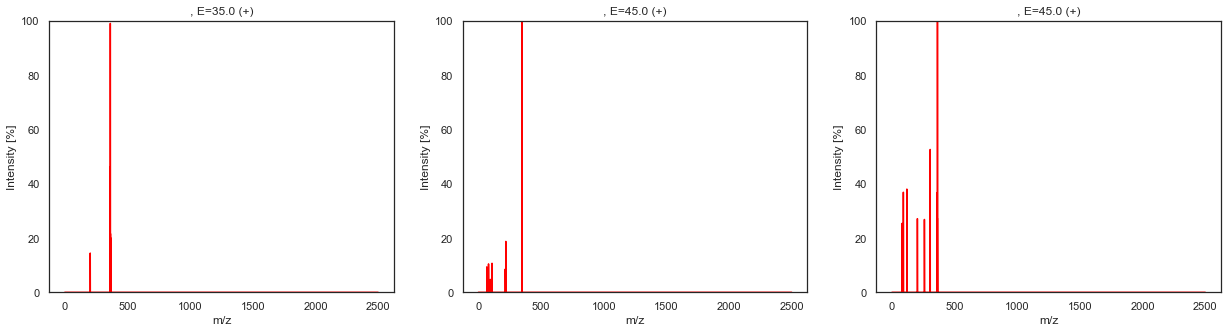

O=C(OC1C2C3(OC(=O)C)COC3CC(O)C2(C(=O)C(OC(=O)C)C4=C(C)C(OC(=O)C(O)C(N=C(O)C=5C=CC=CC5)C=6C=CC=CC6)CC1(O)C4(C)C)C)C=7C=CC=CC7
(3, 32)


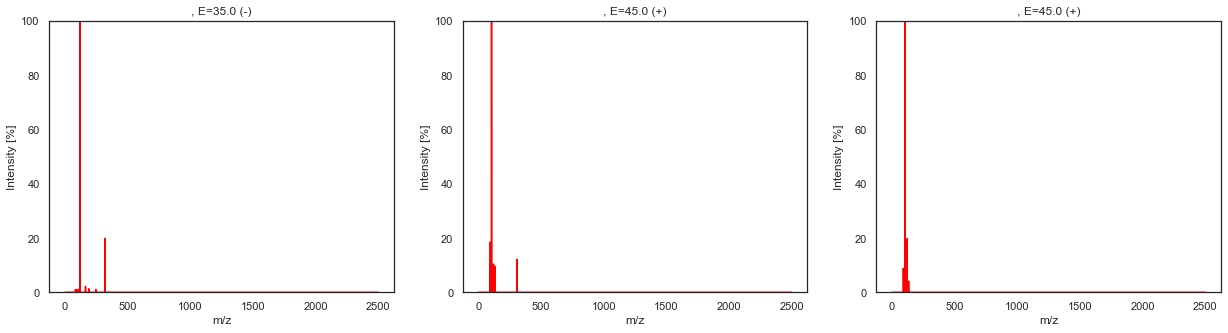

O=C1C(=COC2=CC(OC3OC(CO)C(O)C(O)C3O)=CC=C12)C=4C=CC(OC)=CC4
(5, 32)


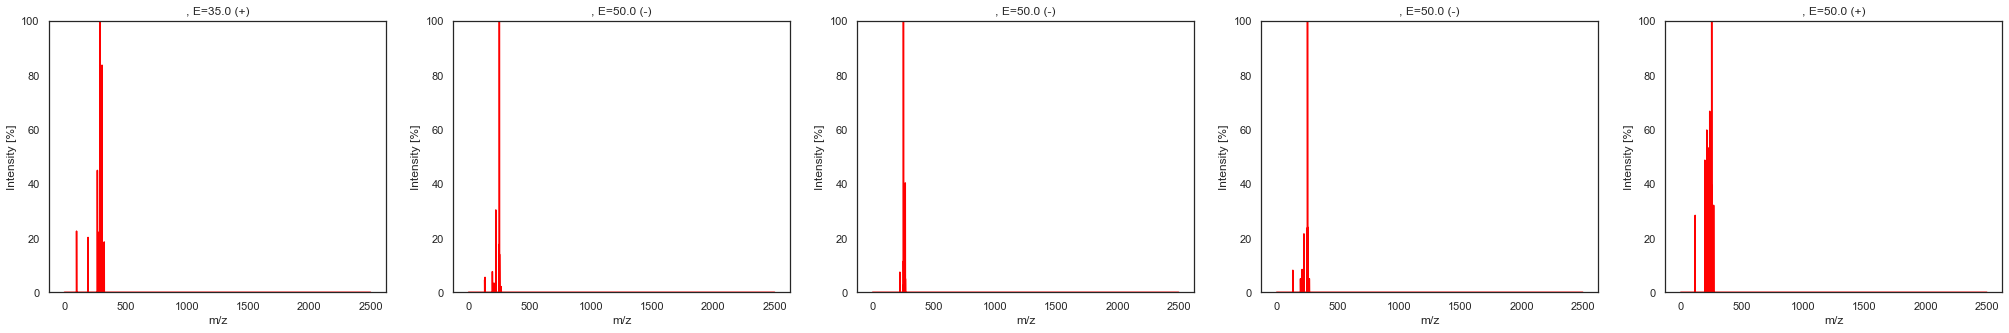

O=C1OC2=C(OCC(O)C(OC(=O)C(=CC)C)(C)C)C=3OC=CC3C=C2C=C1
(3, 32)


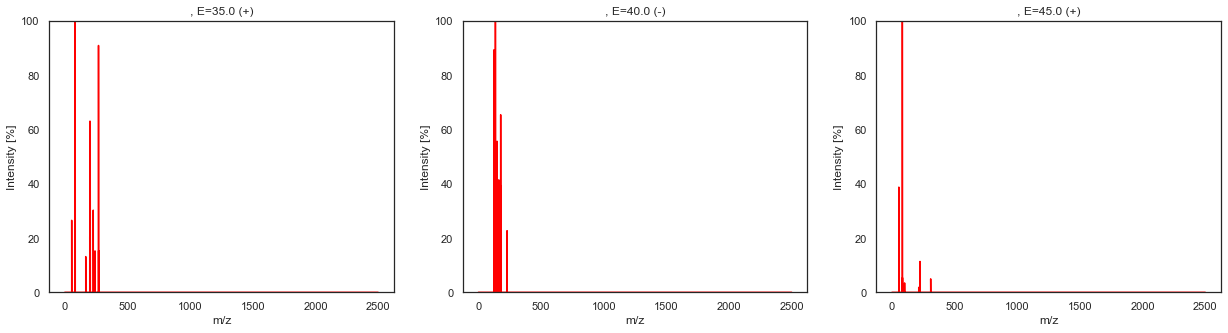

O=C(OC1C(O)C(O)C(OC1OC2=CC(O)=C3C(=O)C(OC4OC(CO)C(O)C(O)C4OC5OC(C)C(O)C(O)C5O)=C(OC3=C2)C=6C=CC(O)=CC6)CO)C=CC7=CC=C(O)C=C7
(3, 32)


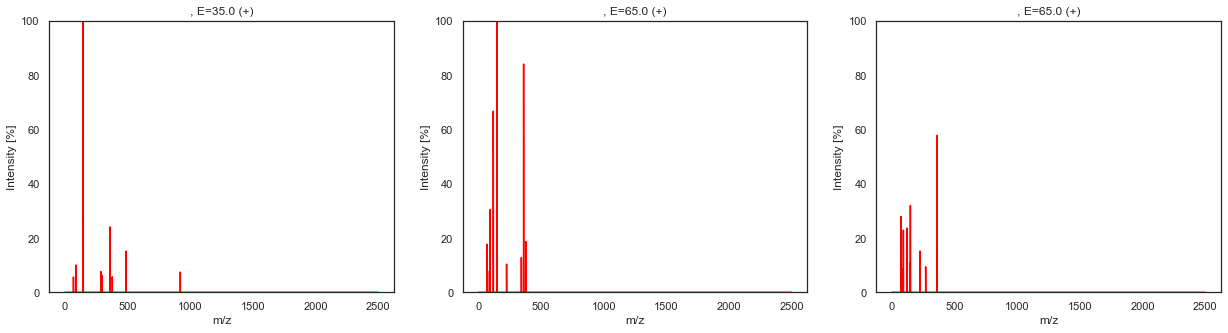

O=C1OCC2(O)COC(OCC3OC(OCCC(C)CCC=C1C)C(O)C(O)C3O)C2O
(3, 32)


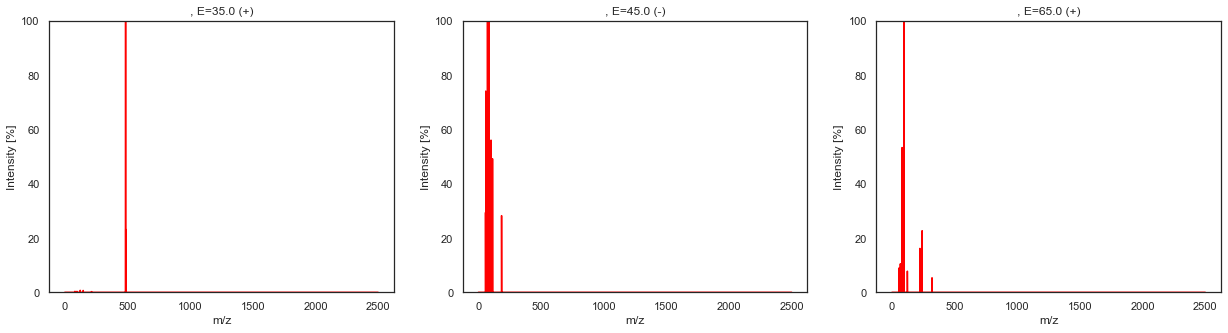

O=C1OCC2=C1C(O)=C(C(OC)=C2C)CC=C(C)CCC=C(C)CCC(=O)O
(4, 32)


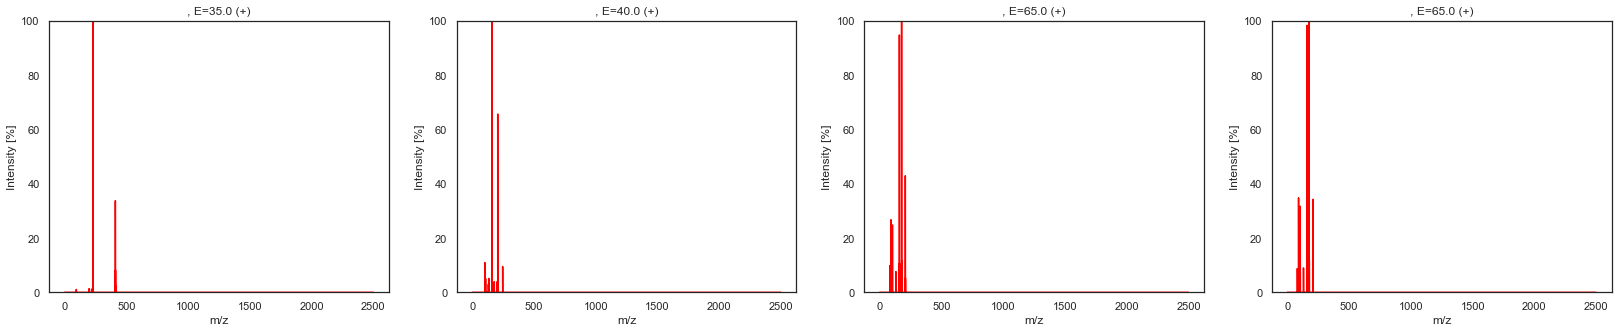

O=C(O)C1=COC(OC2OC(COC(=O)C=CC3=CC(OC)=C(O)C(OC)=C3)C(O)C(O)C2O)C4C1C(O)CC4(O)C
(3, 32)


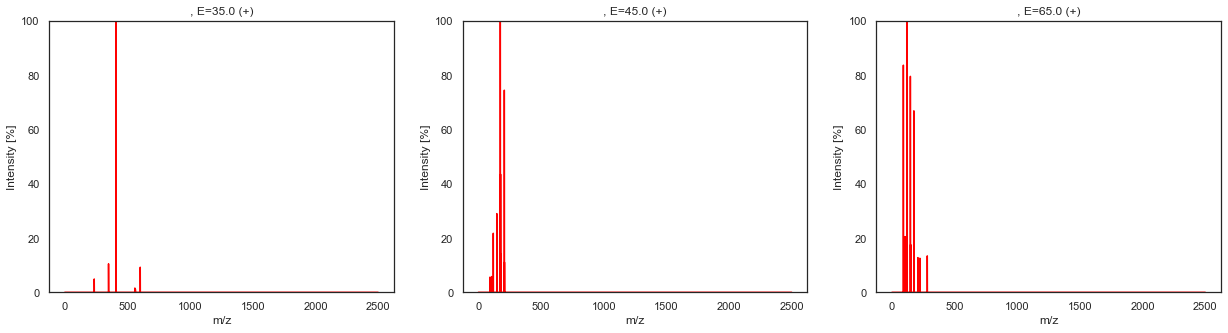

O=C1C=2C(O)=CC(O)=CC2OC(C3=CC=C(O)C=C3)C1
(4, 32)


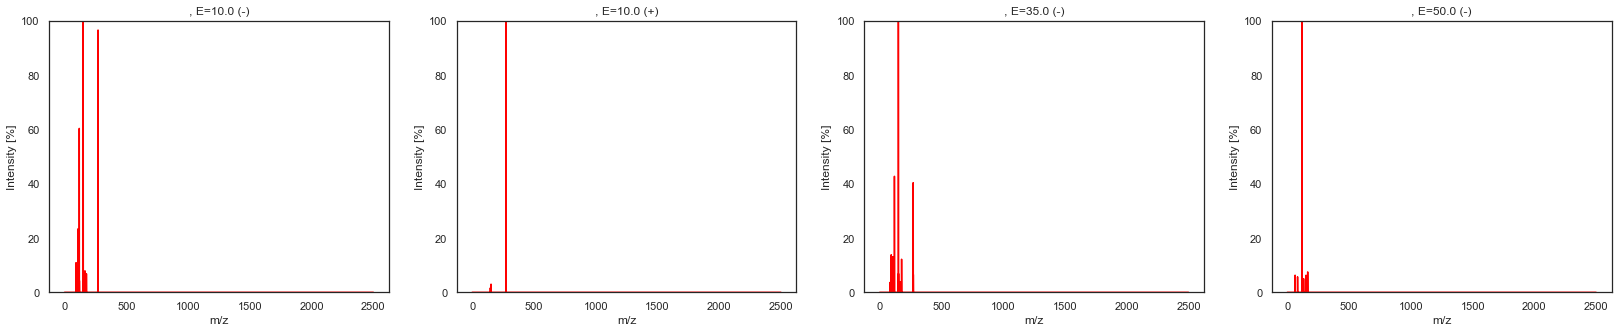

C=C(C)C1CCC2(C)CCC(=O)C(=C2C1)C
(5, 32)


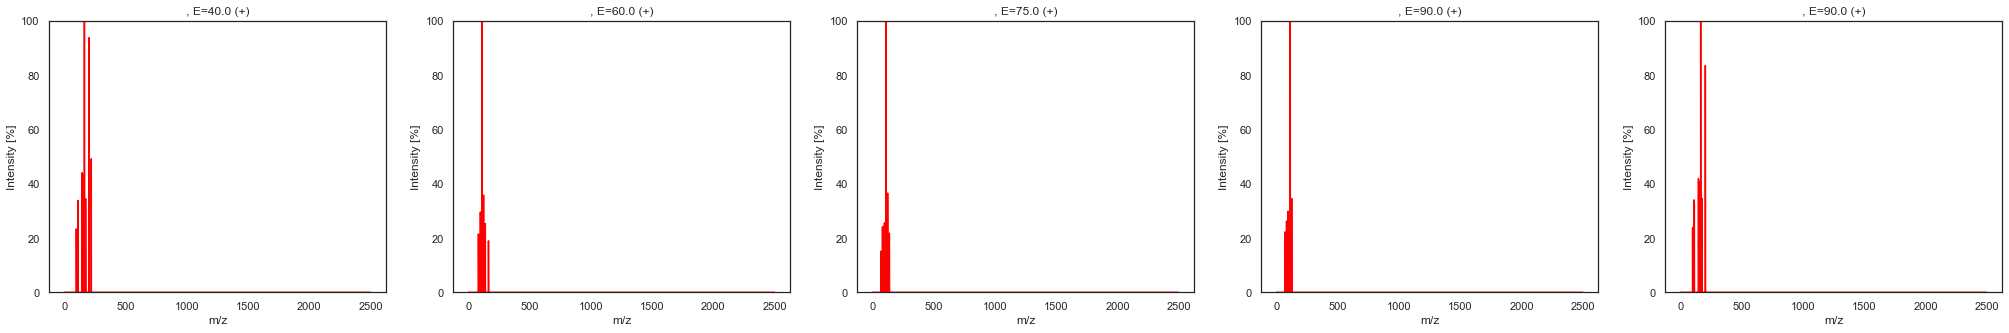

CSCC[C@@H](C(=O)O)N=CO
(3, 32)


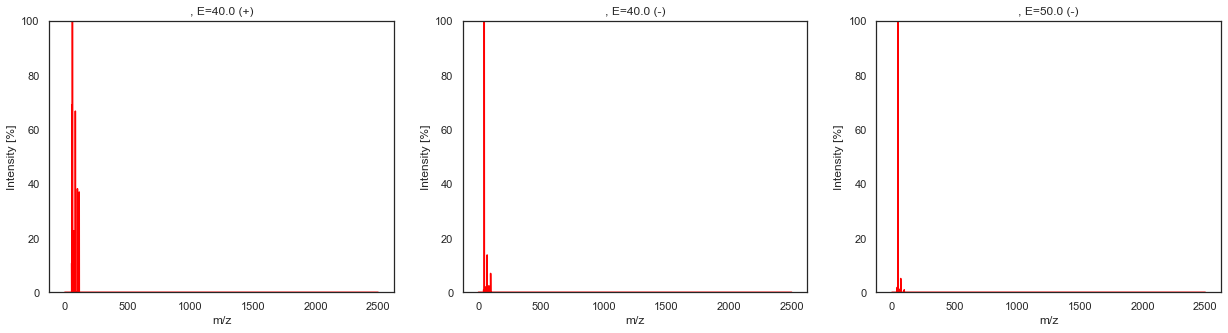

O=C(O)CC(C)CCC1(C)C(C)CCC2(C(=CC(=O)CC21)C)C
(3, 32)


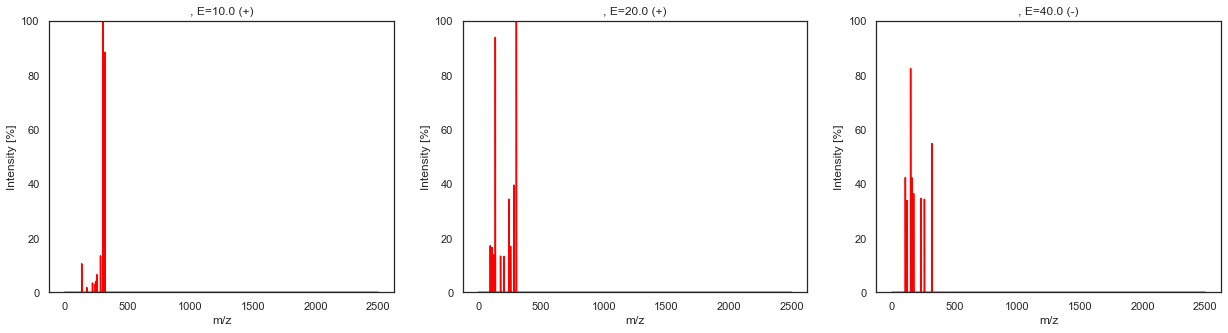

CC1=CC(=NO1)NS(=O)(=O)C2=CC=C(C=C2)N
(6, 32)


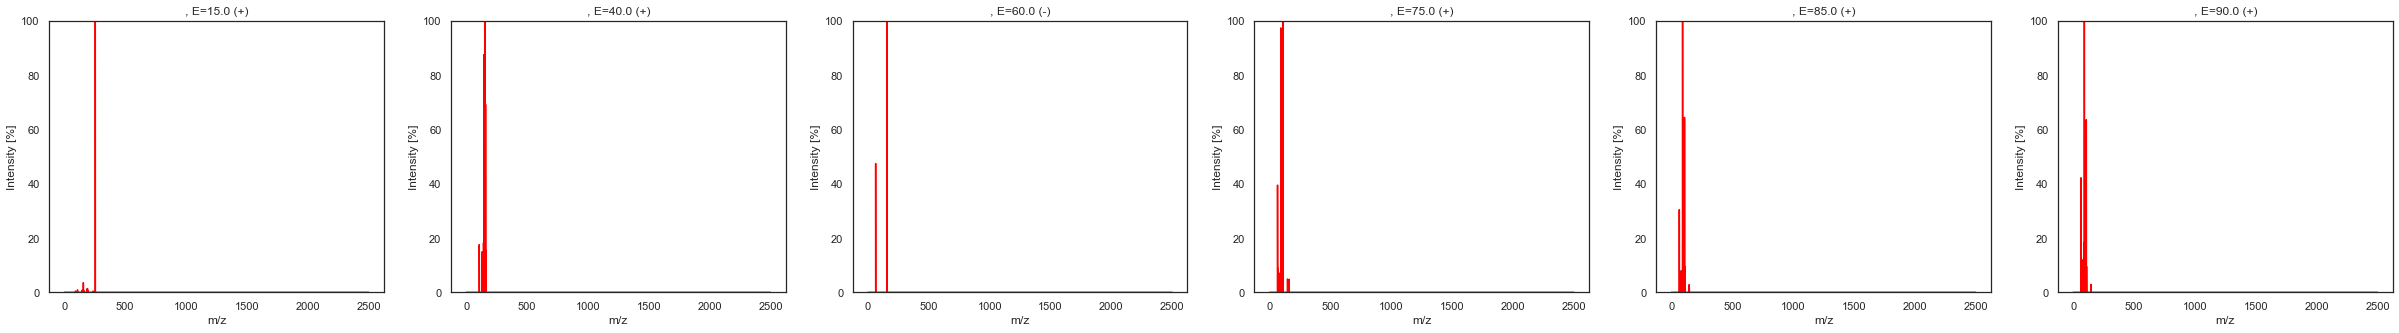

O=C1C=C(OC=2C=C(O)C=C(O)C12)C=3C=CC=CC3
(4, 32)


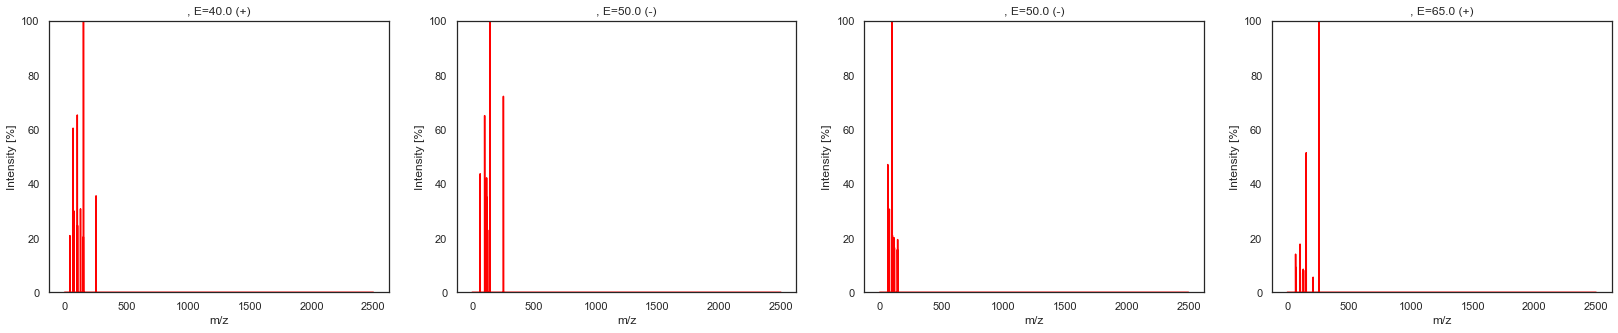

O=C(O)CC1CCC(OC2OC(CO)C(O)C(O)C2O)C1CC=CCC
(3, 32)


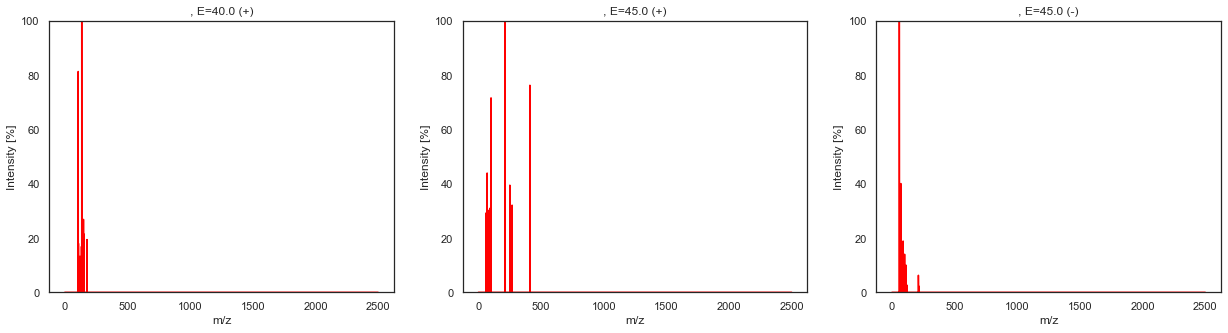

C/C=C\1/C[C@@H](C)[C@](C)(C(=O)OCC2=CCN3(=O)CC[C@H]([C@@H]23)OC1=O)O
(7, 32)


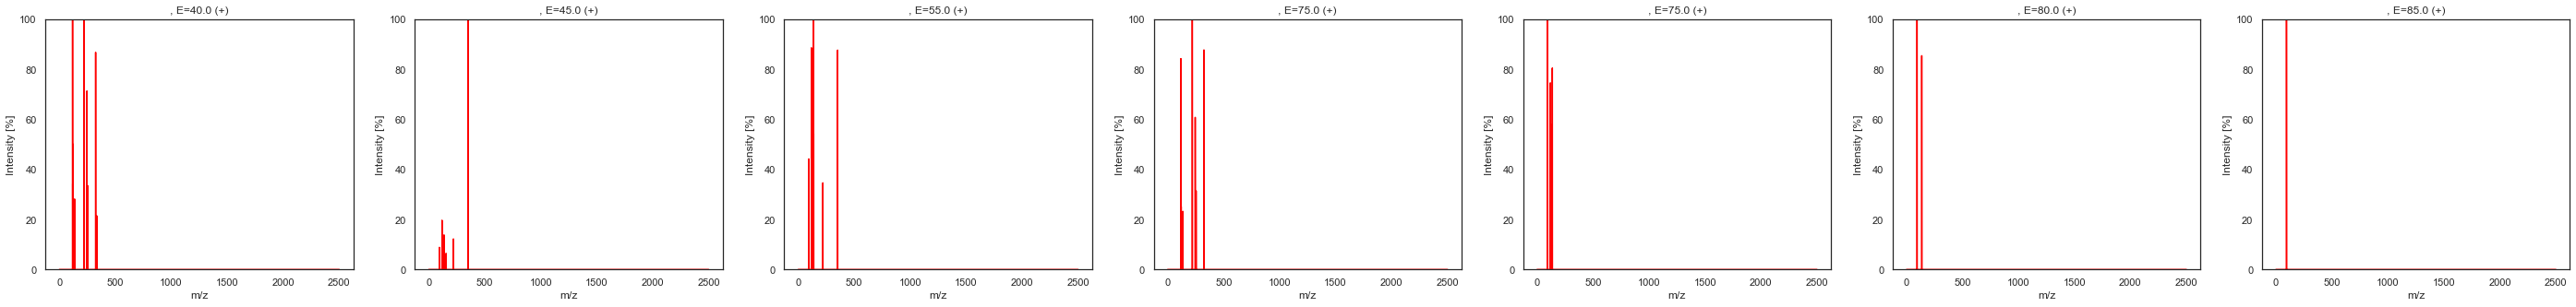

O=C(OC1CC2=CC(OC2=O)CC(=CC3OC(=O)C(=C)C31)C)C(=C)C
(3, 32)


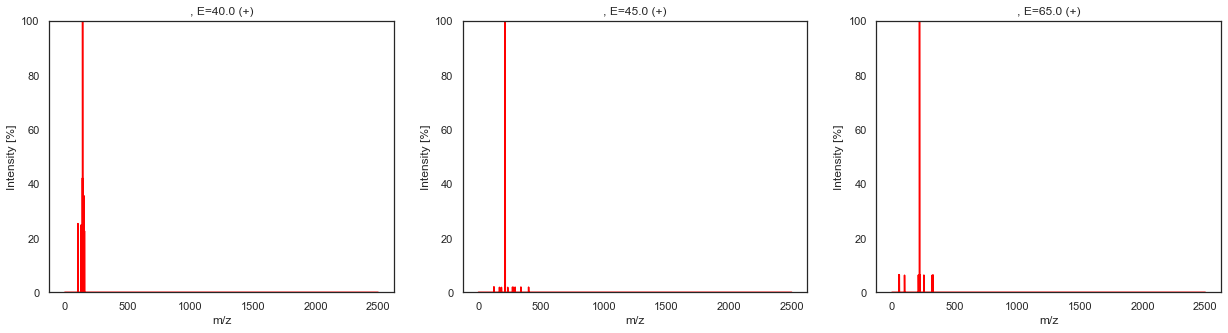

CC1=C[C@@]2(C[C@@H](CO)C(=O)[C@@H]2[C@@](C)(C31CC3)O)O[C@H]4[C@@H]([C@H]([C@@H]([C@@H](CO)O4)O)O)O
(3, 32)


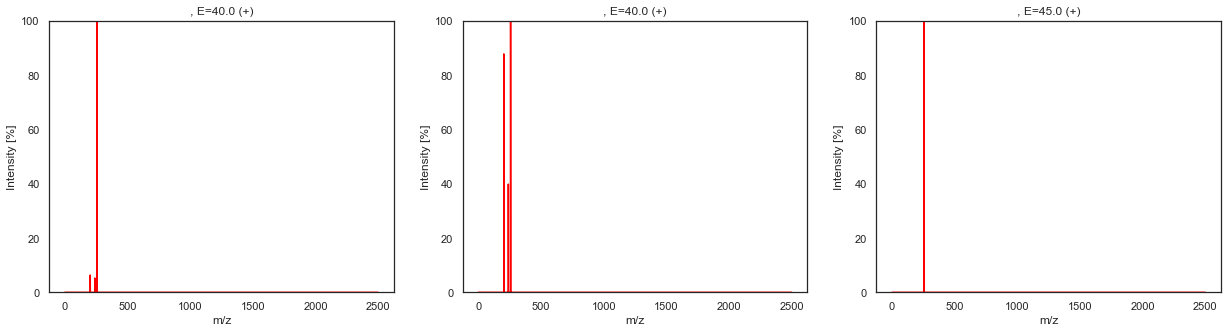

O=C(O)C=CC1=CC=C(OC)C(O)=C1
(3, 32)


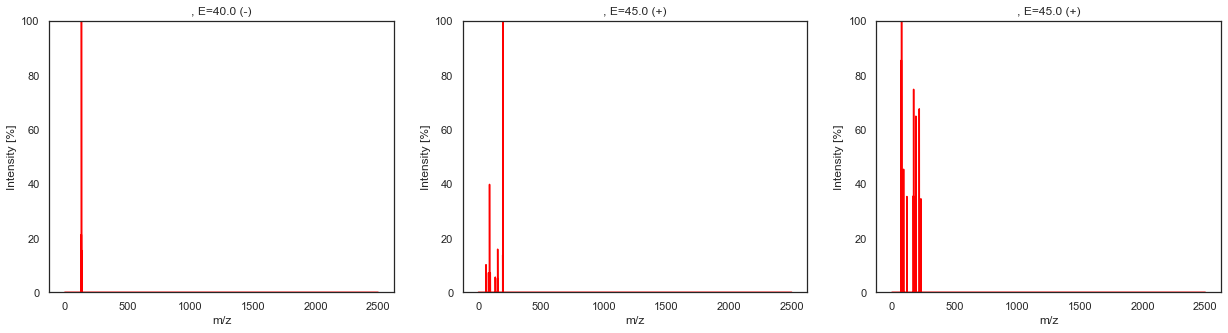

CC(C1=CC2=CC=C(C=C2C=C1)OC)C(=O)O
(3, 32)


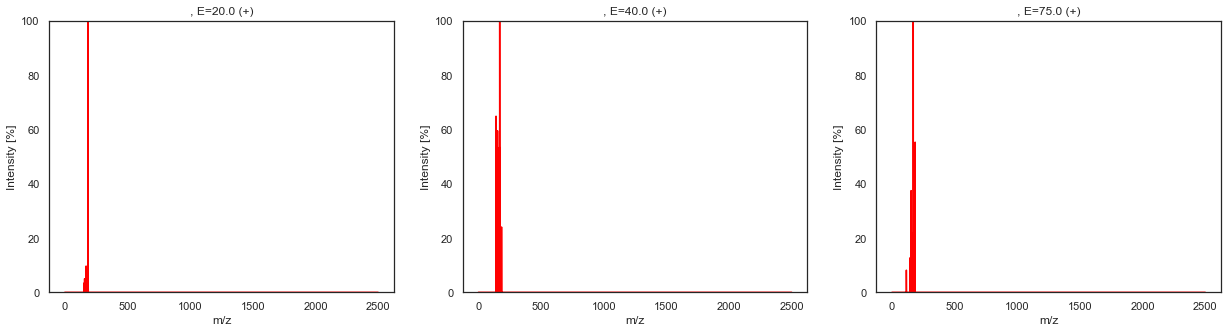

O=C(O)C(C)C1OC(CC1)CC(OC(=O)C(C)C2OC(CC2)CC(O)CC)C
(3, 32)


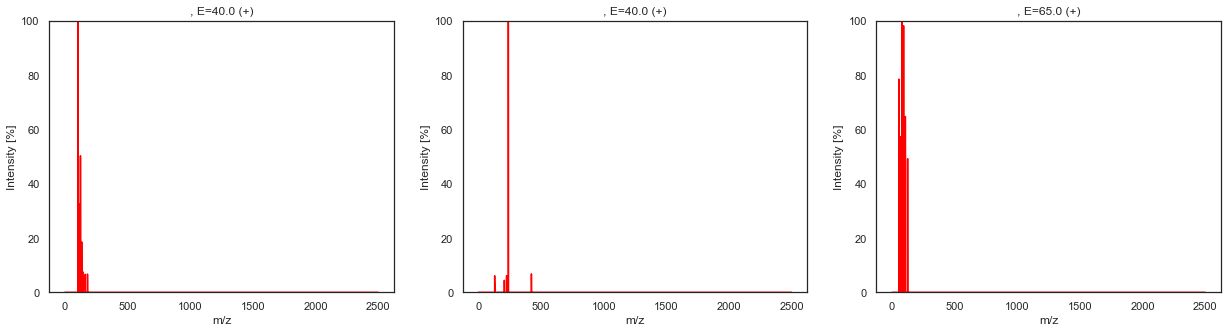

C1=CC(=O)OC2=C1C=C3C=COC3=C2
(3, 32)


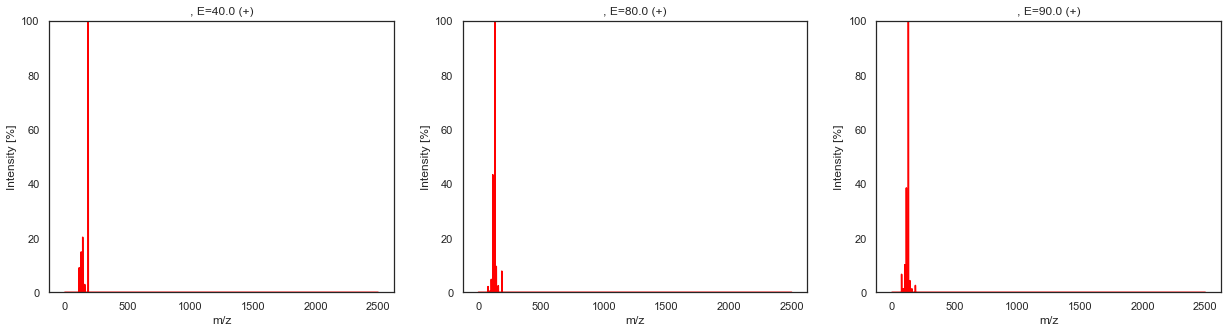

O=C(OCC1OC(OC2(OC(CO)C(O)C2OC(=O)C=CC3=CC(OC)=C(O)C(OC)=C3)CO)C(O)C(O)C1O)C=CC4=CC(OC)=C(O)C(OC)=C4
(3, 32)


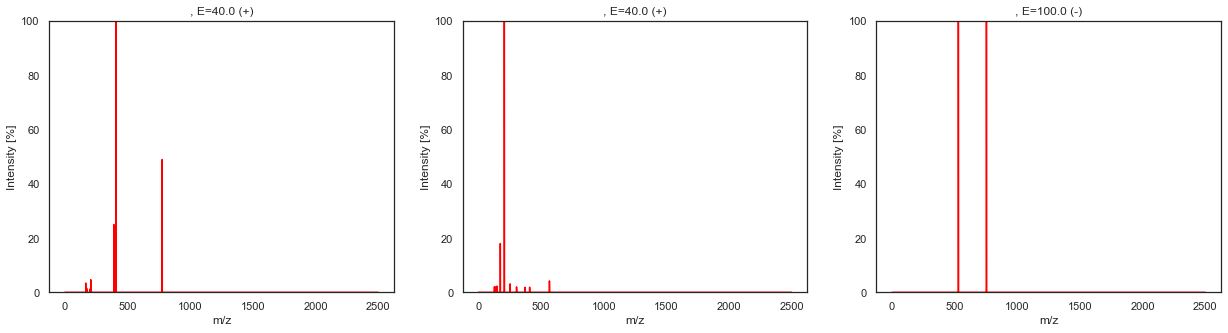

CC(C)[C@]([C@@H](C)OC)(C(=O)OCC1=CCN2CC[C@@H]([C@@H]12)O)O
(5, 32)


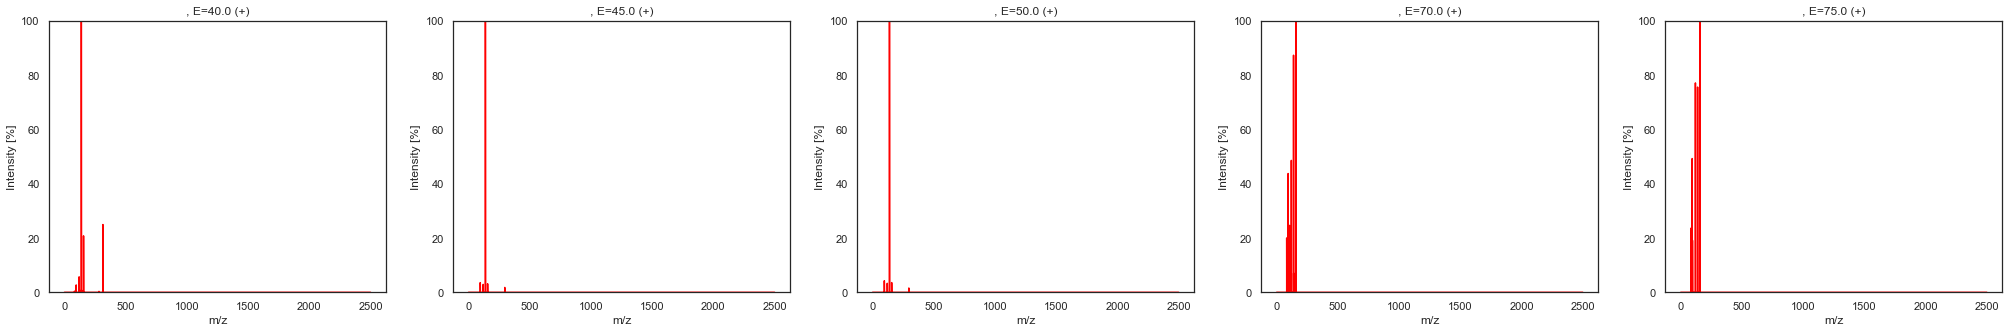

CC(C)[C@@H](C(=O)O)N=C(CC1=CNC2=C1C=CC=C2)O
(3, 32)


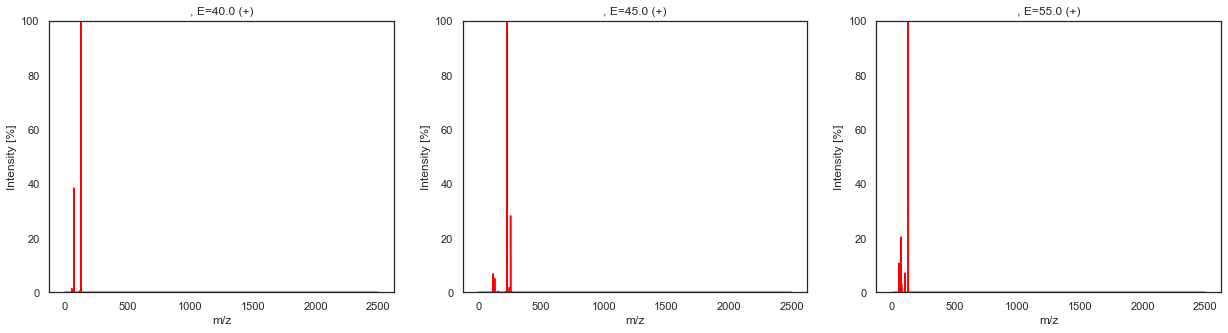

N=1C=NC2=C(N=CNC12)N
(3, 32)


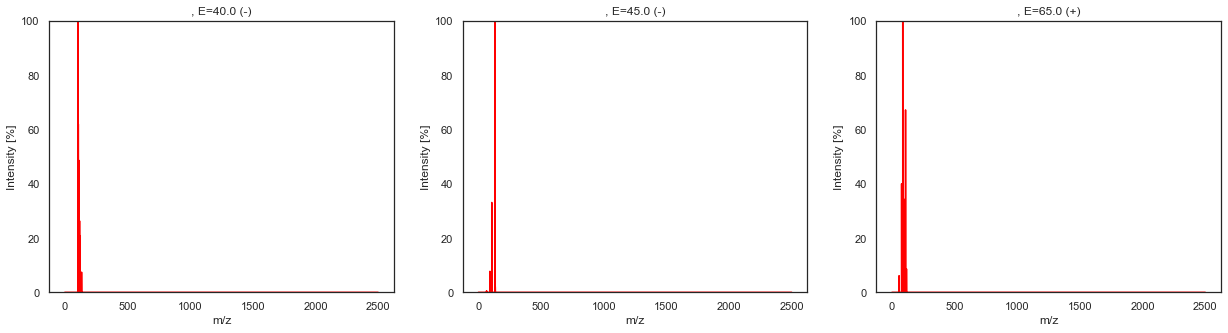

CC[C@@H]1[C@H](/C=C(\C)/C=C/C(=O)[C@H](C)C[C@H](CC=O)[C@@H]([C@@H](C)[C@@H](CC(=O)O1)O)O[C@H]2[C@@H]([C@H]([C@@H]([C@@H](C)O2)O[C@H]3C[C@](C)([C@H]([C@H](C)O3)O)O)N(C)C)O)CO[C@H]4[C@@H]([C@@H]([C@@H]([C@@H](C)O4)O)OC)OC
(4, 32)


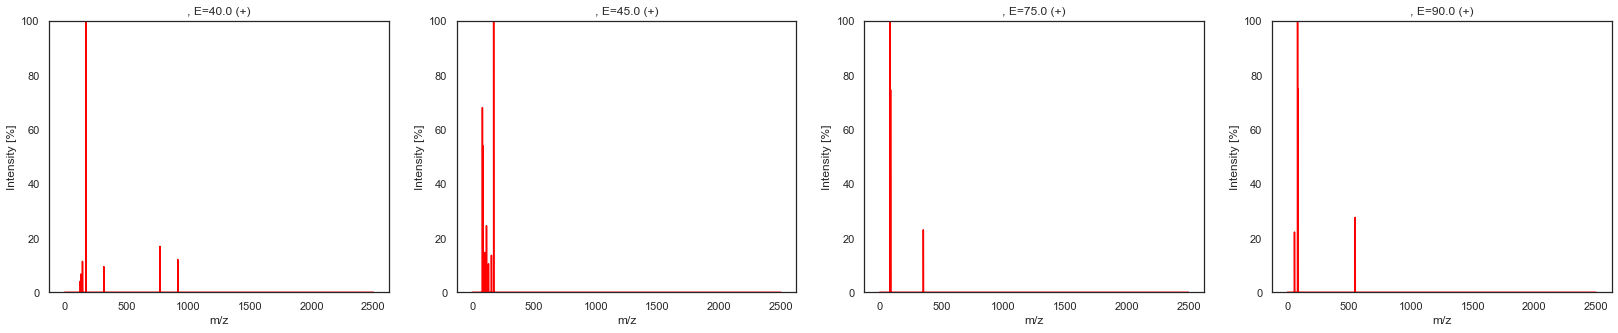

CC(C)C1=NC(=CC(=N1)C)O
(4, 32)


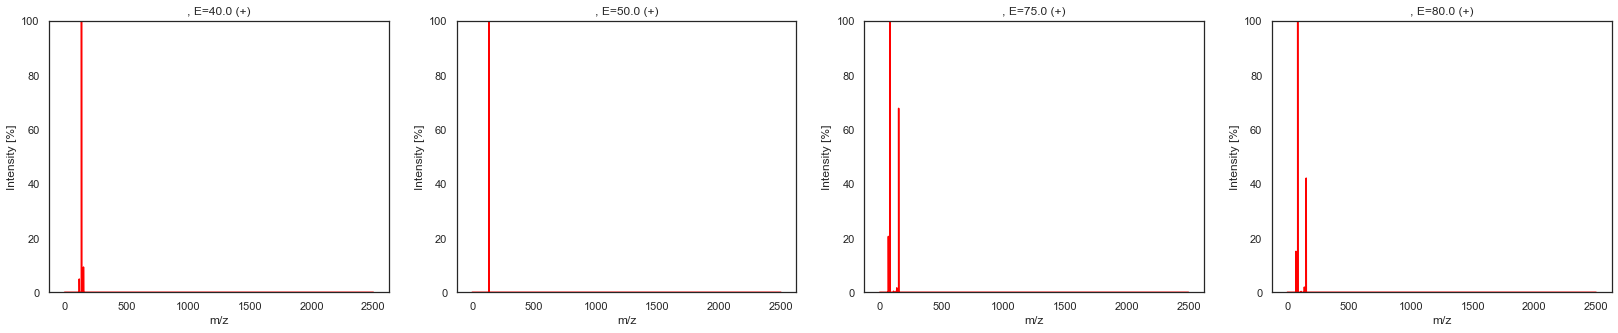

O=C(OC1C(O)C(O)C(OC1OC=2C(=O)C=3C(O)=CC(O)=CC3OC2C=4C=CC(O)=C(O)C4)C)C5=CC(O)=C(O)C(O)=C5
(3, 32)


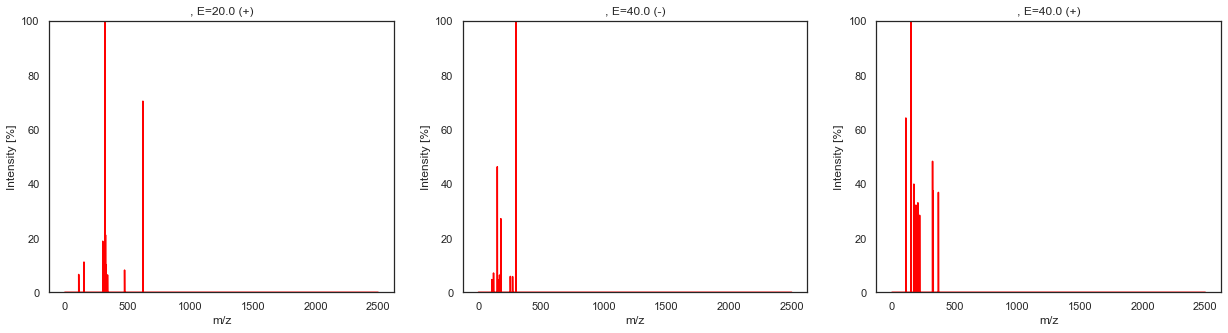

COC1=CC2=C(C=C1OC)N=C(NC2=N)N3CCN(CC3)C(=O)C4=CC=CO4
(3, 32)


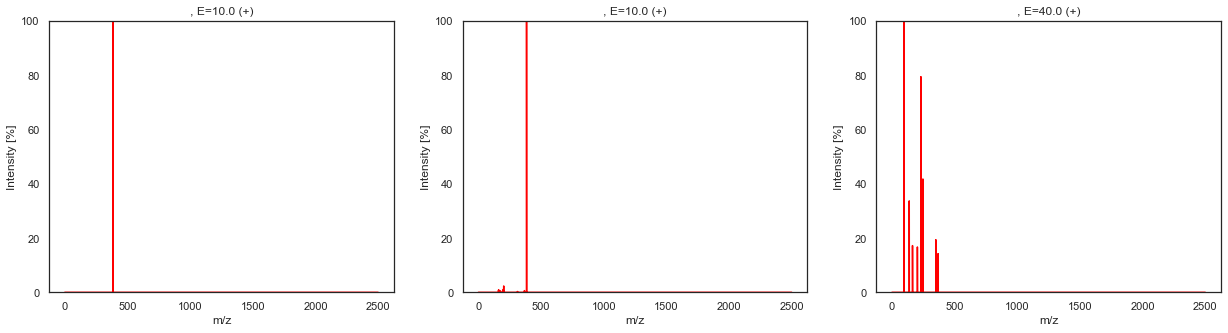

C(CCCC(=O)O)CCC(=O)O
(4, 32)


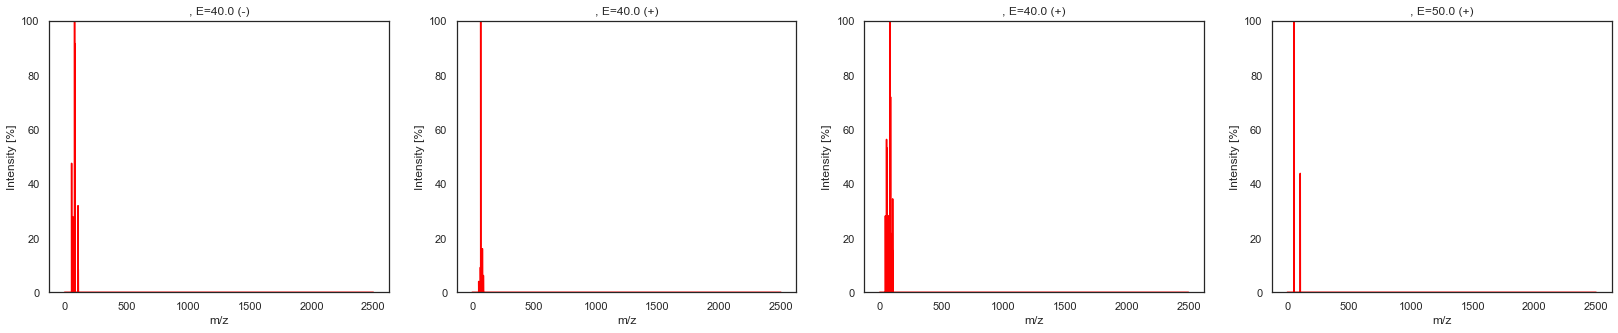

C1=CC2=C(C=C1)NC3=NC(=CC=C23)N=C4NC5=C(NC(=N)N=C5O)N4C6CC(C(CO)O6)O
(5, 32)


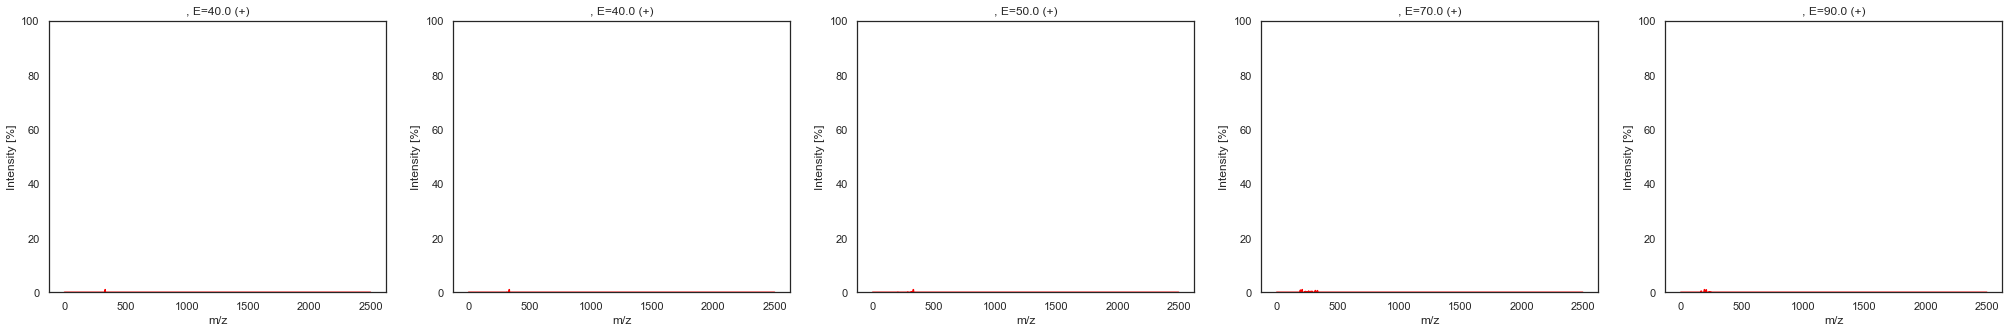

OCC1OC(OC2=C(OC)C=C(C=C2OC)C3OCC4C(OCC34)C5=CC(OC)=C(OC6OC(COC7OC(CO)C(O)C(O)C7O)C(O)C(O)C6O)C(OC)=C5)C(O)C(O)C1O
(3, 32)


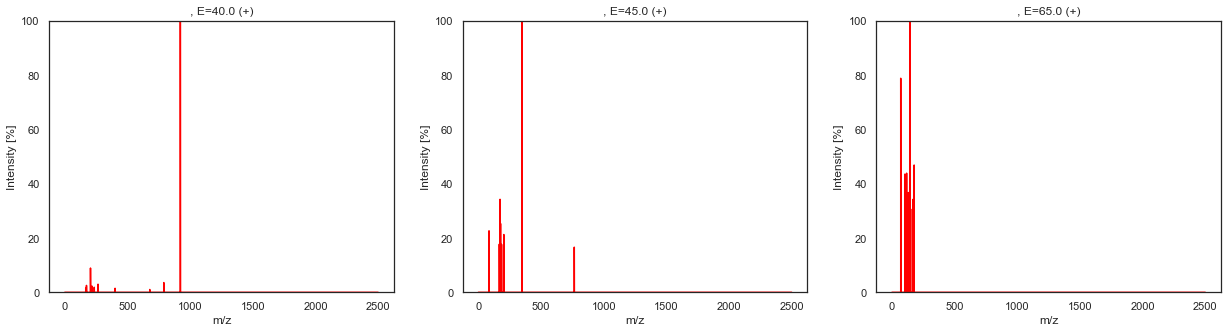

C1CCN2C[C@@H]3C[C@@H](CN4CCCC[C@H]34)[C@@H]2C1
(4, 32)


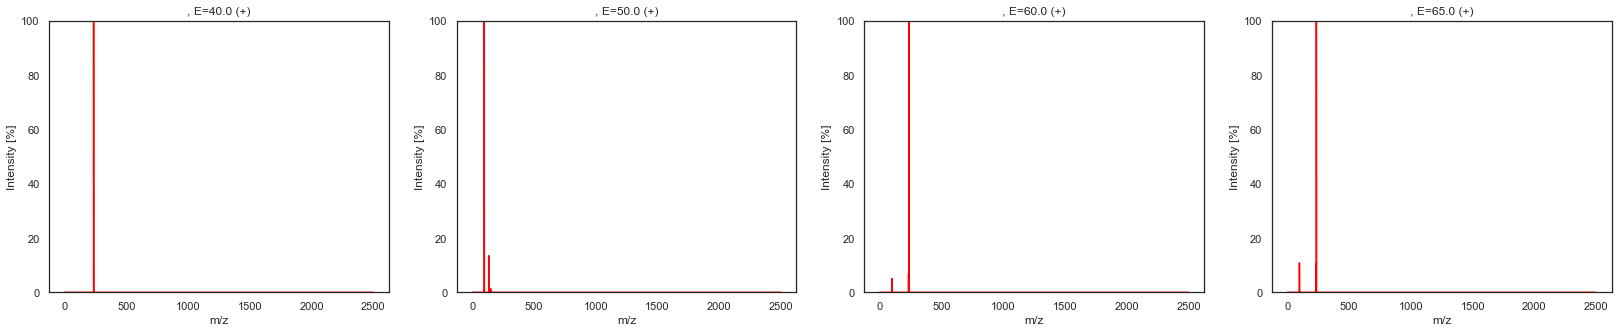

O=C(OC1C=CC(=O)OC1C(C)CC(C)CC(=CC)C)C=CC(=CC(CO)CCO)C
(3, 32)


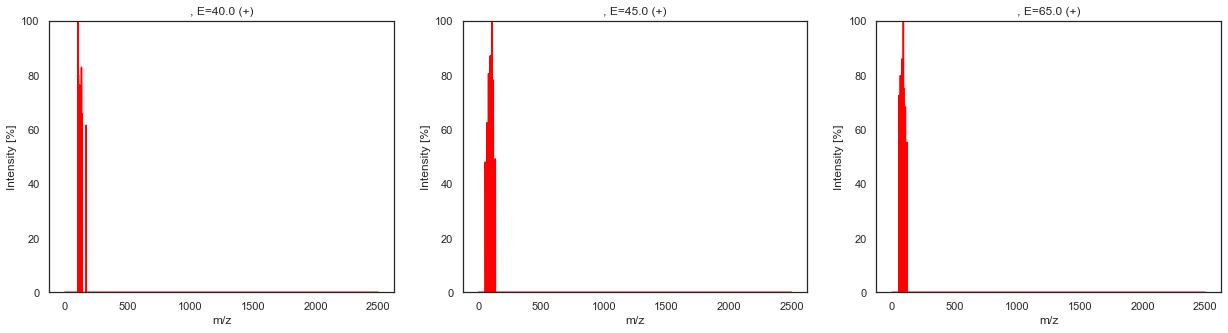

O=C(OC1C(OC(OC2C3OC3(CO)C4C(OC=CC24)OC5OC(CO)C(O)C(O)C5O)C(OC(=O)C)C1OC(=O)C)C)C=CC=6C=CC=CC6
(3, 32)


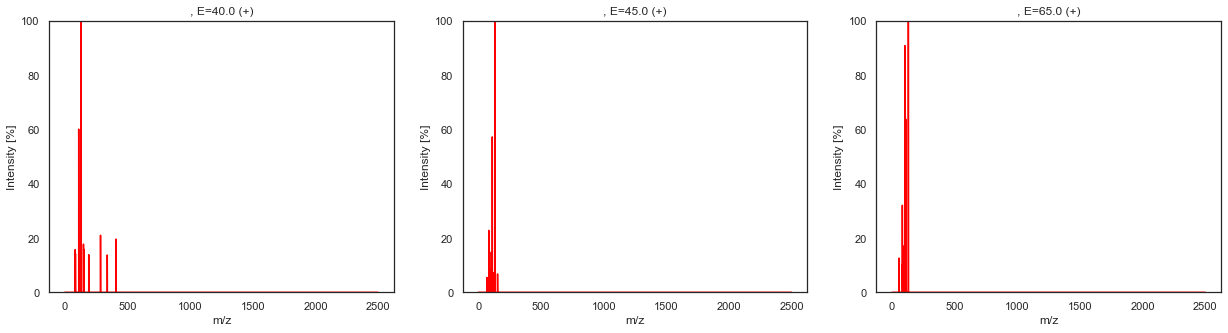

CN1C2=C(C(=O)N(C)C1=O)N=CN2
(3, 32)


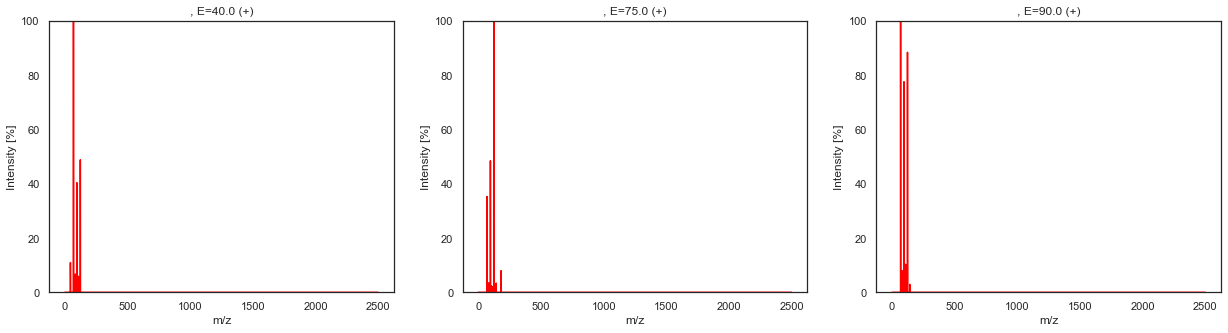

C1=CC(=CC=C1C2=COC3=CC(=CC=C3C2=O)O)O
(4, 32)


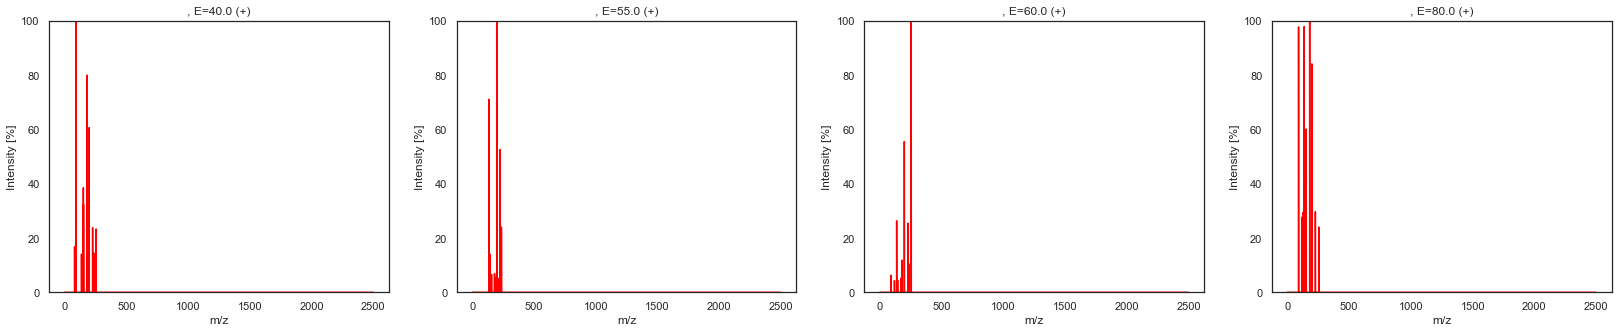

CC(C)(C(=O)O)OC1=CC=C(C=C1)CCNC(=O)C2=CC=C(C=C2)Cl
(5, 32)


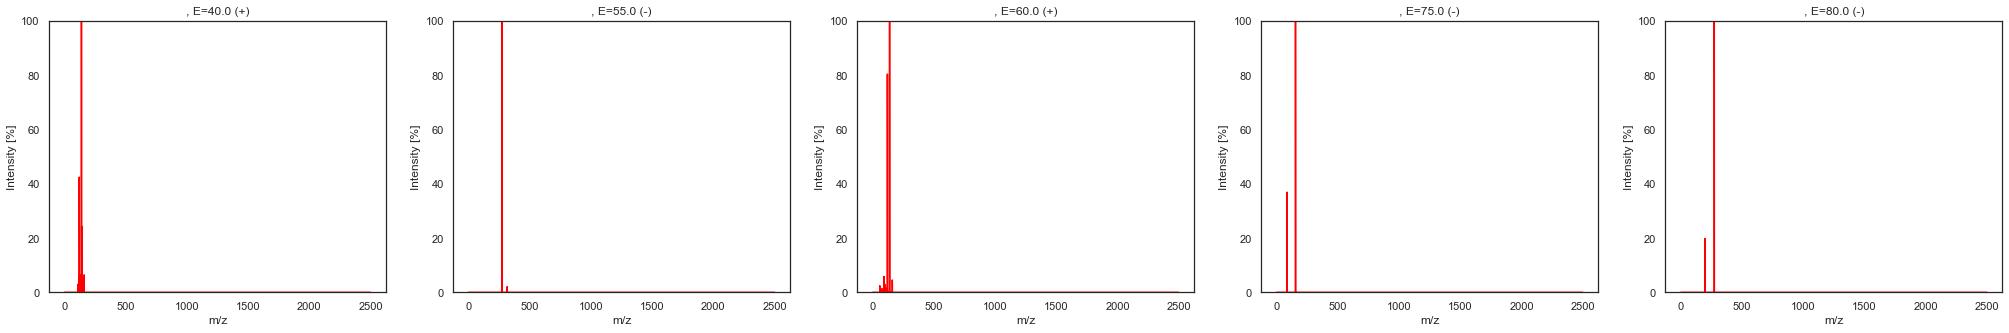

CCN(CC)CCN=C(C1=CC(=CC=C1OC)S(=O)(=O)C)O
(3, 32)


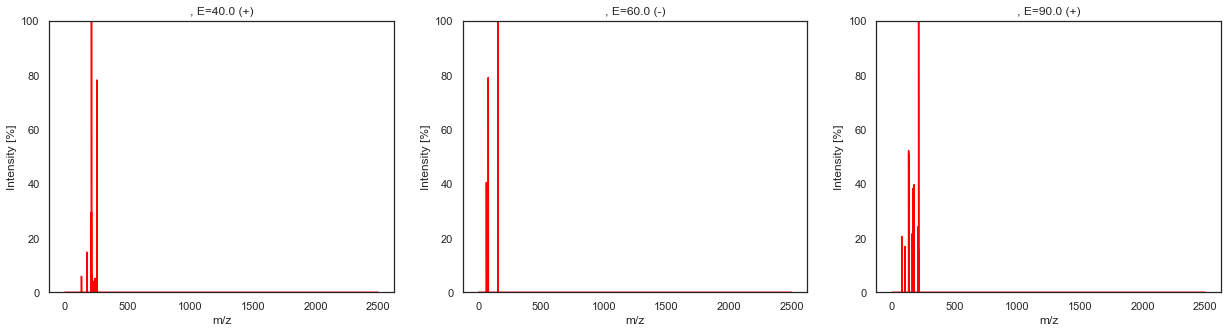

O=C1C(=C(C=CC)C(O)C2OC12C(O)C=C(C)C)CO
(3, 32)


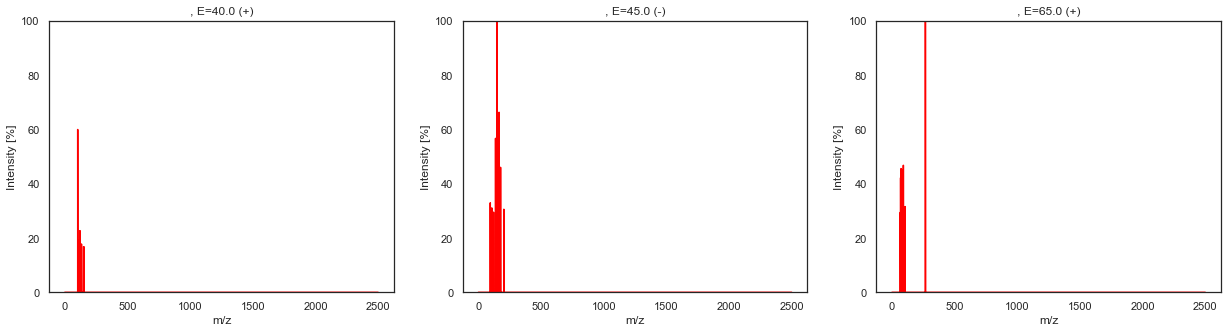

C(C(=NCC(=O)O)O)N
(3, 32)


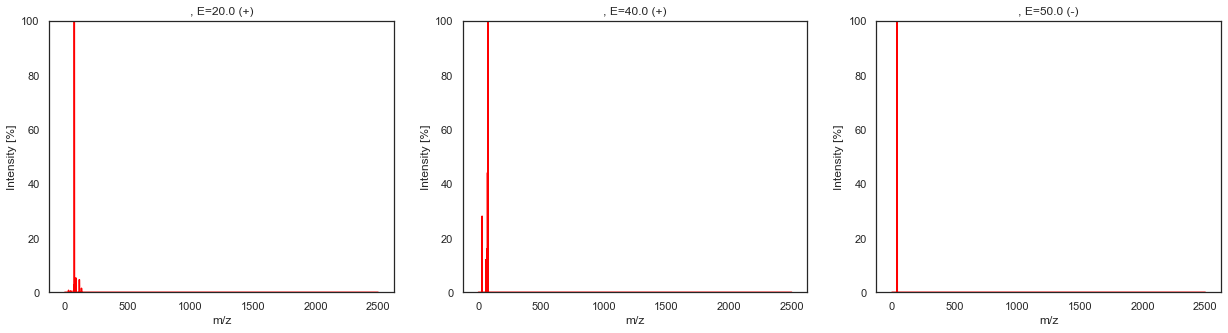

CC(C)(C)NC1=NC(=N)N=C(N1)O
(3, 32)


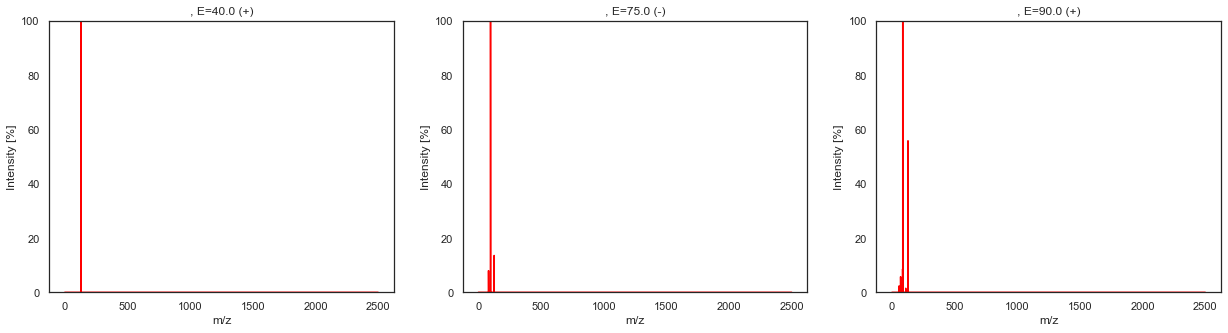

OCC1OC(OCC(C)CCC2(O)OC3CC4C5CCC6CC(OC7OC(CO)C(OC8OC(C)C(O)C(O)C8O)C(O)C7OC9OC(CO)C(O)C(O)C9O)CCC6(C)C5CCC4(C)C3C2C)C(O)C(O)C1O
(4, 32)


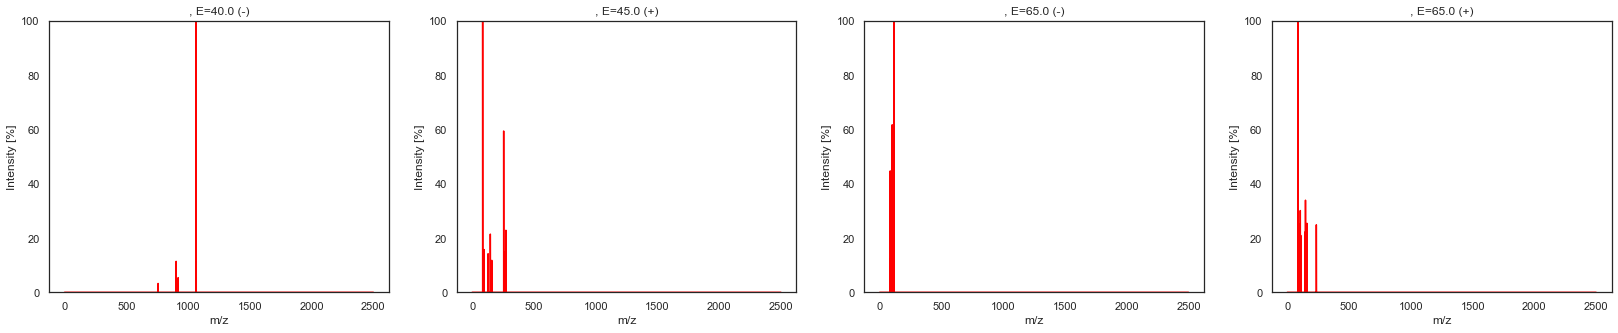

C[C@H]1[C@@H]([C@H]([C@H]([C@H](OC[C@@H]2[C@H]([C@@H]([C@H]([C@@H](O2)OC3=C(C4=CC(=C(C=C4)O)O)OC5=C(C(=CC(=C5)O)O)C3=O)O)O)O)O1)O)O)O
(3, 32)


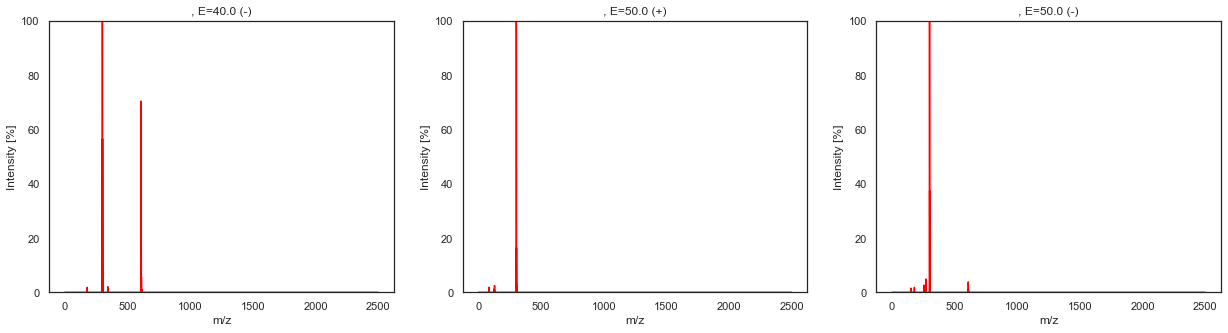

COC1=CC(=CC=C1O)/C=C/C=O
(4, 32)


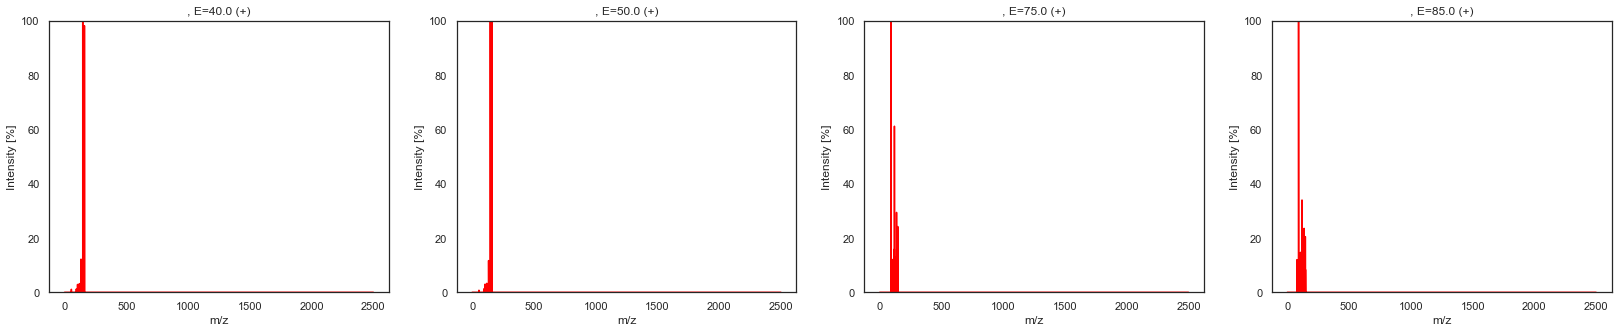

O=C1C2=CC=C(OC3OC(CO)C(O)C(O)C3O)C=C2OC=C1C=4C=C5OCOC5=CC4OC
(3, 32)


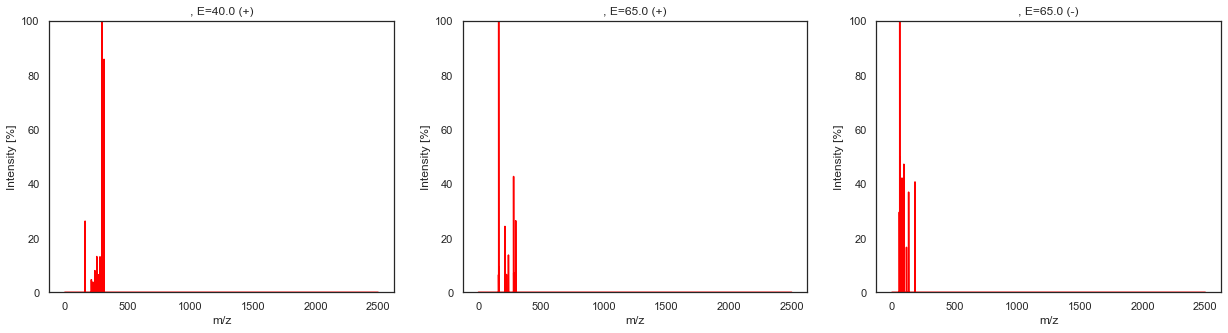

C1CCN2CC3CC(CN4C3CCCC4=O)C2C1
(5, 32)


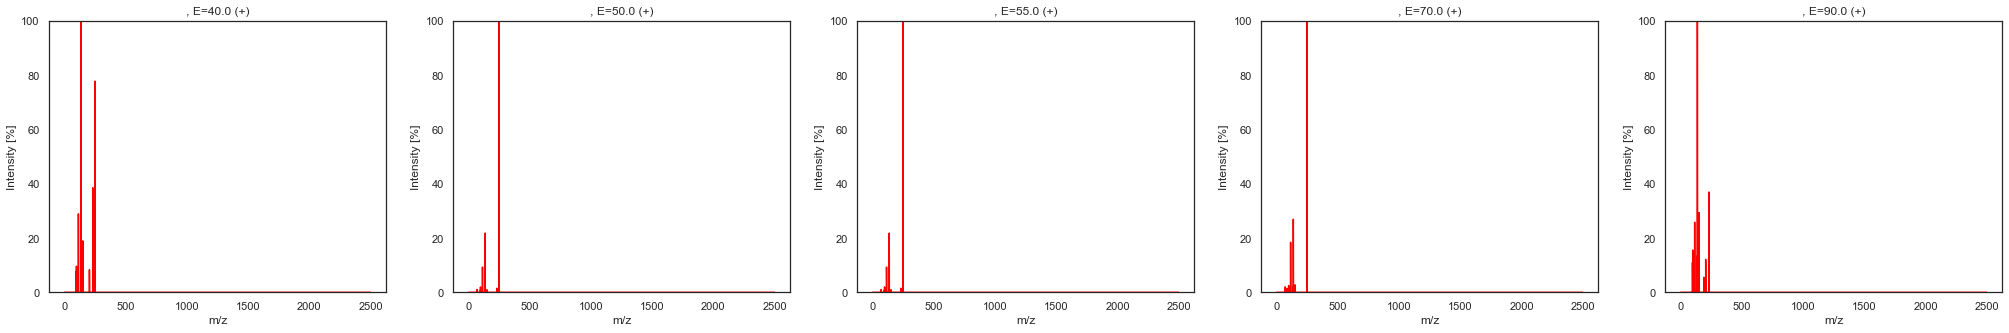

O=C1C2=CC=C(O)C=C2C(=O)C3=CC=C(O)C=C13
(4, 32)


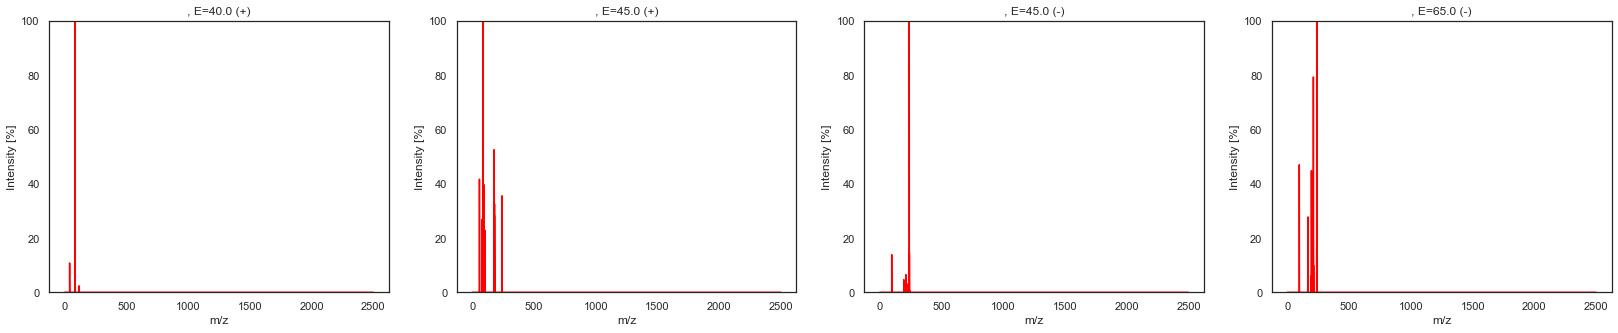

O=C(O)C=1C=C(C(O)=C(C1)CCC(C(=O)C=CC(O)(C)C)C)CC=C(C)C
(3, 32)


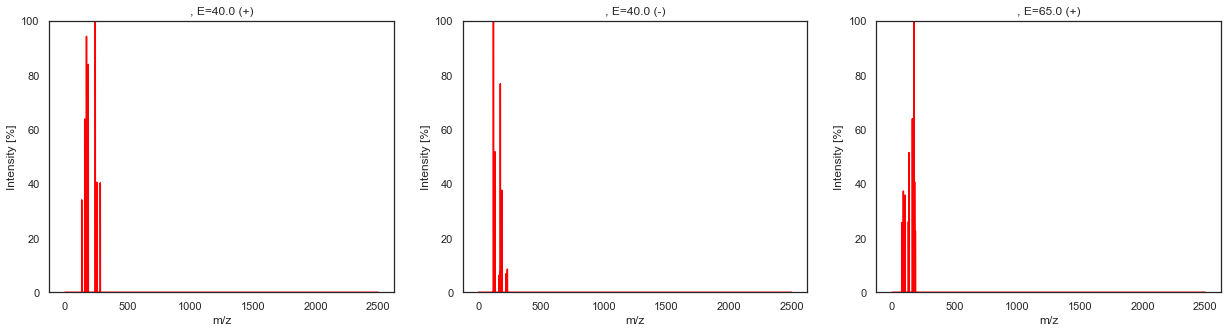

C1=CC2=C(C=C1)NC=C2C/C(=N\OS(=O)(=O)O)/SC3C(C(C(C(CO)O3)O)O)O
(3, 32)


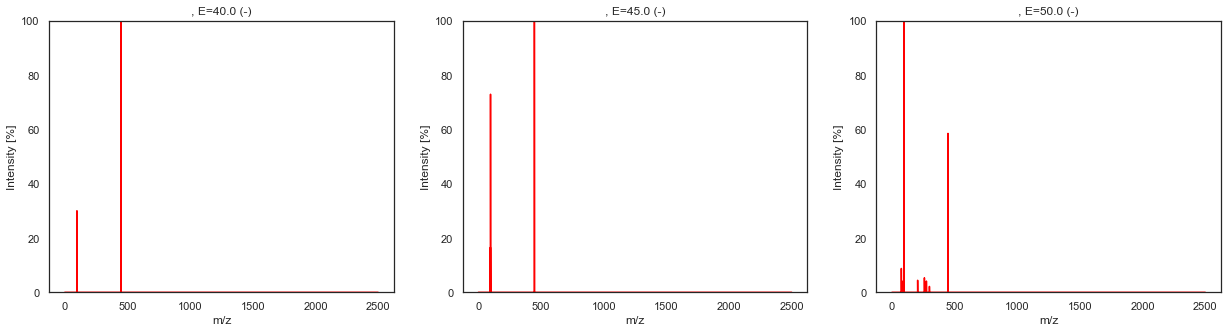

C1CC1N2C=C(C(=O)C3=C2C=C(C(=C3)F)N4CCNCC4)C(=O)O
(4, 32)


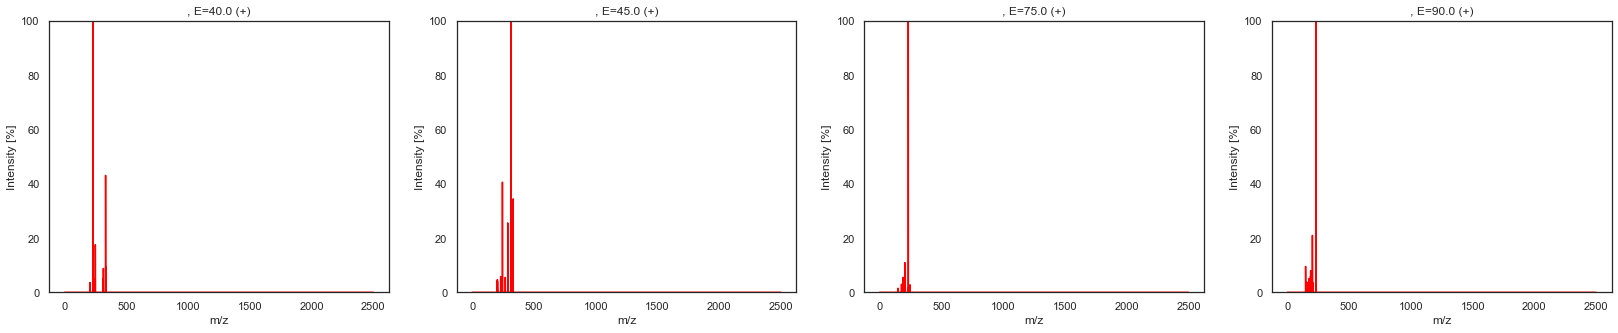

O=C(OC)C(=C)C1C(O)C2C(=C)C(=O)OCC2(C=C)CC1OC(=O)C(=C)CO
(3, 32)


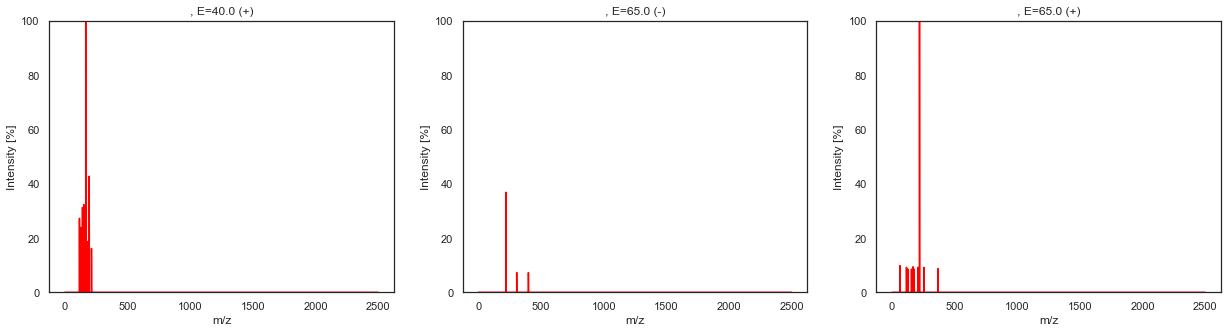

CN1CCC2=C(C=C3C(=C2)OCO3)C(=O)CC4=CC=C5C(=C4C1)OCO5
(5, 32)


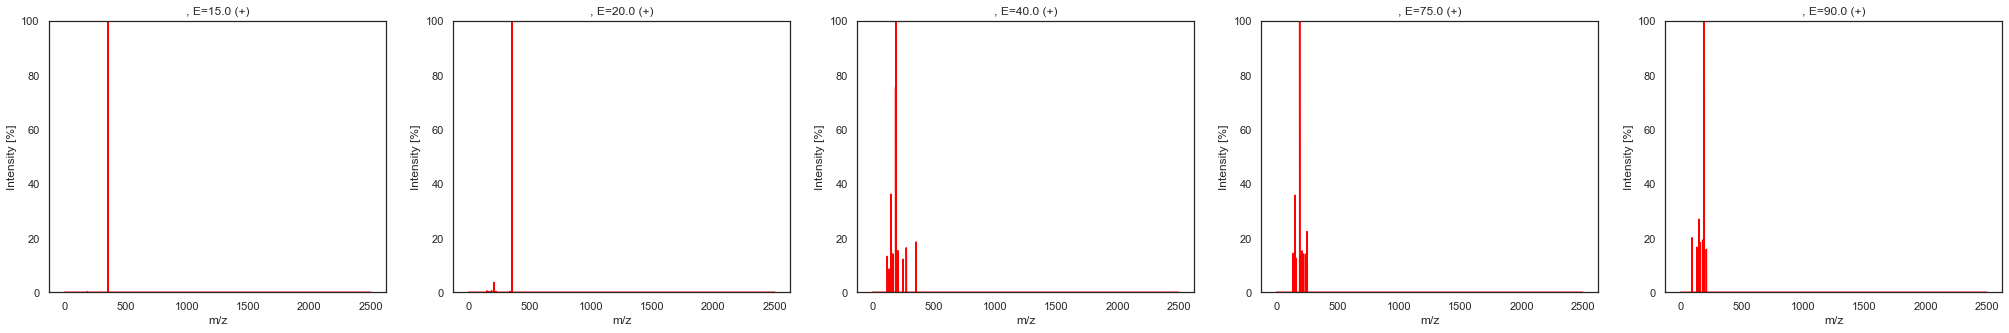

O=C(O)CCC=1OC2=CC(OC)=CC(OC)=C2C(=O)C1
(3, 32)


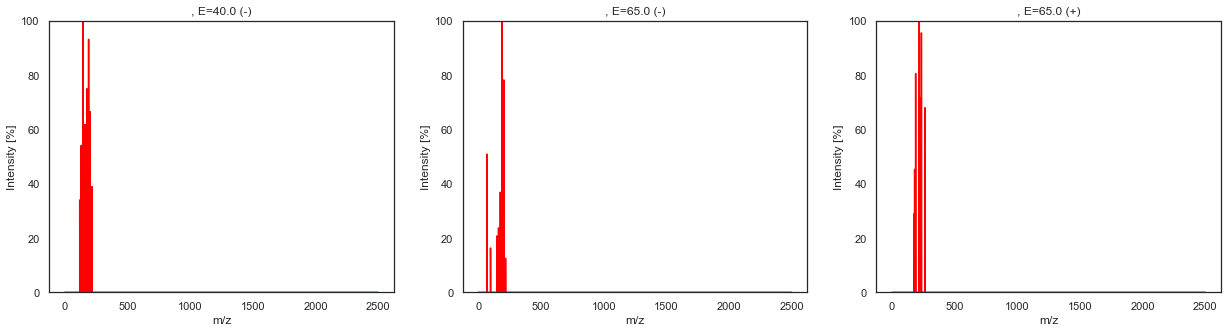

O=C1OC(C2=COC=C2)C3(C)CCC4C5(C(=O)CC(O)C(C)(C)C5CC(=O)C4(C)C63OC16)C
(3, 32)


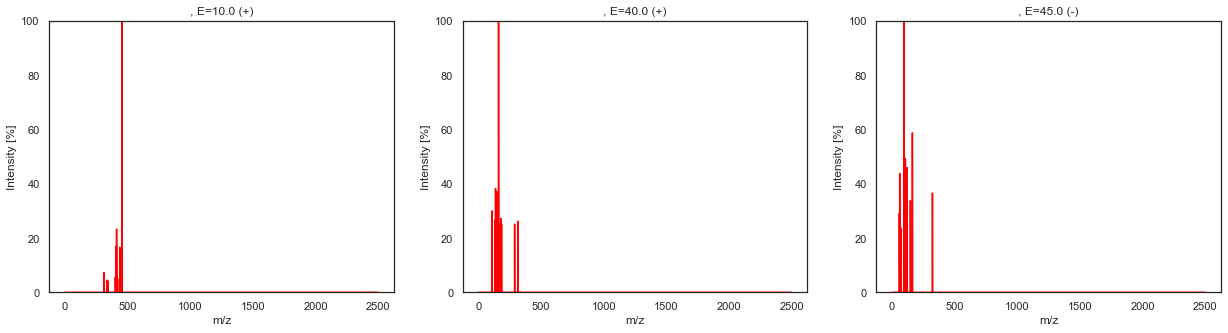

O=C1OCC2C(OC3OC4COC(OC4C(O)C3O)C)C5=CC=6OCOC6C=C5C(C7=CC(OC)=C(O)C(OC)=C7)C12
(3, 32)


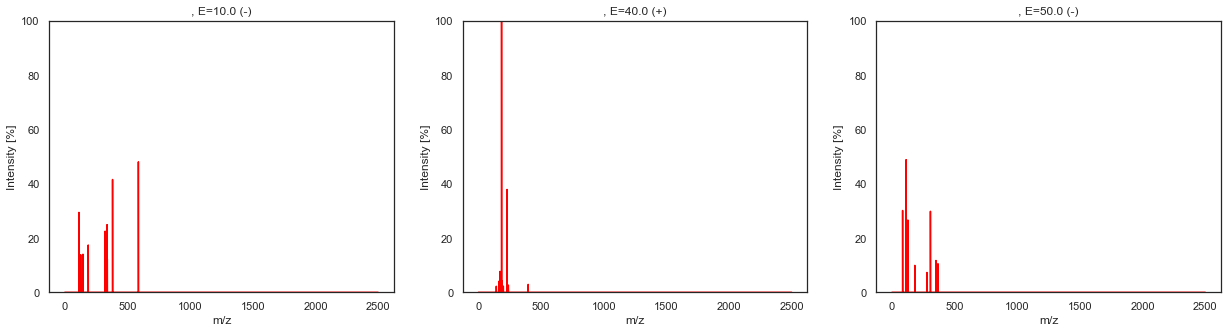

C[C@H](CCC(=NCCS(=O)(=O)O)O)[C@H]1CC[C@H]2[C@H]3[C@H](C[C@@H]([C@]12C)O)[C@@]4(C)CC[C@H](C[C@H]4C[C@H]3O)O
(4, 32)


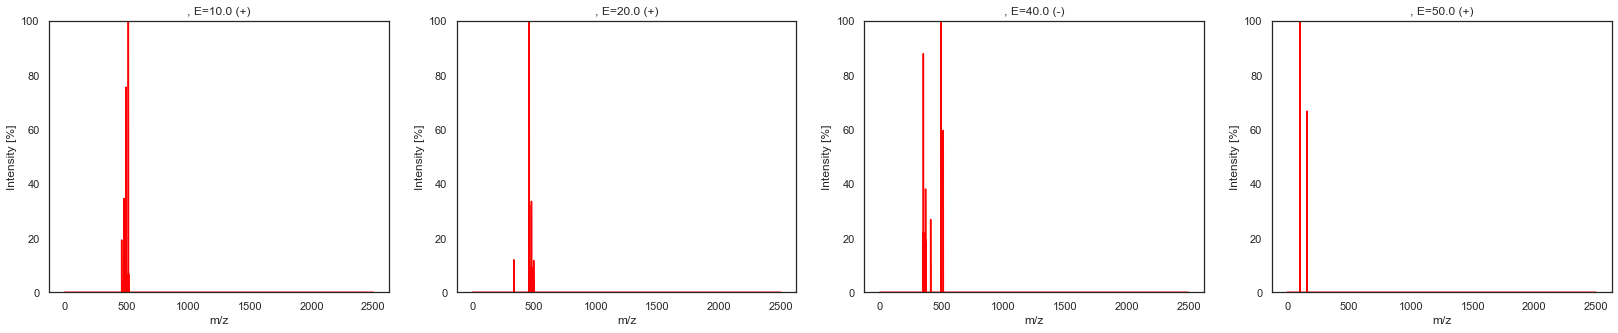

C[C@H](CCC(=NCC(=O)O)O)[C@H]1CC[C@H]2[C@H]3[C@H](C[C@@H]([C@]12C)O)[C@@]4(C)CC[C@H](C[C@H]4C[C@H]3O)O
(3, 32)


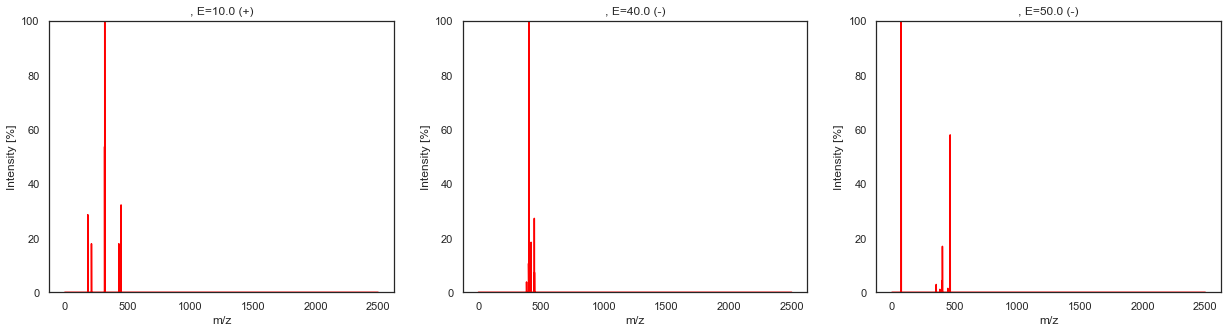

CC(CCC1=CC=CC=C1)NC(C)C(C2=CC=C(C=C2)O)O
(7, 32)


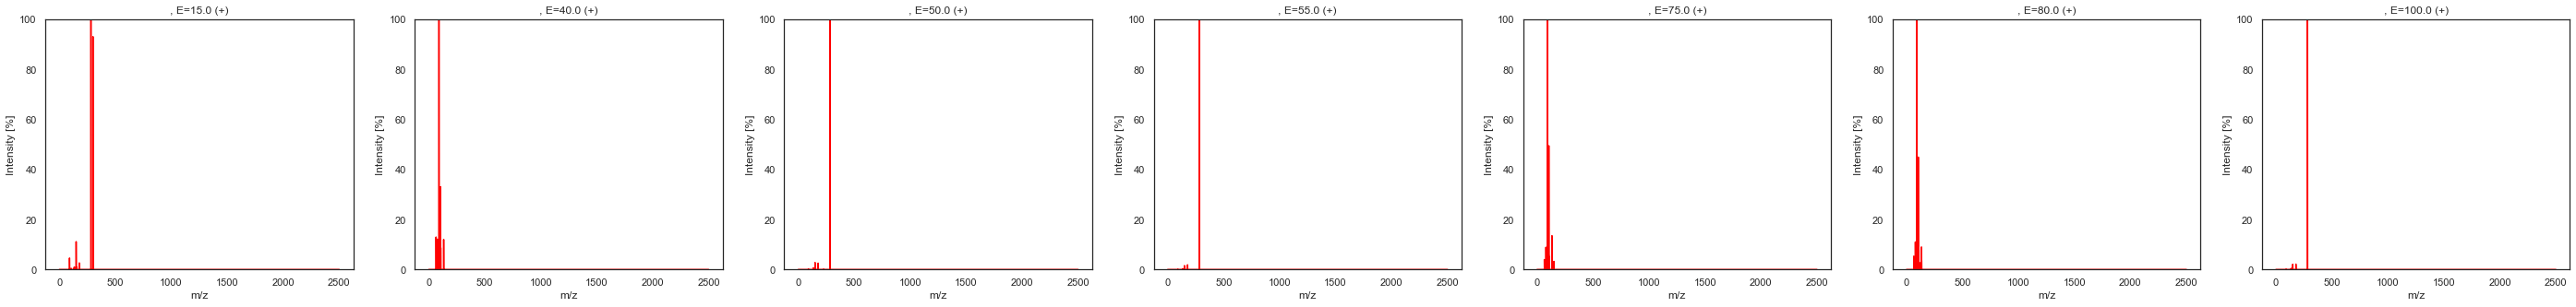

CC1=C(CSCCNC(=NC)NC#N)NC=N1
(3, 32)


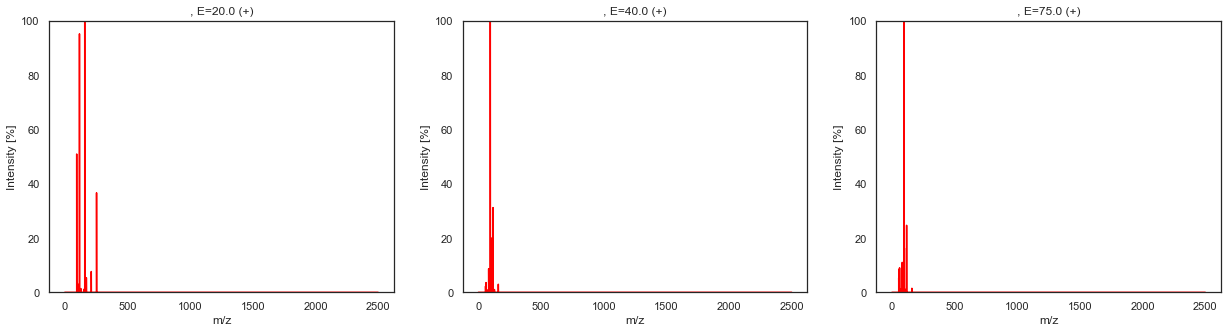

O=C1C=C(OC=2C(OC)=C(O)C=C(O)C12)C=3C=CC=CC3
(3, 32)


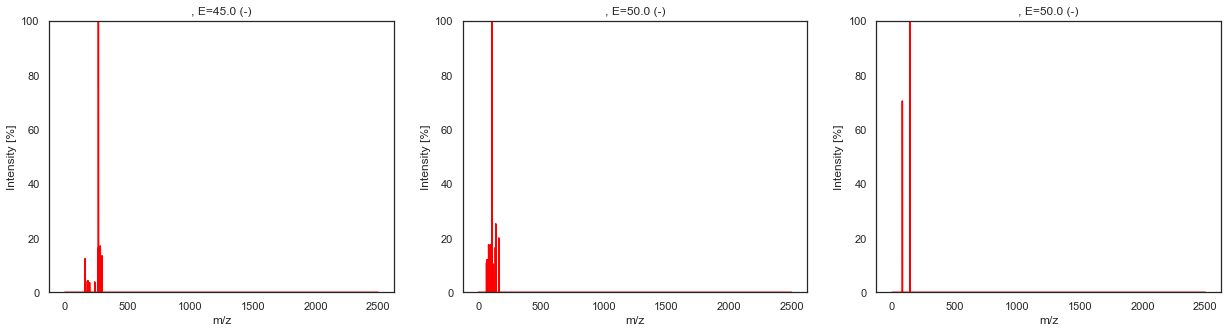

O=C(O)C12CCC(C(=O)OC)(C)CC2C3=CCC4C5(C)CC(O)C(OC6OCC(O)C(O)C6O)C(C)(CO)C5CCC4(C)C3(C)CC1
(3, 32)


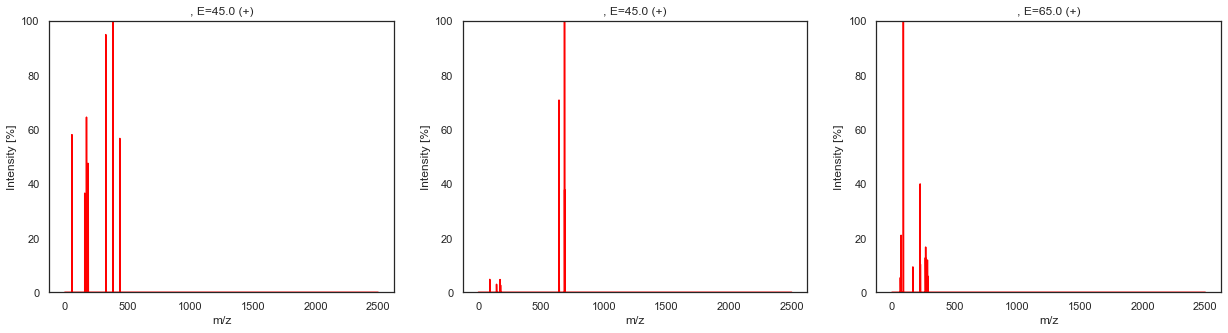

O=C1C2=C(O)C=C(OC3OC(CO)C(O)C(O)C3O)C=C2OC(C4=CC=C(O)C=C4)C1
(3, 32)


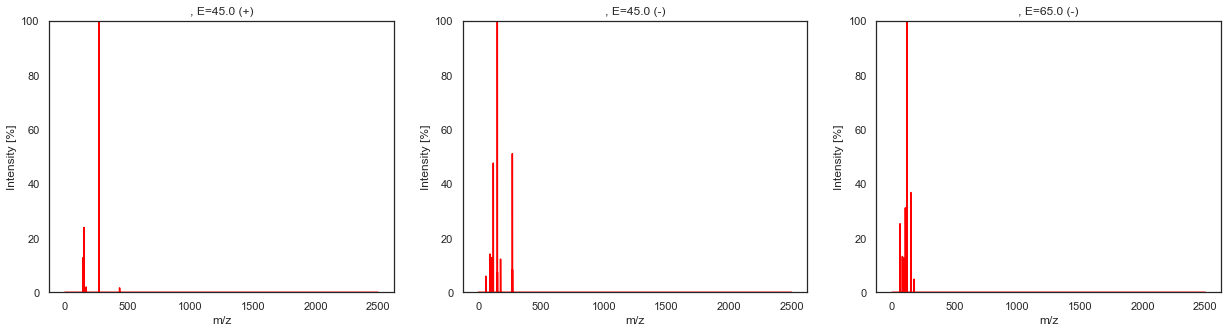

OC(=NC(C)CO)C1C=C2C=3C=CC=C4NC=C(C43)CC2N(C)C1
(3, 32)


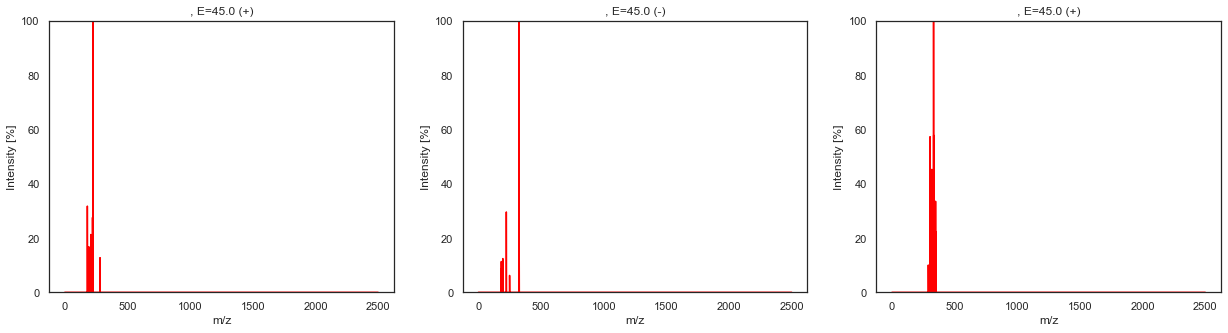

C/C=C\1/C[C@@H](C)[C@](C)(C(=O)OCC2=CCN3CC[C@H]([C@@H]23)OC1=O)O
(5, 32)


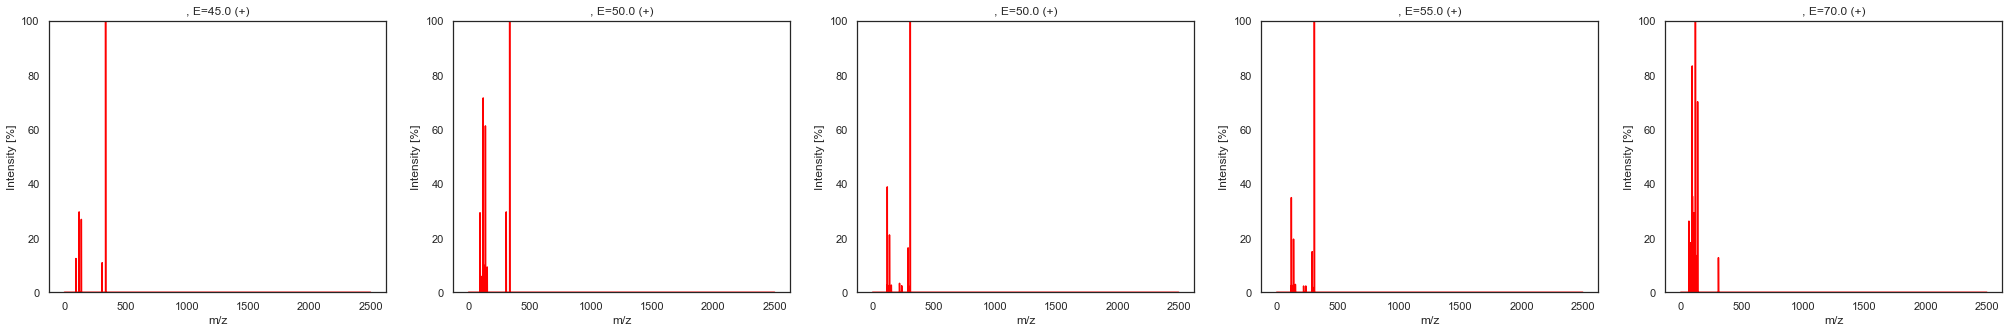

O=C(OC1C(OC(=O)C)C2(C)C3C(=O)OC(C(=O)OC)(C(=O)C3(C(=C)CC2C4(C)C(O)CC(=O)C(C)(C)C14)C)C)C
(3, 32)


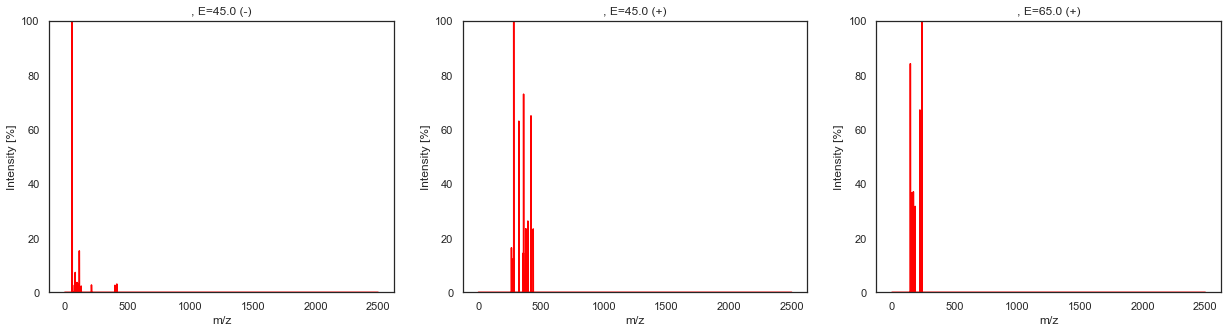

CC1=CC(=O)N(C2=CC=CC=C2)N1C
(4, 32)


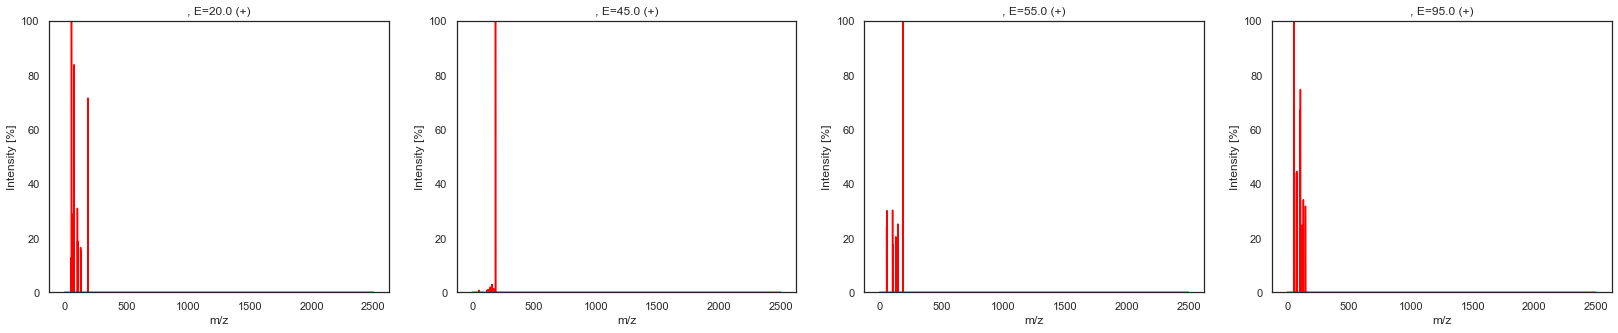

O=C(O)C1(O)CC(O)C(OC(=O)C=CC2=CC=C(O)C(O)=C2)C(O)C1
(3, 32)


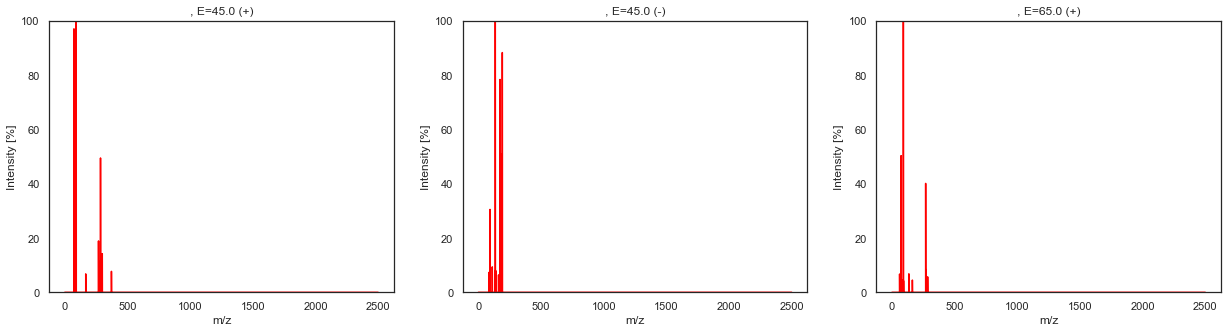

C/C=C(/C)\C(=O)O[C@H]1CCN2CC=C(COC(=O)[C@@]([C@H](C)OC)(C(C)(C)O)O)[C@H]12
(3, 32)


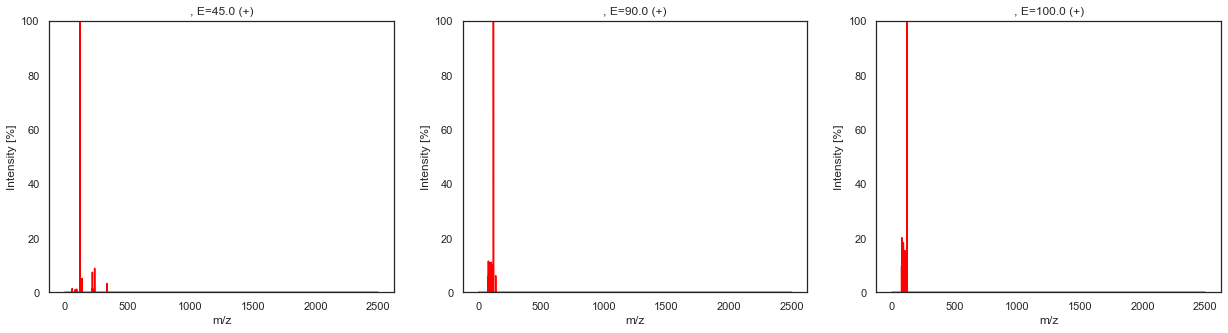

CCOC1=NC2=C(C(=CC=C2)C(=O)O)N1CC3=CC=C(C=C3)C4=C(C=CC=C4)C5=NNN=N5
(5, 32)


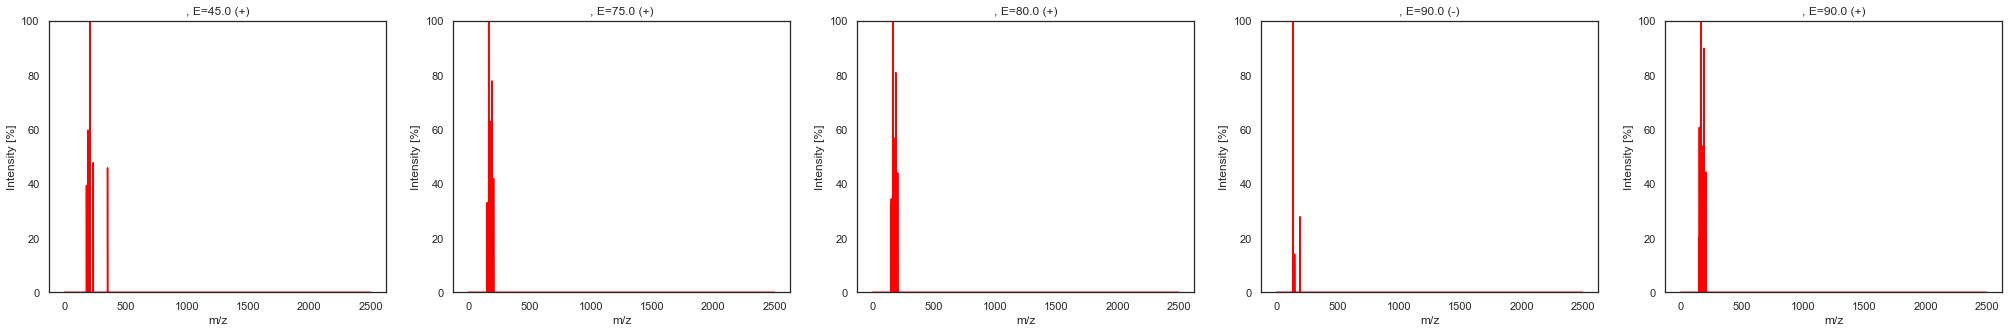

CC1=C(C)OC(=N1)NS(=O)(=O)C2=CC=C(C=C2)N
(8, 32)


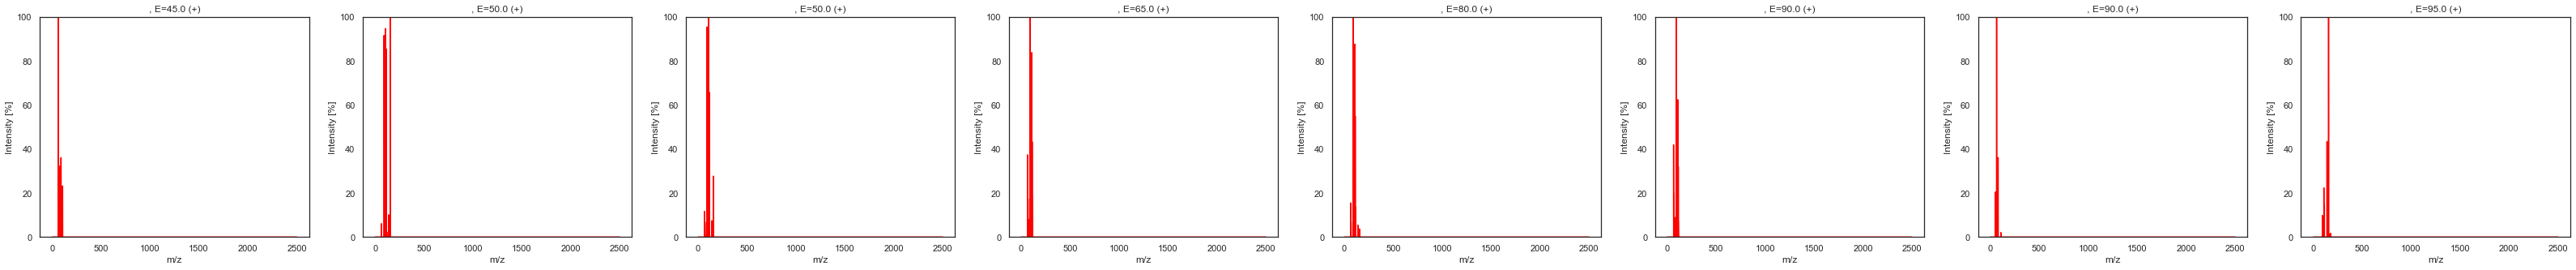

In [1411]:
for smiles in uq_smiles:
    print(smiles)
    sel = df_selected[df_selected['SMILES'] == smiles]
    vis_spectra(sel, label, config=model.config)

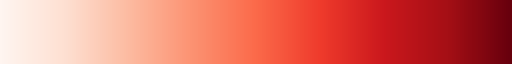

In [1412]:
import seaborn as sns
cmap_base = sns.color_palette("Greys_r", as_cmap=True)
cmap = sns.color_palette("Reds", as_cmap=True)
# cmap = sns.color_palette("Dark2")
cmap

Encode N=5000 instances from MoNA dataset...
torch.Size([5000, 3])
Encode N=14 instances from MoNA dataset...
torch.Size([14, 3])
Encode N=3 instances from MoNA dataset...
torch.Size([3, 3])
Encode N=4 instances from MoNA dataset...
torch.Size([4, 3])
Encode N=6 instances from MoNA dataset...
torch.Size([6, 3])
Encode N=8 instances from MoNA dataset...
torch.Size([8, 3])
Encode N=4 instances from MoNA dataset...
torch.Size([4, 3])
Encode N=6 instances from MoNA dataset...
torch.Size([6, 3])
Encode N=4 instances from MoNA dataset...
torch.Size([4, 3])
Encode N=3 instances from MoNA dataset...
torch.Size([3, 3])
Encode N=3 instances from MoNA dataset...
torch.Size([3, 3])
Encode N=4 instances from MoNA dataset...
torch.Size([4, 3])
Encode N=3 instances from MoNA dataset...
torch.Size([3, 3])
Encode N=3 instances from MoNA dataset...
torch.Size([3, 3])
Encode N=5 instances from MoNA dataset...
torch.Size([5, 3])
Encode N=4 instances from MoNA dataset...
torch.Size([4, 3])
Encode N=3 insta

Text(0.5, 1.0, 'UMAP view on VAE latent space for MoNA dataset (collision_energy)')

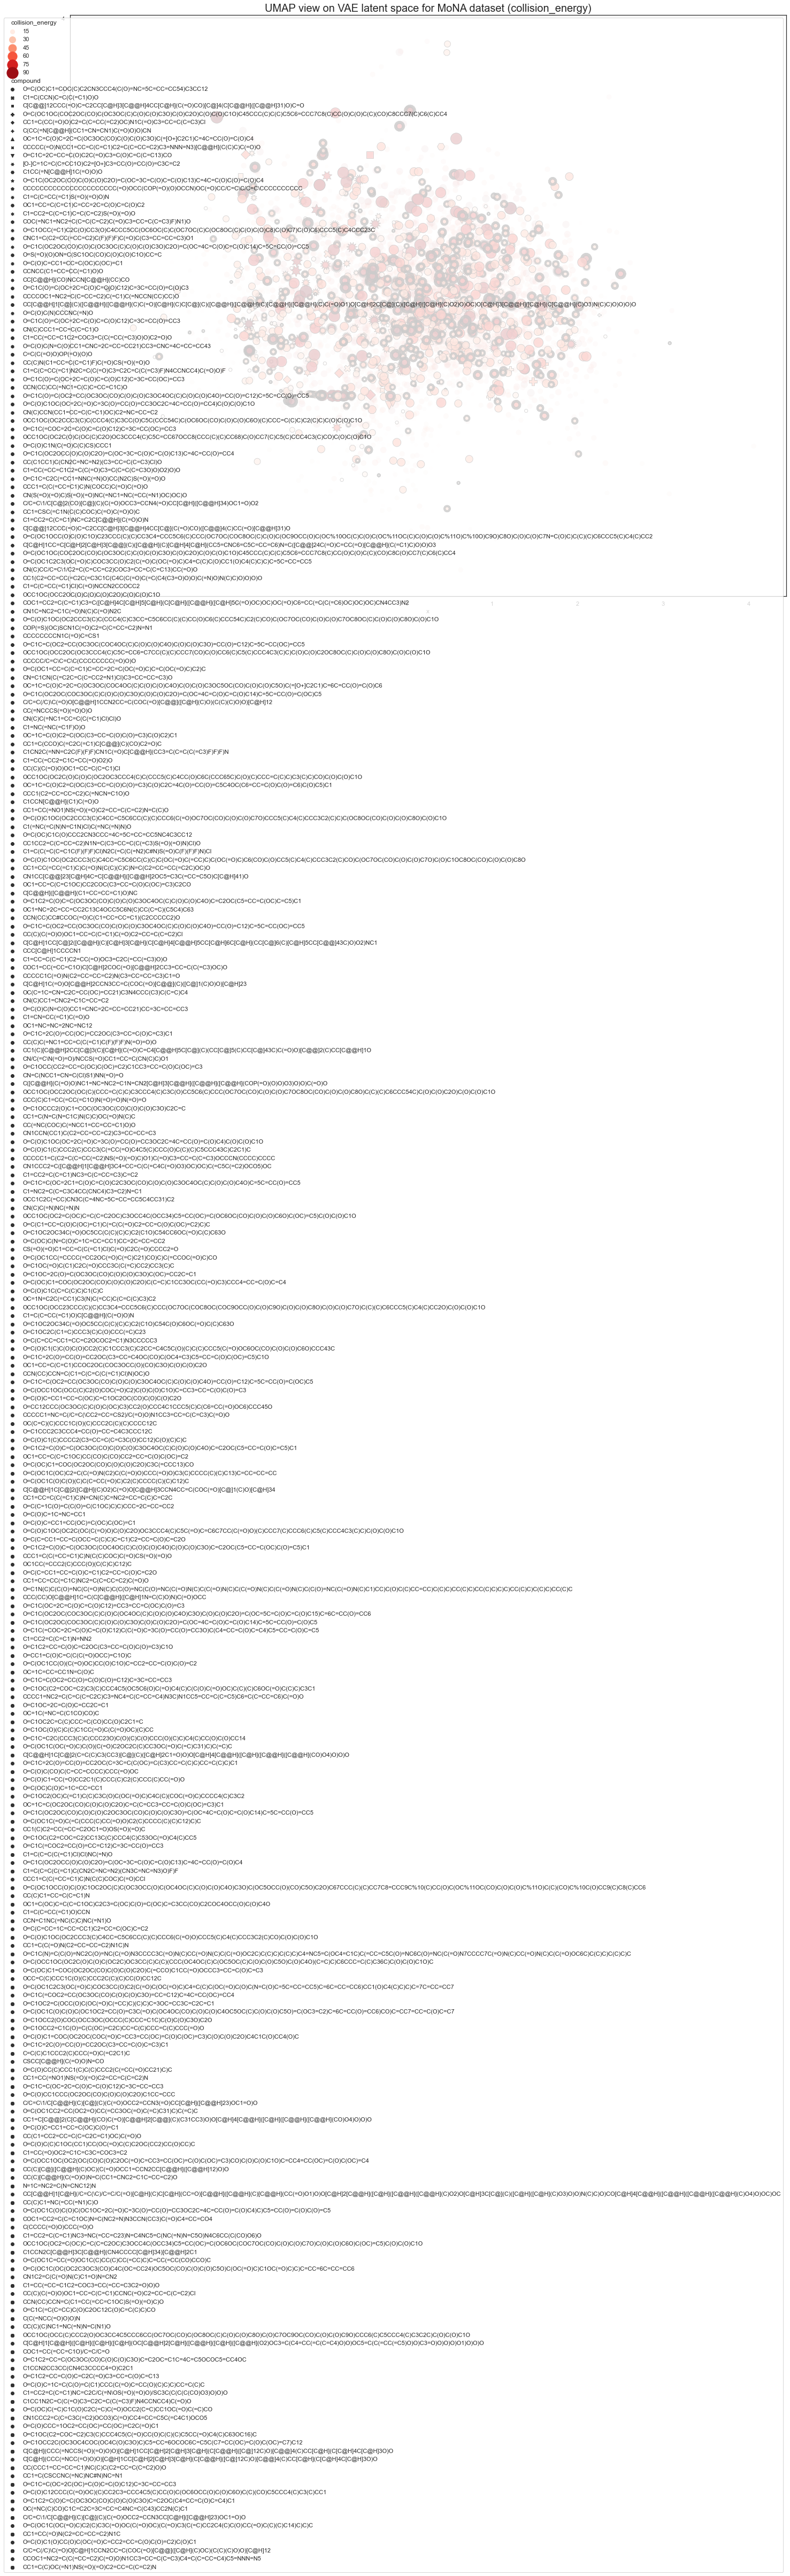

In [1413]:
import seaborn as sns

title = 'UMAP view on VAE latent space for %s dataset (%s)' % (dataset, label) 

df = load_vis_data(label)
data = preload_data_as_tensor(df)
data_np = evaluate_model(df, data)

dfs = []
selected_z = []
selected_np = []

selected_z.append(data_np['z'])
selected_np.append(data_np)
df_plot_selected = pd.DataFrame(data=np.expand_dims(
    df[label].to_numpy(), axis=1), columns=[label])
df_plot_selected['compound'] = 'remaining'
dfs.append(df_plot_selected)

for smiles in uq_smiles:
    df_selected_ = df_selected[df_selected['SMILES'] == smiles]
    selected_data = preload_data_as_tensor(df_selected_)
    selected_data_np = evaluate_model(df_selected_, selected_data)

    selected_z.append(selected_data_np['z'])
    selected_np.append(selected_data_np)

    df_plot_selected = pd.DataFrame(data=np.expand_dims(
        df_selected_[label].to_numpy(), axis=1), columns=[label])
    df_plot_selected['compound'] = smiles
    dfs.append(df_plot_selected)

# Reduce with PCA to 2D:
z = np.vstack(selected_z)
pca2_data = compute_pca(z, n=2)

# Build final dataframe:
df_plot = pd.concat(dfs)
df_plot.reset_index(inplace=True, drop=True)
df_latent = pd.DataFrame(data=pca2_data, columns=['x', 'y'])
df_latent.reset_index(inplace=True, drop=True)
df_plot = pd.concat((df_plot, df_latent), axis=1, ignore_index=True)
df_plot = df_plot.rename(columns={0: label, 1: 'compound', 2: 'x', 3: 'y'})

ax = sns.scatterplot(data=df_plot[df_plot['compound'] == 'remaining'], x='x', y='y', 
    alpha=0.15, palette=cmap, hue=label, size=label, sizes=(40, 200), legend=False)

sns.scatterplot(data=df_plot[df_plot['compound'] != 'remaining'], x='x', y='y', 
    palette=cmap, hue=label, style='compound', size=label, sizes=(40, 500),
    alpha=0.8, edgecolor='black', ax=ax)

ax.set_title(title, fontsize=20)
# ax.set_xlim(-7.0, 16.0)
# ax.set_ylim(-5.0, 15.0)